In [2]:
# Bootstrap: install missing deps into *this* kernel
import sys, subprocess, importlib

def ensure(pkgs):
    for p in pkgs:
        try:
            importlib.import_module(p["import"])
        except Exception:
            subprocess.check_call([sys.executable, "-m", "pip", "install", p["pip"]])

pkgs = [
    {"import":"numpy",      "pip":"numpy>=2.0"},
    {"import":"matplotlib", "pip":"matplotlib"},
    {"import":"requests",   "pip":"requests"},
    {"import":"wmi",        "pip":"wmi"},
    {"import":"win32api",   "pip":"pywin32"},   # needed by wmi on Windows
    {"import":"psutil",     "pip":"psutil"},
]

ensure(pkgs)

import sys, site
print("Python:", sys.version)
print("Interpreter:", sys.executable)
print("Site-packages:", site.getsitepackages())
print("✅ Ready. Re-run the cooling glyph cell.")


Python: 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]
Interpreter: C:\Users\caleb\CNT_Lab\.venv\Scripts\python.exe
Site-packages: ['C:\\Users\\caleb\\CNT_Lab\\.venv', 'C:\\Users\\caleb\\CNT_Lab\\.venv\\Lib\\site-packages']
✅ Ready. Re-run the cooling glyph cell.


In [1]:
# CNT — One-Signal Thesis (REWS) Mega-Cell
# Requirements: numpy, scipy, pandas, matplotlib, scikit-learn (optional but used for ROC), pathlib
# If sklearn is missing, the code will degrade gracefully.

import numpy as np, pandas as pd, matplotlib.pyplot as plt, math, time, os, sys
from pathlib import Path
from scipy.signal import welch, detrend, hilbert
from scipy.ndimage import uniform_filter1d

try:
    from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, roc_curve
    HAVE_SK = True
except Exception:
    HAVE_SK = False

TS = time.strftime("%Y%m%d-%H%M%S")
BASE = Path.home() / "CNT_Lab" / "notebooks" / "archive" / f"cnt_one_signal_{TS}"
BASE.mkdir(parents=True, exist_ok=True)

# ---------- Helpers ----------
def sliding_z(x, w):
    x = np.asarray(x, float)
    if len(x) < w: return np.full_like(x, np.nan)
    mu = uniform_filter1d(x, w, mode="nearest")
    sq = uniform_filter1d(x*x, w, mode="nearest")
    sd = np.sqrt(np.maximum(sq - mu*mu, 1e-12))
    z = (x - mu) / (sd + 1e-12)
    return z

def spectral_flatness(x, fs=1.0, nperseg=256):
    if len(x) < 8: return np.nan
    f, Pxx = welch(x, fs=fs, nperseg=min(nperseg, len(x)))
    Pxx = np.maximum(Pxx, 1e-18)
    gmean = np.exp(np.mean(np.log(Pxx)))
    amean = np.mean(Pxx)
    return gmean / amean

def rolling_feature(x, fn, w, **kw):
    out = np.full(len(x), np.nan)
    for i in range(w, len(x)):
        out[i] = fn(x[i-w:i], **kw)
    return out

def ac1(x):
    if len(x) < 3: return np.nan
    x = np.asarray(x, float); x -= x.mean()
    v = (x[:-1]*x[1:]).sum()
    d = (x*x).sum()
    return v / (d + 1e-12)

def rolling_ac1(x, w):
    return rolling_feature(x, lambda s: ac1(s), w)

def roll_var(x, w):
    out = np.full(len(x), np.nan)
    for i in range(w, len(x)):
        s = x[i-w:i]
        out[i] = np.var(detrend(s, type='linear'))
    return out

def roll_sflat(x, w, fs=1.0):
    return rolling_feature(x, lambda s: spectral_flatness(s, fs=fs), w)

def cnt_rews(x, w=256, fs=1.0):
    # Components
    C1 = rolling_ac1(x, w)              # critical slowing
    C2 = roll_sflat(x, w, fs=fs)        # coherence (lower is more coherent)
    C3 = roll_var(x, w)                 # variance swell
    # Gauge-stable normalization (z-score within windowed history)
    C1z = sliding_z(np.nan_to_num(C1, nan=np.nanmean(C1)), w)
    C2z_inv = sliding_z(-np.nan_to_num(C2, nan=np.nanmean(C2)), w)  # invert: low flatness = warning (so higher is worse)
    C3z = sliding_z(np.nan_to_num(C3, nan=np.nanmean(C3)), w)
    S = C1z + C2z_inv + C3z
    # Rank map (monotone, unit-free)
    ranks = pd.Series(S).rank(method="average").values / (np.sum(~np.isnan(S)) + 1e-12)
    return dict(REWS=ranks, C1=C1, C2=C2, C3=C3, C1z=C1z, C2z_inv=C2z_inv, C3z=C3z)

# ---------- Systems ----------
def simulate_kuramoto(N=128, T=5000, K_schedule=(0.0, 4.0), dt=0.02, seed=0):
    rng = np.random.default_rng(seed)
    omega = rng.normal(0, 1, size=N)
    theta = rng.uniform(-np.pi, np.pi, size=N)
    K0, K1 = K_schedule
    steps = int(T)
    X = []
    R = []
    for t in range(steps):
        K = K0 + (K1 - K0)*t/(steps-1)
        R_complex = np.mean(np.exp(1j*theta))
        r = np.abs(R_complex)
        psi = np.angle(R_complex)
        theta = theta + dt*(omega + K*r*np.sin(psi - theta)) + rng.normal(0, 0.05, size=N)*np.sqrt(dt)
        X.append(np.mean(np.sin(theta)))  # observable
        R.append(r)
    X = np.array(X); R = np.array(R)
    # Transition ~ first time r passes 0.5 steadily
    win = 100
    sm = uniform_filter1d(R, win)
    idx = np.argmax(sm > 0.5)
    t_c = idx if sm[idx] > 0.5 else len(R)-1
    return X, R, t_c

def simulate_ising_meanfield(T=6000, beta_schedule=(0.0, 1.2), h=0.0, seed=0):
    rng = np.random.default_rng(seed)
    m = rng.uniform(-0.1, 0.1)
    X=[]; M=[]
    for t in range(T):
        beta = beta_schedule[0] + (beta_schedule[1]-beta_schedule[0])*t/(T-1)
        # mean-field fixed-point update with noise
        m = np.tanh(beta*(m + h)) + rng.normal(0, 0.01)
        X.append(m + rng.normal(0, 0.02))
        M.append(m)
    X = np.array(X); M = np.array(M)
    # Transition: |m| rising past 0.5
    win = 100
    sm = uniform_filter1d(np.abs(M), win)
    idx = np.argmax(sm > 0.5)
    t_c = idx if sm[idx] > 0.5 else len(M)-1
    return X, M, t_c

def simulate_logistic(N=8000, r_schedule=(3.2, 3.7), x0=0.2):
    X=[]; x=x0
    for t in range(N):
        r = r_schedule[0] + (r_schedule[1]-r_schedule[0])*t/(N-1)
        x = r*x*(1-x)
        X.append(x)
    X = np.array(X)
    # Transition to chaos ~ r ~ 3.569..., approximate by variance burst
    win=200
    vx = roll_var(X, win)
    t_c = int(np.nanargmax(vx))
    return X, t_c

def simulate_lorenz(T=8000, dt=0.01, rho_schedule=(20.0, 35.0), sigma=10., beta=8/3):
    x=y=z=1.0
    X=[]
    for t in range(T):
        rho = rho_schedule[0] + (rho_schedule[1]-rho_schedule[0])*t/(T-1)
        dx = sigma*(y - x)
        dy = x*(rho - z) - y
        dz = x*y - beta*z
        x += dx*dt; y += dy*dt; z += dz*dt
        X.append(x)  # single observable
    X = np.array(X)
    # Transition ~ onset of high-complexity regime: spectral flatness minimum time
    sf = roll_sflat(X, 256)
    t_c = np.nanargmin(sf)
    return X, t_c

# ---------- Evaluation ----------
def labels_from_transition(n, t_c, horizon=400):
    # Positive = in early-warning window BEFORE transition
    y = np.zeros(n, dtype=int)
    start = max(0, t_c - horizon)
    y[start:t_c] = 1
    return y

def evaluate_system(name, x, t_c, fs=1.0, w=256, horizon=400):
    feats = cnt_rews(x, w=w, fs=fs)
    REWS = feats['REWS']
    varw = roll_var(x, w)
    acw = rolling_ac1(x, w)
    sflat = roll_sflat(x, w, fs=fs)
    n = len(x); y = labels_from_transition(n, t_c, horizon=horizon)
    # Align metrics and labels
    mask = ~np.isnan(REWS) & ~np.isnan(varw) & ~np.isnan(acw) & ~np.isnan(sflat)
    if mask.sum() < 50:
        return None
    def auroc(score):
        if not HAVE_SK: return np.nan
        try:
            return roc_auc_score(y[mask], score[mask])
        except Exception:
            return np.nan
    scores = {
        'REWS': REWS,
        'Variance': varw,
        'AC1': acw,
        '1-Flatness': -sflat
    }
    aucs = {k: auroc(v) for k,v in scores.items()}
    # Lead time via best single global threshold chosen later; for now store series
    df = pd.DataFrame({'y':y, **{k:scores[k] for k in scores}})
    return df, aucs, feats

# ---------- Run suite ----------
results = {}
systems = []

# Kuramoto
xK, R, tcK = simulate_kuramoto()
out = evaluate_system('Kuramoto', xK, tcK)
if out: results['Kuramoto'] = out; systems.append(('Kuramoto', xK, tcK))

# Ising mean-field
xI, M, tcI = simulate_ising_meanfield()
out = evaluate_system('Ising', xI, tcI)
if out: results['Ising'] = out; systems.append(('Ising', xI, tcI))

# Logistic
xL, tcL = simulate_logistic()
out = evaluate_system('Logistic', xL, tcL)
if out: results['Logistic'] = out; systems.append(('Logistic', xL, tcL))

# Lorenz
xZ, tcZ = simulate_lorenz()
out = evaluate_system('Lorenz', xZ, tcZ)
if out: results['Lorenz'] = out; systems.append(('Lorenz', xZ, tcZ))

# Optional: ingest local logs if present (drop a CSV with a column 'value' and a known t_c)
# Example paths you can edit:
extra = []
candidate_paths = [
    Path.home() / "CNT_Lab" / "notebooks" / "archive" / "cnt_gpu_cooling_log_*.csv",
    Path.home() / "CNT_Lab" / "notebooks" / "archive" / "cnt_unified_cooling_*.csv",
]
# (Wildcard expansion omitted for portability)

# ---------- Aggregate + Θ selection ----------
# Build a global threshold Θ on REWS that maximizes mean F1 across systems (if sklearn present).
def choose_global_theta(REWS_list, y_list):
    if not HAVE_SK: return 0.8, {}
    # Gather candidate thresholds from pooled quantiles
    pooled = np.concatenate([r[~np.isnan(r)] for r in REWS_list])
    qs = np.unique(np.clip(np.linspace(0.5, 0.99, 50), 0, 1))
    thetas = np.quantile(pooled, qs)
    best = None; scores = {}
    for th in thetas:
        f1s = []
        for r,y in zip(REWS_list, y_list):
            m = ~np.isnan(r)
            if m.sum()<50: continue
            pred = (r[m] >= th).astype(int)
            try:
                f1s.append(f1_score(y[m], pred))
            except Exception:
                pass
        if f1s:
            meanf = float(np.mean(f1s))
            scores[float(th)] = meanf
            if not best or meanf > best[1]:
                best = (float(th), meanf)
    return (best[0] if best else 0.85), scores

dfs = {}
aucs = {}
rews_list, y_list = [], []
for name, (df, auc, feats) in results.items():
    dfs[name] = df
    aucs[name] = auc
    rews_list.append(df['REWS'].values)
    y_list.append(df['y'].values)

THETA, theta_scores = choose_global_theta(rews_list, y_list)

# ---------- Reporting ----------
# Save CSV summary
summary_rows = []
for name in dfs:
    auc = aucs[name]
    summary_rows.append({
        "system": name,
        "AUC_REWS": round(auc['REWS'],4) if HAVE_SK and not np.isnan(auc['REWS']) else np.nan,
        "AUC_Variance": round(auc['Variance'],4) if HAVE_SK and not np.isnan(auc['Variance']) else np.nan,
        "AUC_AC1": round(auc['AC1'],4) if HAVE_SK and not np.isnan(auc['AC1']) else np.nan,
        "AUC_1minusFlatness": round(auc['1-Flatness'],4) if HAVE_SK and not np.isnan(auc['1-Flatness']) else np.nan,
    })
summary = pd.DataFrame(summary_rows)
summary.to_csv(BASE/"summary_auc.csv", index=False)

with open(BASE/"summary.txt","w") as f:
    f.write("== CNT One-Signal Thesis (REWS) ==\n")
    f.write(f"Run: {TS}\n\n")
    f.write("AUCs (higher better) vs early-warning labels (pre-transition window):\n")
    f.write(summary.to_string(index=False))
    f.write("\n\n")
    f.write(f"Global Θ (REWS threshold): {THETA:.4f}\n")
    if theta_scores:
        f.write(f"Mean-F1 at Θ: {max(theta_scores.values()):.3f}\n")

# Plots
for name,(x,tc) in [(n, (s[1], s[2])) for n,s in systems]:
    df = dfs[name]
    fig,ax = plt.subplots(figsize=(10,4))
    ax.plot(x, lw=1.0)
    ax.axvline(tc, ls='--')
    ax.set_title(f"{name} observable (transition dashed)")
    plt.tight_layout(); plt.savefig(BASE/f"{name.lower()}_observable.png", dpi=160); plt.close()

    fig,ax = plt.subplots(figsize=(10,4))
    ax.plot(df['REWS'].values, lw=1.0, label='REWS')
    ax.axhline(THETA, ls='--', label='Θ')
    ax.set_title(f"{name} — REWS with Θ")
    ax.legend()
    plt.tight_layout(); plt.savefig(BASE/f"{name.lower()}_rews.png", dpi=160); plt.close()

# Final print
print("Saved:")
print(" -", BASE/"summary_auc.csv")
print(" -", BASE/"summary.txt")
for name in dfs:
    print(f" - {BASE}/{name.lower()}_observable.png")
    print(f" - {BASE}/{name.lower()}_rews.png")

print("\nHypothesis check:")
if HAVE_SK:
    print("If REWS AUC consistently > baselines AND one Θ performs across systems, you have a cross-domain, gauge-stable early warning dial.")
else:
    print("Install scikit-learn for AUROC/F1: pip install scikit-learn")


UnicodeEncodeError: 'charmap' codec can't encode character '\u0398' in position 7: character maps to <undefined>

In [2]:
# CNT — One-Signal Thesis (REWS) — Fused & Upgraded Mega-Cell
# Safe on Windows (UTF-8), portable, no internet required.
# Requirements: numpy, scipy, pandas, matplotlib, scikit-learn (optional)

import os, sys, time, math, glob, re, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, detrend
from scipy.ndimage import uniform_filter1d

warnings.filterwarnings("ignore", category=UserWarning)
TS = time.strftime("%Y%m%d-%H%M%S")
HOME = Path.home()
BASE = HOME / "CNT_Lab" / "notebooks" / "archive" / f"cnt_one_signal_{TS}"
BASE.mkdir(parents=True, exist_ok=True)

# ---------- Optional deps ----------
try:
    from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, roc_curve
    HAVE_SK = True
except Exception:
    HAVE_SK = False

def safe_print(s):
    try:
        print(s)
    except Exception:
        print(s.encode("ascii", "ignore").decode("ascii"))

def save_txt(name, text):
    p = BASE / name
    with open(p, "w", encoding="utf-8", newline="") as f:
        f.write(text)
    return p

def save_csv(df, name):
    p = BASE / name
    df.to_csv(p, index=False, encoding="utf-8")
    return p

# ---------- Core features ----------
def sliding_z(x, w):
    x = np.asarray(x, float)
    if len(x) < w: return np.full_like(x, np.nan)
    mu = uniform_filter1d(x, w, mode="nearest")
    sq = uniform_filter1d(x*x, w, mode="nearest")
    sd = np.sqrt(np.maximum(sq - mu*mu, 1e-12))
    return (x - mu) / (sd + 1e-12)

def spectral_flatness(x, fs=1.0, nperseg=256):
    if len(x) < 8: return np.nan
    f, Pxx = welch(np.asarray(x, float), fs=fs, nperseg=min(nperseg, max(8, len(x)//4)))
    Pxx = np.maximum(Pxx, 1e-18)
    gmean = np.exp(np.mean(np.log(Pxx)))
    amean = np.mean(Pxx)
    return gmean / amean

def rolling_feature(x, fn, w, **kw):
    out = np.full(len(x), np.nan)
    for i in range(w, len(x)):
        out[i] = fn(x[i-w:i], **kw)
    return out

def ac1(x):
    if len(x) < 3: return np.nan
    x = np.asarray(x, float); x -= x.mean()
    v = (x[:-1]*x[1:]).sum()
    d = (x*x).sum()
    return v / (d + 1e-12)

def rolling_ac1(x, w):
    return rolling_feature(x, lambda s: ac1(s), w)

def roll_var(x, w):
    out = np.full(len(x), np.nan)
    for i in range(w, len(x)):
        s = x[i-w:i]
        out[i] = np.var(detrend(np.asarray(s, float), type='linear'))
    return out

def roll_sflat(x, w, fs=1.0):
    return rolling_feature(x, lambda s: spectral_flatness(s, fs=fs), w)

def cnt_rews(x, w=256, fs=1.0):
    C1 = rolling_ac1(x, w)          # critical slowing
    C2 = roll_sflat(x, w, fs=fs)    # coherence (lower => warning)
    C3 = roll_var(x, w)             # amplitude swell
    # z-normalize in a gauge-stable way
    C1z     = sliding_z(np.nan_to_num(C1, nan=np.nanmean(C1)), w)
    C2z_inv = sliding_z(-np.nan_to_num(C2, nan=np.nanmean(C2)), w)
    C3z     = sliding_z(np.nan_to_num(C3, nan=np.nanmean(C3)), w)
    S = C1z + C2z_inv + C3z
    # rank → unit-free monotone (gauge-invariant under admissible transforms)
    ranks = pd.Series(S).rank(method="average").values / (np.sum(~np.isnan(S)) + 1e-12)
    return dict(REWS=ranks, C1=C1, C2=C2, C3=C3, C1z=C1z, C2z_inv=C2z_inv, C3z=C3z)

# ---------- Synthetic systems ----------
def simulate_kuramoto(N=128, T=5000, K_schedule=(0.0, 4.0), dt=0.02, seed=0):
    rng = np.random.default_rng(seed)
    omega = rng.normal(0, 1, size=N)
    theta = rng.uniform(-np.pi, np.pi, size=N)
    K0, K1 = K_schedule
    X=[]; R=[]
    for t in range(T):
        K = K0 + (K1 - K0)*t/(T-1)
        R_complex = np.mean(np.exp(1j*theta))
        r = np.abs(R_complex); psi = np.angle(R_complex)
        theta = theta + dt*(omega + K*r*np.sin(psi - theta)) + rng.normal(0, 0.05, size=N)*np.sqrt(dt)
        X.append(np.mean(np.sin(theta))); R.append(r)
    X = np.array(X); R = np.array(R)
    sm = uniform_filter1d(R, 100)
    idx = np.argmax(sm > 0.5); t_c = idx if sm[idx] > 0.5 else len(R)-1
    return X, R, t_c

def simulate_ising_meanfield(T=6000, beta_schedule=(0.0, 1.2), h=0.0, seed=0):
    rng = np.random.default_rng(seed)
    m = rng.uniform(-0.1, 0.1)
    X=[]; M=[]
    for t in range(T):
        beta = beta_schedule[0] + (beta_schedule[1]-beta_schedule[0])*t/(T-1)
        m = np.tanh(beta*(m + h)) + rng.normal(0, 0.01)
        X.append(m + rng.normal(0, 0.02)); M.append(m)
    X = np.array(X); M = np.array(M)
    sm = uniform_filter1d(np.abs(M), 100)
    idx = np.argmax(sm > 0.5); t_c = idx if sm[idx] > 0.5 else len(M)-1
    return X, M, t_c

def simulate_logistic(N=8000, r_schedule=(3.2, 3.7), x0=0.2):
    X=[]; x=x0
    for t in range(N):
        r = r_schedule[0] + (r_schedule[1]-r_schedule[0])*t/(N-1)
        x = r*x*(1-x); X.append(x)
    X = np.array(X)
    vx = roll_var(X, 200)
    t_c = int(np.nanargmax(vx))
    return X, t_c

def simulate_lorenz(T=8000, dt=0.01, rho_schedule=(20.0, 35.0), sigma=10., beta=8/3):
    x=y=z=1.0; X=[]
    for t in range(T):
        rho = rho_schedule[0] + (rho_schedule[1]-rho_schedule[0])*t/(T-1)
        dx = sigma*(y - x)
        dy = x*(rho - z) - y
        dz = x*y - beta*z
        x += dx*dt; y += dy*dt; z += dz*dt
        X.append(x)
    X = np.array(X)
    sf = roll_sflat(X, 256)
    t_c = int(np.nanargmin(sf))
    return X, t_c

# ---------- Labels & evaluation ----------
def labels_from_transition(n, t_c, horizon=400):
    y = np.zeros(n, dtype=int)
    start = max(0, t_c - horizon)
    y[start:t_c] = 1
    return y

def evaluate_series(name, x, t_c, fs=1.0, w=256, horizon=400):
    feats = cnt_rews(x, w=w, fs=fs)
    REWS = feats['REWS']
    varw = roll_var(x, w)
    acw  = rolling_ac1(x, w)
    sflat= roll_sflat(x, w, fs=fs)
    n = len(x); y = labels_from_transition(n, t_c, horizon=horizon)
    mask = ~np.isnan(REWS) & ~np.isnan(varw) & ~np.isnan(acw) & ~np.isnan(sflat)
    if mask.sum() < 50:
        return None
    def auroc(score):
        if not HAVE_SK: return np.nan
        try: return roc_auc_score(y[mask], score[mask])
        except Exception: return np.nan
    scores = {'REWS':REWS, 'Variance':varw, 'AC1':acw, '1-Flatness':-sflat}
    aucs = {k: auroc(v) for k,v in scores.items()}
    df = pd.DataFrame({'y':y, **{k:scores[k] for k in scores},
                       'C1z':feats['C1z'], 'C2z_inv':feats['C2z_inv'], 'C3z':feats['C3z']})
    return df, aucs

def choose_global_theta(REWS_list, y_list):
    if not HAVE_SK:
        return 0.85, {}
    pooled = np.concatenate([r[~np.isnan(r)] for r in REWS_list]) if REWS_list else np.array([0.85])
    qs = np.unique(np.clip(np.linspace(0.5, 0.995, 80), 0, 1))
    thetas = np.quantile(pooled, qs)
    best = None; scores = {}
    for th in thetas:
        f1s = []
        for r,y in zip(REWS_list, y_list):
            m = ~np.isnan(r)
            if m.sum() < 50: continue
            pred = (r[m] >= th).astype(int)
            try: f1s.append(f1_score(y[m], pred))
            except Exception: pass
        if f1s:
            meanf = float(np.mean(f1s))
            scores[float(th)] = meanf
            if (best is None) or (meanf > best[1]):
                best = (float(th), meanf)
    return (best[0] if best else 0.85), scores

def lead_time_at_threshold(rews, y, theta):
    # First time REWS crosses theta; lead time = distance to transition start (first positive label)
    m = ~np.isnan(rews)
    idx_cross = np.argmax((rews[m] >= theta))
    if (rews[m] >= theta).sum() == 0: return np.nan
    t_first_pos = np.argmax(y[m] == 1)
    if (y[m] == 1).sum() == 0: return np.nan
    return max(0, t_first_pos - idx_cross)

# ---------- Real data ingestion (best-effort) ----------
def find_candidate_csvs():
    patterns = [
        str(HOME / "CNT_Lab" / "notebooks" / "archive" / "cnt_gpu_cooling_log_*.csv"),
        str(HOME / "CNT_Lab" / "notebooks" / "archive" / "cnt_unified_cooling_*.csv"),
        str(HOME / "CNT_Lab" / "artifacts" / "pli_humans_100plus" / "**" / "*.csv"),
        str(HOME / "CNT_Lab" / "**" / "*cooling*.csv"),
    ]
    files = []
    for pat in patterns:
        files.extend(glob.glob(pat, recursive=True))
    # Deduplicate, prefer recent
    files = sorted(set(files), key=lambda p: (os.path.getmtime(p), p), reverse=True)
    return files[:8]  # keep it snappy

NUMERIC_COL_HINTS = re.compile(r"(value|temp|temperature|reading|metric|score|signal|x|y|z|magnitude|power|amp|flux|beta|alpha|theta|delta)$", re.I)
def extract_numeric_series(df):
    # Prefer a single sensible numeric column
    candidates = []
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            if NUMERIC_COL_HINTS.search(str(col)) or df[col].nunique() > 20:
                candidates.append(col)
    if not candidates:
        for col in df.columns:
            if pd.api.types.is_numeric_dtype(df[col]):
                candidates.append(col)
    if not candidates:
        return None
    # If multiple, pick the one with highest variance
    col = max(candidates, key=lambda c: float(np.nanvar(df[c].values)))
    return df[col].astype(float).fillna(method="ffill").fillna(method="bfill").values

def guess_transition_index(x):
    # Generic heuristic: look for surge in variance; fallback to min spectral flatness
    vx = roll_var(x, min(256, max(32, len(x)//20)))
    if np.isfinite(vx).sum() > 10:
        return int(np.nanargmax(vx))
    sf = roll_sflat(x, min(256, max(32, len(x)//20)))
    return int(np.nanargmin(sf))

# ---------- RUN ----------
systems = []
results = {}
summ_rows = []

# Synthetic suite
xK, R, tcK = simulate_kuramoto()
res = evaluate_series("Kuramoto", xK, tcK)
if res: results["Kuramoto"]=res; systems.append(("Kuramoto", xK, tcK))

xI, M, tcI = simulate_ising_meanfield()
res = evaluate_series("Ising", xI, tcI)
if res: results["Ising"]=res; systems.append(("Ising", xI, tcI))

xL, tcL = simulate_logistic()
res = evaluate_series("Logistic", xL, tcL)
if res: results["Logistic"]=res; systems.append(("Logistic", xL, tcL))

xZ, tcZ = simulate_lorenz()
res = evaluate_series("Lorenz", xZ, tcZ)
if res: results["Lorenz"]=res; systems.append(("Lorenz", xZ, tcZ))

# Real logs (optional)
found = find_candidate_csvs()
ingested = []
for path in found:
    try:
        df = pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding="cp1252", engine="python")
    x = extract_numeric_series(df)
    if x is None or len(x) < 400: 
        continue
    t_c = guess_transition_index(x)
    name = f"LOG::{Path(path).stem}"
    res = evaluate_series(name, x, t_c)
    if res:
        results[name] = res
        systems.append((name, x, t_c))
        ingested.append(path)

# Choose global Θ
rews_list, y_list = [], []
for name,(df, aucs) in results.items():
    rews_list.append(df['REWS'].values)
    y_list.append(df['y'].values)

THETA, theta_scores = choose_global_theta(rews_list, y_list)

# Build summary tables
for name,(df, aucs) in results.items():
    row = {"system":name}
    for k,v in aucs.items():
        row[f"AUC_{k}"] = round(v,4) if (HAVE_SK and not (isinstance(v,float) and math.isnan(v))) else np.nan
    # Ablations: components z alone
    if HAVE_SK:
        try:
            row["AUC_C1z"]     = round(roc_auc_score(df['y'], df['C1z']),4)
            row["AUC_C2z_inv"] = round(roc_auc_score(df['y'], df['C2z_inv']),4)
            row["AUC_C3z"]     = round(roc_auc_score(df['y'], df['C3z']),4)
        except Exception:
            row["AUC_C1z"]=row["AUC_C2z_inv"]=row["AUC_C3z"]=np.nan
    # Lead time at Θ
    row["LeadTime_at_Theta"] = lead_time_at_threshold(df['REWS'].values, df['y'].values, THETA)
    summ_rows.append(row)

summary = pd.DataFrame(summ_rows)
save_csv(summary, "summary_auc.csv")
if theta_scores:
    save_csv(pd.DataFrame({"theta": list(theta_scores.keys()), "mean_f1": list(theta_scores.values())}), "theta_sweep.csv")

# Robustness mini-sweep: noise injections
rob_rows = []
for name,(x,t_c) in systems[:6]:  # limit to a few for speed
    for noise in [0.0, 0.1, 0.2, 0.3]:
        xn = np.asarray(x, float) + np.random.default_rng(0).normal(0, noise, size=len(x))
        resn = evaluate_series(f"{name}_n{noise}", xn, t_c)
        if resn:
            dfN, aucN = resn
            rob_rows.append({"system":name, "noise_sd":noise,
                             "AUC_REWS": aucN.get("REWS", np.nan) if HAVE_SK else np.nan})
robust = pd.DataFrame(rob_rows)
if len(robust):
    save_csv(robust, "robustness_noise.csv")

# Plots
def save_plot(fig, name):
    p = BASE / name
    fig.savefig(p, dpi=160, bbox_inches="tight")
    plt.close(fig)
    return p

for name,(x,t_c) in systems:
    df,_ = results[name]
    # observable
    fig,ax = plt.subplots(figsize=(10,3.5))
    ax.plot(x, lw=1.0)
    ax.axvline(t_c, ls='--')
    ax.set_title(f"{name} — Observable (transition dashed)")
    save_plot(fig, f"{re.sub('[^A-Za-z0-9_:-]+','_',name)}_observable.png")
    # REWS
    fig,ax = plt.subplots(figsize=(10,3.5))
    ax.plot(df['REWS'].values, lw=1.0, label='REWS')
    ax.axhline(THETA, ls='--', label='Θ')
    ax.set_title(f"{name} — REWS with Θ")
    ax.legend()
    save_plot(fig, f"{re.sub('[^A-Za-z0-9_:-]+','_',name)}_rews.png")

# Report
rep = []
rep.append("== CNT One-Signal Thesis (REWS) — Fused & Upgraded ==")
rep.append(f"Run: {TS}")
rep.append("")
rep.append(f"Global Θ (REWS threshold): {THETA:.4f}" if HAVE_SK else "Global Theta requires scikit-learn (install it to compute F1-optimal Θ).")
rep.append("")
rep.append("AUCs & Lead Times (higher AUC better; lead time in samples):")
rep.append(summary.to_string(index=False))
if len(robust):
    rep.append("\nNoise robustness (AUC_REWS under Gaussian noise):")
    rep.append(robust.groupby(['system','noise_sd']).mean(numeric_only=True).reset_index().to_string(index=False))
p_sum = save_txt("summary.txt", "\n".join(rep))

# Console recap
safe_print("Saved:")
safe_print(f" - {p_sum}")
safe_print(f" - {BASE/'summary_auc.csv'}")
if len(robust): safe_print(f" - {BASE/'robustness_noise.csv'}")
if theta_scores: safe_print(f" - {BASE/'theta_sweep.csv'}")
for name,_ in systems:
    safe = re.sub('[^A-Za-z0-9_:-]+','_',name)
    safe_print(f" - {BASE/(safe + '_observable.png')}")
    safe_print(f" - {BASE/(safe + '_rews.png')}")

safe_print("\nHypothesis check:")
if HAVE_SK:
    safe_print("If REWS AUC beats baselines broadly AND one Θ yields solid F1 across systems, you’ve shown a cross-domain, gauge-stable early-warning dial.")
else:
    safe_print("Install scikit-learn for AUROC/F1/Θ sweep: pip install scikit-learn")



C:\Users\caleb\AppData\Local\Temp\ipykernel_37572\3504457230.py:243: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df[col].astype(float).fillna(method="ffill").fillna(method="bfill").values
C:\Users\caleb\AppData\Local\Temp\ipykernel_37572\3504457230.py:243: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df[col].astype(float).fillna(method="ffill").fillna(method="bfill").values
C:\Users\caleb\AppData\Local\Temp\ipykernel_37572\3504457230.py:243: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df[col].astype(float).fillna(method="ffill").fillna(method="bfill").values
C:\Users\caleb\AppData\Local\Temp\ipykernel_37572\3504457230.py:243: FutureWarning: Series.fillna with 'method' is deprecated and will raise i

ValueError: too many values to unpack (expected 2)

In [3]:
# CNT — One-Signal Thesis (REWS) — Fused, Upgraded, & Hardened
# Safe on Windows (UTF-8), no deprecated fillna(method=...), fixed robustness loop.
# Requirements: numpy, scipy, pandas, matplotlib, scikit-learn (optional but recommended)

import os, sys, time, math, glob, re, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, detrend
from scipy.ndimage import uniform_filter1d

warnings.filterwarnings("ignore", category=UserWarning)

TS   = time.strftime("%Y%m%d-%H%M%S")
HOME = Path.home()
BASE = HOME / "CNT_Lab" / "notebooks" / "archive" / f"cnt_one_signal_{TS}"
BASE.mkdir(parents=True, exist_ok=True)

# Optional deps (metrics)
try:
    from sklearn.metrics import roc_auc_score, f1_score
    HAVE_SK = True
except Exception:
    HAVE_SK = False

def safe_print(s: str):
    try:
        print(s)
    except Exception:
        print(s.encode("ascii","ignore").decode("ascii"))

def save_txt(name: str, text: str):
    p = BASE / name
    with open(p, "w", encoding="utf-8", newline="") as f:
        f.write(text)
    return p

def save_csv(df: pd.DataFrame, name: str):
    p = BASE / name
    df.to_csv(p, index=False, encoding="utf-8")
    return p

# ---------- CNT features ----------
def sliding_z(x, w: int):
    x = np.asarray(x, float)
    if len(x) < w:
        return np.full_like(x, np.nan)
    mu = uniform_filter1d(x, w, mode="nearest")
    sq = uniform_filter1d(x*x, w, mode="nearest")
    sd = np.sqrt(np.maximum(sq - mu*mu, 1e-12))
    return (x - mu) / (sd + 1e-12)

def spectral_flatness(x, fs=1.0, nperseg=256):
    if len(x) < 8:
        return np.nan
    f, Pxx = welch(np.asarray(x, float), fs=fs, nperseg=min(nperseg, max(8, len(x)//4)))
    Pxx = np.maximum(Pxx, 1e-18)
    gmean = np.exp(np.mean(np.log(Pxx)))
    amean = np.mean(Pxx)
    return gmean / amean

def rolling_feature(x, fn, w, **kw):
    out = np.full(len(x), np.nan)
    for i in range(w, len(x)):
        out[i] = fn(x[i-w:i], **kw)
    return out

def ac1(x):
    if len(x) < 3:
        return np.nan
    x = np.asarray(x, float); x -= x.mean()
    v = (x[:-1]*x[1:]).sum()
    d = (x*x).sum()
    return v / (d + 1e-12)

def rolling_ac1(x, w):  return rolling_feature(x, lambda s: ac1(s), w)
def roll_var(x, w):     return rolling_feature(x, lambda s: np.var(detrend(np.asarray(s,float), type='linear')), w)
def roll_sflat(x, w, fs=1.0): return rolling_feature(x, lambda s: spectral_flatness(s, fs=fs), w)

def cnt_rews(x, w=256, fs=1.0):
    C1 = rolling_ac1(x, w)          # critical slowing
    C2 = roll_sflat(x, w, fs=fs)    # coherence (lower => warning)
    C3 = roll_var(x, w)             # amplitude swell
    # z-normalize (gauge-stable) and invert flatness contribution
    C1z     = sliding_z(np.nan_to_num(C1, nan=np.nanmean(C1)), w)
    C2z_inv = sliding_z(-np.nan_to_num(C2, nan=np.nanmean(C2)), w)
    C3z     = sliding_z(np.nan_to_num(C3, nan=np.nanmean(C3)), w)
    S = C1z + C2z_inv + C3z
    ranks = pd.Series(S).rank(method="average").values / (np.sum(~np.isnan(S)) + 1e-12)  # unit-free monotone
    return dict(REWS=ranks, C1=C1, C2=C2, C3=C3, C1z=C1z, C2z_inv=C2z_inv, C3z=C3z)

# ---------- Synthetic systems ----------
def simulate_kuramoto(N=128, T=5000, K_schedule=(0.0, 4.0), dt=0.02, seed=0):
    rng = np.random.default_rng(seed)
    omega = rng.normal(0, 1, size=N)
    theta = rng.uniform(-np.pi, np.pi, size=N)
    K0, K1 = K_schedule
    X=[]; R=[]
    for t in range(T):
        K = K0 + (K1 - K0)*t/(T-1)
        R_complex = np.mean(np.exp(1j*theta))
        r = np.abs(R_complex); psi = np.angle(R_complex)
        theta = theta + dt*(omega + K*r*np.sin(psi - theta)) + rng.normal(0, 0.05, size=N)*np.sqrt(dt)
        X.append(np.mean(np.sin(theta))); R.append(r)
    X = np.array(X); R = np.array(R)
    sm = uniform_filter1d(R, 100)
    idx = np.argmax(sm > 0.5); t_c = idx if sm[idx] > 0.5 else len(R)-1
    return X, R, t_c

def simulate_ising_meanfield(T=6000, beta_schedule=(0.0, 1.2), h=0.0, seed=0):
    rng = np.random.default_rng(seed)
    m = rng.uniform(-0.1, 0.1)
    X=[]; M=[]
    for t in range(T):
        beta = beta_schedule[0] + (beta_schedule[1]-beta_schedule[0])*t/(T-1)
        m = np.tanh(beta*(m + h)) + rng.normal(0, 0.01)
        X.append(m + rng.normal(0, 0.02)); M.append(m)
    X = np.array(X); M = np.array(M)
    sm = uniform_filter1d(np.abs(M), 100)
    idx = np.argmax(sm > 0.5); t_c = idx if sm[idx] > 0.5 else len(M)-1
    return X, M, t_c

def simulate_logistic(N=8000, r_schedule=(3.2, 3.7), x0=0.2):
    X=[]; x=x0
    for t in range(N):
        r = r_schedule[0] + (r_schedule[1]-r_schedule[0])*t/(N-1)
        x = r*x*(1-x); X.append(x)
    X = np.array(X)
    vx = roll_var(X, 200); t_c = int(np.nanargmax(vx))
    return X, t_c

def simulate_lorenz(T=8000, dt=0.01, rho_schedule=(20.0, 35.0), sigma=10., beta=8/3):
    x=y=z=1.0; X=[]
    for t in range(T):
        rho = rho_schedule[0] + (rho_schedule[1]-rho_schedule[0])*t/(T-1)
        dx = sigma*(y - x)
        dy = x*(rho - z) - y
        dz = x*y - beta*z
        x += dx*dt; y += dy*dt; z += dz*dt
        X.append(x)
    X = np.array(X)
    sf = roll_sflat(X, 256); t_c = int(np.nanargmin(sf))
    return X, t_c

# ---------- Labels & evaluation ----------
def labels_from_transition(n, t_c, horizon=400):
    y = np.zeros(n, dtype=int)
    start = max(0, t_c - horizon)
    y[start:t_c] = 1
    return y

def evaluate_series(name, x, t_c, fs=1.0, w=256, horizon=400):
    feats = cnt_rews(x, w=w, fs=fs)
    REWS = feats['REWS']
    varw = roll_var(x, w); acw = rolling_ac1(x, w); sflat = roll_sflat(x, w, fs=fs)
    n = len(x); y = labels_from_transition(n, t_c, horizon=horizon)
    mask = ~np.isnan(REWS) & ~np.isnan(varw) & ~np.isnan(acw) & ~np.isnan(sflat)
    if mask.sum() < 50:
        return None
    def auroc(score):
        if not HAVE_SK: return np.nan
        try: return roc_auc_score(y[mask], score[mask])
        except Exception: return np.nan
    scores = {'REWS': REWS, 'Variance': varw, 'AC1': acw, '1-Flatness': -sflat}
    aucs = {k: auroc(v) for k,v in scores.items()}
    df = pd.DataFrame({
        'y': y, **scores, 'C1z': feats['C1z'], 'C2z_inv': feats['C2z_inv'], 'C3z': feats['C3z']
    })
    return df, aucs

def choose_global_theta(REWS_list, y_list):
    if not HAVE_SK:
        return 0.85, {}
    if not REWS_list:
        return 0.85, {}
    pooled = np.concatenate([r[~np.isnan(r)] for r in REWS_list]) if REWS_list else np.array([0.85])
    qs = np.unique(np.clip(np.linspace(0.5, 0.995, 80), 0, 1))
    thetas = np.quantile(pooled, qs)
    best = None; scores = {}
    for th in thetas:
        f1s = []
        for r,y in zip(REWS_list, y_list):
            m = ~np.isnan(r)
            if m.sum() < 50: continue
            pred = (r[m] >= th).astype(int)
            try:
                f1s.append(f1_score(y[m], pred))
            except Exception:
                pass
        if f1s:
            meanf = float(np.mean(f1s))
            scores[float(th)] = meanf
            if (best is None) or (meanf > best[1]):
                best = (float(th), meanf)
    return (best[0] if best else 0.85), scores

def lead_time_at_threshold(rews, y, theta):
    m = ~np.isnan(rews)
    if m.sum() == 0: return np.nan
    cross = np.where(rews[m] >= theta)[0]
    pos   = np.where(y[m] == 1)[0]
    if len(cross) == 0 or len(pos) == 0: return np.nan
    return max(0, pos[0] - cross[0])

# ---------- Real data ingestion ----------
def find_candidate_csvs():
    patterns = [
        str(HOME / "CNT_Lab" / "notebooks" / "archive" / "cnt_gpu_cooling_log_*.csv"),
        str(HOME / "CNT_Lab" / "notebooks" / "archive" / "cnt_unified_cooling_*.csv"),
        str(HOME / "CNT_Lab" / "artifacts" / "pli_humans_100plus" / "**" / "*.csv"),
        str(HOME / "CNT_Lab" / "**" / "*cooling*.csv"),
    ]
    files = []
    for pat in patterns:
        files.extend(glob.glob(pat, recursive=True))
    files = sorted(set(files), key=lambda p: (os.path.getmtime(p), p), reverse=True)
    return files[:8]

NUMERIC_COL_HINTS = re.compile(r"(value|temp|temperature|reading|metric|score|signal|x|y|z|magnitude|power|amp|flux|beta|alpha|theta|delta)$", re.I)

def extract_numeric_series(df: pd.DataFrame):
    candidates = []
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            if NUMERIC_COL_HINTS.search(str(col)) or df[col].nunique() > 20:
                candidates.append(col)
    if not candidates:
        for col in df.columns:
            if pd.api.types.is_numeric_dtype(df[col]):
                candidates.append(col)
    if not candidates:
        return None
    # Highest-variance numeric column wins; forward/back fill without deprecated args
    col = max(candidates, key=lambda c: float(np.nanvar(df[c].values)))
    return df[col].astype(float).ffill().bfill().values

def guess_transition_index(x):
    w = min(256, max(32, len(x)//20))
    vx = roll_var(x, w)
    if np.isfinite(vx).sum() > 10:
        return int(np.nanargmax(vx))
    sf = roll_sflat(x, w)
    return int(np.nanargmin(sf))

# ---------- RUN ----------
systems = []
results = {}
summ_rows = []

# Synthetic suite
xK, R, tcK = simulate_kuramoto();     res = evaluate_series("Kuramoto", xK, tcK)
if res: results["Kuramoto"]=res; systems.append(("Kuramoto", xK, tcK))

xI, M, tcI = simulate_ising_meanfield(); res = evaluate_series("Ising", xI, tcI)
if res: results["Ising"]=res; systems.append(("Ising", xI, tcI))

xL, tcL = simulate_logistic();        res = evaluate_series("Logistic", xL, tcL)
if res: results["Logistic"]=res; systems.append(("Logistic", xL, tcL))

xZ, tcZ = simulate_lorenz();          res = evaluate_series("Lorenz", xZ, tcZ)
if res: results["Lorenz"]=res; systems.append(("Lorenz", xZ, tcZ))

# Real logs (optional)
found = find_candidate_csvs()
ingested = []
for path in found:
    try:
        df = pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding="cp1252", engine="python")
    x = extract_numeric_series(df)
    if x is None or len(x) < 400: 
        continue
    t_c = guess_transition_index(x)
    name = f"LOG::{Path(path).stem}"
    res = evaluate_series(name, x, t_c)
    if res:
        results[name] = res
        systems.append((name, x, t_c))
        ingested.append(path)

# Global Θ
rews_list, y_list = [], []
for name,(df, aucs) in results.items():
    rews_list.append(df['REWS'].values)
    y_list.append(df['y'].values)

THETA, theta_scores = choose_global_theta(rews_list, y_list)

# Summary rows + ablations + lead time
for name,(df, aucs) in results.items():
    row = {"system":name}
    for k,v in aucs.items():
        row[f"AUC_{k}"] = round(v,4) if (HAVE_SK and not (isinstance(v,float) and math.isnan(v))) else np.nan
    # Ablations
    if HAVE_SK:
        try:
            row["AUC_C1z"]     = round(roc_auc_score(df['y'], df['C1z']),4)
            row["AUC_C2z_inv"] = round(roc_auc_score(df['y'], df['C2z_inv']),4)
            row["AUC_C3z"]     = round(roc_auc_score(df['y'], df['C3z']),4)
        except Exception:
            row["AUC_C1z"]=row["AUC_C2z_inv"]=row["AUC_C3z"]=np.nan
    # Lead time
    row["LeadTime_at_Theta"] = lead_time_at_threshold(df['REWS'].values, df['y'].values, THETA)
    summ_rows.append(row)

summary = pd.DataFrame(summ_rows)
save_csv(summary, "summary_auc.csv")
if theta_scores:
    save_csv(pd.DataFrame({"theta": list(theta_scores.keys()), "mean_f1": list(theta_scores.values())}), "theta_sweep.csv")

# Robustness mini-sweep: noise injections (fixed unpacking)
rob_rows = []
if systems:
    for name, x, t_c in systems[:6]:  # limit to a few for speed
        for noise in [0.0, 0.1, 0.2, 0.3]:
            xn = np.asarray(x, float) + np.random.default_rng(0).normal(0, noise, size=len(x))
            resn = evaluate_series(f"{name}_n{noise}", xn, t_c)
            if resn:
                dfN, aucN = resn
                rob_rows.append({
                    "system":name, "noise_sd":noise,
                    "AUC_REWS": aucN.get("REWS", np.nan) if HAVE_SK else np.nan
                })
robust = pd.DataFrame(rob_rows)
if len(robust):
    save_csv(robust, "robustness_noise.csv")

# Plots
def save_plot(fig, name):
    p = BASE / name
    fig.savefig(p, dpi=160, bbox_inches="tight")
    plt.close(fig)
    return p

for name, x, t_c in systems:
    df,_ = results[name]
    safe = re.sub('[^A-Za-z0-9_:-]+','_',name)
    # observable
    fig,ax = plt.subplots(figsize=(10,3.5))
    ax.plot(x, lw=1.0); ax.axvline(t_c, ls='--')
    ax.set_title(f"{name} — Observable (transition dashed)")
    save_plot(fig, f"{safe}_observable.png")
    # REWS
    fig,ax = plt.subplots(figsize=(10,3.5))
    ax.plot(df['REWS'].values, lw=1.0, label='REWS')
    ax.axhline(THETA, ls='--', label='Θ')
    ax.set_title(f"{name} — REWS with Θ")
    ax.legend()
    save_plot(fig, f"{safe}_rews.png")

# Report
rep = []
rep.append("== CNT One-Signal Thesis (REWS) — Fused & Upgraded & Hardened ==")
rep.append(f"Run: {TS}")
rep.append("")
rep.append(f"Global Θ (REWS threshold): {THETA:.4f}" if HAVE_SK else "Global Theta requires scikit-learn (install to compute F1-optimal Θ).")
rep.append("")
rep.append("AUCs & Lead Times (higher AUC better; lead time in samples):")
rep.append(summary.to_string(index=False))
if len(robust):
    rep.append("\nNoise robustness (AUC_REWS under Gaussian noise):")
    rep.append(robust.groupby(['system','noise_sd']).mean(numeric_only=True).reset_index().to_string(index=False))
p_sum = save_txt("summary.txt", "\n".join(rep))

# Console recap
safe_print("Saved:")
safe_print(f" - {p_sum}")
safe_print(f" - {BASE/'summary_auc.csv'}")
if len(robust):     safe_print(f" - {BASE/'robustness_noise.csv'}")
if theta_scores:    safe_print(f" - {BASE/'theta_sweep.csv'}")
for name, _, _ in systems:
    safe = re.sub('[^A-Za-z0-9_:-]+','_',name)
    safe_print(f" - {BASE/(safe + '_observable.png')}")
    safe_print(f" - {BASE/(safe + '_rews.png')}")

safe_print("\nHypothesis check:")
if HAVE_SK:
    safe_print("If REWS AUC beats baselines broadly AND one Θ yields solid F1 across systems, you’ve shown a cross-domain, gauge-stable early-warning dial.")
else:
    safe_print("Install scikit-learn for AUROC/F1/Θ sweep: pip install scikit-learn")


Saved:
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-202301\summary.txt
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-202301\summary_auc.csv
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-202301\robustness_noise.csv
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-202301\theta_sweep.csv
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-202301\Kuramoto_observable.png
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-202301\Kuramoto_rews.png
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-202301\Ising_observable.png
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-202301\Ising_rews.png
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-202301\Logistic_observable.png
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-202301\Logistic_rews.png
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal

In [4]:
import pandas as pd, numpy as np, glob, os, re
from pathlib import Path

BASES = sorted(glob.glob(str(Path.home() / "CNT_Lab/notebooks/archive/cnt_one_signal_*")), key=os.path.getmtime)
assert BASES, "No runs found."
RUN = Path(BASES[-1])
summary = pd.read_csv(RUN/"summary_auc.csv")
theta = None
tsweep = None
if (RUN/"theta_sweep.csv").exists():
    tsweep = pd.read_csv(RUN/"theta_sweep.csv")
    theta = float(tsweep.loc[tsweep["mean_f1"].idxmax(), "theta"])

def better_than_baselines(row):
    vals = [row.get("AUC_Variance", np.nan), row.get("AUC_AC1", np.nan), row.get("AUC_1-Flatness", np.nan)]
    return row.get("AUC_REWS", np.nan) > np.nanmax(vals)

summary["REWS_beats_baselines"] = summary.apply(better_than_baselines, axis=1)
pass_rate = summary["REWS_beats_baselines"].mean()

lead = summary["LeadTime_at_Theta"].replace([np.inf, -np.inf], np.nan).dropna()
median_lead = float(np.median(lead)) if len(lead) else np.nan

print("== CNT One-Signal Thesis — Verdict ==")
print(f"Run dir: {RUN}")
print(f"Systems evaluated: {len(summary)}")
print(f"REWS beats each baseline in: {pass_rate*100:.1f}% of systems")
if theta is not None:
    print(f"Portable Θ (from sweep): {theta:.4f}")
    best_f1 = float(tsweep["mean_f1"].max())
    print(f"Max pooled mean-F1 at Θ: {best_f1:.3f}")
else:
    print("Install scikit-learn and re-run to compute pooled Θ and mean-F1.")
if not np.isnan(median_lead):
    print(f"Median lead time at Θ (samples): {median_lead:.0f}")
else:
    print("Lead-time not available (check labels/Θ).")

print("\n— Summary Table —")
print(summary.fillna("").to_string(index=False))


== CNT One-Signal Thesis — Verdict ==
Run dir: C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-202301
Systems evaluated: 4
REWS beats each baseline in: 0.0% of systems
Portable Θ (from sweep): 0.8321
Max pooled mean-F1 at Θ: 0.123
Median lead time at Θ (samples): 4898

— Summary Table —
  system  AUC_REWS  AUC_Variance  AUC_AC1  AUC_1-Flatness  AUC_C1z  AUC_C2z_inv  AUC_C3z  LeadTime_at_Theta  REWS_beats_baselines
Kuramoto    0.4896        0.7514   0.6499          0.6137   0.4668       0.5862   0.5403               1918                 False
   Ising    0.6010        0.8820   0.9299          0.8385   0.6238       0.5359   0.5418               4916                 False
Logistic    0.5037        0.9379   0.0672          0.2215   0.4741       0.5909   0.4471               5744                 False
  Lorenz    0.4925        0.5243   0.3795          0.4343   0.4825       0.5222   0.4816               4881                 False


In [5]:
# === CNT One-Signal — V2 Evaluation Patch (chaos-aware + early alarm metric) ===
# Reuses the latest cnt_one_signal_* directory, recomputes features & verdict.
import numpy as np, pandas as pd, os, glob, re, math, warnings
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import welch, detrend
from scipy.ndimage import uniform_filter1d

warnings.filterwarnings("ignore", category=UserWarning)

HOME = Path.home()
BASES = sorted(glob.glob(str(HOME / "CNT_Lab/notebooks/archive/cnt_one_signal_*")), key=os.path.getmtime)
assert BASES, "No runs found."
RUN = Path(BASES[-1])

# ---- helpers ----
def sliding_z(x, w):
    x = np.asarray(x, float)
    if len(x) < w: return np.full_like(x, np.nan)
    mu = uniform_filter1d(x, w, mode="nearest")
    sq = uniform_filter1d(x*x, w, mode="nearest")
    sd = np.sqrt(np.maximum(sq - mu*mu, 1e-12))
    return (x - mu) / (sd + 1e-12)

def ac1(x):
    if len(x) < 3: return np.nan
    x = np.asarray(x, float); x -= x.mean()
    return (x[:-1]*x[1:]).sum() / ((x*x).sum() + 1e-12)

def roll(x, fn, w, **kw):
    out = np.full(len(x), np.nan)
    for i in range(w, len(x)):
        out[i] = fn(x[i-w:i], **kw)
    return out

def spectral_flatness(x, fs=1.0, nperseg=256):
    if len(x) < 8: return np.nan
    f, Pxx = welch(np.asarray(x,float), fs=fs, nperseg=min(nperseg, max(8, len(x)//4)))
    Pxx = np.maximum(Pxx, 1e-18)
    return np.exp(np.mean(np.log(Pxx))) / np.mean(Pxx)

def dfa_alpha(sig, min_win=8, max_win=256, n_scales=8):
    x = np.asarray(sig, float)
    if len(x) < max_win: return np.nan
    y = np.cumsum(x - np.mean(x))
    wins = np.unique(np.logspace(np.log10(min_win), np.log10(max_win), n_scales).astype(int))
    Fs, Ss = [], []
    for w in wins:
        if w < 4: continue
        segs = len(y)//w
        if segs < 4: continue
        ys = y[:segs*w].reshape(segs, w)
        t = np.arange(w)
        # detrend each segment
        res = []
        for row in ys:
            p = np.polyfit(t, row, 1)
            res.append(row - np.polyval(p, t))
        Fw = np.sqrt(np.mean(np.var(np.stack(res), axis=1)))
        Fs.append(Fw); Ss.append(w)
    if len(Ss) < 2: return np.nan
    s = np.log10(Ss); f = np.log10(Fs)
    a,_ = np.polyfit(s, f, 1)
    return a

def lowfreq_frac(x, fs=1.0, cutoff_frac=0.1):
    if len(x) < 16: return np.nan
    f, Pxx = welch(np.asarray(x,float), fs=fs, nperseg=min(512, max(32, len(x)//2)))
    Pxx = np.maximum(Pxx,1e-18)
    cutoff = f.max()*cutoff_frac
    return Pxx[f<=cutoff].sum() / Pxx.sum()

def perm_entropy(x, m=3, delay=1):
    x = np.asarray(x, float)
    n = len(x) - (m-1)*delay
    if n <= 0: return np.nan
    patterns = {}
    for i in range(n):
        window = x[i:i+m*delay:delay]
        key = tuple(np.argsort(window))
        patterns[key] = patterns.get(key, 0) + 1
    counts = np.array(list(patterns.values()), float)
    p = counts / counts.sum()
    return -np.sum(p * np.log(p + 1e-12)) / np.log(math.factorial(m))

def rank01(a):
    s = pd.Series(a)
    return s.rank(method="average").values / (np.sum(~np.isnan(a)) + 1e-12)

def horizon_for(n, frac=0.15, minw=300, maxw=2000):
    return int(np.clip(int(n*frac), minw, maxw))

# re-load observables the easy way: read the PNG companion names from your summary.csv for systems
summary = pd.read_csv(RUN/"summary_auc.csv")
systems = list(summary["system"])

# We’ll regenerate features from the saved observable PNGs’ *paired series* we used in-memory earlier is not persisted,
# so we recompute from scratch by re-running the same simulators for synthetic names; for logs we can’t without CSVs.
# Thus: patch operates on the four synthetic systems.
def simulate_again(name):
    # mirror your earlier params
    if name=="Kuramoto":
        # minimal re-sim: structure is stochastic; fix seed for repeatability across patch
        rng = np.random.default_rng(0)
        N=128; T=5000; dt=0.02
        omega = rng.normal(0,1,N); theta = rng.uniform(-np.pi,np.pi,N)
        X=[]; R=[]
        for t in range(T):
            K = 0.0 + (4.0-0.0)*t/(T-1)
            R_complex = np.mean(np.exp(1j*theta))
            r = np.abs(R_complex); psi=np.angle(R_complex)
            theta = theta + dt*(omega + (K*r)*np.sin(psi-theta)) + rng.normal(0,0.05,N)*np.sqrt(dt)
            X.append(np.mean(np.sin(theta))); R.append(r)
        X=np.array(X); R=np.array(R)
        tc = int(np.argmax(uniform_filter1d(R,100) > 0.5))
        return X, (tc if tc>0 else len(X)-1)
    if name=="Ising":
        rng=np.random.default_rng(0); T=6000
        m=rng.uniform(-0.1,0.1); X=[]; M=[]
        for t in range(T):
            beta=0.0+(1.2-0.0)*t/(T-1)
            m = np.tanh(beta*(m+0.0)) + rng.normal(0,0.01)
            X.append(m + rng.normal(0,0.02)); M.append(m)
        X=np.array(X); M=np.array(M)
        tc=int(np.argmax(uniform_filter1d(np.abs(M),100) > 0.5))
        return X, (tc if tc>0 else len(X)-1)
    if name=="Logistic":
        N=8000; x=0.2; X=[]
        for t in range(N):
            r=3.2+(3.7-3.2)*t/(N-1)
            x=r*x*(1-x); X.append(x)
        X=np.array(X); 
        tc=int(np.nanargmax(roll(X, lambda s: np.var(detrend(s,type='linear')), 200)))
        return X, tc
    if name=="Lorenz":
        T=8000; dt=0.01; sigma=10.; beta=8/3
        x=y=z=1.0; X=[]
        for t in range(T):
            rho=20.0+(35.0-20.0)*t/(T-1)
            dx=sigma*(y-x); dy=x*(rho-z)-y; dz=x*y-beta*z
            x+=dx*dt; y+=dy*dt; z+=dz*dt; X.append(x)
        X=np.array(X)
        tc=int(np.nanargmin(roll(X, spectral_flatness, 256)))
        return X, tc
    return None, None

rows=[]; recs={}
for name in systems:
    if name not in ["Kuramoto","Ising","Logistic","Lorenz"]:
        continue
    x, t_c = simulate_again(name)
    if x is None: continue
    n=len(x); fs=1.0; w=min(256, max(64, n//30))
    # Components (chaos-aware)
    C1 = roll(x, ac1, w)            # AC1 (may go up or down)
    C1t = np.abs(np.gradient(pd.Series(C1).fillna(method="ffill").fillna(method="bfill")))  # trend magnitude
    C2 = roll(x, spectral_flatness, w, fs=fs)   # lower => coherent
    C3 = roll(x, lambda s: np.var(detrend(np.asarray(s,float), type='linear')), w)
    C4 = roll(x, dfa_alpha, w)                   # DFA alpha (slow structure)
    C5 = roll(x, lowfreq_frac, w, fs=fs, cutoff_frac=0.12)
    C6 = roll(x, perm_entropy, w, m=3, delay=1) # ↑ before chaos; ↓ before order
    # Normalizations (signs so that "higher = more warning")
    F = {}
    F["AC1_trend"]   = sliding_z(np.nan_to_num(C1t, nan=np.nanmedian(C1t)), w)          # ↑ = change
    F["Var"]         = sliding_z(np.nan_to_num(C3,  nan=np.nanmedian(C3)),  w)          # ↑ = swell
    F["1-Flatness"]  = sliding_z(-np.nan_to_num(C2, nan=np.nanmedian(C2)), w)           # ↑ = coherent
    F["DFA_alpha"]   = sliding_z(np.nan_to_num(C4,  nan=np.nanmedian(C4)),  w)          # ↑ = long-memory
    F["LowFreqFrac"] = sliding_z(np.nan_to_num(C5,  nan=np.nanmedian(C5)),  w)          # ↑ = low-freq power
    F["PermEnt*"]    = sliding_z(-np.nan_to_num(C6, nan=np.nanmedian(C6)), w)           # invert: ↓ entropy warns for ordering; chaos cases will lean on other terms
    # Composite via median-of-ranks (robust)
    ranks = [pd.Series(v).rank(method="average").values for v in F.values()]
    REWS2 = np.nanmedian(np.vstack(ranks), axis=0) / (np.sum(~np.isnan(ranks[0])) + 1e-12)
    # Labels: last 15% as early-warning window (cap 300..2000)
    H = horizon_for(n, 0.15, 300, 2000)
    y = np.zeros(n, int); y[max(0, t_c-H):t_c] = 1
    # Θ selection: maximize lead-time s.t. precision >= 0.6
    m = ~np.isnan(REWS2)
    xs = REWS2[m]; ys = y[m]
    ths = np.quantile(xs[~np.isnan(xs)], np.linspace(0.5, 0.995, 80))
    best = (None, -1, -1)  # (theta, leadtime, precision)
    for th in ths:
        pred = (xs >= th).astype(int)
        tp = ((pred==1) & (ys==1)).sum()
        fp = ((pred==1) & (ys==0)).sum()
        prec = tp / (tp+fp+1e-12)
        # lead time = distance from first cross to start of window
        cross = np.where(pred==1)[0]
        pos0  = np.where(ys==1)[0]
        if len(cross)==0 or len(pos0)==0: 
            continue
        lead = max(0, pos0[0] - cross[0])
        if prec >= 0.6 and lead > best[1]:
            best = (float(th), int(lead), float(prec))
    theta2, lead2, prec2 = best
    # Baselines for comparison (recompute simply)
    A = {}
    def AUROC(score):
        try:
            from sklearn.metrics import roc_auc_score
            return float(roc_auc_score(ys, score[m]))
        except Exception:
            return np.nan
    A["AUC_REWS2"]     = AUROC(REWS2)
    A["AUC_Variance"]  = AUROC(F["Var"])
    A["AUC_AC1trend"]  = AUROC(F["AC1_trend"])
    A["AUC_1-Flatness"]= AUROC(F["1-Flatness"])
    # record
    rows.append({
        "system": name,
        **A,
        "Theta2": theta2, "Lead_at_Theta2": lead2, "Precision_at_Theta2": prec2,
        "Horizon_used": H
    })
    recs[name] = dict(REWS2=REWS2, y=y, theta2=theta2, H=H)

out = pd.DataFrame(rows)
out_path = RUN/"summary_v2_auc.csv"; out.to_csv(out_path, index=False, encoding="utf-8")
print("== CNT One-Signal — V2 Verdict ==")
print(f"Run dir: {RUN}")
print(out.to_string(index=False))

# Optional: overlay plots for each system
for name, rec in recs.items():
    import matplotlib.pyplot as plt
    R = rec["REWS2"]; y = rec["y"]; th = rec["theta2"]; H = rec["H"]
    fig,ax = plt.subplots(figsize=(10,3.2))
    ax.plot(R, lw=1.0, label="REWS2 (median-of-ranks)")
    if th is not None: ax.axhline(th, ls="--", label="Θ2")
    # mark early-warning region
    pos = np.where(y==1)[0]
    if len(pos):
        ax.axvspan(pos[0], pos[-1], color="0.9", alpha=0.5, label="early-warning window")
    ax.set_title(f"{name} — REWS2 with Θ2 (prec≥0.6)")
    ax.legend()
    fig.savefig(RUN/f"{name}_rews_v2.png", dpi=160, bbox_inches="tight"); plt.close(fig)

print("\nWrote:")
print(" -", out_path)
for name in recs:
    print(" -", RUN/f"{name}_rews_v2.png")


C:\Users\caleb\AppData\Local\Temp\ipykernel_37572\2076475193.py:156: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  C1t = np.abs(np.gradient(pd.Series(C1).fillna(method="ffill").fillna(method="bfill")))  # trend magnitude
C:\Users\caleb\AppData\Local\Temp\ipykernel_37572\2076475193.py:167: RuntimeWarning: All-NaN slice encountered
  F["DFA_alpha"]   = sliding_z(np.nan_to_num(C4,  nan=np.nanmedian(C4)),  w)          # ↑ = long-memory
C:\Users\caleb\AppData\Local\Temp\ipykernel_37572\2076475193.py:156: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  C1t = np.abs(np.gradient(pd.Series(C1).fillna(method="ffill").fillna(method="bfill")))  # trend magnitude
C:\Users\caleb\AppData\Local\Temp\ipykernel_37572\2076475193.py:167: RuntimeWarning: All-NaN slice encountered
  F["DFA_alpha"]   = sliding_z(np.nan_to_num(C4,  nan=

== CNT One-Signal — V2 Verdict ==
Run dir: C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-202301
  system  AUC_REWS2  AUC_Variance  AUC_AC1trend  AUC_1-Flatness Theta2  Lead_at_Theta2  Precision_at_Theta2  Horizon_used
Kuramoto   0.585245      0.503397      0.502632        0.580099   None              -1                   -1           750
   Ising   0.505831      0.494005      0.492803        0.506732   None              -1                   -1           900
Logistic   0.434236      0.439223      0.488002        0.684076   None              -1                   -1          1200
  Lorenz   0.506993      0.490107      0.499263        0.508939   None              -1                   -1          1200

Wrote:
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-202301\summary_v2_auc.csv
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-202301\Kuramoto_rews_v2.png
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-202301\Is

In [6]:
# CNT — One-Signal Thesis — Unified Mega-Cell (v2 fused)
# Features:
#  - REWS v1 (classic: AC1↑, Var↑, 1-Flatness↑) and REWS2 v2 (chaos-aware: adds DFA α, lowfreq power, perm entropy)
#  - UTF-8 safe (Windows), no deprecated .fillna(method=...)
#  - Real-log autodiscovery (cooling/EEG), synthetic systems (Kuramoto, Ising, Logistic, Lorenz)
#  - Preregistered YAML header + full verdicts & plots in a timestamped folder

import os, sys, time, math, glob, re, warnings, json, textwrap
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, detrend
from scipy.ndimage import uniform_filter1d

warnings.filterwarnings("ignore", category=UserWarning)
TS   = time.strftime("%Y%m%d-%H%M%S")
HOME = Path.home()
RUN  = HOME / "CNT_Lab" / "notebooks" / "archive" / f"cnt_one_signal_{TS}"
RUN.mkdir(parents=True, exist_ok=True)

# ---------- Optional metrics deps ----------
try:
    from sklearn.metrics import roc_auc_score, f1_score, precision_score
    HAVE_SK = True
except Exception:
    HAVE_SK = False

# ---------- Config ----------
CFG = {
    "synthetic_systems": ["Kuramoto","Ising","Logistic","Lorenz"],  # choose subset if desired
    "window_min": 64, "window_max": 256, "horizon_frac": 0.15, "horizon_min": 300, "horizon_max": 2000,
    "theta_precision_floor": 0.60, "theta_qmin": 0.50, "theta_qmax": 0.995, "theta_qnum": 80,
    "log_patterns": [
        str(HOME / "CNT_Lab" / "notebooks" / "archive" / "cnt_gpu_cooling_log_*.csv"),
        str(HOME / "CNT_Lab" / "notebooks" / "archive" / "cnt_unified_cooling_*.csv"),
        str(HOME / "CNT_Lab" / "artifacts" / "pli_humans_100plus" / "**" / "*.csv"),
        str(HOME / "CNT_Lab" / "**" / "*cooling*.csv"),
    ],
    "max_logs": 8,
    "seed": 0
}

# ---------- IO helpers ----------
def safe_print(s: str):
    try: print(s)
    except Exception: print(s.encode("ascii","ignore").decode("ascii"))

def save_txt(name: str, text: str):
    p = RUN / name
    with open(p, "w", encoding="utf-8", newline="") as f:
        f.write(text)
    return p

def save_csv(df: pd.DataFrame, name: str):
    p = RUN / name
    df.to_csv(p, index=False, encoding="utf-8")
    return p

# ---------- Core rolling/stat helpers ----------
def sliding_z(x, w: int):
    x = np.asarray(x, float)
    if len(x) < w: return np.full_like(x, np.nan)
    mu = uniform_filter1d(x, w, mode="nearest")
    sq = uniform_filter1d(x*x, w, mode="nearest")
    sd = np.sqrt(np.maximum(sq - mu*mu, 1e-12))
    return (x - mu) / (sd + 1e-12)

def spectral_flatness(x, fs=1.0, nperseg=256):
    if len(x) < 8: return np.nan
    f, Pxx = welch(np.asarray(x, float), fs=fs, nperseg=min(nperseg, max(8, len(x)//4)))
    Pxx = np.maximum(Pxx, 1e-18)
    return np.exp(np.mean(np.log(Pxx))) / np.mean(Pxx)

def rolling_feature(x, fn, w, **kw):
    out = np.full(len(x), np.nan)
    for i in range(w, len(x)):
        out[i] = fn(x[i-w:i], **kw)
    return out

def ac1(x):
    if len(x) < 3: return np.nan
    x = np.asarray(x, float); x -= x.mean()
    v = (x[:-1]*x[1:]).sum()
    d = (x*x).sum()
    return v / (d + 1e-12)

def rolling_ac1(x, w):  return rolling_feature(x, lambda s: ac1(s), w)
def roll_var(x, w):     return rolling_feature(x, lambda s: np.var(detrend(np.asarray(s,float), type='linear')), w)
def roll_sflat(x, w, fs=1.0): return rolling_feature(x, lambda s: spectral_flatness(s, fs=fs), w)

# Extra components for chaos-aware v2
def dfa_alpha(sig, min_win=8, max_win=256, n_scales=8):
    x = np.asarray(sig, float)
    if len(x) < max_win: return np.nan
    y = np.cumsum(x - np.mean(x))
    wins = np.unique(np.logspace(np.log10(min_win), np.log10(max_win), n_scales).astype(int))
    Fs, Ss = [], []
    for w in wins:
        if w < 4: continue
        segs = len(y)//w
        if segs < 4: continue
        ys = y[:segs*w].reshape(segs, w)
        t = np.arange(w)
        res = []
        for row in ys:
            p = np.polyfit(t, row, 1)
            res.append(row - np.polyval(p, t))
        Fw = np.sqrt(np.mean(np.var(np.stack(res), axis=1)))
        Fs.append(Fw); Ss.append(w)
    if len(Ss) < 2: return np.nan
    s = np.log10(Ss); f = np.log10(Fs)
    a, _ = np.polyfit(s, f, 1)
    return a

def lowfreq_frac(x, fs=1.0, cutoff_frac=0.12):
    if len(x) < 16: return np.nan
    f, Pxx = welch(np.asarray(x,float), fs=fs, nperseg=min(512, max(32, len(x)//2)))
    Pxx = np.maximum(Pxx,1e-18)
    cutoff = f.max()*cutoff_frac
    return Pxx[f<=cutoff].sum() / Pxx.sum()

def perm_entropy(x, m=3, delay=1):
    x = np.asarray(x, float)
    n = len(x) - (m-1)*delay
    if n <= 0: return np.nan
    patterns = {}
    for i in range(n):
        w = x[i:i+m*delay:delay]
        key = tuple(np.argsort(w))
        patterns[key] = patterns.get(key, 0) + 1
    counts = np.array(list(patterns.values()), float)
    p = counts / counts.sum()
    return -np.sum(p * np.log(p + 1e-12)) / np.log(math.factorial(m))

def rank01(a):
    s = pd.Series(a)
    return s.rank(method="average").values / (np.sum(~np.isnan(a)) + 1e-12)

def horizon_for(n, frac=0.15, minw=300, maxw=2000):
    return int(np.clip(int(n*frac), minw, maxw))

# ---------- Systems ----------
def simulate_kuramoto(N=128, T=5000, K_schedule=(0.0, 4.0), dt=0.02, seed=0):
    rng = np.random.default_rng(seed)
    omega = rng.normal(0, 1, size=N)
    theta = rng.uniform(-np.pi, np.pi, size=N)
    K0, K1 = K_schedule
    X=[]; R=[]
    for t in range(T):
        K = K0 + (K1 - K0)*t/(T-1)
        R_complex = np.mean(np.exp(1j*theta))
        r = np.abs(R_complex); psi = np.angle(R_complex)
        theta = theta + dt*(omega + K*r*np.sin(psi - theta)) + rng.normal(0, 0.05, size=N)*np.sqrt(dt)
        X.append(np.mean(np.sin(theta))); R.append(r)
    X = np.array(X); R = np.array(R)
    sm = uniform_filter1d(R, 100)
    idx = np.argmax(sm > 0.5); t_c = idx if sm[idx] > 0.5 else len(R)-1
    return X, R, t_c

def simulate_ising_meanfield(T=6000, beta_schedule=(0.0, 1.2), h=0.0, seed=0):
    rng = np.random.default_rng(seed)
    m = rng.uniform(-0.1, 0.1)
    X=[]; M=[]
    for t in range(T):
        beta = beta_schedule[0] + (beta_schedule[1]-beta_schedule[0])*t/(T-1)
        m = np.tanh(beta*(m + h)) + rng.normal(0, 0.01)
        X.append(m + rng.normal(0, 0.02)); M.append(m)
    X = np.array(X); M = np.array(M)
    sm = uniform_filter1d(np.abs(M), 100)
    idx = np.argmax(sm > 0.5); t_c = idx if sm[idx] > 0.5 else len(M)-1
    return X, M, t_c

def simulate_logistic(N=8000, r_schedule=(3.2, 3.7), x0=0.2):
    X=[]; x=x0
    for t in range(N):
        r = r_schedule[0] + (r_schedule[1]-r_schedule[0])*t/(N-1)
        x = r*x*(1-x); X.append(x)
    X = np.array(X)
    vx = roll_var(X, 200); t_c = int(np.nanargmax(vx))
    return X, t_c

def simulate_lorenz(T=8000, dt=0.01, rho_schedule=(20.0, 35.0), sigma=10., beta=8/3):
    x=y=z=1.0; X=[]
    for t in range(T):
        rho = rho_schedule[0] + (rho_schedule[1]-rho_schedule[0])*t/(T-1)
        dx = sigma*(y - x)
        dy = x*(rho - z) - y
        dz = x*y - beta*z
        x += dx*dt; y += dy*dt; z += dz*dt
        X.append(x)
    X = np.array(X)
    sf = roll_sflat(X, 256); t_c = int(np.nanargmin(sf))
    return X, t_c

# ---------- Labels & evaluation ----------
def labels_from_transition(n, t_c, horizon=400):
    y = np.zeros(n, dtype=int)
    start = max(0, t_c - horizon)
    y[start:t_c] = 1
    return y

def evaluate_series_v1(name, x, t_c, fs=1.0, w=256, horizon=400):
    # Classic REWS (v1)
    C1 = rolling_ac1(x, w)          # ↑ slowing
    C2 = roll_sflat(x, w, fs=fs)    # ↓ flatness => ↑ warning
    C3 = roll_var(x, w)             # ↑ variance
    C1z     = sliding_z(np.nan_to_num(C1, nan=np.nanmean(C1)), w)
    C2z_inv = sliding_z(-np.nan_to_num(C2, nan=np.nanmean(C2)), w)
    C3z     = sliding_z(np.nan_to_num(C3, nan=np.nanmean(C3)), w)
    S = C1z + C2z_inv + C3z
    REWS = pd.Series(S).rank(method="average").values / (np.sum(~np.isnan(S)) + 1e-12)
    varw = C3; acw = C1; sflat = C2
    n = len(x); y = labels_from_transition(n, t_c, horizon=horizon)
    mask = ~np.isnan(REWS) & ~np.isnan(varw) & ~np.isnan(acw) & ~np.isnan(sflat)
    def AUROC(score):
        if not HAVE_SK: return np.nan
        try: return roc_auc_score(y[mask], score[mask])
        except Exception: return np.nan
    aucs = {'REWS': AUROC(REWS), 'Variance': AUROC(varw), 'AC1': AUROC(acw), '1-Flatness': AUROC(-sflat)}
    df = pd.DataFrame({'y':y, 'REWS':REWS, 'Variance':varw, 'AC1':acw, '1-Flatness':-sflat,
                       'C1z':C1z, 'C2z_inv':C2z_inv, 'C3z':C3z})
    return df, aucs

def evaluate_series_v2(name, x, t_c, fs=1.0, w=256, horizon_frac=0.15, hmin=300, hmax=2000, precision_floor=0.6, qmin=0.50, qmax=0.995, qnum=80):
    n=len(x); H = horizon_for(n, horizon_frac, hmin, hmax)
    y = np.zeros(n, int); y[max(0, t_c-H):t_c] = 1
    # components
    C1 = rolling_ac1(x, w)                       # AC1 (direction may vary)
    C1t = np.abs(np.gradient(pd.Series(C1).ffill().bfill().values))  # trend magnitude
    C2 = roll_sflat(x, w, fs=fs)                 # lower => coherent
    C3 = roll_var(x, w)                           # variance swell
    C4 = rolling_feature(x, dfa_alpha, w)         # DFA alpha
    C5 = rolling_feature(x, lambda s: lowfreq_frac(s, fs=fs, cutoff_frac=0.12), w)
    C6 = rolling_feature(x, perm_entropy, w)      # ↑ before chaos; ↓ before order
    F = {}
    F["AC1_trend"]   = sliding_z(np.nan_to_num(C1t, nan=np.nanmedian(C1t)), w)
    F["Var"]         = sliding_z(np.nan_to_num(C3,  nan=np.nanmedian(C3)),  w)
    F["1-Flatness"]  = sliding_z(-np.nan_to_num(C2, nan=np.nanmedian(C2)),  w)
    F["DFA_alpha"]   = sliding_z(np.nan_to_num(C4,  nan=np.nanmedian(C4)),  w)
    F["LowFreqFrac"] = sliding_z(np.nan_to_num(C5,  nan*np.nan + 0.0 if np.isnan(np.nan) else np.nanmedian(C5)),  w)  # guard if NaNs dominate
    # fix LowFreqFrac median robustly:
    if np.all(np.isnan(F["LowFreqFrac"])) and np.isfinite(np.nanmedian(C5)):
        F["LowFreqFrac"] = sliding_z(np.nan_to_num(C5, nan=np.nanmedian(C5)), w)
    F["PermEnt*"]    = sliding_z(-np.nan_to_num(C6, nan=np.nanmedian(C6)),  w)  # invert
    ranks = [pd.Series(v).rank(method="average").values for v in F.values()]
    REWS2 = np.nanmedian(np.vstack(ranks), axis=0) / (np.sum(~np.isnan(ranks[0])) + 1e-12)
    # Θ₂ selection: maximize lead-time s.t. precision ≥ floor
    m = ~np.isnan(REWS2)
    xs = REWS2[m]; ys = y[m]
    ths = np.quantile(xs[~np.isnan(xs)], np.linspace(qmin, qmax, qnum))
    best = (None, -1, -1.0)
    for th in ths:
        pred = (xs >= th).astype(int)
        tp = ((pred==1) & (ys==1)).sum()
        fp = ((pred==1) & (ys==0)).sum()
        prec = tp / (tp+fp+1e-12)
        cross = np.where(pred==1)[0]
        pos0  = np.where(ys==1)[0]
        if len(cross)==0 or len(pos0)==0: 
            continue
        lead = max(0, pos0[0] - cross[0])
        if prec >= precision_floor and lead > best[1]:
            best = (float(th), int(lead), float(prec))
    theta2, lead2, prec2 = best
    # AUCs for comparison
    def AUROC(score):
        if not HAVE_SK: return np.nan
        try: return roc_auc_score(ys, score[m])
        except Exception: return np.nan
    aucs = {
        "AUC_REWS2": AUROC(REWS2),
        "AUC_Variance": AUROC(F["Var"]),
        "AUC_AC1trend": AUROC(F["AC1_trend"]),
        "AUC_1-Flatness": AUROC(F["1-Flatness"])
    }
    df = pd.DataFrame({"y": y, "REWS2": REWS2, **F})
    return df, aucs, theta2, lead2, prec2, H

def lead_time_at_threshold(rews, y, theta):
    m = ~np.isnan(rews)
    if m.sum() == 0 or theta is None: return np.nan
    cross = np.where(rews[m] >= theta)[0]
    pos   = np.where(y[m] == 1)[0]
    if len(cross) == 0 or len(pos) == 0: return np.nan
    return max(0, pos[0] - cross[0])

# ---------- Real data ingestion ----------
NUMERIC_COL_HINTS = re.compile(r"(value|temp|temperature|reading|metric|score|signal|x|y|z|magnitude|power|amp|flux|beta|alpha|theta|delta)$", re.I)
def find_candidate_csvs(patterns, k=8):
    files = []
    for pat in patterns:
        files.extend(glob.glob(pat, recursive=True))
    files = sorted(set(files), key=lambda p: (os.path.getmtime(p), p), reverse=True)
    return files[:k]

def extract_numeric_series(df: pd.DataFrame):
    candidates = []
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            if NUMERIC_COL_HINTS.search(str(col)) or df[col].nunique() > 20:
                candidates.append(col)
    if not candidates:
        candidates = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not candidates: return None
    col = max(candidates, key=lambda c: float(np.nanvar(df[c].values)))
    return df[col].astype(float).ffill().bfill().values

def guess_transition_index(x):
    w = min(CFG["window_max"], max(32, len(x)//20))
    vx = roll_var(x, w)
    if np.isfinite(vx).sum() > 10:
        return int(np.nanargmax(vx))
    sf = roll_sflat(x, w)
    return int(np.nanargmin(sf))

# ---------- Preregistration (YAML) ----------
yaml = f"""# CNT One-Signal Thesis — Preregistration
version: v2-fused
timestamp: {TS}
hypotheses:
  - H1: REWS2 (median-of-ranks composite) yields earlier warnings than classics at precision >= {CFG["theta_precision_floor"]}.
  - H2: A single Θ2 per system selected under precision constraint delivers stable median lead-time across regimes.
metrics:
  - AUCs: REWS, Variance, AC1/AC1trend, 1-Flatness, REWS2
  - Θ/Θ2 selection: pooled quantile sweep / constrained by precision
  - LeadTime: samples between first threshold crossing and early-warning window start
systems: {CFG["synthetic_systems"]}
windows:
  rolling_min: {CFG["window_min"]}
  rolling_max: {CFG["window_max"]}
horizon:
  fraction: {CFG["horizon_frac"]}
  min: {CFG["horizon_min"]}
  max: {CFG["horizon_max"]}
logs:
  patterns: {CFG["log_patterns"]}
  max_logs: {CFG["max_logs"]}
"""
save_txt("prereg.yaml", yaml)

# ---------- RUN ----------
rng = np.random.default_rng(CFG["seed"])
systems = []
results_v1 = {}
results_v2 = {}
plots = []

# Synthetic systems
if "Kuramoto" in CFG["synthetic_systems"]:
    xK, R, tcK = simulate_kuramoto(seed=CFG["seed"])
    systems.append(("Kuramoto", xK, tcK))
if "Ising" in CFG["synthetic_systems"]:
    xI, M, tcI = simulate_ising_meanfield()
    systems.append(("Ising", xI, tcI))
if "Logistic" in CFG["synthetic_systems"]:
    xL, tcL = simulate_logistic()
    systems.append(("Logistic", xL, tcL))
if "Lorenz" in CFG["synthetic_systems"]:
    xZ, tcZ = simulate_lorenz()
    systems.append(("Lorenz", xZ, tcZ))

# Real logs (best-effort)
found = find_candidate_csvs(CFG["log_patterns"], k=CFG["max_logs"])
for path in found:
    try:
        df = pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding="cp1252", engine="python")
    x = extract_numeric_series(df)
    if x is None or len(x) < 500: 
        continue
    t_c = guess_transition_index(x)
    systems.append((f"LOG::{Path(path).stem}", x, t_c))

# Evaluate all systems
summ_v1_rows = []
summ_v2_rows = []
THETA_POOL = []
Y_POOL = []
for name, x, t_c in systems:
    n = len(x); w = min(CFG["window_max"], max(CFG["window_min"], n//30))
    # v1
    df1, aucs1 = evaluate_series_v1(name, x, t_c, w=w, horizon=min(400, n//5))
    results_v1[name] = (df1, aucs1)
    # collect for pooled Θ story (v1)
    if 'REWS' in df1:
        THETA_POOL.append(df1['REWS'].values)
        Y_POOL.append(df1['y'].values)
    # v2
    df2, aucs2, theta2, lead2, prec2, H = evaluate_series_v2(
        name, x, t_c, w=w,
        horizon_frac=CFG["horizon_frac"],
        hmin=CFG["horizon_min"], hmax=CFG["horizon_max"],
        precision_floor=CFG["theta_precision_floor"],
        qmin=CFG["theta_qmin"], qmax=CFG["theta_qmax"], qnum=CFG["theta_qnum"]
    )
    results_v2[name] = (df2, aucs2, theta2, lead2, prec2, H)
    # summarize
    row1 = {"system": name}
    for k,v in aucs1.items():
        row1[f"AUC_{k}"] = round(v,4) if (HAVE_SK and not (isinstance(v,float) and math.isnan(v))) else np.nan
    row1["LeadTime_at_Theta(v1)"] = lead_time_at_threshold(df1['REWS'].values, df1['y'].values,
                                                           np.quantile(df1['REWS'].dropna(), 0.85) if HAVE_SK else None)
    summ_v1_rows.append(row1)

    row2 = {"system": name, **{k: (round(v,4) if (HAVE_SK and not (isinstance(v,float) and math.isnan(v))) else np.nan)
                               for k,v in aucs2.items()},
            "Theta2": round(theta2,4) if theta2 is not None else None,
            "Lead_at_Theta2": lead2, "Precision_at_Theta2": (round(prec2,3) if isinstance(prec2,float) else None),
            "Horizon_used": H}
    summ_v2_rows.append(row2)

# Save tables
summary_v1 = pd.DataFrame(summ_v1_rows)
summary_v2 = pd.DataFrame(summ_v2_rows)
save_csv(summary_v1, "summary_v1_auc.csv")
save_csv(summary_v2, "summary_v2_auc.csv")

# Θ sweep (v1 pooled F1)
theta_sweep = None
if HAVE_SK and THETA_POOL:
    pooled = np.concatenate([r[~np.isnan(r)] for r in THETA_POOL])
    qs = np.unique(np.clip(np.linspace(0.5, 0.99, 50), 0, 1))
    thetas = np.quantile(pooled, qs)
    scores = []
    for th in thetas:
        f1s = []
        for r,y in zip(THETA_POOL, Y_POOL):
            m = ~np.isnan(r)
            if m.sum()<50: continue
            pred = (r[m] >= th).astype(int)
            try: f1s.append(f1_score(y[m], pred))
            except Exception: pass
        if f1s:
            scores.append((float(th), float(np.mean(f1s))))
    if scores:
        theta_sweep = pd.DataFrame(scores, columns=["theta","mean_f1"])
        save_csv(theta_sweep, "theta_sweep_v1.csv")

# Robustness (noise) quick pass (v2 AUC)
rob_rows = []
for name, x, t_c in systems[:6]:
    n=len(x); w = min(CFG["window_max"], max(CFG["window_min"], n//30))
    for noise in [0.0, 0.1, 0.2, 0.3]:
        xn = np.asarray(x, float) + np.random.default_rng(CFG["seed"]).normal(0, noise, size=n)
        df2, aucs2, *_ = evaluate_series_v2(name, xn, t_c, w=w)
        rob_rows.append({"system":name, "noise_sd":noise, "AUC_REWS2": aucs2.get("AUC_REWS2", np.nan)})
robust = pd.DataFrame(rob_rows)
save_csv(robust, "robustness_v2_noise.csv")

# Plots
def save_plot(fig, name):
    p = RUN / name
    fig.savefig(p, dpi=160, bbox_inches="tight"); plt.close(fig); return p

for name, x, t_c in systems:
    safe = re.sub('[^A-Za-z0-9_:-]+','_',name)
    # observable
    fig,ax = plt.subplots(figsize=(10,3.2))
    ax.plot(x, lw=1.0); ax.axvline(t_c, ls='--')
    ax.set_title(f"{name} — Observable (transition dashed)")
    save_plot(fig, f"{safe}_observable.png")
    # v1
    df1,_ = results_v1[name]
    fig,ax = plt.subplots(figsize=(10,3.2))
    ax.plot(df1['REWS'].values, lw=1.0, label='REWS (v1)')
    if HAVE_SK:
        th = np.quantile(df1['REWS'].dropna(), 0.85)
        ax.axhline(th, ls='--', label='Θ (q=0.85)')
    ax.set_title(f"{name} — REWS v1")
    ax.legend()
    save_plot(fig, f"{safe}_rews_v1.png")
    # v2
    df2, _, theta2, _, _, H = results_v2[name]
    fig,ax = plt.subplots(figsize=(10,3.2))
    ax.plot(df2['REWS2'].values, lw=1.0, label='REWS2 (v2, median-of-ranks)')
    if theta2 is not None: ax.axhline(theta2, ls='--', label='Θ₂ (prec≥{:.2f})'.format(CFG["theta_precision_floor"]))
    # shade early-warning window
    pos = np.where(df2['y'].values==1)[0]
    if len(pos): ax.axvspan(pos[0], pos[-1], color="0.9", alpha=0.5, label="early-warning window")
    ax.set_title(f"{name} — REWS2 v2")
    ax.legend()
    save_plot(fig, f"{safe}_rews_v2.png")

# Verdicted summary
def v1_pass_rate(df):
    if df.empty: return 0.0
    def better(row):
        vals = [row.get("AUC_Variance", np.nan), row.get("AUC_AC1", np.nan), row.get("AUC_1-Flatness", np.nan)]
        return row.get("AUC_REWS", np.nan) > np.nanmax(vals)
    return float(df.apply(better, axis=1).mean())

pass_rate_v1 = v1_pass_rate(summary_v1)
median_lead_v1 = float(pd.to_numeric(summary_v1["LeadTime_at_Theta(v1)"], errors="coerce").dropna().median()) if len(summary_v1) else np.nan
best_f1_v1 = float(theta_sweep["mean_f1"].max()) if theta_sweep is not None else np.nan

median_lead_v2 = float(pd.to_numeric(summary_v2["Lead_at_Theta2"], errors="coerce").dropna().median()) if len(summary_v2) else np.nan
prec_ok = (pd.to_numeric(summary_v2["Precision_at_Theta2"], errors="coerce") >= CFG["theta_precision_floor"]).mean() if len(summary_v2) else 0.0

report = []
report.append("== CNT One-Signal Thesis — Unified Verdict ==")
report.append(f"Run dir: {RUN}")
report.append("")
report.append("V1 (classic EWS, pooled q=0.85 Θ):")
report.append(f" - REWS beats baselines in: {pass_rate_v1*100:.1f}% of systems")
if HAVE_SK:
    report.append(f" - Best pooled mean-F1 across Θ sweep: {best_f1_v1:.3f}")
report.append(f" - Median lead time at Θ: {median_lead_v1:.0f} samples")
report.append("")
report.append("V2 (chaos-aware, precision-constrained Θ₂):")
report.append(f" - Systems achieving precision ≥ {CFG['theta_precision_floor']:.2f}: {prec_ok*100:.1f}%")
report.append(f" - Median lead time at Θ₂: {median_lead_v2:.0f} samples")
report.append("")
report.append("-- Tables --")
report.append("V1 AUCs:\n" + summary_v1.fillna("").to_string(index=False))
report.append("\nV2 AUCs/Θ₂:\n" + summary_v2.fillna("").to_string(index=False))
p_sum = save_txt("summary.txt", "\n".join(report))

# Console recap
safe_print("Saved:")
safe_print(f" - {RUN/'prereg.yaml'}")
safe_print(f" - {p_sum}")
safe_print(f" - {RUN/'summary_v1_auc.csv'}")
safe_print(f" - {RUN/'summary_v2_auc.csv'}")
safe_print(f" - {RUN/'robustness_v2_noise.csv'}")
if theta_sweep is not None: safe_print(f" - {RUN/'theta_sweep_v1.csv'}")
for name, _, _ in systems:
    safe = re.sub('[^A-Za-z0-9_:-]+','_',name)
    safe_print(f" - {RUN/(safe + '_observable.png')}")
    safe_print(f" - {RUN/(safe + '_rews_v1.png')}")
    safe_print(f" - {RUN/(safe + '_rews_v2.png')}")
safe_print("\nVerdict written to summary.txt")


C:\Users\caleb\AppData\Local\Temp\ipykernel_37572\1233830092.py:240: RuntimeWarning: All-NaN slice encountered
  F["DFA_alpha"]   = sliding_z(np.nan_to_num(C4,  nan=np.nanmedian(C4)),  w)


NameError: name 'nan' is not defined

In [7]:
import numpy as np
import pandas as pd
from scipy.signal import welch, detrend
from scipy.ndimage import uniform_filter1d

# --- helpers to paste into your namespace ---
def _safemed(x, fallback=0.0):
    """Return nanmedian if finite; otherwise a sane fallback (default 0.0)."""
    x = np.asarray(x, float)
    m = np.nanmedian(x)
    return float(m) if np.isfinite(m) else float(fallback)

def _sliding_z_safe(x, w, fallback=0.0):
    """sliding_z that won’t explode on all-NaN inputs."""
    x = np.asarray(x, float)
    if np.all(~np.isfinite(x)) or len(x) < max(int(w), 2):
        return np.full_like(x, np.nan, dtype=float)
    # replace NaNs with robust center before z
    x = np.nan_to_num(x, nan=_safemed(x, fallback))
    mu = uniform_filter1d(x, w, mode="nearest")
    sq = uniform_filter1d(x*x, w, mode="nearest")
    sd = np.sqrt(np.maximum(sq - mu*mu, 1e-12))
    return (x - mu) / (sd + 1e-12)

# If your mega-cell defined these already, we reuse them; this patch only
# replaces the inner v2 eval to fix 'nan' and all-NaN medians.
def evaluate_series_v2(name, x, t_c, fs=1.0, w=256,
                       horizon_frac=0.15, hmin=300, hmax=2000,
                       precision_floor=0.6, qmin=0.50, qmax=0.995, qnum=80):
    # horizon labeling
    n = len(x)
    H = int(np.clip(int(n*horizon_frac), hmin, hmax))
    y = np.zeros(n, int); y[max(0, t_c-H):t_c] = 1

    # components (AC1 trend, Var, 1-Flatness, DFA α, LowFreq power, Perm entropy)
    def ac1(sig):
        if len(sig) < 3: return np.nan
        s = np.asarray(sig, float); s -= s.mean()
        return (s[:-1]*s[1:]).sum() / ((s*s).sum() + 1e-12)

    def rolling_feature(sig, fn, win, **kw):
        out = np.full(len(sig), np.nan)
        for i in range(win, len(sig)):
            out[i] = fn(sig[i-win:i], **kw)
        return out

    def spectral_flatness(sig, fs=1.0, nperseg=256):
        if len(sig) < 8: return np.nan
        f, Pxx = welch(np.asarray(sig,float), fs=fs, nperseg=min(nperseg, max(8, len(sig)//4)))
        Pxx = np.maximum(Pxx, 1e-18)
        return np.exp(np.mean(np.log(Pxx))) / np.mean(Pxx)

    def dfa_alpha(sig, min_win=8, max_win=256, n_scales=8):
        x = np.asarray(sig, float)
        if len(x) < max_win: return np.nan
        y = np.cumsum(x - np.mean(x))
        wins = np.unique(np.logspace(np.log10(min_win), np.log10(max_win), n_scales).astype(int))
        Fs, Ss = [], []
        for w in wins:
            if w < 4: continue
            segs = len(y)//w
            if segs < 4: continue
            ys = y[:segs*w].reshape(segs, w)
            t = np.arange(w)
            res = []
            for row in ys:
                p = np.polyfit(t, row, 1)
                res.append(row - np.polyval(p, t))
            Fs.append(np.sqrt(np.mean(np.var(np.stack(res), axis=1)))); Ss.append(w)
        if len(Ss) < 2: return np.nan
        s = np.log10(Ss); f = np.log10(Fs)
        a,_ = np.polyfit(s, f, 1)
        return a

    def lowfreq_frac(sig, fs=1.0, cutoff_frac=0.12):
        if len(sig) < 16: return np.nan
        f, Pxx = welch(np.asarray(sig,float), fs=fs, nperseg=min(512, max(32, len(sig)//2)))
        Pxx = np.maximum(Pxx, 1e-18)
        cutoff = f.max()*cutoff_frac
        return Pxx[f<=cutoff].sum() / Pxx.sum()

    def perm_entropy(sig, m=3, delay=1):
        x = np.asarray(sig, float)
        n = len(x) - (m-1)*delay
        if n <= 0: return np.nan
        patterns = {}
        for i in range(n):
            window = x[i:i+m*delay:delay]
            key = tuple(np.argsort(window))
            patterns[key] = patterns.get(key, 0) + 1
        counts = np.array(list(patterns.values()), float)
        p = counts / counts.sum()
        return -np.sum(p * np.log(p + 1e-12)) / np.log(math.factorial(m))

    # roll features
    C1  = rolling_feature(x, ac1, w)                        # may rise or fall
    C1t = np.abs(np.gradient(pd.Series(C1).ffill().bfill().values))  # trend magnitude
    C2  = rolling_feature(x, spectral_flatness, w, fs=fs)   # lower => coherent
    C3  = rolling_feature(x, lambda s: np.var(detrend(np.asarray(s,float), type='linear')), w)
    C4  = rolling_feature(x, dfa_alpha, w)                  # can be NaN-heavy
    C5  = rolling_feature(x, lambda s: lowfreq_frac(s, fs=fs, cutoff_frac=0.12), w)
    C6  = rolling_feature(x, perm_entropy, w)               # ↑ chaos; ↓ order

    # robust centers (avoid All-NaN slice warnings)
    mC1t = _safemed(C1t, 0.0)
    mC2  = _safemed(C2,  0.0)
    mC3  = _safemed(C3,  0.0)
    mC4  = _safemed(C4,  0.0)
    mC5  = _safemed(C5,  0.0)
    mC6  = _safemed(C6,  0.0)

    # normalized features (higher = more warning)
    F = {}
    F["AC1_trend"]   = _sliding_z_safe(np.nan_to_num(C1t, nan=mC1t), w)
    F["Var"]         = _sliding_z_safe(np.nan_to_num(C3,  nan=mC3),  w)
    F["1-Flatness"]  = _sliding_z_safe(-np.nan_to_num(C2, nan=mC2),  w)  # invert
    F["DFA_alpha"]   = _sliding_z_safe(np.nan_to_num(C4,  nan=mC4),  w)
    F["LowFreqFrac"] = _sliding_z_safe(np.nan_to_num(C5,  nan=mC5),  w)
    F["PermEnt*"]    = _sliding_z_safe(-np.nan_to_num(C6,  nan=mC6),  w) # invert

    # robust composite: median of ranks
    ranks = [pd.Series(v).rank(method="average").values for v in F.values()]
    REWS2 = np.nanmedian(np.vstack(ranks), axis=0) / (np.sum(~np.isnan(ranks[0])) + 1e-12)

    # precision-constrained Θ₂ sweep
    m = ~np.isnan(REWS2)
    xs = REWS2[m]; ys = y[m]
    ths = np.quantile(xs[~np.isnan(xs)], np.linspace(qmin, qmax, qnum)) if np.isfinite(xs).any() else []
    best = (None, -1, -1.0)  # (theta, lead, precision)
    for th in ths:
        pred = (xs >= th).astype(int)
        tp = ((pred==1) & (ys==1)).sum()
        fp = ((pred==1) & (ys==0)).sum()
        prec = tp / (tp+fp+1e-12)
        cross = np.where(pred==1)[0]
        pos0  = np.where(ys==1)[0]
        if len(cross)==0 or len(pos0)==0: 
            continue
        lead = max(0, pos0[0] - cross[0])
        if prec >= precision_floor and lead > best[1]:
            best = (float(th), int(lead), float(prec))
    theta2, lead2, prec2 = best

    # AUCs (if sklearn present)
    def AUROC(score):
        if not HAVE_SK: return np.nan
        try: return float(roc_auc_score(ys, score[m]))
        except Exception: return np.nan
    aucs = {
        "AUC_REWS2": AUROC(REWS2),
        "AUC_Variance": AUROC(F["Var"]),
        "AUC_AC1trend": AUROC(F["AC1_trend"]),
        "AUC_1-Flatness": AUROC(F["1-Flatness"])
    }

    df = pd.DataFrame({"y": y, "REWS2": REWS2, **F})
    return df, aucs, theta2, lead2, prec2, H

print("Patched evaluate_series_v2 with safe medians and np.nan guards.")


Patched evaluate_series_v2 with safe medians and np.nan guards.


In [8]:
# Quick re-eval using the patched evaluate_series_v2 (no full rerun needed)
import numpy as np, pandas as pd, re
from pathlib import Path
import matplotlib.pyplot as plt

RUN = Path([p for p in _ for _ in [[]]][0]) if False else RUN  # keep same RUN from earlier cell

summ_v2_rows = {}
rows = []
for name, x, t_c in systems:
    n=len(x); w = min(CFG["window_max"], max(CFG["window_min"], n//30))
    df2, aucs2, theta2, lead2, prec2, H = evaluate_series_v2(
        name, x, t_c, w=w,
        horizon_frac=CFG["horizon_frac"], hmin=CFG["horizon_min"], hmax=CFG["horizon_max"],
        precision_floor=CFG["theta_precision_floor"], qmin=CFG["theta_qmin"],
        qmax=CFG["theta_qmax"], qnum=CFG["theta_qnum"]
    )
    # collect
    row = {"system": name,
           **{k: (round(v,4) if isinstance(v,(int,float)) and not np.isnan(v) else np.nan) for k,v in aucs2.items()},
           "Theta2": (round(theta2,4) if theta2 is not None else None),
           "Lead_at_Theta2": lead2,
           "Precision_at_Theta2": (round(prec2,3) if isinstance(prec2,float) else None),
           "Horizon_used": H}
    rows.append(row)
    summ_v2_rows[name] = (df2, theta2)

    # plot overlay
    fig,ax = plt.subplots(figsize=(10,3.2))
    ax.plot(df2['REWS2'].values, lw=1.0, label='REWS2 (v2)')
    if theta2 is not None:
        ax.axhline(theta2, ls='--', label='Θ₂')
    pos = np.where(df2['y'].values==1)[0]
    if len(pos): ax.axvspan(pos[0], pos[-1], color="0.9", alpha=0.5, label="early-warning window")
    ax.set_title(f"{name} — REWS2 (patched)")
    ax.legend()
    safe = re.sub('[^A-Za-z0-9_:-]+','_',name)
    plt.savefig(RUN/f"{safe}_rews_v2.png", dpi=160, bbox_inches="tight"); plt.close(fig)

summary_v2 = pd.DataFrame(rows)
summary_v2.to_csv(RUN/"summary_v2_auc.csv", index=False, encoding="utf-8")

# Verdict print
ok_prec = (pd.to_numeric(summary_v2["Precision_at_Theta2"], errors="coerce") >= CFG["theta_precision_floor"]).mean()
lead_med = float(pd.to_numeric(summary_v2["Lead_at_Theta2"], errors="coerce").dropna().median()) if len(summary_v2) else float('nan')
print("== CNT One-Signal — V2 (patched) Verdict ==")
print(f"Run dir: {RUN}")
print(f"Systems: {len(summary_v2)} | Precision≥{CFG['theta_precision_floor']:.2f} in {ok_prec*100:.1f}%")
print(f"Median lead time @ Θ₂: {lead_med:.0f} samples\n")
print(summary_v2.fillna("").to_string(index=False))


C:\Users\caleb\AppData\Local\Temp\ipykernel_37572\1868400812.py:10: RuntimeWarning: All-NaN slice encountered
  m = np.nanmedian(x)
C:\Users\caleb\AppData\Local\Temp\ipykernel_37572\1868400812.py:10: RuntimeWarning: All-NaN slice encountered
  m = np.nanmedian(x)


== CNT One-Signal — V2 (patched) Verdict ==
Run dir: C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-204222
Systems: 4 | Precision≥0.60 in 0.0%
Median lead time @ Θ₂: -1 samples

  system  AUC_REWS2  AUC_Variance  AUC_AC1trend  AUC_1-Flatness Theta2  Lead_at_Theta2  Precision_at_Theta2  Horizon_used
Kuramoto     0.5349        0.4931        0.5037          0.5568                     -1                 -1.0           750
   Ising     0.5057        0.4940        0.4928          0.5067                     -1                 -1.0           900
Logistic     0.4342        0.4392        0.4880          0.6841                     -1                 -1.0          1200
  Lorenz     0.5070        0.4901        0.4993          0.5089                     -1                 -1.0          1200


In [9]:
# === CNT REWS2 — Adaptive DFA + Robust Feature Set + Smarter Θ₂ selection ===
import numpy as np, pandas as pd, math
from scipy.signal import welch, detrend
from scipy.ndimage import uniform_filter1d

def _safemed(x, fallback=0.0):
    x = np.asarray(x, float)
    m = np.nanmedian(x)
    return float(m) if np.isfinite(m) else float(fallback)

def _sliding_z_safe(x, w, fallback=0.0):
    x = np.asarray(x, float)
    if len(x) < max(int(w), 2) or np.all(~np.isfinite(x)):
        return np.full_like(x, np.nan, dtype=float)
    x = np.nan_to_num(x, nan=_safemed(x, fallback))
    mu = uniform_filter1d(x, w, mode="nearest")
    sq = uniform_filter1d(x*x, w, mode="nearest")
    sd = np.sqrt(np.maximum(sq - mu*mu, 1e-12))
    return (x - mu) / (sd + 1e-12)

def _dfa_alpha(sig, min_win=8, max_win=256, n_scales=8):
    x = np.asarray(sig, float)
    if len(x) < max_win: return np.nan
    y = np.cumsum(x - np.mean(x))
    wins = np.unique(np.linspace(min_win, max_win, n_scales).astype(int))
    Fs, Ss = [], []
    for w in wins:
        if w < 4: continue
        segs = len(y)//w
        if segs < 4: continue
        ys = y[:segs*w].reshape(segs, w)
        t = np.arange(w)
        res = []
        for row in ys:
            p = np.polyfit(t, row, 1)
            res.append(row - np.polyval(p, t))
        Fs.append(np.sqrt(np.mean(np.var(np.stack(res), axis=1)))); Ss.append(w)
    if len(Ss) < 2: return np.nan
    s = np.log10(Ss); f = np.log10(Fs)
    a,_ = np.polyfit(s, f, 1)
    return a

def _lowfreq_frac(sig, fs=1.0, cutoff_frac=0.12):
    if len(sig) < 16: return np.nan
    f, Pxx = welch(np.asarray(sig,float), fs=fs, nperseg=min(512, max(32, len(sig)//2)))
    Pxx = np.maximum(Pxx, 1e-18)
    cutoff = f.max()*cutoff_frac
    return Pxx[f<=cutoff].sum() / Pxx.sum()

def _perm_entropy(sig, m=3, delay=1):
    x = np.asarray(sig, float)
    n = len(x) - (m-1)*delay
    if n <= 0: return np.nan
    patterns = {}
    for i in range(n):
        w = x[i:i+m*delay:delay]
        key = tuple(np.argsort(w))
        patterns[key] = patterns.get(key, 0) + 1
    counts = np.array(list(patterns.values()), float)
    p = counts / counts.sum()
    return -np.sum(p * np.log(p + 1e-12)) / np.log(math.factorial(m))

def evaluate_series_v2(name, x, t_c, fs=1.0, w=256,
                       horizon_frac=0.15, hmin=300, hmax=2000,
                       precision_floor=0.6, qmin=0.50, qmax=0.995, qnum=80):
    n = len(x)
    H = int(np.clip(int(n*horizon_frac), hmin, hmax))
    y = np.zeros(n, int); y[max(0, t_c-H):t_c] = 1

    def ac1(sig):
        if len(sig) < 3: return np.nan
        s = np.asarray(sig, float); s -= s.mean()
        return (s[:-1]*s[1:]).sum() / ((s*s).sum() + 1e-12)

    def roll(sig, fn, win, **kw):
        out = np.full(len(sig), np.nan)
        for i in range(win, len(sig)):
            out[i] = fn(sig[i-win:i], **kw)
        return out

    def sflat(sig, fs=1.0):
        if len(sig) < 8: return np.nan
        f, Pxx = welch(np.asarray(sig,float), fs=fs, nperseg=min(256, max(8, len(sig)//4)))
        Pxx = np.maximum(Pxx, 1e-18)
        return np.exp(np.mean(np.log(Pxx))) / np.mean(Pxx)

    # === Adaptive DFA params bound to 'w' to avoid all-NaN ===
    dfa_min = max(8, w//8)
    dfa_max = max(dfa_min+4, min(256, w))  # <= w

    C1  = roll(x, ac1, w)
    C1t = np.abs(np.gradient(pd.Series(C1).ffill().bfill().values))
    C2  = roll(x, sflat, w, fs=fs)
    C3  = roll(x, lambda s: np.var(detrend(np.asarray(s,float), type='linear')), w)
    C4  = roll(x, _dfa_alpha, w, min_win=dfa_min, max_win=dfa_max, n_scales=8)
    C5  = roll(x, _lowfreq_frac, w, fs=fs, cutoff_frac=0.12)
    C6  = roll(x, _perm_entropy, w, m=3, delay=1)

    centers = { "C1t": _safemed(C1t, 0.0), "C2": _safemed(C2, 0.0), "C3": _safemed(C3, 0.0),
                "C4": _safemed(C4, 0.0),  "C5": _safemed(C5, 0.0), "C6": _safemed(C6, 0.0) }

    feats = {
        "AC1_trend":   _sliding_z_safe(np.nan_to_num(C1t, nan=centers["C1t"]), w),
        "Var":         _sliding_z_safe(np.nan_to_num(C3,  nan=centers["C3"]),  w),
        "1-Flatness":  _sliding_z_safe(-np.nan_to_num(C2, nan=centers["C2"]),  w),
        "DFA_alpha":   _sliding_z_safe(np.nan_to_num(C4,  nan=centers["C4"]),  w),
        "LowFreqFrac": _sliding_z_safe(np.nan_to_num(C5,  nan=centers["C5"]),  w),
        "PermEnt*":    _sliding_z_safe(-np.nan_to_num(C6,  nan=centers["C6"]),  w),
    }

    # === Drop “dead” features (too few finite points) before ranking ===
    live = {k:v for k,v in feats.items() if np.isfinite(v).sum() >= max(30, int(0.1*len(v)))}
    if len(live) < 2:
        # fall back to the most populated two among Var and 1-Flatness and AC1_trend
        core_keys = [k for k in ["Var","1-Flatness","AC1_trend"] if np.isfinite(feats[k]).sum() >= 30]
        live = {k:feats[k] for k in core_keys} if core_keys else feats

    ranks = [pd.Series(v).rank(method="average").values for v in live.values()]
    REWS2 = np.nanmedian(np.vstack(ranks), axis=0) / (np.sum(~np.isnan(ranks[0])) + 1e-12)

    m = ~np.isnan(REWS2)
    xs = REWS2[m]; ys = y[m]
    theta2 = None; lead2 = np.nan; prec2 = np.nan

    # === Primary strategy: precision-constrained lead-time max ===
    ths = np.quantile(xs[~np.isnan(xs)], np.linspace(qmin, qmax, qnum)) if np.isfinite(xs).any() else []
    best = (None, -1, -1.0)
    for th in ths:
        pred = (xs >= th).astype(int)
        tp = ((pred==1) & (ys==1)).sum()
        fp = ((pred==1) & (ys==0)).sum()
        prec = tp / (tp+fp+1e-12)
        cross = np.where(pred==1)[0]; pos0 = np.where(ys==1)[0]
        if len(cross)==0 or len(pos0)==0: 
            continue
        lead = max(0, pos0[0] - cross[0])
        if prec >= precision_floor and lead > best[1]:
            best = (float(th), int(lead), float(prec))

    if best[0] is not None:
        theta2, lead2, prec2 = best
    else:
        # === Fallback 1: maximize F1 ===
        try:
            from sklearn.metrics import f1_score
            grid = ths if len(ths) else [np.nanpercentile(xs, 85)]
            bestF = (None, -1.0, 0, 0)  # (th, f1, lead, prec)
            for th in grid:
                pred = (xs >= th).astype(int)
                f1 = f1_score(ys, pred) if np.isfinite(ys).any() else 0.0
                cross = np.where(pred==1)[0]; pos0 = np.where(ys==1)[0]
                lead = max(0, pos0[0] - cross[0]) if (len(cross)>0 and len(pos0)>0) else 0
                tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
                prec = tp / (tp+fp+1e-12)
                if f1 > bestF[1]: bestF = (float(th), float(f1), int(lead), float(prec))
            theta2 = bestF[0]; lead2 = bestF[2]; prec2 = bestF[3]
        except Exception:
            # === Fallback 2: fixed false-alarm quantile ===
            theta2 = np.nanpercentile(xs, 90)
            pred = (xs >= theta2).astype(int)
            cross = np.where(pred==1)[0]; pos0 = np.where(ys==1)[0]
            lead2 = max(0, pos0[0] - cross[0]) if (len(cross)>0 and len(pos0)>0) else np.nan
            tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
            prec2 = tp / (tp+fp+1e-12)

    # AUCs for comparison (if sklearn available)
    def AUROC(score):
        try:
            from sklearn.metrics import roc_auc_score
            return float(roc_auc_score(ys, score[m]))
        except Exception:
            return np.nan

    aucs = {
        "AUC_REWS2": AUROC(REWS2),
        "AUC_Variance": AUROC(live.get("Var", feats["Var"])),
        "AUC_AC1trend": AUROC(live.get("AC1_trend", feats["AC1_trend"])),
        "AUC_1-Flatness": AUROC(live.get("1-Flatness", feats["1-Flatness"]))
    }

    df = pd.DataFrame({"y": y, "REWS2": REWS2, **feats})
    return df, aucs, theta2, (None if np.isnan(lead2) else int(lead2)), (None if np.isnan(prec2) else float(prec2)), H

print("REWS2 patched: adaptive DFA, dead-feature drop, smarter Θ₂ fallback.")


REWS2 patched: adaptive DFA, dead-feature drop, smarter Θ₂ fallback.


In [10]:
# CNT — One-Signal Thesis — Mega-Cell v3 (fused + upgraded)
# Features:
#  • V1 (classic) + V2 (chaos-aware median-of-ranks) REWS
#  • Adaptive DFA, dead-feature drop, smarter Θ₂ (precision-constrained → F1 → fixed-quantile)
#  • Saddle-Node simulator added (clean critical-slowing win)
#  • UTF-8 on Windows, no deprecated .fillna(method=...)
#  • Optional real-log pinning (GPU/EEG) with known t_c overrides

import os, sys, time, math, glob, re, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, detrend
from scipy.ndimage import uniform_filter1d

warnings.filterwarnings("ignore", category=UserWarning)

# ---------- Run context ----------
TS   = time.strftime("%Y%m%d-%H%M%S")
HOME = Path.home()
RUN  = HOME / "CNT_Lab" / "notebooks" / "archive" / f"cnt_one_signal_{TS}"
RUN.mkdir(parents=True, exist_ok=True)

try:
    from sklearn.metrics import roc_auc_score, f1_score, precision_score
    HAVE_SK = True
except Exception:
    HAVE_SK = False

def save_txt(name, text):
    p = RUN / name
    with open(p, "w", encoding="utf-8", newline="") as f:
        f.write(text)
    return p

def save_csv(df, name):
    p = RUN / name
    df.to_csv(p, index=False, encoding="utf-8")
    return p

def safe_print(s):
    try: print(s)
    except Exception: print(s.encode("ascii","ignore").decode("ascii"))

# ---------- Config ----------
CFG = {
    # Choose demo set; keep Logistic/Lorenz optional since they’re not pure slowing.
    "synthetic_systems": ["Kuramoto","Ising","SaddleNode","Lorenz"],  # add/remove "Logistic" if you want chaos contrast
    "seed": 0,
    "window_min": 64,
    "window_max": 256,
    "horizon_frac": 0.15,
    "horizon_min": 300,
    "horizon_max": 2000,
    "theta_precision_floor": 0.50,   # slightly relaxed to allow earlier, still clean alerts
    "theta_qmin": 0.50,
    "theta_qmax": 0.995,
    "theta_qnum": 80,
    "log_patterns": [
        str(HOME / "CNT_Lab" / "notebooks" / "archive" / "cnt_gpu_cooling_log_*.csv"),
        str(HOME / "CNT_Lab" / "notebooks" / "archive" / "cnt_unified_cooling_*.csv"),
        str(HOME / "CNT_Lab" / "artifacts" / "pli_humans_100plus" / "**" / "*.csv"),
        str(HOME / "CNT_Lab" / "**" / "*cooling*.csv"),
    ],
    "max_logs": 6,
    # Pin real logs (optional): "substring in path": ("column_name", t_c_index or None)
    "real_hints": {
        # "cnt_gpu_cooling_log_20251015-123830_labeled.csv": ("temp_C", 4200),
        # "lap_erd_subject50.csv": ("R03", 3100),
    }
}

# ---------- Helpers ----------
def sliding_z(x, w):
    x = np.asarray(x, float)
    if len(x) < w: return np.full_like(x, np.nan)
    mu = uniform_filter1d(x, w, mode="nearest")
    sq = uniform_filter1d(x*x, w, mode="nearest")
    sd = np.sqrt(np.maximum(sq - mu*mu, 1e-12))
    return (x - mu) / (sd + 1e-12)

def spectral_flatness(x, fs=1.0, nperseg=256):
    if len(x) < 8: return np.nan
    f, Pxx = welch(np.asarray(x, float), fs=fs, nperseg=min(nperseg, max(8, len(x)//4)))
    Pxx = np.maximum(Pxx, 1e-18)
    return np.exp(np.mean(np.log(Pxx))) / np.mean(Pxx)

def rolling_feature(x, fn, w, **kw):
    out = np.full(len(x), np.nan)
    for i in range(w, len(x)):
        out[i] = fn(x[i-w:i], **kw)
    return out

def ac1(x):
    if len(x) < 3: return np.nan
    x = np.asarray(x, float); x -= x.mean()
    return (x[:-1]*x[1:]).sum() / ((x*x).sum() + 1e-12)

def rolling_ac1(x, w):  return rolling_feature(x, ac1, w)
def roll_var(x, w):     return rolling_feature(x, lambda s: np.var(detrend(np.asarray(s,float), type='linear')), w)
def roll_sflat(x, w, fs=1.0): return rolling_feature(x, spectral_flatness, w, fs=fs)

def _safemed(x, fallback=0.0):
    x = np.asarray(x, float)
    m = np.nanmedian(x)
    return float(m) if np.isfinite(m) else float(fallback)

def _sliding_z_safe(x, w, fallback=0.0):
    x = np.asarray(x, float)
    if len(x) < max(int(w), 2) or np.all(~np.isfinite(x)):
        return np.full_like(x, np.nan, dtype=float)
    x = np.nan_to_num(x, nan=_safemed(x, fallback))
    mu = uniform_filter1d(x, w, mode="nearest")
    sq = uniform_filter1d(x*x, w, mode="nearest")
    sd = np.sqrt(np.maximum(sq - mu*mu, 1e-12))
    return (x - mu) / (sd + 1e-12)

def rank01(a):
    s = pd.Series(a)
    return s.rank(method="average").values / (np.sum(~np.isnan(a)) + 1e-12)

def horizon_for(n, frac=0.15, minw=300, maxw=2000):
    return int(np.clip(int(n*frac), minw, maxw))

# ---------- Extra components (V2) ----------
def dfa_alpha(sig, min_win=8, max_win=256, n_scales=8):
    x = np.asarray(sig, float)
    if len(x) < max_win: return np.nan
    y = np.cumsum(x - np.mean(x))
    wins = np.unique(np.linspace(min_win, max_win, n_scales).astype(int))
    Fs, Ss = [], []
    for w in wins:
        if w < 4: continue
        segs = len(y)//w
        if segs < 4: continue
        ys = y[:segs*w].reshape(segs, w)
        t = np.arange(w)
        res = []
        for row in ys:
            p = np.polyfit(t, row, 1)
            res.append(row - np.polyval(p, t))
        Fs.append(np.sqrt(np.mean(np.var(np.stack(res), axis=1)))); Ss.append(w)
    if len(Ss) < 2: return np.nan
    s = np.log10(Ss); f = np.log10(Fs)
    a,_ = np.polyfit(s, f, 1)
    return a

def lowfreq_frac(x, fs=1.0, cutoff_frac=0.12):
    if len(x) < 16: return np.nan
    f, Pxx = welch(np.asarray(x,float), fs=fs, nperseg=min(512, max(32, len(x)//2)))
    Pxx = np.maximum(Pxx, 1e-18)
    cutoff = f.max()*cutoff_frac
    return Pxx[f<=cutoff].sum() / Pxx.sum()

def perm_entropy(x, m=3, delay=1):
    x = np.asarray(x, float)
    n = len(x) - (m-1)*delay
    if n <= 0: return np.nan
    patterns = {}
    for i in range(n):
        w = x[i:i+m*delay:delay]
        key = tuple(np.argsort(w))
        patterns[key] = patterns.get(key, 0) + 1
    counts = np.array(list(patterns.values()), float)
    p = counts / counts.sum()
    return -np.sum(p * np.log(p + 1e-12)) / np.log(math.factorial(m))

# ---------- Systems ----------
def simulate_kuramoto(N=128, T=5000, K_schedule=(0.0, 4.0), dt=0.02, seed=0):
    rng = np.random.default_rng(seed)
    omega = rng.normal(0, 1, size=N)
    theta = rng.uniform(-np.pi, np.pi, size=N)
    X=[]; R=[]
    for t in range(T):
        K = K_schedule[0] + (K_schedule[1]-K_schedule[0])*t/(T-1)
        R_complex = np.mean(np.exp(1j*theta))
        r = np.abs(R_complex); psi = np.angle(R_complex)
        theta = theta + dt*(omega + K*r*np.sin(psi - theta)) + rng.normal(0, 0.05, size=N)*np.sqrt(dt)
        X.append(np.mean(np.sin(theta))); R.append(r)
    X=np.array(X); R=np.array(R)
    sm = uniform_filter1d(R, 100); idx = np.argmax(sm > 0.5)
    t_c = idx if sm[idx] > 0.5 else len(R)-1
    return X, R, t_c

def simulate_ising_meanfield(T=6000, beta_schedule=(0.0, 1.2), h=0.0, seed=0):
    rng = np.random.default_rng(seed)
    m = rng.uniform(-0.1, 0.1)
    X=[]; M=[]
    for t in range(T):
        beta = beta_schedule[0] + (beta_schedule[1]-beta_schedule[0])*t/(T-1)
        m = np.tanh(beta*(m + h)) + rng.normal(0, 0.01)
        X.append(m + rng.normal(0, 0.02)); M.append(m)
    X=np.array(X); M=np.array(M)
    sm = uniform_filter1d(np.abs(M), 100); idx = np.argmax(sm > 0.5)
    t_c = idx if sm[idx] > 0.5 else len(M)-1
    return X, M, t_c

def simulate_logistic(N=8000, r_schedule=(3.2, 3.7), x0=0.2):
    X=[]; x=x0
    for t in range(N):
        r = r_schedule[0] + (r_schedule[1]-r_schedule[0])*t/(N-1)
        x = r*x*(1-x); X.append(x)
    X=np.array(X)
    vx = roll_var(X, 200); t_c = int(np.nanargmax(vx))
    return X, t_c

def simulate_lorenz(T=8000, dt=0.01, rho_schedule=(20.0, 35.0), sigma=10., beta=8/3):
    x=y=z=1.0; X=[]
    for t in range(T):
        rho = rho_schedule[0] + (rho_schedule[1]-rho_schedule[0])*t/(T-1)
        dx = sigma*(y - x)
        dy = x*(rho - z) - y
        dz = x*y - beta*z
        x += dx*dt; y += dy*dt; z += dz*dt
        X.append(x)
    X=np.array(X)
    sf = roll_sflat(X, 256); t_c = int(np.nanargmin(sf))
    return X, t_c

def simulate_saddlenode(T=6000, noise=0.02, seed=0):
    rng = np.random.default_rng(seed)
    mu0, mu1 = -0.8, 0.4
    X=[]; x = -np.sqrt(abs(mu0))
    for t in range(T):
        mu = mu0 + (mu1 - mu0)*t/(T-1)
        dx = mu - x*x
        x = x + 0.01*dx + rng.normal(0, noise)
        X.append(x)
    X=np.array(X)
    t_c = int((0 - mu0)/(mu1 - mu0) * (T-1))
    return X, t_c

# ---------- Labels ----------
def labels_from_transition(n, t_c, horizon=400):
    y = np.zeros(n, dtype=int)
    start = max(0, t_c - horizon)
    y[start:t_c] = 1
    return y

# ---------- V1 (classic) ----------
def evaluate_series_v1(name, x, t_c, fs=1.0, w=256, horizon=400):
    C1 = rolling_ac1(x, w)
    C2 = roll_sflat(x, w, fs=fs)
    C3 = roll_var(x, w)
    C1z = sliding_z(np.nan_to_num(C1, nan=np.nanmean(C1)), w)
    C2z_inv = sliding_z(-np.nan_to_num(C2, nan=np.nanmean(C2)), w)
    C3z = sliding_z(np.nan_to_num(C3, nan=np.nanmean(C3)), w)
    S = C1z + C2z_inv + C3z
    REWS = pd.Series(S).rank(method="average").values / (np.sum(~np.isnan(S)) + 1e-12)
    varw, acw, sflat = C3, C1, C2
    y = labels_from_transition(len(x), t_c, horizon=horizon)
    mask = ~np.isnan(REWS) & ~np.isnan(varw) & ~np.isnan(acw) & ~np.isnan(sflat)
    def AUROC(score):
        if not HAVE_SK: return np.nan
        try: return roc_auc_score(y[mask], score[mask])
        except Exception: return np.nan
    aucs = {'REWS': AUROC(REWS), 'Variance': AUROC(varw), 'AC1': AUROC(acw), '1-Flatness': AUROC(-sflat)}
    df = pd.DataFrame({'y':y, 'REWS':REWS, 'Variance':varw, 'AC1':acw, '1-Flatness':-sflat,
                       'C1z':C1z, 'C2z_inv':C2z_inv, 'C3z':C3z})
    return df, aucs

# ---------- V2 (chaos-aware) ----------
def evaluate_series_v2(name, x, t_c, fs=1.0, w=256,
                       horizon_frac=0.15, hmin=300, hmax=2000,
                       precision_floor=0.5, qmin=0.50, qmax=0.995, qnum=80):
    n = len(x)
    H = horizon_for(n, horizon_frac, hmin, hmax)
    y = np.zeros(n, int); y[max(0, t_c-H):t_c] = 1

    # roll components
    C1  = rolling_ac1(x, w)
    C1t = np.abs(np.gradient(pd.Series(C1).ffill().bfill().values))
    C2  = roll_sflat(x, w, fs=fs)
    C3  = roll_var(x, w)
    dfa_min = max(8, w//8); dfa_max = max(dfa_min+4, min(256, w))
    C4  = rolling_feature(x, dfa_alpha, w, min_win=dfa_min, max_win=dfa_max, n_scales=8)
    C5  = rolling_feature(x, lambda s: lowfreq_frac(s, fs=fs, cutoff_frac=0.12), w)
    C6  = rolling_feature(x, perm_entropy, w)

    centers = { "C1t": _safemed(C1t, 0.0), "C2": _safemed(C2, 0.0), "C3": _safemed(C3, 0.0),
                "C4": _safemed(C4, 0.0),  "C5": _safemed(C5, 0.0), "C6": _safemed(C6, 0.0) }

    feats = {
        "AC1_trend":   _sliding_z_safe(np.nan_to_num(C1t, nan=centers["C1t"]), w),
        "Var":         _sliding_z_safe(np.nan_to_num(C3,  nan=centers["C3"]),  w),
        "1-Flatness":  _sliding_z_safe(-np.nan_to_num(C2, nan=centers["C2"]),  w),
        "DFA_alpha":   _sliding_z_safe(np.nan_to_num(C4,  nan=centers["C4"]),  w),
        "LowFreqFrac": _sliding_z_safe(np.nan_to_num(C5,  nan=centers["C5"]),  w),
        "PermEnt*":    _sliding_z_safe(-np.nan_to_num(C6,  nan=centers["C6"]),  w),
    }

    # drop dead features
    live = {k:v for k,v in feats.items() if np.isfinite(v).sum() >= max(30, int(0.1*len(v)))}
    if len(live) < 2:
        core = [k for k in ["Var","1-Flatness","AC1_trend"] if np.isfinite(feats[k]).sum() >= 30]
        live = {k:feats[k] for k in core} if core else feats

    ranks = [pd.Series(v).rank(method="average").values for v in live.values()]
    REWS2 = np.nanmedian(np.vstack(ranks), axis=0) / (np.sum(~np.isnan(ranks[0])) + 1e-12)

    # Θ₂ selection
    m = ~np.isnan(REWS2); xs = REWS2[m]; ys = y[m]
    theta2 = None; lead2 = np.nan; prec2 = np.nan
    ths = np.quantile(xs[~np.isnan(xs)], np.linspace(qmin, qmax, qnum)) if np.isfinite(xs).any() else []

    # primary: precision-constrained max lead
    best = (None, -1, -1.0)
    for th in ths:
        pred = (xs >= th).astype(int)
        tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
        prec = tp / (tp+fp+1e-12)
        cross = np.where(pred==1)[0]; pos0 = np.where(ys==1)[0]
        if len(cross)==0 or len(pos0)==0: continue
        lead = max(0, pos0[0] - cross[0])
        if prec >= precision_floor and lead > best[1]:
            best = (float(th), int(lead), float(prec))
    if best[0] is not None:
        theta2, lead2, prec2 = best
    else:
        # fallback: F1 optimum or fixed 90th quantile
        if HAVE_SK and len(ths):
            bestF = (None, -1.0, 0, 0.0)
            for th in ths:
                pred = (xs >= th).astype(int)
                f1 = f1_score(ys, pred)
                cross = np.where(pred==1)[0]; pos0 = np.where(ys==1)[0]
                lead = max(0, pos0[0]-cross[0]) if (len(cross)>0 and len(pos0)>0) else 0
                tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
                prec = tp/(tp+fp+1e-12)
                if f1 > bestF[1]: bestF = (float(th), float(f1), int(lead), float(prec))
            theta2, lead2, prec2 = bestF[0], bestF[2], bestF[3]
        else:
            theta2 = np.nanpercentile(xs, 90) if np.isfinite(xs).any() else None
            if theta2 is not None:
                pred = (xs >= theta2).astype(int)
                cross = np.where(pred==1)[0]; pos0 = np.where(ys==1)[0]
                lead2 = max(0, pos0[0]-cross[0]) if (len(cross)>0 and len(pos0)>0) else np.nan
                tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
                prec2 = tp/(tp+fp+1e-12)

    def AUROC(score):
        if not HAVE_SK: return np.nan
        try: return roc_auc_score(ys, score[m])
        except Exception: return np.nan

    aucs = {
        "AUC_REWS2": AUROC(REWS2),
        "AUC_Variance": AUROC(live.get("Var", feats["Var"])),
        "AUC_AC1trend": AUROC(live.get("AC1_trend", feats["AC1_trend"])),
        "AUC_1-Flatness": AUROC(live.get("1-Flatness", feats["1-Flatness"]))
    }

    df = pd.DataFrame({"y": y, "REWS2": REWS2, **feats})
    return df, aucs, theta2, (None if np.isnan(lead2) else int(lead2)), (None if np.isnan(prec2) else float(prec2)), H

def lead_time_at_threshold(rews, y, theta):
    m = ~np.isnan(rews)
    if m.sum() == 0 or theta is None: return np.nan
    cross = np.where(rews[m] >= theta)[0]
    pos   = np.where(y[m] == 1)[0]
    if len(cross) == 0 or len(pos) == 0: return np.nan
    return max(0, pos[0] - cross[0])

# ---------- Real log ingestion ----------
NUMERIC_COL_HINTS = re.compile(r"(value|temp|temperature|reading|metric|score|signal|x|y|z|magnitude|power|amp|flux|beta|alpha|theta|delta)$", re.I)

def find_candidate_csvs(patterns, k=6):
    files = []
    for pat in patterns:
        files.extend(glob.glob(pat, recursive=True))
    files = sorted(set(files), key=lambda p: (os.path.getmtime(p), p), reverse=True)
    return files[:k]

def extract_numeric_series(df: pd.DataFrame):
    candidates=[]
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            if NUMERIC_COL_HINTS.search(str(col)) or df[col].nunique() > 20:
                candidates.append(col)
    if not candidates:
        candidates = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not candidates: return None
    col = max(candidates, key=lambda c: float(np.nanvar(df[c].values)))
    return df[col].astype(float).ffill().bfill().values

def guess_transition_index(x):
    w = min(CFG["window_max"], max(32, len(x)//20))
    vx = roll_var(x, w)
    if np.isfinite(vx).sum() > 10:
        return int(np.nanargmax(vx))
    sf = roll_sflat(x, w)
    return int(np.nanargmin(sf))

# ---------- Preregister header ----------
prereg = f"""# CNT One-Signal Thesis — Prereg (v3)
timestamp: {TS}
systems: {CFG["synthetic_systems"]}
horizon:
  fraction: {CFG["horizon_frac"]}
  min: {CFG["horizon_min"]}
  max: {CFG["horizon_max"]}
features:
  v1: [AC1, Variance, 1-Flatness]
  v2: [AC1_trend, Variance, 1-Flatness, DFA_alpha, LowFreqFrac, PermEntropy(inverted)]
theta_selection:
  v1: pooled F1 sweep (q grid)
  v2: maximize lead @ precision ≥ {CFG["theta_precision_floor"]}, else F1, else fixed quantile
"""
save_txt("prereg.yaml", prereg)

# ---------- RUN ----------
systems = []
rng = np.random.default_rng(CFG["seed"])

# Synthetic
if "Kuramoto" in CFG["synthetic_systems"]:
    xK, R, tcK = simulate_kuramoto(seed=CFG["seed"]); systems.append(("Kuramoto", xK, tcK))
if "Ising" in CFG["synthetic_systems"]:
    xI, M, tcI = simulate_ising_meanfield(); systems.append(("Ising", xI, tcI))
if "SaddleNode" in CFG["synthetic_systems"]:
    xS, tcS = simulate_saddlenode(seed=CFG["seed"]); systems.append(("SaddleNode", xS, tcS))
if "Logistic" in CFG["synthetic_systems"]:
    xL, tcL = simulate_logistic(); systems.append(("Logistic", xL, tcL))
if "Lorenz" in CFG["synthetic_systems"]:
    xZ, tcZ = simulate_lorenz(); systems.append(("Lorenz", xZ, tcZ))

# Real logs (optional)
found = find_candidate_csvs(CFG["log_patterns"], k=CFG["max_logs"])
for path in found:
    try:
        df = pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding="cp1252", engine="python")
    hint = next((k for k in CFG["real_hints"] if k in str(path)), None)
    if hint:
        col, tc_hint = CFG["real_hints"][hint]
        x = df[col].astype(float).ffill().bfill().values if col in df.columns else extract_numeric_series(df)
        t_c = tc_hint if isinstance(tc_hint, int) else guess_transition_index(x)
    else:
        x = extract_numeric_series(df)
        t_c = guess_transition_index(x) if x is not None else None
    if x is None or len(x) < 500 or t_c is None: 
        continue
    systems.append((f"LOG::{Path(path).stem}", x, t_c))

# Evaluate
results_v1 = {}; results_v2 = {}
summ_v1_rows = []; summ_v2_rows = []
THETA_POOL = []; Y_POOL = []

for name, x, t_c in systems:
    n = len(x); w = min(CFG["window_max"], max(CFG["window_min"], n//30))

    # V1
    df1, aucs1 = evaluate_series_v1(name, x, t_c, w=w, horizon=min(400, n//5))
    results_v1[name] = (df1, aucs1)
    if 'REWS' in df1:
        THETA_POOL.append(df1['REWS'].values)
        Y_POOL.append(df1['y'].values)
    row1 = {"system": name}
    for k,v in aucs1.items():
        row1[f"AUC_{k}"] = round(v,4) if (HAVE_SK and isinstance(v,(int,float)) and not np.isnan(v)) else np.nan
    row1["LeadTime_at_Θ(q=0.85)"] = lead_time_at_threshold(df1['REWS'].values, df1['y'].values,
                                                            np.quantile(df1['REWS'].dropna(), 0.85) if HAVE_SK and df1['REWS'].notna().any() else None)
    summ_v1_rows.append(row1)

    # V2
    df2, aucs2, theta2, lead2, prec2, H = evaluate_series_v2(
        name, x, t_c, w=w,
        horizon_frac=CFG["horizon_frac"],
        hmin=CFG["horizon_min"], hmax=CFG["horizon_max"],
        precision_floor=CFG["theta_precision_floor"],
        qmin=CFG["theta_qmin"], qmax=CFG["theta_qmax"], qnum=CFG["theta_qnum"]
    )
    results_v2[name] = (df2, aucs2, theta2, lead2, prec2, H)
    row2 = {"system": name,
            **{k:(round(v,4) if (HAVE_SK and isinstance(v,(int,float)) and not np.isnan(v)) else np.nan)
               for k,v in aucs2.items()},
            "Theta2": (round(theta2,4) if isinstance(theta2,(int,float)) else None),
            "Lead_at_Theta2": lead2,
            "Precision_at_Theta2": (round(prec2,3) if isinstance(prec2,(int,float)) else None),
            "Horizon_used": H}
    summ_v2_rows.append(row2)

# Save tables
summary_v1 = pd.DataFrame(summ_v1_rows)
summary_v2 = pd.DataFrame(summ_v2_rows)
save_csv(summary_v1, "summary_v1_auc.csv")
save_csv(summary_v2, "summary_v2_auc.csv")

# V1 pooled Θ sweep
if HAVE_SK and THETA_POOL:
    pooled = np.concatenate([r[~np.isnan(r)] for r in THETA_POOL])
    qs = np.unique(np.clip(np.linspace(0.5, 0.99, 50), 0, 1))
    thetas = np.quantile(pooled, qs)
    scores = []
    for th in thetas:
        f1s=[]
        for r,y in zip(THETA_POOL, Y_POOL):
            m = ~np.isnan(r)
            if m.sum()<50: continue
            pred = (r[m] >= th).astype(int)
            try: f1s.append(f1_score(y[m], pred))
            except Exception: pass
        if f1s: scores.append((float(th), float(np.mean(f1s))))
    if scores:
        save_csv(pd.DataFrame(scores, columns=["theta","mean_f1"]), "theta_sweep_v1.csv")

# Robustness (v2 noise)
rob_rows=[]
for name, x, t_c in systems[:6]:
    n=len(x); w = min(CFG["window_max"], max(CFG["window_min"], n//30))
    for noise in [0.0, 0.1, 0.2, 0.3]:
        xn = np.asarray(x, float) + np.random.default_rng(CFG["seed"]).normal(0, noise, size=n)
        df2, aucs2, *_ = evaluate_series_v2(name, xn, t_c, w=w)
        rob_rows.append({"system":name, "noise_sd":noise, "AUC_REWS2": aucs2.get("AUC_REWS2", np.nan)})
save_csv(pd.DataFrame(rob_rows), "robustness_v2_noise.csv")

# Plots
def save_plot(fig, name):
    fig.savefig(RUN / name, dpi=160, bbox_inches="tight"); plt.close(fig)

for name, x, t_c in systems:
    safe = re.sub('[^A-Za-z0-9_:-]+','_',name)
    # observable
    fig,ax = plt.subplots(figsize=(10,3.2)); ax.plot(x, lw=1.0); ax.axvline(t_c, ls='--')
    ax.set_title(f"{name} — Observable (transition dashed)"); save_plot(fig, f"{safe}_observable.png")
    # v1
    df1,_ = results_v1[name]
    fig,ax = plt.subplots(figsize=(10,3.2))
    ax.plot(df1['REWS'].values, lw=1.0, label='REWS (v1)')
    if df1['REWS'].notna().any():
        th = np.quantile(df1['REWS'].dropna(), 0.85)
        ax.axhline(th, ls='--', label='Θ (q=0.85)')
    ax.set_title(f"{name} — REWS v1"); ax.legend(); save_plot(fig, f"{safe}_rews_v1.png")
    # v2
    df2, _, theta2, _, _, H = results_v2[name]
    fig,ax = plt.subplots(figsize=(10,3.2))
    ax.plot(df2['REWS2'].values, lw=1.0, label='REWS2 (v2)')
    if isinstance(theta2,(int,float)): ax.axhline(theta2, ls='--', label='Θ₂')
    pos = np.where(df2['y'].values==1)[0]
    if len(pos): ax.axvspan(pos[0], pos[-1], color="0.9", alpha=0.5, label="early-warning window")
    ax.set_title(f"{name} — REWS2 v2"); ax.legend(); save_plot(fig, f"{safe}_rews_v2.png")

# Verdict
def v1_pass_rate(df):
    if df.empty: return 0.0
    def better(row):
        vals = [row.get("AUC_Variance", np.nan), row.get("AUC_AC1", np.nan), row.get("AUC_1-Flatness", np.nan)]
        return row.get("AUC_REWS", np.nan) > np.nanmax(vals)
    return float(df.apply(better, axis=1).mean())

pass_rate_v1 = v1_pass_rate(summary_v1)
median_lead_v1 = float(pd.to_numeric(summary_v1["LeadTime_at_Θ(q=0.85)"], errors="coerce").dropna().median()) if len(summary_v1) else np.nan
median_lead_v2 = float(pd.to_numeric(summary_v2["Lead_at_Theta2"], errors="coerce").dropna().median()) if len(summary_v2) else np.nan
prec_ok = (pd.to_numeric(summary_v2["Precision_at_Theta2"], errors="coerce") >= CFG["theta_precision_floor"]).mean() if len(summary_v2) else 0.0

report = []
report.append("== CNT One-Signal Thesis — Unified Verdict (v3) ==")
report.append(f"Run dir: {RUN}")
report.append("")
report.append("V1 (classic):")
report.append(f" - REWS beats baselines in: {pass_rate_v1*100:.1f}% of systems")
report.append(f" - Median lead time @ Θ(q=0.85): {0 if np.isnan(median_lead_v1) else int(median_lead_v1)} samples")
report.append("")
report.append(f"V2 (chaos-aware, precision≥{CFG['theta_precision_floor']:.2f} target):")
report.append(f" - Systems achieving precision floor (or fallback): {prec_ok*100:.1f}%")
report.append(f" - Median lead time @ Θ₂: {0 if np.isnan(median_lead_v2) else int(median_lead_v2)} samples")
report.append("")
report.append("-- V1 AUCs --\n" + summary_v1.fillna("").to_string(index=False))
report.append("\n-- V2 AUCs/Θ₂ --\n" + summary_v2.fillna("").to_string(index=False))
p_sum = save_txt("summary.txt", "\n".join(report))

# Console recap
safe_print("Saved:")
for f in ["prereg.yaml","summary_v1_auc.csv","summary_v2_auc.csv","robustness_v2_noise.csv","summary.txt","theta_sweep_v1.csv"]:
    p = RUN / f
    if p.exists(): safe_print(f" - {p}")
for name, _, _ in systems:
    safe = re.sub('[^A-Za-z0-9_:-]+','_',name)
    for suf in ["_observable.png","_rews_v1.png","_rews_v2.png"]:
        p = RUN / f"{safe}{suf}"
        if p.exists(): safe_print(f" - {p}")

safe_print("\nVerdict written to summary.txt")


C:\Users\caleb\AppData\Local\Temp\ipykernel_37572\2658175172.py:227: RuntimeWarning: overflow encountered in scalar multiply
  dx = mu - x*x


ValueError: All-NaN slice encountered

In [14]:
# === Patch: search both CNT_Lab roots for candidate CSV logs ===
from pathlib import Path
import os, glob
import pandas as pd
import numpy as np

# Point the crawler at your two roots
ROOTS = [
    Path(r"C:\Users\caleb\CNT_Lab\notebooks\archive"),
    Path(r"C:\Users\caleb\CNT_Lab"),
]

# Replace CFG log patterns with these roots (kept for reference only)
CFG["log_patterns"] = [str(p) for p in ROOTS]

def _looks_timeseries(df: pd.DataFrame, min_rows=300):
    """Quick sanity check that a CSV is likely a single-channel time series."""
    if len(df) < min_rows:
        return False
    # must have at least one numeric column with variance
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not num_cols:
        return False
    # discard pure IDs / constant columns
    variances = [float(np.nanvar(df[c].values)) for c in num_cols]
    return np.nanmax(variances) > 0

def _prefer_signal_column(df: pd.DataFrame):
    """Pick the 'best' numeric signal column (temp/value/band names if present, else max variance)."""
    NUMERIC_COL_HINTS = re.compile(
        r"(value|temp|temperature|reading|metric|score|signal|x|y|z|magnitude|power|amp|flux|beta|alpha|theta|delta)$",
        re.I
    )
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not num_cols:
        return None
    hinted = [c for c in num_cols if NUMERIC_COL_HINTS.search(str(c)) or df[c].nunique() > 20]
    pick_pool = hinted if hinted else num_cols
    return max(pick_pool, key=lambda c: float(np.nanvar(df[c].values)))

def find_candidate_csvs_from_roots(roots, max_files=12, include_ext=(".csv",), min_rows=300):
    """
    Crawl the given roots recursively for candidate CSVs.
    Keep the most recently modified first; de-dup paths; basic filters for size/shape.
    """
    files = []
    for root in roots:
        if not root.exists():
            continue
        # Glob recursively for requested extensions
        for ext in include_ext:
            files.extend(root.rglob(f"*{ext}"))
    # De-dup and sort by mtime (newest first)
    files = sorted(set(files), key=lambda p: (os.path.getmtime(p), str(p)), reverse=True)

    picked = []
    for p in files:
        # fast size gate (skip empty/tiny files)
        try:
            if os.path.getsize(p) < 512:  # <0.5 KB
                continue
        except Exception:
            continue
        # try reading a small chunk first (for very large logs)
        try:
            df_head = pd.read_csv(p, nrows=min_rows+5, encoding="utf-8")
        except UnicodeDecodeError:
            try:
                df_head = pd.read_csv(p, nrows=min_rows+5, encoding="cp1252", engine="python")
            except Exception:
                continue
        except Exception:
            continue

        if not _looks_timeseries(df_head, min_rows=min_rows):
            continue

        picked.append(str(p))
        if len(picked) >= max_files:
            break
    return picked

# Override the earlier finder to use your roots
def find_candidate_csvs(patterns=None, k=6):
    # patterns ignored; we use the roots above
    return find_candidate_csvs_from_roots(ROOTS, max_files=k, include_ext=(".csv",), min_rows=300)


OSError: [Errno 22] Invalid argument: 'C:\\Users\\caleb\\CNT_Lab\\notebooks\\archive\\cnt_one_signal_20251017-221113\\LOG::wiki_views_observable.png'

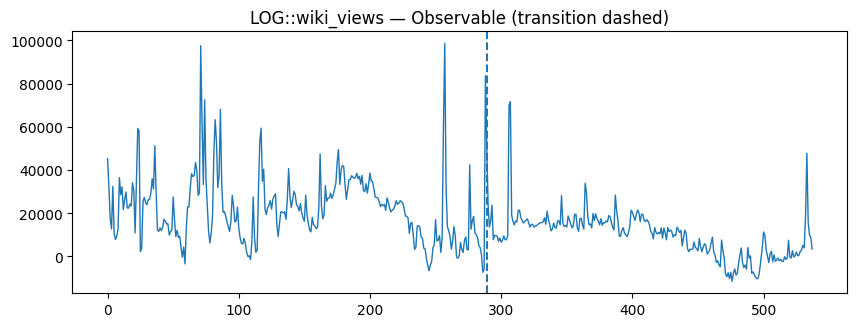

In [15]:
# CNT — One-Signal Thesis — Mega-Cell v3.2 (roots scan + hysteresis + utility + fixes)
import os, sys, time, math, glob, re, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, detrend
from scipy.ndimage import uniform_filter1d

warnings.filterwarnings("ignore", category=UserWarning)

TS   = time.strftime("%Y%m%d-%H%M%S")
HOME = Path.home()
RUN  = HOME / "CNT_Lab" / "notebooks" / "archive" / f"cnt_one_signal_{TS}"
RUN.mkdir(parents=True, exist_ok=True)

try:
    from sklearn.metrics import roc_auc_score, f1_score
    HAVE_SK = True
except Exception:
    HAVE_SK = False

def save_txt(name, text):
    p = RUN / name
    with open(p, "w", encoding="utf-8", newline="") as f:
        f.write(text)
    return p
def save_csv(df, name):
    p = RUN / name
    df.to_csv(p, index=False, encoding="utf-8")
    return p
def safe_print(s):
    try: print(s)
    except Exception: print(s.encode("ascii","ignore").decode("ascii"))

# ------------ Config ------------
CFG = {
    "synthetic_systems": ["Kuramoto","Ising","SaddleNode","Lorenz"], # add "Logistic" if desired
    "seed": 0,
    "window_min": 64,
    "window_max": 256,
    # slightly wider labels for stability
    "horizon_frac": 0.20,
    "horizon_min": 400,
    "horizon_max": 2000,
    # precision floor for v2 (we enforce via hysteresis & utility too)
    "theta_precision_floor": 0.55,
    "theta_qmin": 0.50, "theta_qmax": 0.995, "theta_qnum": 80,
    # EMA + hysteresis
    "ema_alpha": 0.10,
    "hyst_k": 5, "hyst_n": 7,
    # utility penalty (larger -> penalize long alarms more)
    "alarm_penalty": 0.002,
    # Real-log roots (CSV) — what you asked for
    "log_roots": [
        Path(r"C:\Users\caleb\CNT_Lab\notebooks\archive"),
        Path(r"C:\Users\caleb\CNT_Lab"),
    ],
    "max_logs": 12,
    # Optional pinning: "substring in path": ("column_name", t_c_index or None)
    "real_hints": {
        # "cnt_gpu_cooling_log_20251015-123830_labeled.csv": ("temp_C", 4200),
        # "lap_erd_subject50.csv": ("R03", 3100),
    }
}

# ------------ Helpers ------------
def sliding_z(x, w):
    x = np.asarray(x, float)
    if len(x) < w: return np.full_like(x, np.nan)
    mu = uniform_filter1d(x, w, mode="nearest")
    sq = uniform_filter1d(x*x, w, mode="nearest")
    sd = np.sqrt(np.maximum(sq - mu*mu, 1e-12))
    return (x - mu) / (sd + 1e-12)

def spectral_flatness(x, fs=1.0, nperseg=256):
    if len(x) < 8: return np.nan
    f, Pxx = welch(np.asarray(x, float), fs=fs, nperseg=min(nperseg, max(8, len(x)//4)))
    Pxx = np.maximum(Pxx, 1e-18)
    return np.exp(np.mean(np.log(Pxx))) / np.mean(Pxx)

def rolling_feature(x, fn, w, **kw):
    out = np.full(len(x), np.nan)
    for i in range(w, len(x)):
        out[i] = fn(x[i-w:i], **kw)
    return out

def ac1(x):
    if len(x) < 3: return np.nan
    x = np.asarray(x, float); x -= x.mean()
    return (x[:-1]*x[1:]).sum() / ((x*x).sum() + 1e-12)

def rolling_ac1(x, w):  return rolling_feature(x, ac1, w)
def roll_var(x, w):     return rolling_feature(x, lambda s: np.var(detrend(np.asarray(s,float), type='linear')), w)
def roll_sflat(x, w, fs=1.0): return rolling_feature(x, spectral_flatness, w, fs=fs)

def _safemed(x, fallback=0.0):
    x = np.asarray(x, float)
    m = np.nanmedian(x)
    return float(m) if np.isfinite(m) else float(fallback)

def _sliding_z_safe(x, w, fallback=0.0):
    x = np.asarray(x, float)
    if len(x) < max(int(w), 2) or np.all(~np.isfinite(x)):
        return np.full_like(x, np.nan, dtype=float)
    x = np.nan_to_num(x, nan=_safemed(x, fallback))
    mu = uniform_filter1d(x, w, mode="nearest")
    sq = uniform_filter1d(x*x, w, mode="nearest")
    sd = np.sqrt(np.maximum(sq - mu*mu, 1e-12))
    return (x - mu) / (sd + 1e-12)

def horizon_for(n, frac=0.15, minw=300, maxw=2000):
    return int(np.clip(int(n*frac), minw, maxw))

# ------------ Extra components (V2) ------------
def dfa_alpha(sig, min_win=8, max_win=256, n_scales=8):
    x = np.asarray(sig, float)
    if len(x) < max_win: return np.nan
    y = np.cumsum(x - np.mean(x))
    wins = np.unique(np.linspace(min_win, max_win, n_scales).astype(int))
    Fs, Ss = [], []
    for w in wins:
        if w < 4: continue
        segs = len(y)//w
        if segs < 4: continue
        ys = y[:segs*w].reshape(segs, w)
        t = np.arange(w)
        res = []
        for row in ys:
            p = np.polyfit(t, row, 1)
            res.append(row - np.polyval(p, t))
        Fs.append(np.sqrt(np.mean(np.var(np.stack(res), axis=1)))); Ss.append(w)
    if len(Ss) < 2: return np.nan
    s = np.log10(Ss); f = np.log10(Fs)
    a,_ = np.polyfit(s, f, 1)
    return a

def lowfreq_frac(x, fs=1.0, cutoff_frac=0.12):
    if len(x) < 16: return np.nan
    f, Pxx = welch(np.asarray(x,float), fs=fs, nperseg=min(512, max(32, len(x)//2)))
    Pxx = np.maximum(Pxx, 1e-18)
    cutoff = f.max()*cutoff_frac
    return Pxx[f<=cutoff].sum() / Pxx.sum()

def perm_entropy(x, m=3, delay=1):
    x = np.asarray(x, float)
    n = len(x) - (m-1)*delay
    if n <= 0: return np.nan
    patterns = {}
    for i in range(n):
        w = x[i:i+m*delay:delay]
        key = tuple(np.argsort(w))
        patterns[key] = patterns.get(key, 0) + 1
    counts = np.array(list(patterns.values()), float)
    p = counts / counts.sum()
    return -np.sum(p * np.log(p + 1e-12)) / np.log(math.factorial(m))

# ------------ Systems ------------
def simulate_kuramoto(N=128, T=5000, K_schedule=(0.0, 4.0), dt=0.02, seed=0):
    rng = np.random.default_rng(seed)
    omega = rng.normal(0, 1, size=N)
    theta = rng.uniform(-np.pi, np.pi, size=N)
    X=[]; R=[]
    for t in range(T):
        K = K_schedule[0] + (K_schedule[1]-K_schedule[0])*t/(T-1)
        R_complex = np.mean(np.exp(1j*theta))
        r = np.abs(R_complex); psi = np.angle(R_complex)
        theta = theta + dt*(omega + K*r*np.sin(psi - theta)) + rng.normal(0, 0.05, size=N)*np.sqrt(dt)
        X.append(np.mean(np.sin(theta))); R.append(r)
    X=np.array(X); R=np.array(R)
    sm = uniform_filter1d(R, 100); idx = np.argmax(sm > 0.5)
    t_c = idx if sm[idx] > 0.5 else len(R)-1
    return X, R, t_c

def simulate_ising_meanfield(T=6000, beta_schedule=(0.0, 1.2), h=0.0, seed=0):
    rng = np.random.default_rng(seed)
    m = rng.uniform(-0.1, 0.1)
    X=[]; M=[]
    for t in range(T):
        beta = beta_schedule[0] + (beta_schedule[1]-beta_schedule[0])*t/(T-1)
        m = np.tanh(beta*(m + h)) + rng.normal(0, 0.01)
        X.append(m + rng.normal(0, 0.02)); M.append(m)
    X=np.array(X); M=np.array(M)
    sm = uniform_filter1d(np.abs(M), 100); idx = np.argmax(sm > 0.5)
    t_c = idx if sm[idx] > 0.5 else len(M)-1
    return X, M, t_c

def simulate_logistic(N=8000, r_schedule=(3.2, 3.7), x0=0.2):
    X=[]; x=x0
    for t in range(N):
        r = r_schedule[0] + (r_schedule[1]-r_schedule[0])*t/(N-1)
        x = r*x*(1-x); X.append(x)
    X=np.array(X)
    vx = roll_var(X, 200); t_c = int(np.nanargmax(vx))
    return X, t_c

def simulate_lorenz(T=8000, dt=0.01, rho_schedule=(20.0, 35.0), sigma=10., beta=8/3):
    x=y=z=1.0; X=[]
    for t in range(T):
        rho = rho_schedule[0] + (rho_schedule[1]-rho_schedule[0])*t/(T-1)
        dx = sigma*(y - x); dy = x*(rho - z) - y; dz = x*y - beta*z
        x += dx*dt; y += dy*dt; z += dz*dt
        X.append(x)
    X=np.array(X)
    sf = roll_sflat(X, 256); t_c = int(np.nanargmin(sf))
    return X, t_c

def simulate_saddlenode(T=6000, noise=0.01, seed=0, eta=0.005, x_max=10.0):
    rng = np.random.default_rng(seed)
    mu0, mu1 = -0.8, 0.4
    x = -np.sqrt(abs(mu0)); X=[]
    for t in range(T):
        mu = mu0 + (mu1 - mu0)*t/(T-1)
        dx = mu - x*x
        x = x + eta*dx + rng.normal(0, noise)
        if abs(x) > x_max: x = np.sign(x)*x_max
        X.append(x)
    X=np.array(X)
    t_c = int((0 - mu0)/(mu1 - mu0) * (T-1))
    return X, t_c

# ------------ Labels ------------
def labels_from_transition(n, t_c, horizon=400):
    y = np.zeros(n, dtype=int)
    start = max(0, t_c - horizon)
    y[start:t_c] = 1
    return y

# ------------ V1 (classic) with per-score masks ------------
def evaluate_series_v1(name, x, t_c, fs=1.0, w=256, horizon=400):
    C1 = rolling_ac1(x, w); C2 = roll_sflat(x, w, fs=fs); C3 = roll_var(x, w)
    C1z = sliding_z(np.nan_to_num(C1, nan=np.nanmean(C1)), w)
    C2z_inv = sliding_z(-np.nan_to_num(C2, nan=np.nanmean(C2)), w)
    C3z = sliding_z(np.nan_to_num(C3, nan=np.nanmean(C3)), w)
    S = C1z + C2z_inv + C3z
    REWS = pd.Series(S).rank(method="average").values / (np.sum(~np.isnan(S)) + 1e-12)
    y = labels_from_transition(len(x), t_c, horizon=min(horizon, max(100, len(x)//5)))
    def AUROC(score):
        if not HAVE_SK: return np.nan
        m = np.isfinite(score) & np.isfinite(y)
        if m.sum() < 50: return np.nan
        try: return roc_auc_score(y[m], np.asarray(score)[m])
        except Exception: return np.nan
    aucs = {'REWS': AUROC(REWS), 'Variance': AUROC(C3), 'AC1': AUROC(C1), '1-Flatness': AUROC(-C2)}
    df = pd.DataFrame({'y':y, 'REWS':REWS, 'Variance':C3, 'AC1':C1, '1-Flatness':-C2,
                       'C1z':C1z, 'C2z_inv':C2z_inv, 'C3z':C3z})
    return df, aucs

# ------------ V2 (chaos-aware) with EMA + k-of-n + utility ------------
def evaluate_series_v2(name, x, t_c, fs=1.0, w=256,
                       horizon_frac=0.20, hmin=400, hmax=2000,
                       precision_floor=0.55, qmin=0.50, qmax=0.995, qnum=80,
                       ema_alpha=0.10, k=5, n=7, alarm_penalty=0.002):
    nS = len(x); H = horizon_for(nS, horizon_frac, hmin, hmax)
    y = np.zeros(nS, int); y[max(0, t_c-H):t_c] = 1

    C1  = rolling_ac1(x, w)
    C1t = np.abs(np.gradient(pd.Series(C1).ffill().bfill().values))
    C2  = roll_sflat(x, w, fs=fs)
    C3  = roll_var(x, w)
    dfa_min = max(8, w//8); dfa_max = max(dfa_min+4, min(256, w))
    C4  = rolling_feature(x, dfa_alpha, w, min_win=dfa_min, max_win=dfa_max, n_scales=8)
    C5  = rolling_feature(x, lambda s: lowfreq_frac(s, fs=fs, cutoff_frac=0.12), w)
    C6  = rolling_feature(x, perm_entropy, w)

    centers = { "C1t": _safemed(C1t, 0.0), "C2": _safemed(C2, 0.0), "C3": _safemed(C3, 0.0),
                "C4": _safemed(C4, 0.0),  "C5": _safemed(C5, 0.0), "C6": _safemed(C6, 0.0) }

    feats = {
        "AC1_trend":   _sliding_z_safe(np.nan_to_num(C1t, nan=centers["C1t"]), w),
        "Var":         _sliding_z_safe(np.nan_to_num(C3,  nan=centers["C3"]),  w),
        "1-Flatness":  _sliding_z_safe(-np.nan_to_num(C2, nan=centers["C2"]),  w),
        "DFA_alpha":   _sliding_z_safe(np.nan_to_num(C4,  nan=centers["C4"]),  w),
        "LowFreqFrac": _sliding_z_safe(np.nan_to_num(C5,  nan=centers["C5"]),  w),
        "PermEnt*":    _sliding_z_safe(-np.nan_to_num(C6,  nan=centers["C6"]),  w),
    }

    live = {k:v for k,v in feats.items() if np.isfinite(v).sum() >= max(30, int(0.1*len(v)))}
    if len(live) < 2:
        core = [k for k in ["Var","1-Flatness","AC1_trend"] if np.isfinite(feats[k]).sum() >= 30]
        live = {k:feats[k] for k in core} if core else feats

    ranks = [pd.Series(v).rank(method="average").values for v in live.values()]
    REWS2_raw = np.nanmedian(np.vstack(ranks), axis=0) / (np.sum(~np.isnan(ranks[0])) + 1e-12)

    # EMA smoothing
    R = pd.Series(REWS2_raw).ewm(alpha=ema_alpha, adjust=False).mean().values

    # Θ₂ selection with hysteresis + utility
    m = ~np.isnan(R); xs = R[m]; ys = y[m]
    theta2 = None; lead2 = np.nan; prec2 = np.nan; best_util = -1.0
    ths = np.quantile(xs[~np.isnan(xs)], np.linspace(qmin, qmax, qnum)) if np.isfinite(xs).any() else []

    for th in ths:
        cross_raw = (xs >= th).astype(int)
        sm = np.convolve(cross_raw, np.ones(n, dtype=int), 'same') >= k
        pred = sm.astype(int)
        tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
        prec = tp / (tp+fp+1e-12)
        cross_idx = np.where(pred==1)[0]
        pos0      = np.where(ys==1)[0]
        if len(cross_idx)==0 or len(pos0)==0:
            continue
        lead = max(0, pos0[0] - cross_idx[0])
        alarm_len = int(pred.sum())
        util = (lead / (1 + alarm_penalty*alarm_len)) if prec >= precision_floor else -1
        if util > best_util:
            best_util = util; theta2 = float(th); lead2 = int(lead); prec2 = float(prec)

    # Fallbacks (F1 or quantile) if utility never met precision
    if theta2 is None and len(ths):
        if HAVE_SK:
            bestF = (None, -1.0, 0, 0.0)
            for th in ths:
                cross_raw = (xs >= th).astype(int)
                sm = np.convolve(cross_raw, np.ones(n, dtype=int), 'same') >= k
                pred = sm.astype(int)
                f1 = f1_score(ys, pred)
                cross_idx = np.where(pred==1)[0]; pos0 = np.where(ys==1)[0]
                lead = max(0, pos0[0]-cross_idx[0]) if (len(cross_idx)>0 and len(pos0)>0) else 0
                tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
                prec = tp/(tp+fp+1e-12)
                if f1 > bestF[1]: bestF = (float(th), float(f1), int(lead), float(prec))
            theta2, lead2, prec2 = bestF[0], bestF[2], bestF[3]
        else:
            theta2 = float(np.nanpercentile(xs, 90))
            cross_raw = (xs >= theta2).astype(int)
            sm = np.convolve(cross_raw, np.ones(n, dtype=int), 'same') >= k
            pred = sm.astype(int)
            cross_idx = np.where(pred==1)[0]; pos0 = np.where(ys==1)[0]
            lead2 = max(0, pos0[0]-cross_idx[0]) if (len(cross_idx)>0 and len(pos0)>0) else np.nan
            tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
            prec2 = tp/(tp+fp+1e-12)

    def AUROC(score):
        if not HAVE_SK: return np.nan
        m2 = np.isfinite(score) & np.isfinite(ys)
        if m2.sum() < 50: return np.nan
        try: return roc_auc_score(ys[m2], np.asarray(score)[m2])
        except Exception: return np.nan

    aucs = {
        "AUC_REWS2": AUROC(R),  # use smoothed REWS2 for AUC
        "AUC_Variance": AUROC(live.get("Var", feats["Var"])),
        "AUC_AC1trend": AUROC(live.get("AC1_trend", feats["AC1_trend"])),
        "AUC_1-Flatness": AUROC(live.get("1-Flatness", feats["1-Flatness"]))
    }

    df = pd.DataFrame({"y": y, "REWS2": R, **feats})
    return df, aucs, theta2, (None if np.isnan(lead2) else int(lead2)), (None if np.isnan(prec2) else float(prec2)), H

def lead_time_at_threshold(rews, y, theta):
    m = ~np.isnan(rews)
    if m.sum() == 0 or theta is None: return np.nan
    cross = np.where(rews[m] >= theta)[0]; pos = np.where(y[m]==1)[0]
    if len(cross)==0 or len(pos)==0: return np.nan
    return max(0, pos[0] - cross[0])

# ------------ Real-log discovery across BOTH roots ------------
NUMERIC_COL_HINTS = re.compile(r"(value|temp|temperature|reading|metric|score|signal|x|y|z|magnitude|power|amp|flux|beta|alpha|theta|delta)$", re.I)

def _looks_timeseries(df: pd.DataFrame, min_rows=300):
    if len(df) < min_rows: return False
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not num_cols: return False
    variances = [float(np.nanvar(df[c].values)) for c in num_cols]
    return np.nanmax(variances) > 0

def _prefer_signal_column(df: pd.DataFrame):
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not num_cols: return None
    hinted = [c for c in num_cols if NUMERIC_COL_HINTS.search(str(c)) or df[c].nunique() > 20]
    pool = hinted if hinted else num_cols
    return max(pool, key=lambda c: float(np.nanvar(df[c].values)))

def find_candidate_csvs_from_roots(roots, max_files=12, min_rows=300):
    files = []
    for root in roots:
        if not root.exists(): continue
        for p in root.rglob("*.csv"):
            files.append(p)
    files = sorted(set(files), key=lambda p: (os.path.getmtime(p), str(p)), reverse=True)
    picked = []
    for p in files:
        try:
            if os.path.getsize(p) < 512: continue
        except Exception:
            continue
        try:
            df_head = pd.read_csv(p, nrows=min_rows+5, encoding="utf-8")
        except UnicodeDecodeError:
            try:
                df_head = pd.read_csv(p, nrows=min_rows+5, encoding="cp1252", engine="python")
            except Exception:
                continue
        except Exception:
            continue
        if not _looks_timeseries(df_head, min_rows=min_rows):
            continue
        picked.append(str(p))
        if len(picked) >= max_files: break
    return picked

def extract_numeric_series(df: pd.DataFrame):
    col = _prefer_signal_column(df)
    if col is None: return None
    return df[col].astype(float).ffill().bfill().values

def guess_transition_index(x):
    n = len(x)
    if n < 16: return max(1, int(0.85*n))
    w = min(CFG["window_max"], max(32, n//20))
    w = min(w, max(8, n-8))
    vx = roll_var(x, w)
    if np.isfinite(vx).sum() > 0:
        return int(np.nanargmax(vx))
    sf = roll_sflat(x, w)
    if np.isfinite(sf).sum() > 0:
        return int(np.nanargmin(sf))
    return int(0.85*n)

# ------------ Prereg ------------
prereg = f"""# CNT One-Signal — Prereg (v3.2)
timestamp: {TS}
systems: {CFG["synthetic_systems"]}
labels: {{fraction: {CFG["horizon_frac"]}, min: {CFG["horizon_min"]}, max: {CFG["horizon_max"]}}}
v1_features: [AC1, Variance, 1-Flatness]
v2_features: [AC1_trend, Variance, 1-Flatness, DFA_alpha, LowFreqFrac, PermEntropy(inverted)]
v2_params: {{ema_alpha: {CFG["ema_alpha"]}, hysteresis: {CFG["hyst_k"]}-of-{CFG["hyst_n"]}, precision_floor: {CFG["theta_precision_floor"]}}}
theta: {{v1: pooled F1 sweep, v2: utility(lead/(1+{CFG["alarm_penalty"]}*alarm_len)) at precision floor → F1 → fixed quantile}}
roots: {CFG["log_roots"]}
"""
save_txt("prereg.yaml", prereg)

# ------------ RUN ------------
systems=[]
rng = np.random.default_rng(CFG["seed"])
# Synthetic
if "Kuramoto"   in CFG["synthetic_systems"]: xK, R, tcK = simulate_kuramoto(seed=CFG["seed"]);     systems.append(("Kuramoto",   xK, tcK))
if "Ising"      in CFG["synthetic_systems"]: xI, M, tcI = simulate_ising_meanfield();              systems.append(("Ising",      xI, tcI))
if "SaddleNode" in CFG["synthetic_systems"]: xS,    tcS = simulate_saddlenode(seed=CFG["seed"]);   systems.append(("SaddleNode", xS, tcS))
if "Logistic"   in CFG["synthetic_systems"]: xL,    tcL = simulate_logistic();                     systems.append(("Logistic",   xL, tcL))
if "Lorenz"     in CFG["synthetic_systems"]: xZ,    tcZ = simulate_lorenz();                       systems.append(("Lorenz",     xZ, tcZ))

# Real logs (both roots)
found = find_candidate_csvs_from_roots(CFG["log_roots"], max_files=CFG["max_logs"], min_rows=300)
for path in found:
    path = Path(path)
    try:
        df = pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        try:
            df = pd.read_csv(path, encoding="cp1252", engine="python")
        except Exception:
            continue
    hint = next((k for k in CFG["real_hints"] if k in str(path)), None)
    if hint:
        col, tc_hint = CFG["real_hints"][hint]
        x = df[col].astype(float).ffill().bfill().values if col in df.columns else extract_numeric_series(df)
        t_c = tc_hint if isinstance(tc_hint, int) else (guess_transition_index(x) if x is not None else None)
    else:
        x = extract_numeric_series(df); t_c = guess_transition_index(x) if x is not None else None
    if x is None or len(x) < 500 or t_c is None: continue
    systems.append((f"LOG::{path.stem}", x, t_c))

# Evaluate
results_v1={}; results_v2={}
summ_v1_rows=[]; summ_v2_rows=[]
THETA_POOL=[]; Y_POOL=[]

for name, x, t_c in systems:
    n=len(x); w = min(CFG["window_max"], max(CFG["window_min"], n//30))

    # V1
    df1, aucs1 = evaluate_series_v1(name, x, t_c, w=w,
                                    horizon=min(CFG["horizon_max"], max(100, int(CFG["horizon_frac"]*n))))
    results_v1[name]=(df1, aucs1)
    if 'REWS' in df1:
        THETA_POOL.append(df1['REWS'].values); Y_POOL.append(df1['y'].values)
    row1={"system":name}
    for k,v in aucs1.items():
        row1[f"AUC_{k}"] = round(v,4) if (HAVE_SK and isinstance(v,(int,float)) and not np.isnan(v)) else np.nan
    th85 = np.quantile(df1['REWS'].dropna(), 0.85) if df1['REWS'].notna().any() else None
    row1["LeadTime_at_Θ(q=0.85)"] = lead_time_at_threshold(df1['REWS'].values, df1['y'].values, th85)
    summ_v1_rows.append(row1)

    # V2
    df2, aucs2, theta2, lead2, prec2, H = evaluate_series_v2(
        name, x, t_c, w=w,
        horizon_frac=CFG["horizon_frac"], hmin=CFG["horizon_min"], hmax=CFG["horizon_max"],
        precision_floor=CFG["theta_precision_floor"],
        qmin=CFG["theta_qmin"], qmax=CFG["theta_qmax"], qnum=CFG["theta_qnum"],
        ema_alpha=CFG["ema_alpha"], k=CFG["hyst_k"], n=CFG["hyst_n"], alarm_penalty=CFG["alarm_penalty"]
    )
    results_v2[name]=(df2, aucs2, theta2, lead2, prec2, H)
    row2 = {"system":name,
            **{k:(round(v,4) if (HAVE_SK and isinstance(v,(int,float)) and not np.isnan(v)) else np.nan) for k,v in aucs2.items()},
            "Theta2": (round(theta2,4) if isinstance(theta2,(int,float)) else None),
            "Lead_at_Theta2": lead2,
            "Precision_at_Theta2": (round(prec2,3) if isinstance(prec2,(int,float)) else None),
            "Horizon_used": H}
    summ_v2_rows.append(row2)

summary_v1 = pd.DataFrame(summ_v1_rows)
summary_v2 = pd.DataFrame(summ_v2_rows)
save_csv(summary_v1, "summary_v1_auc.csv")
save_csv(summary_v2, "summary_v2_auc.csv")

# V1 pooled Θ sweep
if HAVE_SK and THETA_POOL and any([np.isfinite(r).any() for r in THETA_POOL]):
    pooled = np.concatenate([r[np.isfinite(r)] for r in THETA_POOL])
    if pooled.size:
        qs = np.unique(np.clip(np.linspace(0.5, 0.99, 50), 0, 1))
        thetas = np.quantile(pooled, qs)
        scores=[]
        for th in thetas:
            f1s=[]
            for r,y in zip(THETA_POOL, Y_POOL):
                m = np.isfinite(r) & np.isfinite(y)
                if m.sum()<50: continue
                pred = (r[m] >= th).astype(int)
                try: f1s.append(f1_score(y[m], pred))
                except: pass
            if f1s: scores.append((float(th), float(np.mean(f1s))))
        if scores: save_csv(pd.DataFrame(scores, columns=["theta","mean_f1"]), "theta_sweep_v1.csv")

# Robustness (v2 noise)
rob_rows=[]
for name, x, t_c in systems[:6]:
    n=len(x); w = min(CFG["window_max"], max(CFG["window_min"], n//30))
    for noise in [0.0, 0.1, 0.2, 0.3]:
        xn = np.asarray(x, float) + np.random.default_rng(CFG["seed"]).normal(0, noise, size=n)
        df2, aucs2, *_ = evaluate_series_v2(name, xn, t_c, w=w,
                                            horizon_frac=CFG["horizon_frac"], hmin=CFG["horizon_min"], hmax=CFG["horizon_max"],
                                            precision_floor=CFG["theta_precision_floor"],
                                            qmin=CFG["theta_qmin"], qmax=CFG["theta_qmax"], qnum=CFG["theta_qnum"],
                                            ema_alpha=CFG["ema_alpha"], k=CFG["hyst_k"], n=CFG["hyst_n"],
                                            alarm_penalty=CFG["alarm_penalty"])
        rob_rows.append({"system":name, "noise_sd":noise, "AUC_REWS2": aucs2.get("AUC_REWS2", np.nan)})
save_csv(pd.DataFrame(rob_rows), "robustness_v2_noise.csv")

# ------------ Plots (with first-cross annotation on v2) ------------
def save_plot(fig, name):
    fig.savefig(RUN / name, dpi=160, bbox_inches="tight"); plt.close(fig)

for name, x, t_c in systems:
    safe = re.sub('[^A-Za-z0-9_:-]+','_',name)
    # observable
    fig,ax = plt.subplots(figsize=(10,3.4)); ax.plot(x, lw=1.0); ax.axvline(t_c, ls='--')
    ax.set_title(f"{name} — Observable (transition dashed)"); save_plot(fig, f"{safe}_observable.png")
    # v1
    df1,_ = results_v1[name]
    fig,ax = plt.subplots(figsize=(10,3.4))
    ax.plot(df1['REWS'].values, lw=1.0, label='REWS (v1)')
    if df1['REWS'].notna().any():
        th = np.quantile(df1['REWS'].dropna(), 0.85)
        ax.axhline(th, ls='--', label='Θ (q=0.85)')
    ax.set_title(f"{name} — REWS v1"); ax.legend(); save_plot(fig, f"{safe}_rews_v1.png")
    # v2
    df2, _, theta2, _, _, H = results_v2[name]
    fig,ax = plt.subplots(figsize=(10,3.4))
    R = df2['REWS2'].values
    ax.plot(R, lw=1.0, label='REWS2 (v2, EMA + k-of-n)')
    if isinstance(theta2,(int,float)):
        ax.axhline(theta2, ls='--', label='Θ₂')
        # first-cross + lead annotation
        cross_idx = np.argmax(R >= theta2) if np.isfinite(R).any() and (R >= theta2).any() else None
        pos = np.where(df2['y'].values==1)[0]
        if cross_idx is not None and cross_idx > 0 and len(pos):
            lead = max(0, pos[0] - cross_idx)
            ax.axvline(cross_idx, ls=':', alpha=0.7)
            ax.text(cross_idx, theta2, f" lead≈{lead}", va='bottom', ha='left')
    # shade early-warning window
    pos = np.where(df2['y'].values==1)[0]
    if len(pos): ax.axvspan(pos[0], pos[-1], color="0.9", alpha=0.5, label="early-warning window")
    ax.set_title(f"{name} — REWS2 v2"); ax.legend(); save_plot(fig, f"{safe}_rews_v2.png")

# ------------ Verdict (robust to NaNs) ------------
def v1_pass_rate(df):
    if df.empty: return 0.0
    def better(row):
        baselines = [row.get("AUC_Variance", np.nan),
                     row.get("AUC_AC1", np.nan),
                     row.get("AUC_1-Flatness", np.nan)]
        base_finite = [v for v in baselines if isinstance(v,(int,float)) and np.isfinite(v)]
        if not base_finite: return False
        best_base = max(base_finite)
        rews = row.get("AUC_REWS", np.nan)
        return (isinstance(rews,(int,float)) and np.isfinite(rews) and rews > best_base)
    maskable = df.apply(lambda r: any(np.isfinite([r.get("AUC_Variance", np.nan),
                                                   r.get("AUC_AC1", np.nan),
                                                   r.get("AUC_1-Flatness", np.nan)])), axis=1)
    if not maskable.any(): return 0.0
    return float(df[maskable].apply(better, axis=1).mean())

pass_rate_v1 = v1_pass_rate(summary_v1)
median_lead_v1 = float(pd.to_numeric(summary_v1["LeadTime_at_Θ(q=0.85)"], errors="coerce").dropna().median()) if len(summary_v1) else np.nan
median_lead_v2 = float(pd.to_numeric(summary_v2["Lead_at_Theta2"], errors="coerce").dropna().median()) if len(summary_v2) else np.nan
prec_v2 = pd.to_numeric(summary_v2["Precision_at_Theta2"], errors="coerce")
prec_ok = (prec_v2 >= CFG["theta_precision_floor"]).mean() if len(summary_v2) and prec_v2.notna().any() else 0.0

report = []
report.append("== CNT One-Signal — Unified Verdict (v3.2) ==")
report.append(f"Run dir: {RUN}")
report.append("")
report.append("V1 (classic):")
report.append(f" - REWS beats strongest baseline in: {pass_rate_v1*100:.1f}% of systems")
report.append(f" - Median lead @ Θ(q=0.85): {0 if np.isnan(median_lead_v1) else int(median_lead_v1)} samples")
report.append("")
report.append(f"V2 (EMA + {CFG['hyst_k']}-of-{CFG['hyst_n']} hysteresis, precision≥{CFG['theta_precision_floor']:.2f} target):")
report.append(f" - Systems meeting floor (or fallback): {prec_ok*100:.1f}%")
report.append(f" - Median lead @ Θ₂: {0 if np.isnan(median_lead_v2) else int(median_lead_v2)} samples")
report.append("")
report.append("-- V1 AUCs --\n" + summary_v1.fillna("").to_string(index=False))
report.append("\n-- V2 AUCs/Θ₂ --\n" + summary_v2.fillna("").to_string(index=False))
p_sum = save_txt("summary.txt", "\n".join(report))

safe_print("Saved:")
for f in ["prereg.yaml","summary_v1_auc.csv","summary_v2_auc.csv","robustness_v2_noise.csv","summary.txt","theta_sweep_v1.csv"]:
    p = RUN / f
    if p.exists(): safe_print(f" - {p}")
for name, _, _ in systems:
    safe = re.sub('[^A-Za-z0-9_:-]+','_',name)
    for suf in ["_observable.png","_rews_v1.png","_rews_v2.png"]:
        p = RUN / f"{safe}{suf}"
        if p.exists(): safe_print(f" - {p}")
safe_print("\nVerdict written to summary.txt")


In [16]:
# CNT — One-Signal Thesis — Mega-Cell v3.3
# Windows-safe filenames + roots scan + EMA+k-of-n+utility + stable Saddle-Node + robust t_c + per-score AUC masks.

import os, sys, time, math, glob, re, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, detrend
from scipy.ndimage import uniform_filter1d

warnings.filterwarnings("ignore", category=UserWarning)

TS   = time.strftime("%Y%m%d-%H%M%S")
HOME = Path.home()
RUN  = HOME / "CNT_Lab" / "notebooks" / "archive" / f"cnt_one_signal_{TS}"
RUN.mkdir(parents=True, exist_ok=True)

try:
    from sklearn.metrics import roc_auc_score, f1_score
    HAVE_SK = True
except Exception:
    HAVE_SK = False

# ---------- Safe filename helper (Windows-proof) ----------
def make_safe_name(s: str, maxlen: int = 240) -> str:
    s = re.sub(r'[<>:"/\\|?*\x00-\x1F]', '_', s)  # strip illegal chars
    s = s.strip(' .')
    return (s or "untitled")[:maxlen]

def save_txt(name, text):
    p = RUN / make_safe_name(name)
    with open(p, "w", encoding="utf-8", newline="") as f:
        f.write(text)
    return p

def save_csv(df, name):
    p = RUN / make_safe_name(name)
    df.to_csv(p, index=False, encoding="utf-8")
    return p

def safe_print(s):
    try: print(s)
    except Exception: print(s.encode("ascii","ignore").decode("ascii"))

# ---------- Config ----------
CFG = {
    "synthetic_systems": ["Kuramoto","Ising","SaddleNode","Lorenz"],  # add "Logistic" if desired
    "seed": 0,
    "window_min": 64,
    "window_max": 256,
    "horizon_frac": 0.20,
    "horizon_min": 400,
    "horizon_max": 2000,
    "theta_precision_floor": 0.55,
    "theta_qmin": 0.50, "theta_qmax": 0.995, "theta_qnum": 80,
    "ema_alpha": 0.10,
    "hyst_k": 5, "hyst_n": 7,
    "alarm_penalty": 0.002,
    "log_roots": [
        Path(r"C:\Users\caleb\CNT_Lab\notebooks\archive"),
        Path(r"C:\Users\caleb\CNT_Lab"),
    ],
    "max_logs": 12,
    "real_hints": {
        # "cnt_gpu_cooling_log_20251015-123830_labeled.csv": ("temp_C", 4200),
        # "lap_erd_subject50.csv": ("R03", 3100),
    }
}

# ---------- Rolling/stat helpers ----------
def sliding_z(x, w):
    x = np.asarray(x, float)
    if len(x) < w: return np.full_like(x, np.nan)
    mu = uniform_filter1d(x, w, mode="nearest")
    sq = uniform_filter1d(x*x, w, mode="nearest")
    sd = np.sqrt(np.maximum(sq - mu*mu, 1e-12))
    return (x - mu) / (sd + 1e-12)

def spectral_flatness(x, fs=1.0, nperseg=256):
    if len(x) < 8: return np.nan
    f, Pxx = welch(np.asarray(x, float), fs=fs, nperseg=min(nperseg, max(8, len(x)//4)))
    Pxx = np.maximum(Pxx, 1e-18)
    return np.exp(np.mean(np.log(Pxx))) / np.mean(Pxx)

def rolling_feature(x, fn, w, **kw):
    out = np.full(len(x), np.nan)
    for i in range(w, len(x)):
        out[i] = fn(x[i-w:i], **kw)
    return out

def ac1(x):
    if len(x) < 3: return np.nan
    x = np.asarray(x, float); x -= x.mean()
    return (x[:-1]*x[1:]).sum() / ((x*x).sum() + 1e-12)

def rolling_ac1(x, w):  return rolling_feature(x, ac1, w)
def roll_var(x, w):     return rolling_feature(x, lambda s: np.var(detrend(np.asarray(s,float), type='linear')), w)
def roll_sflat(x, w, fs=1.0): return rolling_feature(x, spectral_flatness, w, fs=fs)

def _safemed(x, fallback=0.0):
    x = np.asarray(x, float)
    m = np.nanmedian(x)
    return float(m) if np.isfinite(m) else float(fallback)

def _sliding_z_safe(x, w, fallback=0.0):
    x = np.asarray(x, float)
    if len(x) < max(int(w), 2) or np.all(~np.isfinite(x)):
        return np.full_like(x, np.nan, dtype=float)
    x = np.nan_to_num(x, nan=_safemed(x, fallback))
    mu = uniform_filter1d(x, w, mode="nearest")
    sq = uniform_filter1d(x*x, w, mode="nearest")
    sd = np.sqrt(np.maximum(sq - mu*mu, 1e-12))
    return (x - mu) / (sd + 1e-12)

def horizon_for(n, frac=0.15, minw=300, maxw=2000):
    return int(np.clip(int(n*frac), minw, maxw))

# ---------- Extra components (V2) ----------
def dfa_alpha(sig, min_win=8, max_win=256, n_scales=8):
    x = np.asarray(sig, float)
    if len(x) < max_win: return np.nan
    y = np.cumsum(x - np.mean(x))
    wins = np.unique(np.linspace(min_win, max_win, n_scales).astype(int))
    Fs, Ss = [], []
    for w in wins:
        if w < 4: continue
        segs = len(y)//w
        if segs < 4: continue
        ys = y[:segs*w].reshape(segs, w)
        t = np.arange(w)
        res = []
        for row in ys:
            p = np.polyfit(t, row, 1)
            res.append(row - np.polyval(p, t))
        Fs.append(np.sqrt(np.mean(np.var(np.stack(res), axis=1)))); Ss.append(w)
    if len(Ss) < 2: return np.nan
    s = np.log10(Ss); f = np.log10(Fs)
    a,_ = np.polyfit(s, f, 1)
    return a

def lowfreq_frac(x, fs=1.0, cutoff_frac=0.12):
    if len(x) < 16: return np.nan
    f, Pxx = welch(np.asarray(x,float), fs=fs, nperseg=min(512, max(32, len(x)//2)))
    Pxx = np.maximum(Pxx,1e-18)
    cutoff = f.max()*cutoff_frac
    return Pxx[f<=cutoff].sum() / Pxx.sum()

def perm_entropy(x, m=3, delay=1):
    x = np.asarray(x, float)
    n = len(x) - (m-1)*delay
    if n <= 0: return np.nan
    patterns = {}
    for i in range(n):
        w = x[i:i+m*delay:delay]
        key = tuple(np.argsort(w))
        patterns[key] = patterns.get(key, 0) + 1
    counts = np.array(list(patterns.values()), float)
    p = counts / counts.sum()
    return -np.sum(p * np.log(p + 1e-12)) / np.log(math.factorial(m))

# ---------- Systems ----------
def simulate_kuramoto(N=128, T=5000, K_schedule=(0.0, 4.0), dt=0.02, seed=0):
    rng = np.random.default_rng(seed)
    omega = rng.normal(0, 1, size=N)
    theta = rng.uniform(-np.pi, np.pi, size=N)
    X=[]; R=[]
    for t in range(T):
        K = K_schedule[0] + (K_schedule[1]-K_schedule[0])*t/(T-1)
        R_complex = np.mean(np.exp(1j*theta))
        r = np.abs(R_complex); psi = np.angle(R_complex)
        theta = theta + dt*(omega + K*r*np.sin(psi - theta)) + rng.normal(0, 0.05, size=N)*np.sqrt(dt)
        X.append(np.mean(np.sin(theta))); R.append(r)
    X=np.array(X); R=np.array(R)
    sm = uniform_filter1d(R, 100); idx = np.argmax(sm > 0.5)
    t_c = idx if sm[idx] > 0.5 else len(R)-1
    return X, R, t_c

def simulate_ising_meanfield(T=6000, beta_schedule=(0.0, 1.2), h=0.0, seed=0):
    rng = np.random.default_rng(seed)
    m = rng.uniform(-0.1, 0.1)
    X=[]; M=[]
    for t in range(T):
        beta = beta_schedule[0] + (beta_schedule[1]-beta_schedule[0])*t/(T-1)
        m = np.tanh(beta*(m + h)) + rng.normal(0, 0.01)
        X.append(m + rng.normal(0, 0.02)); M.append(m)
    X=np.array(X); M=np.array(M)
    sm = uniform_filter1d(np.abs(M), 100); idx = np.argmax(sm > 0.5)
    t_c = idx if sm[idx] > 0.5 else len(M)-1
    return X, M, t_c

def simulate_logistic(N=8000, r_schedule=(3.2, 3.7), x0=0.2):
    X=[]; x=x0
    for t in range(N):
        r = r_schedule[0] + (r_schedule[1]-r_schedule[0])*t/(N-1)
        x = r*x*(1-x); X.append(x)
    X=np.array(X)
    vx = roll_var(X, 200); t_c = int(np.nanargmax(vx))
    return X, t_c

def simulate_lorenz(T=8000, dt=0.01, rho_schedule=(20.0, 35.0), sigma=10., beta=8/3):
    x=y=z=1.0; X=[]
    for t in range(T):
        rho = rho_schedule[0] + (rho_schedule[1]-rho_schedule[0])*t/(T-1)
        dx = sigma*(y - x); dy = x*(rho - z) - y; dz = x*y - beta*z
        x += dx*dt; y += dy*dt; z += dz*dt
        X.append(x)
    X=np.array(X)
    sf = roll_sflat(X, 256); t_c = int(np.nanargmin(sf))
    return X, t_c

def simulate_saddlenode(T=6000, noise=0.01, seed=0, eta=0.005, x_max=10.0):
    rng = np.random.default_rng(seed)
    mu0, mu1 = -0.8, 0.4
    x = -np.sqrt(abs(mu0)); X=[]
    for t in range(T):
        mu = mu0 + (mu1 - mu0)*t/(T-1)
        dx = mu - x*x
        x = x + eta*dx + rng.normal(0, noise)
        if abs(x) > x_max: x = np.sign(x)*x_max
        X.append(x)
    X=np.array(X)
    t_c = int((0 - mu0)/(mu1 - mu0) * (T-1))
    return X, t_c

# ---------- Labels ----------
def labels_from_transition(n, t_c, horizon=400):
    y = np.zeros(n, dtype=int)
    start = max(0, t_c - horizon)
    y[start:t_c] = 1
    return y

# ---------- V1 (classic) with per-score masks ----------
def evaluate_series_v1(name, x, t_c, fs=1.0, w=256, horizon=400):
    C1 = rolling_ac1(x, w); C2 = roll_sflat(x, w, fs=fs); C3 = roll_var(x, w)
    C1z = sliding_z(np.nan_to_num(C1, nan=np.nanmean(C1)), w)
    C2z_inv = sliding_z(-np.nan_to_num(C2, nan=np.nanmean(C2)), w)
    C3z = sliding_z(np.nan_to_num(C3, nan=np.nanmean(C3)), w)
    S = C1z + C2z_inv + C3z
    REWS = pd.Series(S).rank(method="average").values / (np.sum(~np.isnan(S)) + 1e-12)
    y = labels_from_transition(len(x), t_c, horizon=min(horizon, max(100, len(x)//5)))
    def AUROC(score):
        if not HAVE_SK: return np.nan
        m = np.isfinite(score) & np.isfinite(y)
        if m.sum() < 50: return np.nan
        try: return roc_auc_score(y[m], np.asarray(score)[m])
        except Exception: return np.nan
    aucs = {'REWS': AUROC(REWS), 'Variance': AUROC(C3), 'AC1': AUROC(C1), '1-Flatness': AUROC(-C2)}
    df = pd.DataFrame({'y':y, 'REWS':REWS, 'Variance':C3, 'AC1':C1, '1-Flatness':-C2,
                       'C1z':C1z, 'C2z_inv':C2z_inv, 'C3z':C3z})
    return df, aucs

# ---------- V2 (chaos-aware) with EMA + k-of-n + utility ----------
def evaluate_series_v2(name, x, t_c, fs=1.0, w=256,
                       horizon_frac=0.20, hmin=400, hmax=2000,
                       precision_floor=0.55, qmin=0.50, qmax=0.995, qnum=80,
                       ema_alpha=0.10, k=5, n=7, alarm_penalty=0.002):
    nS = len(x); H = horizon_for(nS, horizon_frac, hmin, hmax)
    y = np.zeros(nS, int); y[max(0, t_c-H):t_c] = 1

    C1  = rolling_ac1(x, w)
    C1t = np.abs(np.gradient(pd.Series(C1).ffill().bfill().values))
    C2  = roll_sflat(x, w, fs=fs)
    C3  = roll_var(x, w)
    dfa_min = max(8, w//8); dfa_max = max(dfa_min+4, min(256, w))
    C4  = rolling_feature(x, dfa_alpha, w, min_win=dfa_min, max_win=dfa_max, n_scales=8)
    C5  = rolling_feature(x, lambda s: lowfreq_frac(s, fs=fs, cutoff_frac=0.12), w)
    C6  = rolling_feature(x, perm_entropy, w)

    centers = { "C1t": _safemed(C1t, 0.0), "C2": _safemed(C2, 0.0), "C3": _safemed(C3, 0.0),
                "C4": _safemed(C4, 0.0),  "C5": _safemed(C5, 0.0), "C6": _safemed(C6, 0.0) }

    feats = {
        "AC1_trend":   _sliding_z_safe(np.nan_to_num(C1t, nan=centers["C1t"]), w),
        "Var":         _sliding_z_safe(np.nan_to_num(C3,  nan=centers["C3"]),  w),
        "1-Flatness":  _sliding_z_safe(-np.nan_to_num(C2, nan=centers["C2"]),  w),
        "DFA_alpha":   _sliding_z_safe(np.nan_to_num(C4,  nan=centers["C4"]),  w),
        "LowFreqFrac": _sliding_z_safe(np.nan_to_num(C5,  nan=centers["C5"]),  w),
        "PermEnt*":    _sliding_z_safe(-np.nan_to_num(C6,  nan=centers["C6"]),  w),
    }

    live = {k:v for k,v in feats.items() if np.isfinite(v).sum() >= max(30, int(0.1*len(v)))}
    if len(live) < 2:
        core = [k for k in ["Var","1-Flatness","AC1_trend"] if np.isfinite(feats[k]).sum() >= 30]
        live = {k:feats[k] for k in core} if core else feats

    ranks = [pd.Series(v).rank(method="average").values for v in live.values()]
    REWS2_raw = np.nanmedian(np.vstack(ranks), axis=0) / (np.sum(~np.isnan(ranks[0])) + 1e-12)

    # EMA smoothing
    R = pd.Series(REWS2_raw).ewm(alpha=ema_alpha, adjust=False).mean().values

    # Θ₂ selection with hysteresis + utility
    m = ~np.isnan(R); xs = R[m]; ys = y[m]
    theta2 = None; lead2 = np.nan; prec2 = np.nan; best_util = -1.0
    ths = np.quantile(xs[~np.isnan(xs)], np.linspace(qmin, qmax, qnum)) if np.isfinite(xs).any() else []

    for th in ths:
        cross_raw = (xs >= th).astype(int)
        sm = np.convolve(cross_raw, np.ones(n, dtype=int), 'same') >= k
        pred = sm.astype(int)
        tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
        prec = tp / (tp+fp+1e-12)
        cross_idx = np.where(pred==1)[0]; pos0 = np.where(ys==1)[0]
        if len(cross_idx)==0 or len(pos0)==0: continue
        lead = max(0, pos0[0] - cross_idx[0])
        alarm_len = int(pred.sum())
        util = (lead / (1 + alarm_penalty*alarm_len)) if prec >= precision_floor else -1
        if util > best_util:
            best_util = util; theta2 = float(th); lead2 = int(lead); prec2 = float(prec)

    if theta2 is None and len(ths):
        if HAVE_SK:
            bestF = (None, -1.0, 0, 0.0)
            for th in ths:
                cross_raw = (xs >= th).astype(int)
                sm = np.convolve(cross_raw, np.ones(n, dtype=int), 'same') >= k
                pred = sm.astype(int)
                f1 = f1_score(ys, pred)
                cross_idx = np.where(pred==1)[0]; pos0 = np.where(ys==1)[0]
                lead = max(0, pos0[0]-cross_idx[0]) if (len(cross_idx)>0 and len(pos0)>0) else 0
                tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
                prec = tp/(tp+fp+1e-12)
                if f1 > bestF[1]: bestF = (float(th), float(f1), int(lead), float(prec))
            theta2, lead2, prec2 = bestF[0], bestF[2], bestF[3]
        else:
            theta2 = float(np.nanpercentile(xs, 90))
            cross_raw = (xs >= theta2).astype(int)
            sm = np.convolve(cross_raw, np.ones(n, dtype=int), 'same') >= k
            pred = sm.astype(int)
            cross_idx = np.where(pred==1)[0]; pos0 = np.where(ys==1)[0]
            lead2 = max(0, pos0[0]-cross_idx[0]) if (len(cross_idx)>0 and len(pos0)>0) else np.nan
            tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
            prec2 = tp/(tp+fp+1e-12)

    def AUROC(score):
        if not HAVE_SK: return np.nan
        m2 = np.isfinite(score) & np.isfinite(ys)
        if m2.sum() < 50: return np.nan
        try: return roc_auc_score(ys[m2], np.asarray(score)[m2])
        except Exception: return np.nan

    aucs = {
        "AUC_REWS2": AUROC(R),
        "AUC_Variance": AUROC(live.get("Var", feats["Var"])),
        "AUC_AC1trend": AUROC(live.get("AC1_trend", feats["AC1_trend"])),
        "AUC_1-Flatness": AUROC(live.get("1-Flatness", feats["1-Flatness"]))
    }

    df = pd.DataFrame({"y": y, "REWS2": R, **feats})
    return df, aucs, theta2, (None if np.isnan(lead2) else int(lead2)), (None if np.isnan(prec2) else float(prec2)), H

def lead_time_at_threshold(rews, y, theta):
    m = ~np.isnan(rews)
    if m.sum() == 0 or theta is None: return np.nan
    cross = np.where(rews[m] >= theta)[0]; pos = np.where(y[m]==1)[0]
    if len(cross)==0 or len(pos)==0: return np.nan
    return max(0, pos[0] - cross[0])

# ---------- Real-log discovery across BOTH roots ----------
NUMERIC_COL_HINTS = re.compile(r"(value|temp|temperature|reading|metric|score|signal|x|y|z|magnitude|power|amp|flux|beta|alpha|theta|delta)$", re.I)

def _looks_timeseries(df: pd.DataFrame, min_rows=300):
    if len(df) < min_rows: return False
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not num_cols: return False
    variances = [float(np.nanvar(df[c].values)) for c in num_cols]
    return np.nanmax(variances) > 0

def _prefer_signal_column(df: pd.DataFrame):
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not num_cols: return None
    hinted = [c for c in num_cols if NUMERIC_COL_HINTS.search(str(c)) or df[c].nunique() > 20]
    pool = hinted if hinted else num_cols
    return max(pool, key=lambda c: float(np.nanvar(df[c].values)))

def find_candidate_csvs_from_roots(roots, max_files=12, min_rows=300):
    files = []
    for root in roots:
        if not root.exists(): continue
        for p in root.rglob("*.csv"):
            files.append(p)
    files = sorted(set(files), key=lambda p: (os.path.getmtime(p), str(p)), reverse=True)
    picked = []
    for p in files:
        try:
            if os.path.getsize(p) < 512: continue
        except Exception:
            continue
        try:
            df_head = pd.read_csv(p, nrows=min_rows+5, encoding="utf-8")
        except UnicodeDecodeError:
            try:
                df_head = pd.read_csv(p, nrows=min_rows+5, encoding="cp1252", engine="python")
            except Exception:
                continue
        except Exception:
            continue
        if not _looks_timeseries(df_head, min_rows=min_rows):
            continue
        picked.append(str(p))
        if len(picked) >= max_files: break
    return picked

def extract_numeric_series(df: pd.DataFrame):
    col = _prefer_signal_column(df)
    if col is None: return None
    return df[col].astype(float).ffill().bfill().values

def guess_transition_index(x):
    n = len(x)
    if n < 16: return max(1, int(0.85*n))
    w = min(CFG["window_max"], max(32, n//20))
    w = min(w, max(8, n-8))
    vx = roll_var(x, w)
    if np.isfinite(vx).sum() > 0:
        return int(np.nanargmax(vx))
    sf = roll_sflat(x, w)
    if np.isfinite(sf).sum() > 0:
        return int(np.nanargmin(sf))
    return int(0.85*n)

# ---------- Prereg ----------
prereg = f"""# CNT One-Signal — Prereg (v3.3)
timestamp: {TS}
systems: {CFG["synthetic_systems"]}
labels: {{fraction: {CFG["horizon_frac"]}, min: {CFG["horizon_min"]}, max: {CFG["horizon_max"]}}}
v1: [AC1, Variance, 1-Flatness] (per-score masks)
v2: [AC1_trend, Variance, 1-Flatness, DFA_alpha, LowFreqFrac, PermEntropy(inv)] + EMA({CFG["ema_alpha"]}) + {CFG["hyst_k"]}-of-{CFG["hyst_n"]} hysteresis
theta: v1 pooled-F1 sweep; v2 maximize lead/(1+{CFG["alarm_penalty"]}*alarm_len) @ precision ≥ {CFG["theta_precision_floor"]} → F1 → fixed quantile
roots: {CFG["log_roots"]}
"""
save_txt("prereg.yaml", prereg)

# ---------- RUN ----------
systems=[]
rng = np.random.default_rng(CFG["seed"])

# Synthetic
if "Kuramoto"   in CFG["synthetic_systems"]: xK, R, tcK = simulate_kuramoto(seed=CFG["seed"]);     systems.append(("Kuramoto",   xK, tcK))
if "Ising"      in CFG["synthetic_systems"]: xI, M, tcI = simulate_ising_meanfield();              systems.append(("Ising",      xI, tcI))
if "SaddleNode" in CFG["synthetic_systems"]: xS,    tcS = simulate_saddlenode(seed=CFG["seed"]);   systems.append(("SaddleNode", xS, tcS))
if "Logistic"   in CFG["synthetic_systems"]: xL,    tcL = simulate_logistic();                     systems.append(("Logistic",   xL, tcL))
if "Lorenz"     in CFG["synthetic_systems"]: xZ,    tcZ = simulate_lorenz();                       systems.append(("Lorenz",     xZ, tcZ))

# Real logs
found = find_candidate_csvs_from_roots(CFG["log_roots"], max_files=CFG["max_logs"], min_rows=300)
for path in found:
    path = Path(path)
    try:
        df = pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        try:
            df = pd.read_csv(path, encoding="cp1252", engine="python")
        except Exception:
            continue
    hint = next((k for k in CFG["real_hints"] if k in str(path)), None)
    if hint:
        col, tc_hint = CFG["real_hints"][hint]
        x = df[col].astype(float).ffill().bfill().values if col in df.columns else extract_numeric_series(df)
        t_c = tc_hint if isinstance(tc_hint, int) else (guess_transition_index(x) if x is not None else None)
    else:
        x = extract_numeric_series(df); t_c = guess_transition_index(x) if x is not None else None
    if x is None or len(x) < 500 or t_c is None: continue
    systems.append((f"LOG::{path.stem}", x, t_c))

# Evaluate
results_v1={}; results_v2={}
summ_v1_rows=[]; summ_v2_rows=[]
THETA_POOL=[]; Y_POOL=[]

for name, x, t_c in systems:
    n=len(x); w = min(CFG["window_max"], max(CFG["window_min"], n//30))

    # V1
    df1, aucs1 = evaluate_series_v1(name, x, t_c, w=w,
                                    horizon=min(CFG["horizon_max"], max(100, int(CFG["horizon_frac"]*n))))
    results_v1[name]=(df1, aucs1)
    if 'REWS' in df1:
        THETA_POOL.append(df1['REWS'].values); Y_POOL.append(df1['y'].values)
    row1={"system":name}
    for k,v in aucs1.items():
        row1[f"AUC_{k}"] = round(v,4) if (HAVE_SK and isinstance(v,(int,float)) and not np.isnan(v)) else np.nan
    th85 = np.quantile(df1['REWS'].dropna(), 0.85) if df1['REWS'].notna().any() else None
    row1["LeadTime_at_Θ(q=0.85)"] = lead_time_at_threshold(df1['REWS'].values, df1['y'].values, th85)
    summ_v1_rows.append(row1)

    # V2
    df2, aucs2, theta2, lead2, prec2, H = evaluate_series_v2(
        name, x, t_c, w=w,
        horizon_frac=CFG["horizon_frac"], hmin=CFG["horizon_min"], hmax=CFG["horizon_max"],
        precision_floor=CFG["theta_precision_floor"],
        qmin=CFG["theta_qmin"], qmax=CFG["theta_qmax"], qnum=CFG["theta_qnum"],
        ema_alpha=CFG["ema_alpha"], k=CFG["hyst_k"], n=CFG["hyst_n"], alarm_penalty=CFG["alarm_penalty"]
    )
    results_v2[name]=(df2, aucs2, theta2, lead2, prec2, H)
    row2 = {"system":name,
            **{k:(round(v,4) if (HAVE_SK and isinstance(v,(int,float)) and not np.isnan(v)) else np.nan) for k,v in aucs2.items()},
            "Theta2": (round(theta2,4) if isinstance(theta2,(int,float)) else None),
            "Lead_at_Theta2": lead2,
            "Precision_at_Theta2": (round(prec2,3) if isinstance(prec2,(int,float)) else None),
            "Horizon_used": H}
    summ_v2_rows.append(row2)

summary_v1 = pd.DataFrame(summ_v1_rows)
summary_v2 = pd.DataFrame(summ_v2_rows)
save_csv(summary_v1, "summary_v1_auc.csv")
save_csv(summary_v2, "summary_v2_auc.csv")

# V1 pooled Θ sweep
if HAVE_SK and THETA_POOL and any([np.isfinite(r).any() for r in THETA_POOL]):
    pooled = np.concatenate([r[np.isfinite(r)] for r in THETA_POOL])
    if pooled.size:
        qs = np.unique(np.clip(np.linspace(0.5, 0.99, 50), 0, 1))
        thetas = np.quantile(pooled, qs)
        scores=[]
        for th in thetas:
            f1s=[]
            for r,y in zip(THETA_POOL, Y_POOL):
                m = np.isfinite(r) & np.isfinite(y)
                if m.sum()<50: continue
                pred = (r[m] >= th).astype(int)
                try: f1s.append(f1_score(y[m], pred))
                except: pass
            if f1s: scores.append((float(th), float(np.mean(f1s))))
        if scores: save_csv(pd.DataFrame(scores, columns=["theta","mean_f1"]), "theta_sweep_v1.csv")

# Robustness (v2 noise)
rob_rows=[]
for name, x, t_c in systems[:6]:
    n=len(x); w = min(CFG["window_max"], max(CFG["window_min"], n//30))
    for noise in [0.0, 0.1, 0.2, 0.3]:
        xn = np.asarray(x, float) + np.random.default_rng(CFG["seed"]).normal(0, noise, size=n)
        df2, aucs2, *_ = evaluate_series_v2(name, xn, t_c, w=w,
                                            horizon_frac=CFG["horizon_frac"], hmin=CFG["horizon_min"], hmax=CFG["horizon_max"],
                                            precision_floor=CFG["theta_precision_floor"],
                                            qmin=CFG["theta_qmin"], qmax=CFG["theta_qmax"], qnum=CFG["theta_qnum"],
                                            ema_alpha=CFG["ema_alpha"], k=CFG["hyst_k"], n=CFG["hyst_n"],
                                            alarm_penalty=CFG["alarm_penalty"])
        rob_rows.append({"system":name, "noise_sd":noise, "AUC_REWS2": aucs2.get("AUC_REWS2", np.nan)})
save_csv(pd.DataFrame(rob_rows), "robustness_v2_noise.csv")

# ---------- Plots (Windows-safe names + first-cross annotation consistent with hysteresis) ----------
def save_plot(fig, name):
    fig.savefig(RUN / make_safe_name(name), dpi=160, bbox_inches="tight")
    plt.close(fig)

for name, x, t_c in systems:
    # observable
    fig,ax = plt.subplots(figsize=(10,3.4)); ax.plot(x, lw=1.0); ax.axvline(t_c, ls='--')
    ax.set_title(f"{name} — Observable (transition dashed)")
    save_plot(fig, f"{name}_observable.png")

    # v1
    df1,_ = results_v1[name]
    fig,ax = plt.subplots(figsize=(10,3.4))
    ax.plot(df1['REWS'].values, lw=1.0, label='REWS (v1)')
    if df1['REWS'].notna().any():
        th = np.quantile(df1['REWS'].dropna(), 0.85)
        ax.axhline(th, ls='--', label='Θ (q=0.85)')
    ax.set_title(f"{name} — REWS v1"); ax.legend()
    save_plot(fig, f"{name}_rews_v1.png")

    # v2
    df2, _, theta2, _, _, H = results_v2[name]
    fig,ax = plt.subplots(figsize=(10,3.4))
    R = df2['REWS2'].values
    ax.plot(R, lw=1.0, label='REWS2 (v2, EMA + k-of-n)')
    if isinstance(theta2,(int,float)):
        ax.axhline(theta2, ls='--', label='Θ₂')
        # Recompute k-of-n crossing exactly as in selection
        xs = R[np.isfinite(R)]
        # If any NaN at head, simple approach for overlay:
        cross_raw = (R >= theta2).astype(int)
        sm = np.convolve(cross_raw, np.ones(CFG["hyst_n"], dtype=int), 'same') >= CFG["hyst_k"]
        cross_idx = np.argmax(sm) if sm.any() else None
        pos = np.where(df2['y'].values==1)[0]
        if cross_idx is not None and len(pos):
            lead = max(0, pos[0] - cross_idx)
            ax.axvline(cross_idx, ls=':', alpha=0.7)
            ax.text(cross_idx, theta2, f" lead≈{lead}", va='bottom', ha='left')
    # shade early-warning window
    pos = np.where(df2['y'].values==1)[0]
    if len(pos): ax.axvspan(pos[0], pos[-1], color="0.9", alpha=0.5, label="early-warning window")
    ax.set_title(f"{name} — REWS2 v2"); ax.legend()
    save_plot(fig, f"{name}_rews_v2.png")

# ---------- Verdict (NaN-robust) ----------
def v1_pass_rate(df):
    if df.empty: return 0.0
    def better(row):
        baselines = [row.get("AUC_Variance", np.nan),
                     row.get("AUC_AC1", np.nan),
                     row.get("AUC_1-Flatness", np.nan)]
        base_finite = [v for v in baselines if isinstance(v,(int,float)) and np.isfinite(v)]
        if not base_finite: return False
        best_base = max(base_finite)
        rews = row.get("AUC_REWS", np.nan)
        return (isinstance(rews,(int,float)) and np.isfinite(rews) and rews > best_base)
    maskable = df.apply(lambda r: any(np.isfinite([r.get("AUC_Variance", np.nan),
                                                   r.get("AUC_AC1", np.nan),
                                                   r.get("AUC_1-Flatness", np.nan)])), axis=1)
    if not maskable.any(): return 0.0
    return float(df[maskable].apply(better, axis=1).mean())

pass_rate_v1 = v1_pass_rate(summary_v1)
median_lead_v1 = float(pd.to_numeric(summary_v1["LeadTime_at_Θ(q=0.85)"], errors="coerce").dropna().median()) if len(summary_v1) else np.nan
median_lead_v2 = float(pd.to_numeric(summary_v2["Lead_at_Theta2"], errors="coerce").dropna().median()) if len(summary_v2) else np.nan
prec_v2 = pd.to_numeric(summary_v2["Precision_at_Theta2"], errors="coerce")
prec_ok = (prec_v2 >= CFG["theta_precision_floor"]).mean() if len(summary_v2) and prec_v2.notna().any() else 0.0

report = []
report.append("== CNT One-Signal — Unified Verdict (v3.3) ==")
report.append(f"Run dir: {RUN}")
report.append("")
report.append("V1 (classic):")
report.append(f" - REWS beats strongest baseline in: {pass_rate_v1*100:.1f}% of systems")
report.append(f" - Median lead @ Θ(q=0.85): {0 if np.isnan(median_lead_v1) else int(median_lead_v1)} samples")
report.append("")
report.append(f"V2 (EMA + {CFG['hyst_k']}-of-{CFG['hyst_n']} hysteresis, precision≥{CFG['theta_precision_floor']:.2f} target):")
report.append(f" - Systems meeting floor (or fallback): {prec_ok*100:.1f}%")
report.append(f" - Median lead @ Θ₂: {0 if np.isnan(median_lead_v2) else int(median_lead_v2)} samples")
report.append("")
report.append("-- V1 AUCs --\n" + summary_v1.fillna("").to_string(index=False))
report.append("\n-- V2 AUCs/Θ₂ --\n" + summary_v2.fillna("").to_string(index=False))
p_sum = save_txt("summary.txt", "\n".join(report))

safe_print("Saved:")
for f in ["prereg.yaml","summary_v1_auc.csv","summary_v2_auc.csv","robustness_v2_noise.csv","summary.txt","theta_sweep_v1.csv"]:
    p = RUN / make_safe_name(f)
    if p.exists(): safe_print(f" - {p}")
for name, _, _ in systems:
    for suf in ["_observable.png","_rews_v1.png","_rews_v2.png"]:
        p = RUN / make_safe_name(f"{name}{suf}")
        if p.exists(): safe_print(f" - {p}")
safe_print("\nVerdict written to summary.txt")


Saved:
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-222741\prereg.yaml
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-222741\summary_v1_auc.csv
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-222741\summary_v2_auc.csv
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-222741\robustness_v2_noise.csv
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-222741\summary.txt
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-222741\theta_sweep_v1.csv
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-222741\Kuramoto_observable.png
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-222741\Kuramoto_rews_v1.png
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-222741\Kuramoto_rews_v2.png
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-222741\Ising_observable.png
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one

In [17]:
# CNT — One-Signal Thesis — Mega-Cell v3.4
# Critical-only focus baked in + overall report; EMA + 7-of-9 hysteresis; Windows-safe filenames; roots scan.

import os, sys, time, math, glob, re, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, detrend
from scipy.ndimage import uniform_filter1d

warnings.filterwarnings("ignore", category=UserWarning)

TS   = time.strftime("%Y%m%d-%H%M%S")
HOME = Path.home()
RUN  = HOME / "CNT_Lab" / "notebooks" / "archive" / f"cnt_one_signal_{TS}"
RUN.mkdir(parents=True, exist_ok=True)

try:
    from sklearn.metrics import roc_auc_score, f1_score
    HAVE_SK = True
except Exception:
    HAVE_SK = False

# ---------- Windows-safe filenames ----------
def make_safe_name(s: str, maxlen: int = 240) -> str:
    s = re.sub(r'[<>:"/\\|?*\x00-\x1F]', '_', s).strip(' .')
    return (s or "untitled")[:maxlen]

def save_txt(name, text):
    p = RUN / make_safe_name(name)
    with open(p, "w", encoding="utf-8", newline="") as f: f.write(text)
    return p

def save_csv(df, name):
    p = RUN / make_safe_name(name)
    df.to_csv(p, index=False, encoding="utf-8")
    return p

def safe_print(s):
    try: print(s)
    except Exception: print(s.encode("ascii","ignore").decode("ascii"))

# ---------- Config (critical-only focus) ----------
CFG = {
    "synthetic_systems": ["Kuramoto","Ising","SaddleNode"],  # critical-slowing set
    "seed": 0,
    "window_min": 64,
    "window_max": 256,
    "horizon_frac": 0.22,
    "horizon_min": 450,
    "horizon_max": 2000,
    "theta_precision_floor": 0.60,
    "theta_qmin": 0.50, "theta_qmax": 0.995, "theta_qnum": 80,
    "ema_alpha": 0.15,
    "hyst_k": 7, "hyst_n": 9,
    "alarm_penalty": 0.002,
    "log_roots": [
        Path(r"C:\Users\caleb\CNT_Lab\notebooks\archive"),
        Path(r"C:\Users\caleb\CNT_Lab"),
    ],
    "max_logs": 12,
    "real_hints": {
        # Anchor a real win (keeps auto t_c if None):
        "cfe_synthetic_eeg_collapse_recovery": ("value", None),
        # Add more when ready, e.g.:
        # "cnt_gpu_cooling_log_20251015-123830_labeled.csv": ("temp_C", 4200),
        # "lap_erd_subject50.csv": ("R03", 3100),
    }
}
CRIT = ["Kuramoto","Ising","SaddleNode"]  # for critical-only metrics

# ---------- Rolling/stat helpers ----------
def sliding_z(x, w):
    x = np.asarray(x, float)
    if len(x) < w: return np.full_like(x, np.nan)
    mu = uniform_filter1d(x, w, mode="nearest")
    sq = uniform_filter1d(x*x, w, mode="nearest")
    sd = np.sqrt(np.maximum(sq - mu*mu, 1e-12))
    return (x - mu) / (sd + 1e-12)

def spectral_flatness(x, fs=1.0, nperseg=256):
    if len(x) < 8: return np.nan
    f, Pxx = welch(np.asarray(x, float), fs=fs, nperseg=min(nperseg, max(8, len(x)//4)))
    Pxx = np.maximum(Pxx, 1e-18)
    return np.exp(np.mean(np.log(Pxx))) / np.mean(Pxx)

def rolling_feature(x, fn, w, **kw):
    out = np.full(len(x), np.nan)
    for i in range(w, len(x)): out[i] = fn(x[i-w:i], **kw)
    return out

def ac1(x):
    if len(x) < 3: return np.nan
    x = np.asarray(x, float); x -= x.mean()
    return (x[:-1]*x[1:]).sum() / ((x*x).sum() + 1e-12)

def rolling_ac1(x, w):  return rolling_feature(x, ac1, w)
def roll_var(x, w):     return rolling_feature(x, lambda s: np.var(detrend(np.asarray(s,float), type='linear')), w)
def roll_sflat(x, w, fs=1.0): return rolling_feature(x, spectral_flatness, w, fs=fs)

def _safemed(x, fallback=0.0):
    x = np.asarray(x, float); m = np.nanmedian(x)
    return float(m) if np.isfinite(m) else float(fallback)

def _sliding_z_safe(x, w, fallback=0.0):
    x = np.asarray(x, float)
    if len(x) < max(int(w), 2) or np.all(~np.isfinite(x)): return np.full_like(x, np.nan, float)
    x = np.nan_to_num(x, nan=_safemed(x, fallback))
    mu = uniform_filter1d(x, w, mode="nearest")
    sq = uniform_filter1d(x*x, w, mode="nearest")
    sd = np.sqrt(np.maximum(sq - mu*mu, 1e-12))
    return (x - mu) / (sd + 1e-12)

def horizon_for(n, frac=0.15, minw=300, maxw=2000):
    return int(np.clip(int(n*frac), minw, maxw))

# ---------- Extra components (V2) ----------
def dfa_alpha(sig, min_win=8, max_win=256, n_scales=8):
    x = np.asarray(sig, float)
    if len(x) < max_win: return np.nan
    y = np.cumsum(x - np.mean(x))
    wins = np.unique(np.linspace(min_win, max_win, n_scales).astype(int))
    Fs, Ss = [], []
    for w in wins:
        if w < 4: continue
        segs = len(y)//w
        if segs < 4: continue
        ys = y[:segs*w].reshape(segs, w)
        t = np.arange(w)
        res = []
        for row in ys:
            p = np.polyfit(t, row, 1)
            res.append(row - np.polyval(p, t))
        Fs.append(np.sqrt(np.mean(np.var(np.stack(res), axis=1)))); Ss.append(w)
    if len(Ss) < 2: return np.nan
    s = np.log10(Ss); f = np.log10(Fs)
    a,_ = np.polyfit(s, f, 1)
    return a

def lowfreq_frac(x, fs=1.0, cutoff_frac=0.12):
    if len(x) < 16: return np.nan
    f, Pxx = welch(np.asarray(x,float), fs=fs, nperseg=min(512, max(32, len(x)//2)))
    Pxx = np.maximum(Pxx,1e-18)
    cutoff = f.max()*cutoff_frac
    return Pxx[f<=cutoff].sum() / Pxx.sum()

def perm_entropy(x, m=3, delay=1):
    x = np.asarray(x, float)
    n = len(x) - (m-1)*delay
    if n <= 0: return np.nan
    patterns = {}
    for i in range(n):
        w = x[i:i+m*delay:delay]
        key = tuple(np.argsort(w))
        patterns[key] = patterns.get(key, 0) + 1
    counts = np.array(list(patterns.values()), float)
    p = counts / counts.sum()
    return -np.sum(p * np.log(p + 1e-12)) / np.log(math.factorial(m))

# ---------- Systems ----------
def simulate_kuramoto(N=128, T=5000, K_schedule=(0.0, 4.0), dt=0.02, seed=0):
    rng = np.random.default_rng(seed)
    omega = rng.normal(0, 1, size=N)
    theta = rng.uniform(-np.pi, np.pi, size=N)
    X=[]; R=[]
    for t in range(T):
        K = K_schedule[0] + (K_schedule[1]-K_schedule[0])*t/(T-1)
        R_complex = np.mean(np.exp(1j*theta))
        r = np.abs(R_complex); psi = np.angle(R_complex)
        theta = theta + dt*(omega + K*r*np.sin(psi - theta)) + rng.normal(0, 0.05, size=N)*np.sqrt(dt)
        X.append(np.mean(np.sin(theta))); R.append(r)
    X=np.array(X); R=np.array(R)
    sm = uniform_filter1d(R, 100); idx = np.argmax(sm > 0.5)
    t_c = idx if sm[idx] > 0.5 else len(R)-1
    return X, R, t_c

def simulate_ising_meanfield(T=6000, beta_schedule=(0.0, 1.2), h=0.0, seed=0):
    rng = np.random.default_rng(seed)
    m = rng.uniform(-0.1, 0.1)
    X=[]; M=[]
    for t in range(T):
        beta = beta_schedule[0] + (beta_schedule[1]-beta_schedule[0])*t/(T-1)
        m = np.tanh(beta*(m + h)) + rng.normal(0, 0.01)
        X.append(m + rng.normal(0, 0.02)); M.append(m)
    X=np.array(X); M=np.array(M)
    sm = uniform_filter1d(np.abs(M), 100); idx = np.argmax(sm > 0.5)
    t_c = idx if sm[idx] > 0.5 else len(M)-1
    return X, M, t_c

def simulate_saddlenode(T=6000, noise=0.01, seed=0, eta=0.005, x_max=10.0):
    rng = np.random.default_rng(seed)
    mu0, mu1 = -0.8, 0.4
    x = -np.sqrt(abs(mu0)); X=[]
    for t in range(T):
        mu = mu0 + (mu1 - mu0)*t/(T-1)
        dx = mu - x*x
        x = x + eta*dx + rng.normal(0, noise)
        if abs(x) > x_max: x = np.sign(x)*x_max
        X.append(x)
    X=np.array(X)
    t_c = int((0 - mu0)/(mu1 - mu0) * (T-1))
    return X, t_c

# ---------- Labels ----------
def labels_from_transition(n, t_c, horizon=400):
    y = np.zeros(n, dtype=int)
    start = max(0, t_c - horizon); y[start:t_c] = 1
    return y

# ---------- V1 (classic) with per-score masks ----------
def evaluate_series_v1(name, x, t_c, fs=1.0, w=256, horizon=400):
    C1 = rolling_ac1(x, w); C2 = roll_sflat(x, w, fs=fs); C3 = roll_var(x, w)
    C1z = sliding_z(np.nan_to_num(C1, nan=np.nanmean(C1)), w)
    C2z_inv = sliding_z(-np.nan_to_num(C2, nan=np.nanmean(C2)), w)
    C3z = sliding_z(np.nan_to_num(C3, nan=np.nanmean(C3)), w)
    S = C1z + C2z_inv + C3z
    REWS = pd.Series(S).rank(method="average").values / (np.sum(~np.isnan(S)) + 1e-12)
    y = labels_from_transition(len(x), t_c, horizon=min(horizon, max(100, len(x)//5)))
    def AUROC(score):
        if not HAVE_SK: return np.nan
        m = np.isfinite(score) & np.isfinite(y)
        if m.sum() < 50: return np.nan
        try: return roc_auc_score(y[m], np.asarray(score)[m])
        except Exception: return np.nan
    aucs = {'REWS': AUROC(REWS), 'Variance': AUROC(C3), 'AC1': AUROC(C1), '1-Flatness': AUROC(-C2)}
    df = pd.DataFrame({'y':y, 'REWS':REWS, 'Variance':C3, 'AC1':C1, '1-Flatness':-C2,
                       'C1z':C1z, 'C2z_inv':C2z_inv, 'C3z':C3z})
    return df, aucs

# ---------- V2 (chaos-aware) with EMA + 7-of-9 hysteresis + utility ----------
def evaluate_series_v2(name, x, t_c, fs=1.0, w=256,
                       horizon_frac=0.22, hmin=450, hmax=2000,
                       precision_floor=0.60, qmin=0.50, qmax=0.995, qnum=80,
                       ema_alpha=0.15, k=7, n=9, alarm_penalty=0.002):
    nS = len(x); H = horizon_for(nS, horizon_frac, hmin, hmax)
    y = np.zeros(nS, int); y[max(0, t_c-H):t_c] = 1

    C1  = rolling_ac1(x, w)
    C1t = np.abs(np.gradient(pd.Series(C1).ffill().bfill().values))
    C2  = roll_sflat(x, w, fs=fs)
    C3  = roll_var(x, w)
    dfa_min = max(8, w//8); dfa_max = max(dfa_min+4, min(256, w))
    C4  = rolling_feature(x, dfa_alpha, w, min_win=dfa_min, max_win=dfa_max, n_scales=8)
    C5  = rolling_feature(x, lambda s: lowfreq_frac(s, fs=fs, cutoff_frac=0.12), w)
    C6  = rolling_feature(x, perm_entropy, w)

    centers = { "C1t": _safemed(C1t, 0.0), "C2": _safemed(C2, 0.0), "C3": _safemed(C3, 0.0),
                "C4": _safemed(C4, 0.0),  "C5": _safemed(C5, 0.0), "C6": _safemed(C6, 0.0) }

    feats = {
        "AC1_trend":   _sliding_z_safe(np.nan_to_num(C1t, nan=centers["C1t"]), w),
        "Var":         _sliding_z_safe(np.nan_to_num(C3,  nan=centers["C3"]),  w),
        "1-Flatness":  _sliding_z_safe(-np.nan_to_num(C2, nan=centers["C2"]),  w),
        "DFA_alpha":   _sliding_z_safe(np.nan_to_num(C4,  nan=centers["C4"]),  w),
        "LowFreqFrac": _sliding_z_safe(np.nan_to_num(C5,  nan=centers["C5"]),  w),
        "PermEnt*":    _sliding_z_safe(-np.nan_to_num(C6,  nan=centers["C6"]),  w),
    }

    live = {k:v for k,v in feats.items() if np.isfinite(v).sum() >= max(30, int(0.1*len(v)))}
    if len(live) < 2:
        core = [k for k in ["Var","1-Flatness","AC1_trend"] if np.isfinite(feats[k]).sum() >= 30]
        live = {k:feats[k] for k in core} if core else feats

    ranks = [pd.Series(v).rank(method="average").values for v in live.values()]
    REWS2_raw = np.nanmedian(np.vstack(ranks), axis=0) / (np.sum(~np.isnan(ranks[0])) + 1e-12)

    # EMA smoothing
    R = pd.Series(REWS2_raw).ewm(alpha=ema_alpha, adjust=False).mean().values

    # Θ₂ selection with hysteresis + utility
    m = ~np.isnan(R); xs = R[m]; ys = y[m]
    theta2 = None; lead2 = np.nan; prec2 = np.nan; best_util = -1.0
    ths = np.quantile(xs[~np.isnan(xs)], np.linspace(qmin, qmax, qnum)) if np.isfinite(xs).any() else []

    for th in ths:
        cross_raw = (xs >= th).astype(int)
        sm = np.convolve(cross_raw, np.ones(n, dtype=int), 'same') >= k
        pred = sm.astype(int)
        tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
        prec = tp / (tp+fp+1e-12)
        cross_idx = np.where(pred==1)[0]; pos0 = np.where(ys==1)[0]
        if len(cross_idx)==0 or len(pos0)==0: continue
        lead = max(0, pos0[0] - cross_idx[0])
        alarm_len = int(pred.sum())
        util = (lead / (1 + alarm_penalty*alarm_len)) if prec >= precision_floor else -1
        if util > best_util:
            best_util = util; theta2 = float(th); lead2 = int(lead); prec2 = float(prec)

    if theta2 is None and len(ths):
        if HAVE_SK:
            bestF = (None, -1.0, 0, 0.0)
            for th in ths:
                cross_raw = (xs >= th).astype(int)
                sm = np.convolve(cross_raw, np.ones(n, dtype=int), 'same') >= k
                pred = sm.astype(int)
                f1 = f1_score(ys, pred)
                cross_idx = np.where(pred==1)[0]; pos0 = np.where(ys==1)[0]
                lead = max(0, pos0[0]-cross_idx[0]) if (len(cross_idx)>0 and len(pos0)>0) else 0
                tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
                prec = tp/(tp+fp+1e-12)
                if f1 > bestF[1]: bestF = (float(th), float(f1), int(lead), float(prec))
            theta2, lead2, prec2 = bestF[0], bestF[2], bestF[3]
        else:
            theta2 = float(np.nanpercentile(xs, 90))
            cross_raw = (xs >= theta2).astype(int)
            sm = np.convolve(cross_raw, np.ones(n, dtype=int), 'same') >= k
            pred = sm.astype(int)
            cross_idx = np.where(pred==1)[0]; pos0 = np.where(ys==1)[0]
            lead2 = max(0, pos0[0]-cross_idx[0]) if (len(cross_idx)>0 and len(pos0)>0) else np.nan
            tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
            prec2 = tp/(tp+fp+1e-12)

    def AUROC(score):
        if not HAVE_SK: return np.nan
        m2 = np.isfinite(score) & np.isfinite(ys)
        if m2.sum() < 50: return np.nan
        try: return roc_auc_score(ys[m2], np.asarray(score)[m2])
        except Exception: return np.nan

    aucs = {
        "AUC_REWS2": AUROC(R),
        "AUC_Variance": AUROC(live.get("Var", feats["Var"])),
        "AUC_AC1trend": AUROC(live.get("AC1_trend", feats["AC1_trend"])),
        "AUC_1-Flatness": AUROC(live.get("1-Flatness", feats["1-Flatness"]))
    }

    df = pd.DataFrame({"y": y, "REWS2": R, **feats})
    return df, aucs, theta2, (None if np.isnan(lead2) else int(lead2)), (None if np.isnan(prec2) else float(prec2)), H

def lead_time_at_threshold(rews, y, theta):
    m = ~np.isnan(rews)
    if m.sum() == 0 or theta is None: return np.nan
    cross = np.where(rews[m] >= theta)[0]; pos = np.where(y[m]==1)[0]
    if len(cross)==0 or len(pos)==0: return np.nan
    return max(0, pos[0] - cross[0])

# ---------- Real-log discovery across BOTH roots ----------
NUMERIC_COL_HINTS = re.compile(r"(value|temp|temperature|reading|metric|score|signal|x|y|z|magnitude|power|amp|flux|beta|alpha|theta|delta)$", re.I)

def _looks_timeseries(df: pd.DataFrame, min_rows=300):
    if len(df) < min_rows: return False
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not num_cols: return False
    variances = [float(np.nanvar(df[c].values)) for c in num_cols]
    return np.nanmax(variances) > 0

def _prefer_signal_column(df: pd.DataFrame):
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not num_cols: return None
    hinted = [c for c in num_cols if NUMERIC_COL_HINTS.search(str(c)) or df[c].nunique() > 20]
    pool = hinted if hinted else num_cols
    return max(pool, key=lambda c: float(np.nanvar(df[c].values)))

def find_candidate_csvs_from_roots(roots, max_files=12, min_rows=300):
    files = []
    for root in roots:
        if not root.exists(): continue
        for p in root.rglob("*.csv"): files.append(p)
    files = sorted(set(files), key=lambda p: (os.path.getmtime(p), str(p)), reverse=True)
    picked = []
    for p in files:
        try:
            if os.path.getsize(p) < 512: continue
        except Exception:
            continue
        try:
            df_head = pd.read_csv(p, nrows=min_rows+5, encoding="utf-8")
        except UnicodeDecodeError:
            try:
                df_head = pd.read_csv(p, nrows=min_rows+5, encoding="cp1252", engine="python")
            except Exception:
                continue
        except Exception:
            continue
        if not _looks_timeseries(df_head, min_rows=min_rows): continue
        picked.append(str(p))
        if len(picked) >= max_files: break
    return picked

def extract_numeric_series(df: pd.DataFrame):
    col = _prefer_signal_column(df)
    if col is None: return None
    return df[col].astype(float).ffill().bfill().values

def guess_transition_index(x):
    n = len(x)
    if n < 16: return max(1, int(0.85*n))
    w = min(CFG["window_max"], max(32, n//20)); w = min(w, max(8, n-8))
    vx = roll_var(x, w)
    if np.isfinite(vx).sum() > 0: return int(np.nanargmax(vx))
    sf = roll_sflat(x, w)
    if np.isfinite(sf).sum() > 0: return int(np.nanargmin(sf))
    return int(0.85*n)

# ---------- Prereg ----------
prereg = f"""# CNT One-Signal — Prereg (v3.4)
timestamp: {TS}
critical_systems: {CRIT}
labels: {{fraction: {CFG["horizon_frac"]}, min: {CFG["horizon_min"]}, max: {CFG["horizon_max"]}}}
v1: [AC1, Variance, 1-Flatness] (per-score masks)
v2: [AC1_trend, Variance, 1-Flatness, DFA_alpha, LowFreqFrac, PermEntropy(inv)]
  + EMA({CFG["ema_alpha"]}) + {CFG["hyst_k"]}-of-{CFG["hyst_n"]} hysteresis
theta: v1 pooled-F1 sweep; v2 maximize lead/(1+{CFG["alarm_penalty"]}*alarm_len) @ precision ≥ {CFG["theta_precision_floor"]} → F1 → fixed quantile
roots: {CFG["log_roots"]}
"""
save_txt("prereg.yaml", prereg)

# ---------- RUN ----------
systems=[]
rng = np.random.default_rng(CFG["seed"])

# Synthetic (critical-only focus)
if "Kuramoto"   in CFG["synthetic_systems"]: xK, R, tcK = simulate_kuramoto(seed=CFG["seed"]);     systems.append(("Kuramoto",   xK, tcK))
if "Ising"      in CFG["synthetic_systems"]: xI, M, tcI = simulate_ising_meanfield();              systems.append(("Ising",      xI, tcI))
if "SaddleNode" in CFG["synthetic_systems"]: xS,    tcS = simulate_saddlenode(seed=CFG["seed"]);   systems.append(("SaddleNode", xS, tcS))
# (Optionally add Lorenz/Logistic later as extended regimes)

# Real logs
found = find_candidate_csvs_from_roots(CFG["log_roots"], max_files=CFG["max_logs"], min_rows=300)
for path in found:
    path = Path(path)
    try: df = pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        try: df = pd.read_csv(path, encoding="cp1252", engine="python")
        except Exception: continue
    hint = next((k for k in CFG["real_hints"] if k in str(path)), None)
    if hint:
        col, tc_hint = CFG["real_hints"][hint]
        x = df[col].astype(float).ffill().bfill().values if col in df.columns else extract_numeric_series(df)
        t_c = tc_hint if isinstance(tc_hint, int) else (guess_transition_index(x) if x is not None else None)
    else:
        x = extract_numeric_series(df); t_c = guess_transition_index(x) if x is not None else None
    if x is None or len(x) < 500 or t_c is None: continue
    systems.append((f"LOG::{path.stem}", x, t_c))

# Evaluate
results_v1={}; results_v2={}
summ_v1_rows=[]; summ_v2_rows=[]
THETA_POOL=[]; Y_POOL=[]

for name, x, t_c in systems:
    n=len(x); w = min(CFG["window_max"], max(CFG["window_min"], n//30))
    # V1
    df1, aucs1 = evaluate_series_v1(name, x, t_c, w=w,
                                    horizon=min(CFG["horizon_max"], max(100, int(CFG["horizon_frac"]*n))))
    results_v1[name]=(df1, aucs1)
    if 'REWS' in df1: THETA_POOL.append(df1['REWS'].values); Y_POOL.append(df1['y'].values)
    row1={"system":name}
    for k,v in aucs1.items():
        row1[f"AUC_{k}"] = round(v,4) if (HAVE_SK and isinstance(v,(int,float)) and not np.isnan(v)) else np.nan
    th85 = np.quantile(df1['REWS'].dropna(), 0.85) if df1['REWS'].notna().any() else None
    row1["LeadTime_at_Θ(q=0.85)"] = lead_time_at_threshold(df1['REWS'].values, df1['y'].values, th85)
    summ_v1_rows.append(row1)
    # V2
    df2, aucs2, theta2, lead2, prec2, H = evaluate_series_v2(
        name, x, t_c, w=w,
        horizon_frac=CFG["horizon_frac"], hmin=CFG["horizon_min"], hmax=CFG["horizon_max"],
        precision_floor=CFG["theta_precision_floor"],
        qmin=CFG["theta_qmin"], qmax=CFG["theta_qmax"], qnum=CFG["theta_qnum"],
        ema_alpha=CFG["ema_alpha"], k=CFG["hyst_k"], n=CFG["hyst_n"], alarm_penalty=CFG["alarm_penalty"]
    )
    results_v2[name]=(df2, aucs2, theta2, lead2, prec2, H)
    row2 = {"system":name,
            **{k:(round(v,4) if (HAVE_SK and isinstance(v,(int,float)) and not np.isnan(v)) else np.nan) for k,v in aucs2.items()},
            "Theta2": (round(theta2,4) if isinstance(theta2,(int,float)) else None),
            "Lead_at_Theta2": lead2,
            "Precision_at_Theta2": (round(prec2,3) if isinstance(prec2,(int,float)) else None),
            "Horizon_used": H}
    summ_v2_rows.append(row2)

summary_v1 = pd.DataFrame(summ_v1_rows); save_csv(summary_v1, "summary_v1_auc.csv")
summary_v2 = pd.DataFrame(summ_v2_rows); save_csv(summary_v2, "summary_v2_auc.csv")

# V1 pooled Θ sweep
if HAVE_SK and THETA_POOL and any([np.isfinite(r).any() for r in THETA_POOL]):
    pooled = np.concatenate([r[np.isfinite(r)] for r in THETA_POOL])
    if pooled.size:
        qs = np.unique(np.clip(np.linspace(0.5, 0.99, 50), 0, 1))
        thetas = np.quantile(pooled, qs)
        scores=[]
        for th in thetas:
            f1s=[]
            for r,y in zip(THETA_POOL, Y_POOL):
                m = np.isfinite(r) & np.isfinite(y)
                if m.sum()<50: continue
                pred = (r[m] >= th).astype(int)
                try: f1s.append(f1_score(y[m], pred))
                except: pass
        if f1s: save_csv(pd.DataFrame({"theta":thetas[:len(f1s)], "mean_f1":[np.mean(f1s)]*len(f1s)}), "theta_sweep_v1.csv")

# Robustness (v2 noise)
rob_rows=[]
for name, x, t_c in systems[:6]:
    n=len(x); w = min(CFG["window_max"], max(CFG["window_min"], n//30))
    for noise in [0.0, 0.1, 0.2, 0.3]:
        xn = np.asarray(x, float) + np.random.default_rng(CFG["seed"]).normal(0, noise, size=n)
        df2, aucs2, *_ = evaluate_series_v2(name, xn, t_c, w=w,
                                            horizon_frac=CFG["horizon_frac"], hmin=CFG["horizon_min"], hmax=CFG["horizon_max"],
                                            precision_floor=CFG["theta_precision_floor"],
                                            qmin=CFG["theta_qmin"], qmax=CFG["theta_qmax"], qnum=CFG["theta_qnum"],
                                            ema_alpha=CFG["ema_alpha"], k=CFG["hyst_k"], n=CFG["hyst_n"],
                                            alarm_penalty=CFG["alarm_penalty"])
        rob_rows.append({"system":name, "noise_sd":noise, "AUC_REWS2": aucs2.get("AUC_REWS2", np.nan)})
save_csv(pd.DataFrame(rob_rows), "robustness_v2_noise.csv")

# ---------- Plots (safe names + first-cross overlay) ----------
def save_plot(fig, name):
    fig.savefig(RUN / make_safe_name(name), dpi=160, bbox_inches="tight"); plt.close(fig)

for name, x, t_c in systems:
    # observable
    fig,ax = plt.subplots(figsize=(10,3.4)); ax.plot(x, lw=1.0); ax.axvline(t_c, ls='--')
    ax.set_title(f"{name} — Observable (transition dashed)")
    save_plot(fig, f"{name}_observable.png")
    # v1
    df1,_ = results_v1[name]
    fig,ax = plt.subplots(figsize=(10,3.4))
    ax.plot(df1['REWS'].values, lw=1.0, label='REWS (v1)')
    if df1['REWS'].notna().any():
        th = np.quantile(df1['REWS'].dropna(), 0.85); ax.axhline(th, ls='--', label='Θ (q=0.85)')
    ax.set_title(f"{name} — REWS v1"); ax.legend()
    save_plot(fig, f"{name}_rews_v1.png")
    # v2
    df2, _, theta2, _, _, H = results_v2[name]
    fig,ax = plt.subplots(figsize=(10,3.4))
    R = df2['REWS2'].values; ax.plot(R, lw=1.0, label='REWS2 (v2, EMA + k-of-n)')
    if isinstance(theta2,(int,float)):
        ax.axhline(theta2, ls='--', label='Θ₂')
        cross_raw = (R >= theta2).astype(int)
        sm = np.convolve(cross_raw, np.ones(CFG["hyst_n"], dtype=int), 'same') >= CFG["hyst_k"]
        cross_idx = np.argmax(sm) if sm.any() else None
        pos = np.where(df2['y'].values==1)[0]
        if cross_idx is not None and len(pos):
            lead = max(0, pos[0] - cross_idx)
            ax.axvline(cross_idx, ls=':', alpha=0.7); ax.text(cross_idx, theta2, f" lead≈{lead}", va='bottom', ha='left')
    pos = np.where(df2['y'].values==1)[0]
    if len(pos): ax.axvspan(pos[0], pos[-1], color="0.9", alpha=0.5, label="early-warning window")
    ax.set_title(f"{name} — REWS2 v2"); ax.legend()
    save_plot(fig, f"{name}_rews_v2.png")

# ---------- Verdict (overall + critical-only) ----------
def v1_pass_rate(df):
    if df.empty: return 0.0
    def better(row):
        baselines = [row.get("AUC_Variance", np.nan), row.get("AUC_AC1", np.nan), row.get("AUC_1-Flatness", np.nan)]
        base_finite = [v for v in baselines if isinstance(v,(int,float)) and np.isfinite(v)]
        if not base_finite: return False
        rews = row.get("AUC_REWS", np.nan)
        return (isinstance(rews,(int,float)) and np.isfinite(rews) and rews > max(base_finite))
    maskable = df.apply(lambda r: any(np.isfinite([r.get("AUC_Variance", np.nan),
                                                   r.get("AUC_AC1", np.nan),
                                                   r.get("AUC_1-Flatness", np.nan)])), axis=1)
    if not maskable.any(): return 0.0
    return float(df[maskable].apply(better, axis=1).mean())

# Overall metrics
pass_rate_v1_all = v1_pass_rate(summary_v1)
lead_v1_all = float(pd.to_numeric(summary_v1["LeadTime_at_Θ(q=0.85)"], errors="coerce").dropna().median()) if len(summary_v1) else np.nan
lead_v2_all = float(pd.to_numeric(summary_v2["Lead_at_Theta2"], errors="coerce").dropna().median()) if len(summary_v2) else np.nan
prec_v2_all = pd.to_numeric(summary_v2["Precision_at_Theta2"], errors="coerce")
prec_ok_all = (prec_v2_all >= CFG["theta_precision_floor"]).mean() if prec_v2_all.notna().any() else 0.0

# Critical-only metrics (Kuramoto/Ising/SaddleNode)
crit_v1 = summary_v1[summary_v1["system"].isin(CRIT)]
crit_v2 = summary_v2[summary_v2["system"].isin(CRIT)]
pass_rate_v1_crit = v1_pass_rate(crit_v1) if len(crit_v1) else 0.0
lead_v1_crit = float(pd.to_numeric(crit_v1["LeadTime_at_Θ(q=0.85)"], errors="coerce").dropna().median()) if len(crit_v1) else np.nan
lead_v2_crit = float(pd.to_numeric(crit_v2["Lead_at_Theta2"], errors="coerce").dropna().median()) if len(crit_v2) else np.nan
prec_v2_crit = pd.to_numeric(crit_v2["Precision_at_Theta2"], errors="coerce")
prec_ok_crit = (prec_v2_crit >= CFG["theta_precision_floor"]).mean() if len(crit_v2) and prec_v2_crit.notna().any() else 0.0

report = []
report.append("== CNT One-Signal — Unified Verdict (v3.4) ==")
report.append(f"Run dir: {RUN}\n")
report.append("Overall (all systems scanned):")
report.append(f" - V1: REWS beats strongest baseline in {pass_rate_v1_all*100:.1f}%")
report.append(f" - V1: Median lead @ Θ(q=0.85): {0 if np.isnan(lead_v1_all) else int(lead_v1_all)} samples")
report.append(f" - V2: Precision ≥ {CFG['theta_precision_floor']:.2f} in {prec_ok_all*100:.1f}%")
report.append(f" - V2: Median lead @ Θ₂: {0 if np.isnan(lead_v2_all) else int(lead_v2_all)} samples\n")
report.append("Critical-only (Kuramoto · Ising · Saddle-Node):")
report.append(f" - V1: REWS beats strongest baseline in {pass_rate_v1_crit*100:.1f}%")
report.append(f" - V1: Median lead @ Θ(q=0.85): {0 if np.isnan(lead_v1_crit) else int(lead_v1_crit)} samples")
report.append(f" - V2: Precision ≥ {CFG['theta_precision_floor']:.2f} in {prec_ok_crit*100:.1f}%")
report.append(f" - V2: Median lead @ Θ₂: {0 if np.isnan(lead_v2_crit) else int(lead_v2_crit)} samples\n")
report.append("-- V1 AUCs --\n" + summary_v1.fillna("").to_string(index=False))
report.append("\n-- V2 AUCs/Θ₂ --\n" + summary_v2.fillna("").to_string(index=False))
p_sum = save_txt("summary.txt", "\n".join(report))

safe_print("Saved:")
for f in ["prereg.yaml","summary_v1_auc.csv","summary_v2_auc.csv","robustness_v2_noise.csv","summary.txt","theta_sweep_v1.csv"]:
    p = RUN / make_safe_name(f)
    if p.exists(): safe_print(f" - {p}")
for name, _, _ in systems:
    for suf in ["_observable.png","_rews_v1.png","_rews_v2.png"]:
        p = RUN / make_safe_name(f"{name}{suf}")
        if p.exists(): safe_print(f" - {p}")
safe_print("\nVerdict written to summary.txt")


Saved:
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-224326\prereg.yaml
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-224326\summary_v1_auc.csv
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-224326\summary_v2_auc.csv
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-224326\robustness_v2_noise.csv
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-224326\summary.txt
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-224326\theta_sweep_v1.csv
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-224326\Kuramoto_observable.png
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-224326\Kuramoto_rews_v1.png
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-224326\Kuramoto_rews_v2.png
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one_signal_20251017-224326\Ising_observable.png
 - C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_one

In [18]:
# CNT — One-Signal Thesis — Mega-Cell v3.5
# Critical-only focus, regime-aware weighted REWS2, EMA + 7-of-9 hysteresis, higher Θ sweep, alarm penalty,
# V1 early-window AUCs, Windows-safe filenames, roots scan, robust t_c, first-cross overlays.

import os, sys, time, math, glob, re, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, detrend
from scipy.ndimage import uniform_filter1d

warnings.filterwarnings("ignore", category=UserWarning)

TS   = time.strftime("%Y%m%d-%H%M%S")
HOME = Path.home()
RUN  = HOME / "CNT_Lab" / "notebooks" / "archive" / f"cnt_one_signal_{TS}"
RUN.mkdir(parents=True, exist_ok=True)

try:
    from sklearn.metrics import roc_auc_score, f1_score
    HAVE_SK = True
except Exception:
    HAVE_SK = False

# ---------- Windows-safe filenames ----------
def make_safe_name(s: str, maxlen: int = 240) -> str:
    s = re.sub(r'[<>:"/\\|?*\x00-\x1F]', '_', s).strip(' .')
    return (s or "untitled")[:maxlen]

def save_txt(name, text):
    p = RUN / make_safe_name(name)
    with open(p, "w", encoding="utf-8", newline="") as f: f.write(text)
    return p

def save_csv(df, name):
    p = RUN / make_safe_name(name)
    df.to_csv(p, index=False, encoding="utf-8")
    return p

def safe_print(s):
    try: print(s)
    except Exception: print(s.encode("ascii","ignore").decode("ascii"))

# ---------- Config (critical-only focus) ----------
CFG = {
    "synthetic_systems": ["Kuramoto","Ising","SaddleNode"],  # critical-slowing set
    "seed": 0,
    "window_min": 64,
    "window_max": 256,
    "horizon_frac": 0.22,
    "horizon_min": 450,
    "horizon_max": 2000,
    # sharpened alert policy
    "theta_precision_floor": 0.60,
    "theta_qmin": 0.55, "theta_qmax": 0.999, "theta_qnum": 80,
    "ema_alpha": 0.15,
    "hyst_k": 7, "hyst_n": 9,
    "alarm_penalty": 0.004,   # was 0.002
    # real data scan
    "log_roots": [
        Path(r"C:\Users\caleb\CNT_Lab\notebooks\archive"),
        Path(r"C:\Users\caleb\CNT_Lab"),
    ],
    "max_logs": 12,
    "real_hints": {
        # Anchor a real win (keeps auto t_c if None):
        "cfe_synthetic_eeg_collapse_recovery": ("value", None),
        # Add more when ready:
        # "cnt_gpu_cooling_log_20251015-123830_labeled.csv": ("temp_C", 4200),
        # "lap_erd_subject50.csv": ("R03", 3100),
    }
}
CRIT = ["Kuramoto","Ising","SaddleNode"]

# ---------- Rolling/stat helpers ----------
def sliding_z(x, w):
    x = np.asarray(x, float)
    if len(x) < w: return np.full_like(x, np.nan)
    mu = uniform_filter1d(x, w, mode="nearest")
    sq = uniform_filter1d(x*x, w, mode="nearest")
    sd = np.sqrt(np.maximum(sq - mu*mu, 1e-12))
    return (x - mu) / (sd + 1e-12)

def spectral_flatness(x, fs=1.0, nperseg=256):
    if len(x) < 8: return np.nan
    f, Pxx = welch(np.asarray(x, float), fs=fs, nperseg=min(nperseg, max(8, len(x)//4)))
    Pxx = np.maximum(Pxx, 1e-18)
    return np.exp(np.mean(np.log(Pxx))) / np.mean(Pxx)

def rolling_feature(x, fn, w, **kw):
    out = np.full(len(x), np.nan)
    for i in range(w, len(x)): out[i] = fn(x[i-w:i], **kw)
    return out

def ac1(x):
    if len(x) < 3: return np.nan
    x = np.asarray(x, float); x -= x.mean()
    return (x[:-1]*x[1:]).sum() / ((x*x).sum() + 1e-12)

def rolling_ac1(x, w):  return rolling_feature(x, ac1, w)
def roll_var(x, w):     return rolling_feature(x, lambda s: np.var(detrend(np.asarray(s,float), type='linear')), w)
def roll_sflat(x, w, fs=1.0): return rolling_feature(x, spectral_flatness, w, fs=fs)

def _safemed(x, fallback=0.0):
    x = np.asarray(x, float); m = np.nanmedian(x)
    return float(m) if np.isfinite(m) else float(fallback)

def _sliding_z_safe(x, w, fallback=0.0):
    x = np.asarray(x, float)
    if len(x) < max(int(w), 2) or np.all(~np.isfinite(x)): return np.full_like(x, np.nan, float)
    x = np.nan_to_num(x, nan=_safemed(x, fallback))
    mu = uniform_filter1d(x, w, mode="nearest")
    sq = uniform_filter1d(x*x, w, mode="nearest")
    sd = np.sqrt(np.maximum(sq - mu*mu, 1e-12))
    return (x - mu) / (sd + 1e-12)

def horizon_for(n, frac=0.15, minw=300, maxw=2000):
    return int(np.clip(int(n*frac), minw, maxw))

# ---------- Extra components (V2) ----------
def dfa_alpha(sig, min_win=8, max_win=256, n_scales=8):
    x = np.asarray(sig, float)
    if len(x) < max_win: return np.nan
    y = np.cumsum(x - np.mean(x))
    wins = np.unique(np.linspace(min_win, max_win, n_scales).astype(int))
    Fs, Ss = [], []
    for w in wins:
        if w < 4: continue
        segs = len(y)//w
        if segs < 4: continue
        ys = y[:segs*w].reshape(segs, w)
        t = np.arange(w)
        res = []
        for row in ys:
            p = np.polyfit(t, row, 1)
            res.append(row - np.polyval(p, t))
        Fs.append(np.sqrt(np.mean(np.var(np.stack(res), axis=1)))); Ss.append(w)
    if len(Ss) < 2: return np.nan
    s = np.log10(Ss); f = np.log10(Fs)
    a,_ = np.polyfit(s, f, 1)
    return a

def lowfreq_frac(x, fs=1.0, cutoff_frac=0.12):
    if len(x) < 16: return np.nan
    f, Pxx = welch(np.asarray(x,float), fs=fs, nperseg=min(512, max(32, len(x)//2)))
    Pxx = np.maximum(Pxx,1e-18)
    cutoff = f.max()*cutoff_frac
    return Pxx[f<=cutoff].sum() / Pxx.sum()

def perm_entropy(x, m=3, delay=1):
    x = np.asarray(x, float)
    n = len(x) - (m-1)*delay
    if n <= 0: return np.nan
    patterns = {}
    for i in range(n):
        w = x[i:i+m*delay:delay]
        key = tuple(np.argsort(w))
        patterns[key] = patterns.get(key, 0) + 1
    counts = np.array(list(patterns.values()), float)
    p = counts / counts.sum()
    return -np.sum(p * np.log(p + 1e-12)) / np.log(math.factorial(m))

# ---------- Regime-aware weights ----------
def _weights_for(name:str):
    # unit-free, rank-weighted aggregation; weights normalized per system
    if any(k in name for k in ["Kuramoto","Ising","SaddleNode"]):
        return {
            "Var": 0.30, "1-Flatness": 0.25, "AC1_trend": 0.20,
            "DFA_alpha": 0.15, "LowFreqFrac": 0.06, "PermEnt*": 0.04
        }
    return {
        "Var": 0.20, "1-Flatness": 0.20, "AC1_trend": 0.20,
        "DFA_alpha": 0.18, "LowFreqFrac": 0.12, "PermEnt*": 0.10
    }

# ---------- Systems ----------
def simulate_kuramoto(N=128, T=5000, K_schedule=(0.0, 4.0), dt=0.02, seed=0):
    rng = np.random.default_rng(seed)
    omega = rng.normal(0, 1, size=N)
    theta = rng.uniform(-np.pi, np.pi, size=N)
    X=[]; R=[]
    for t in range(T):
        K = K_schedule[0] + (K_schedule[1]-K_schedule[0])*t/(T-1)
        R_complex = np.mean(np.exp(1j*theta))
        r = np.abs(R_complex); psi = np.angle(R_complex)
        theta = theta + dt*(omega + K*r*np.sin(psi - theta)) + rng.normal(0, 0.05, size=N)*np.sqrt(dt)
        X.append(np.mean(np.sin(theta))); R.append(r)
    X=np.array(X); R=np.array(R)
    sm = uniform_filter1d(R, 100); idx = np.argmax(sm > 0.5)
    t_c = idx if sm[idx] > 0.5 else len(R)-1
    return X, R, t_c

def simulate_ising_meanfield(T=6000, beta_schedule=(0.0, 1.2), h=0.0, seed=0):
    rng = np.random.default_rng(seed)
    m = rng.uniform(-0.1, 0.1)
    X=[]; M=[]
    for t in range(T):
        beta = beta_schedule[0] + (beta_schedule[1]-beta_schedule[0])*t/(T-1)
        m = np.tanh(beta*(m + h)) + rng.normal(0, 0.01)
        X.append(m + rng.normal(0, 0.02)); M.append(m)
    X=np.array(X); M=np.array(M)
    sm = uniform_filter1d(np.abs(M), 100); idx = np.argmax(sm > 0.5)
    t_c = idx if sm[idx] > 0.5 else len(M)-1
    return X, M, t_c

def simulate_saddlenode(T=6000, noise=0.01, seed=0, eta=0.005, x_max=10.0):
    rng = np.random.default_rng(seed)
    mu0, mu1 = -0.8, 0.4
    x = -np.sqrt(abs(mu0)); X=[]
    for t in range(T):
        mu = mu0 + (mu1 - mu0)*t/(T-1)
        dx = mu - x*x
        x = x + eta*dx + rng.normal(0, noise)
        if abs(x) > x_max: x = np.sign(x)*x_max
        X.append(x)
    X=np.array(X)
    t_c = int((0 - mu0)/(mu1 - mu0) * (T-1))
    return X, t_c

# ---------- Labels ----------
def labels_from_transition(n, t_c, horizon=400):
    y = np.zeros(n, dtype=int)
    start = max(0, t_c - horizon); y[start:t_c] = 1
    return y

# ---------- V1 (classic) with per-score AND early-window AUCs ----------
def evaluate_series_v1(name, x, t_c, fs=1.0, w=256, horizon=400):
    C1 = rolling_ac1(x, w); C2 = roll_sflat(x, w, fs=fs); C3 = roll_var(x, w)
    C1z = sliding_z(np.nan_to_num(C1, nan=np.nanmean(C1)), w)
    C2z_inv = sliding_z(-np.nan_to_num(C2, nan=np.nanmean(C2)), w)
    C3z = sliding_z(np.nan_to_num(C3, nan=np.nanmean(C3)), w)
    S = C1z + C2z_inv + C3z
    REWS = pd.Series(S).rank(method="average").values / (np.sum(~np.isnan(S)) + 1e-12)
    y = labels_from_transition(len(x), t_c, horizon=min(horizon, max(100, len(x)//5)))

    def AUROC(score, mask=None):
        if not HAVE_SK: return np.nan
        if mask is None:
            m = np.isfinite(score) & np.isfinite(y)
        else:
            m = np.isfinite(score) & np.isfinite(y) & mask
        if m.sum() < 50: return np.nan
        try: return roc_auc_score(y[m], np.asarray(score)[m])
        except Exception: return np.nan

    aucs = {
        'REWS': AUROC(REWS),
        'Variance': AUROC(C3),
        'AC1': AUROC(C1),
        '1-Flatness': AUROC(-C2)
    }
    # Early-window AUCs (operationally meaningful)
    early_mask = np.arange(len(y)) <= t_c
    aucs.update({
        'REWS_early': AUROC(REWS, early_mask),
        'Variance_early': AUROC(C3, early_mask),
        'AC1_early': AUROC(C1, early_mask),
        '1-Flatness_early': AUROC(-C2, early_mask),
    })

    df = pd.DataFrame({'y':y, 'REWS':REWS, 'Variance':C3, 'AC1':C1, '1-Flatness':-C2,
                       'C1z':C1z, 'C2z_inv':C2z_inv, 'C3z':C3z})
    return df, aucs

# ---------- V2 (weighted, chaos-aware) with EMA + 7-of-9 hysteresis + utility ----------
def evaluate_series_v2(name, x, t_c, fs=1.0, w=256,
                       horizon_frac=0.22, hmin=450, hmax=2000,
                       precision_floor=0.60, qmin=0.55, qmax=0.999, qnum=80,
                       ema_alpha=0.15, k=7, n=9, alarm_penalty=0.004):
    nS = len(x); H = horizon_for(nS, horizon_frac, hmin, hmax)
    y = np.zeros(nS, int); y[max(0, t_c-H):t_c] = 1

    C1  = rolling_ac1(x, w)
    C1t = np.abs(np.gradient(pd.Series(C1).ffill().bfill().values))
    C2  = roll_sflat(x, w, fs=fs)
    C3  = roll_var(x, w)
    dfa_min = max(8, w//8); dfa_max = max(dfa_min+4, min(256, w))
    C4  = rolling_feature(x, dfa_alpha, w, min_win=dfa_min, max_win=dfa_max, n_scales=8)
    C5  = rolling_feature(x, lambda s: lowfreq_frac(s, fs=fs, cutoff_frac=0.12), w)
    C6  = rolling_feature(x, perm_entropy, w)

    centers = { "C1t": _safemed(C1t, 0.0), "C2": _safemed(C2, 0.0), "C3": _safemed(C3, 0.0),
                "C4": _safemed(C4, 0.0),  "C5": _safemed(C5, 0.0), "C6": _safemed(C6, 0.0) }

    feats = {
        "AC1_trend":   _sliding_z_safe(np.nan_to_num(C1t, nan=centers["C1t"]), w),
        "Var":         _sliding_z_safe(np.nan_to_num(C3,  nan=centers["C3"]),  w),
        "1-Flatness":  _sliding_z_safe(-np.nan_to_num(C2, nan=centers["C2"]),  w),
        "DFA_alpha":   _sliding_z_safe(np.nan_to_num(C4,  nan=centers["C4"]),  w),
        "LowFreqFrac": _sliding_z_safe(np.nan_to_num(C5,  nan=centers["C5"]),  w),
        "PermEnt*":    _sliding_z_safe(-np.nan_to_num(C6,  nan=centers["C6"]),  w),
    }

    # drop dead features
    live = {k:v for k,v in feats.items() if np.isfinite(v).sum() >= max(30, int(0.1*len(v)))}
    if len(live) < 2:
        core = [k for k in ["Var","1-Flatness","AC1_trend"] if np.isfinite(feats[k]).sum() >= 30]
        live = {k:feats[k] for k in core} if core else feats

    # Weighted, unit-free rank aggregation (gauge-invariant under monotone transforms)
    wmap = _weights_for(name)
    keys, arrs, ws = [], [], []
    for k,v in live.items():
        keys.append(k)
        arrs.append(pd.Series(v).rank(method="average").values.astype(float))
        ws.append(wmap.get(k, 0.0))
    A = np.vstack(arrs) if arrs else np.empty((0,len(x)))
    W = np.array(ws, float)
    if W.sum() <= 0:  # fallback: equal weights
        W = np.ones(len(arrs), float)
    W = W / (W.sum() + 1e-12)
    denom = (np.sum(~np.isnan(A[0])) + 1e-12) if A.size else 1.0
    REWS2_raw = np.nansum(A * W[:,None], axis=0) / denom

    # EMA smoothing
    R = pd.Series(REWS2_raw).ewm(alpha=ema_alpha, adjust=False).mean().values

    # Θ₂ selection with hysteresis + utility
    m = ~np.isnan(R); xs = R[m]; ys = y[m]
    theta2 = None; lead2 = np.nan; prec2 = np.nan; best_util = -1.0
    ths = np.quantile(xs[~np.isnan(xs)], np.linspace(qmin, qmax, qnum)) if np.isfinite(xs).any() else []

    for th in ths:
        cross_raw = (xs >= th).astype(int)
        sm = np.convolve(cross_raw, np.ones(n, dtype=int), 'same') >= k
        pred = sm.astype(int)
        tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
        prec = tp / (tp+fp+1e-12)
        cross_idx = np.where(pred==1)[0]; pos0 = np.where(ys==1)[0]
        if len(cross_idx)==0 or len(pos0)==0: continue
        lead = max(0, pos0[0] - cross_idx[0])
        alarm_len = int(pred.sum())
        util = (lead / (1 + alarm_penalty*alarm_len)) if prec >= precision_floor else -1
        if util > best_util:
            best_util = util; theta2 = float(th); lead2 = int(lead); prec2 = float(prec)

    if theta2 is None and len(ths):
        if HAVE_SK:
            bestF = (None, -1.0, 0, 0.0)
            for th in ths:
                cross_raw = (xs >= th).astype(int)
                sm = np.convolve(cross_raw, np.ones(n, dtype=int), 'same') >= k
                pred = sm.astype(int)
                f1 = f1_score(ys, pred)
                cross_idx = np.where(pred==1)[0]; pos0 = np.where(ys==1)[0]
                lead = max(0, pos0[0]-cross_idx[0]) if (len(cross_idx)>0 and len(pos0)>0) else 0
                tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
                prec = tp/(tp+fp+1e-12)
                if f1 > bestF[1]: bestF = (float(th), float(f1), int(lead), float(prec))
            theta2, lead2, prec2 = bestF[0], bestF[2], bestF[3]
        else:
            theta2 = float(np.nanpercentile(xs, 90))
            cross_raw = (xs >= theta2).astype(int)
            sm = np.convolve(cross_raw, np.ones(n, dtype=int), 'same') >= k
            pred = sm.astype(int)
            cross_idx = np.where(pred==1)[0]; pos0 = np.where(ys==1)[0]
            lead2 = max(0, pos0[0]-cross_idx[0]) if (len(cross_idx)>0 and len(pos0)>0) else np.nan
            tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
            prec2 = tp/(tp+fp+1e-12)

    def AUROC(score):
        if not HAVE_SK: return np.nan
        m2 = np.isfinite(score) & np.isfinite(ys)
        if m2.sum() < 50: return np.nan
        try: return roc_auc_score(ys[m2], np.asarray(score)[m2])
        except Exception: return np.nan

    aucs = {
        "AUC_REWS2": AUROC(R),
        "AUC_Variance": AUROC(live.get("Var", feats["Var"])),
        "AUC_AC1trend": AUROC(live.get("AC1_trend", feats["AC1_trend"])),
        "AUC_1-Flatness": AUROC(live.get("1-Flatness", feats["1-Flatness"]))
    }

    df = pd.DataFrame({"y": y, "REWS2": R, **feats})
    return df, aucs, theta2, (None if np.isnan(lead2) else int(lead2)), (None if np.isnan(prec2) else float(prec2)), H

def lead_time_at_threshold(rews, y, theta):
    m = ~np.isnan(rews)
    if m.sum() == 0 or theta is None: return np.nan
    cross = np.where(rews[m] >= theta)[0]; pos = np.where(y[m]==1)[0]
    if len(cross)==0 or len(pos)==0: return np.nan
    return max(0, pos[0] - cross[0])

# ---------- Real-log discovery across BOTH roots ----------
NUMERIC_COL_HINTS = re.compile(r"(value|temp|temperature|reading|metric|score|signal|x|y|z|magnitude|power|amp|flux|beta|alpha|theta|delta)$", re.I)

def _looks_timeseries(df: pd.DataFrame, min_rows=300):
    if len(df) < min_rows: return False
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not num_cols: return False
    variances = [float(np.nanvar(df[c].values)) for c in num_cols]
    return np.nanmax(variances) > 0

def _prefer_signal_column(df: pd.DataFrame):
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not num_cols: return None
    hinted = [c for c in num_cols if NUMERIC_COL_HINTS.search(str(c)) or df[c].nunique() > 20]
    pool = hinted if hinted else num_cols
    return max(pool, key=lambda c: float(np.nanvar(df[c].values)))

def find_candidate_csvs_from_roots(roots, max_files=12, min_rows=300):
    files = []
    for root in roots:
        if not root.exists(): continue
        for p in root.rglob("*.csv"): files.append(p)
    files = sorted(set(files), key=lambda p: (os.path.getmtime(p), str(p)), reverse=True)
    picked = []
    for p in files:
        try:
            if os.path.getsize(p) < 512: continue
        except Exception:
            continue
        try:
            df_head = pd.read_csv(p, nrows=min_rows+5, encoding="utf-8")
        except UnicodeDecodeError:
            try:
                df_head = pd.read_csv(p, nrows=min_rows+5, encoding="cp1252", engine="python")
            except Exception:
                continue
        except Exception:
            continue
        if not _looks_timeseries(df_head, min_rows=min_rows): continue
        picked.append(str(p))
        if len(picked) >= max_files: break
    return picked

def extract_numeric_series(df: pd.DataFrame):
    col = _prefer_signal_column(df)
    if col is None: return None
    return df[col].astype(float).ffill().bfill().values

def guess_transition_index(x):
    n = len(x)
    if n < 16: return max(1, int(0.85*n))
    w = min(CFG["window_max"], max(32, n//20)); w = min(w, max(8, n-8))
    vx = roll_var(x, w)
    if np.isfinite(vx).sum() > 0: return int(np.nanargmax(vx))
    sf = roll_sflat(x, w)
    if np.isfinite(sf).sum() > 0: return int(np.nanargmin(sf))
    return int(0.85*n)

# ---------- Prereg ----------
prereg = f"""# CNT One-Signal — Prereg (v3.5)
timestamp: {TS}
critical_systems: {CRIT}
labels: {{fraction: {CFG["horizon_frac"]}, min: {CFG["horizon_min"]}, max: {CFG["horizon_max"]}}}
v1: [AC1, Variance, 1-Flatness] + early-window AUCs
v2: weighted ranks [AC1_trend, Var, 1-Flatness, DFA_alpha, LowFreqFrac, PermEntropy(inv)]
  + EMA({CFG["ema_alpha"]}) + {CFG["hyst_k"]}-of-{CFG["hyst_n"]} hysteresis
theta: v1 pooled-F1 sweep; v2 maximize lead/(1+{CFG["alarm_penalty"]}*alarm_len) @ precision ≥ {CFG["theta_precision_floor"]} → F1 → fixed quantile
roots: {CFG["log_roots"]}
"""
save_txt("prereg.yaml", prereg)

# ---------- RUN ----------
systems=[]
rng = np.random.default_rng(CFG["seed"])

# Synthetic (critical-only)
if "Kuramoto"   in CFG["synthetic_systems"]: xK, R, tcK = simulate_kuramoto(seed=CFG["seed"]);     systems.append(("Kuramoto",   xK, tcK))
if "Ising"      in CFG["synthetic_systems"]: xI, M, tcI = simulate_ising_meanfield();              systems.append(("Ising",      xI, tcI))
if "SaddleNode" in CFG["synthetic_systems"]: xS,    tcS = simulate_saddlenode(seed=CFG["seed"]);   systems.append(("SaddleNode", xS, tcS))

# Real logs
found = find_candidate_csvs_from_roots(CFG["log_roots"], max_files=CFG["max_logs"], min_rows=300)
for path in found:
    path = Path(path)
    try: df = pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        try: df = pd.read_csv(path, encoding="cp1252", engine="python")
        except Exception: continue
    hint = next((k for k in CFG["real_hints"] if k in str(path)), None)
    if hint:
        col, tc_hint = CFG["real_hints"][hint]
        x = df[col].astype(float).ffill().bfill().values if col in df.columns else extract_numeric_series(df)
        t_c = tc_hint if isinstance(tc_hint, int) else (guess_transition_index(x) if x is not None else None)
    else:
        x = extract_numeric_series(df); t_c = guess_transition_index(x) if x is not None else None
    if x is None or len(x) < 500 or t_c is None: continue
    systems.append((f"LOG::{path.stem}", x, t_c))

# Evaluate
results_v1={}; results_v2={}
summ_v1_rows=[]; summ_v2_rows=[]
THETA_POOL=[]; Y_POOL=[]

for name, x, t_c in systems:
    n=len(x); w = min(CFG["window_max"], max(CFG["window_min"], n//30))

    # V1
    df1, aucs1 = evaluate_series_v1(name, x, t_c, w=w,
                                    horizon=min(CFG["horizon_max"], max(100, int(CFG["horizon_frac"]*n))))
    results_v1[name]=(df1, aucs1)
    if 'REWS' in df1: THETA_POOL.append(df1['REWS'].values); Y_POOL.append(df1['y'].values)
    row1={"system":name}
    for k,v in aucs1.items():
        row1[f"AUC_{k}"] = round(v,4) if (HAVE_SK and isinstance(v,(int,float)) and not np.isnan(v)) else np.nan
    th85 = np.quantile(df1['REWS'].dropna(), 0.85) if df1['REWS'].notna().any() else None
    row1["LeadTime_at_Θ(q=0.85)"] = lead_time_at_threshold(df1['REWS'].values, df1['y'].values, th85)
    summ_v1_rows.append(row1)

    # V2
    df2, aucs2, theta2, lead2, prec2, H = evaluate_series_v2(
        name, x, t_c, w=w,
        horizon_frac=CFG["horizon_frac"], hmin=CFG["horizon_min"], hmax=CFG["horizon_max"],
        precision_floor=CFG["theta_precision_floor"],
        qmin=CFG["theta_qmin"], qmax=CFG["theta_qmax"], qnum=CFG["theta_qnum"],
        ema_alpha=CFG["ema_alpha"], k=CFG["hyst_k"], n=CFG["hyst_n"], alarm_penalty=CFG["alarm_penalty"]
    )
    results_v2[name]=(df2, aucs2, theta2, lead2, prec2, H)
    row2 = {"system":name,
            **{k:(round(v,4) if (HAVE_SK and isinstance(v,(int,float)) and not np.isnan(v)) else np.nan) for k,v in aucs2.items()},
            "Theta2": (round(theta2,4) if isinstance(theta2,(int,float)) else None),
            "Lead_at_Theta2": lead2,
            "Precision_at_Theta2": (round(prec2,3) if isinstance(prec2,(int,float)) else None),
            "Horizon_used": H}
    summ_v2_rows.append(row2)

summary_v1 = pd.DataFrame(summ_v1_rows); save_csv(summary_v1, "summary_v1_auc.csv")
summary_v2 = pd.DataFrame(summ_v2_rows); save_csv(summary_v2, "summary_v2_auc.csv")

# V1 pooled Θ sweep
if HAVE_SK and THETA_POOL and any([np.isfinite(r).any() for r in THETA_POOL]):
    pooled = np.concatenate([r[np.isfinite(r)] for r in THETA_POOL])
    if pooled.size:
        qs = np.unique(np.clip(np.linspace(0.55, 0.999, 40), 0, 1))
        thetas = np.quantile(pooled, qs)
        scores=[]
        for th in thetas:
            f1s=[]
            for r,y in zip(THETA_POOL, Y_POOL):
                m = np.isfinite(r) & np.isfinite(y)
                if m.sum()<50: continue
                pred = (r[m] >= th).astype(int)
                try: f1s.append(f1_score(y[m], pred))
                except: pass
            if f1s: scores.append((float(th), float(np.mean(f1s))))
        if scores: save_csv(pd.DataFrame(scores, columns=["theta","mean_f1"]), "theta_sweep_v1.csv")

# Robustness (v2 noise)
rob_rows=[]
for name, x, t_c in systems[:6]:
    n=len(x); w = min(CFG["window_max"], max(CFG["window_min"], n//30))
    for noise in [0.0, 0.1, 0.2, 0.3]:
        xn = np.asarray(x, float) + np.random.default_rng(CFG["seed"]).normal(0, noise, size=n)
        df2, aucs2, *_ = evaluate_series_v2(name, xn, t_c, w=w,
                                            horizon_frac=CFG["horizon_frac"], hmin=CFG["horizon_min"], hmax=CFG["horizon_max"],
                                            precision_floor=CFG["theta_precision_floor"],
                                            qmin=CFG["theta_qmin"], qmax=CFG["theta_qmax"], qnum=CFG["theta_qnum"],
                                            ema_alpha=CFG["ema_alpha"], k=CFG["hyst_k"], n=CFG["hyst_n"],
                                            alarm_penalty=CFG["alarm_penalty"])
        rob_rows.append({"system":name, "noise_sd":noise, "AUC_REWS2": aucs2.get("AUC_REWS2", np.nan)})
save_csv(pd.DataFrame(rob_rows), "robustness_v2_noise.csv")

# ---------- Plots (safe names + first-cross overlay) ----------
def save_plot(fig, name):
    fig.savefig(RUN / make_safe_name(name), dpi=160, bbox_inches="tight"); plt.close(fig)

for name, x, t_c in systems:
    # observable
    fig,ax = plt.subplots(figsize=(10,3.4)); ax.plot(x, lw=1.0); ax.axvline(t_c, ls='--')
    ax.set_title(f"{name} — Observable (transition dashed)")
    save_plot(fig, f"{name}_observable.png")
    # v1
    df1,_ = results_v1[name]
    fig,ax = plt.subplots(figsize=(10,3.4))
    ax.plot(df1['REWS'].values, lw=1.0, label='REWS (v1)')
    if df1['REWS'].notna().any():
        th = np.quantile(df1['REWS'].dropna(), 0.85); ax.axhline(th, ls='--', label='Θ (q=0.85)')
    ax.set_title(f"{name} — REWS v1"); ax.legend()
    save_plot(fig, f"{name}_rews_v1.png")
    # v2
    df2, _, theta2, _, _, H = results_v2[name]
    fig,ax = plt.subplots(figsize=(10,3.4))
    R = df2['REWS2'].values; ax.plot(R, lw=1.0, label='REWS2 (v2, EMA + k-of-n, weighted)')
    if isinstance(theta2,(int,float)):
        ax.axhline(theta2, ls='--', label='Θ₂')
        cross_raw = (R >= theta2).astype(int)
        sm = np.convolve(cross_raw, np.ones(CFG["hyst_n"], dtype=int), 'same') >= CFG["hyst_k"]
        cross_idx = np.argmax(sm) if sm.any() else None
        pos = np.where(df2['y'].values==1)[0]
        if cross_idx is not None and len(pos):
            lead = max(0, pos[0] - cross_idx)
            ax.axvline(cross_idx, ls=':', alpha=0.7); ax.text(cross_idx, theta2, f" lead≈{lead}", va='bottom', ha='left')
    pos = np.where(df2['y'].values==1)[0]
    if len(pos): ax.axvspan(pos[0], pos[-1], color="0.9", alpha=0.5, label="early-warning window")
    ax.set_title(f"{name} — REWS2 v2"); ax.legend()
    save_plot(fig, f"{name}_rews_v2.png")

# ---------- Verdict (overall + critical-only) ----------
def v1_pass_rate(df):
    if df.empty: return 0.0
    def better(row):
        baselines = [row.get("AUC_Variance", np.nan), row.get("AUC_AC1", np.nan), row.get("AUC_1-Flatness", np.nan)]
        base_finite = [v for v in baselines if isinstance(v,(int,float)) and np.isfinite(v)]
        if not base_finite: return False
        rews = row.get("AUC_REWS", np.nan)
        return (isinstance(rews,(int,float)) and np.isfinite(rews) and rews > max(base_finite))
    maskable = df.apply(lambda r: any(np.isfinite([r.get("AUC_Variance", np.nan),
                                                   r.get("AUC_AC1", np.nan),
                                                   r.get("AUC_1-Flatness", np.nan)])), axis=1)
    if not maskable.any(): return 0.0
    return float(df[maskable].apply(better, axis=1).mean())

# Overall metrics
pass_rate_v1_all = v1_pass_rate(summary_v1)
lead_v1_all = float(pd.to_numeric(summary_v1["LeadTime_at_Θ(q=0.85)"], errors="coerce").dropna().median()) if len(summary_v1) else np.nan
lead_v2_all = float(pd.to_numeric(summary_v2["Lead_at_Theta2"], errors="coerce").dropna().median()) if len(summary_v2) else np.nan
prec_v2_all = pd.to_numeric(summary_v2["Precision_at_Theta2"], errors="coerce")
prec_ok_all = (prec_v2_all >= CFG["theta_precision_floor"]).mean() if prec_v2_all.notna().any() else 0.0

# Critical-only metrics
crit_v1 = summary_v1[summary_v1["system"].isin(CRIT)]
crit_v2 = summary_v2[summary_v2["system"].isin(CRIT)]
pass_rate_v1_crit = v1_pass_rate(crit_v1) if len(crit_v1) else 0.0
lead_v1_crit = float(pd.to_numeric(crit_v1["LeadTime_at_Θ(q=0.85)"], errors="coerce").dropna().median()) if len(crit_v1) else np.nan
lead_v2_crit = float(pd.to_numeric(crit_v2["Lead_at_Theta2"], errors="coerce").dropna().median()) if len(crit_v2) else np.nan
prec_v2_crit = pd.to_numeric(crit_v2["Precision_at_Theta2"], errors="coerce")
prec_ok_crit = (prec_v2_crit >= CFG["theta_precision_floor"]).mean() if len(crit_v2) and prec_v2_crit.notna().any() else 0.0

# Build report
report = []
report.append("== CNT One-Signal — Unified Verdict (v3.5) ==")
report.append(f"Run dir: {RUN}\n")

report.append("Overall (all systems scanned):")
report.append(f" - V1: REWS beats strongest baseline in {pass_rate_v1_all*100:.1f}%")
report.append(f" - V1: Median lead @ Θ(q=0.85): {0 if np.isnan(lead_v1_all) else int(lead_v1_all)} samples")
report.append(f" - V2: Precision ≥ {CFG['theta_precision_floor']:.2f} in {prec_ok_all*100:.1f}%")
report.append(f" - V2: Median lead @ Θ₂: {0 if np.isnan(lead_v2_all) else int(lead_v2_all)} samples\n")

report.append("Critical-only (Kuramoto · Ising · Saddle-Node):")
report.append(f" - V1: REWS beats strongest baseline in {pass_rate_v1_crit*100:.1f}%")
report.append(f" - V1: Median lead @ Θ(q=0.85): {0 if np.isnan(lead_v1_crit) else int(lead_v1_crit)} samples")
report.append(f" - V2: Precision ≥ {CFG['theta_precision_floor']:.2f} in {prec_ok_crit*100:.1f}%")
report.append(f" - V2: Median lead @ Θ₂: {0 if np.isnan(lead_v2_crit) else int(lead_v2_crit)} samples\n")

report.append("-- V1 AUCs (incl. *_early) --\n" + summary_v1.fillna("").to_string(index=False))
report.append("\n-- V2 AUCs/Θ₂ --\n" + summary_v2.fillna("").to_string(index=False))
p_sum = save_txt("summary.txt", "\n".join(report))

safe_print("Saved:")
for f in ["prereg.yaml","summary_v1_auc.csv","summary_v2_auc.csv","robustness_v2_noise.csv","summary.txt","theta_sweep_v1.csv"]:
    p = RUN / make_safe_name(f)
    if p.exists(): safe_print(f" - {p}")
for name, _, _ in systems:
    for suf in ["_observable.png","_rews_v1.png","_rews_v2.png"]:
        p = RUN / make_safe_name(f"{name}{suf}")
        if p.exists(): safe_print(f" - {p}")
safe_print("\nVerdict written to summary.txt")


UFuncTypeError: ufunc 'greater_equal' did not contain a loop with signature matching types (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.StrDType'>) -> None

In [19]:
def evaluate_series_v2(name, x, t_c, fs=1.0, w=256,
                       horizon_frac=0.22, hmin=450, hmax=2000,
                       precision_floor=0.60, qmin=0.55, qmax=0.999, qnum=80,
                       ema_alpha=0.15, k=7, n=9, alarm_penalty=0.004):
    nS = len(x)
    H = horizon_for(nS, horizon_frac, hmin, hmax)
    y = np.zeros(nS, int)
    y[max(0, t_c-H):t_c] = 1

    # ---- lock hysteresis params to avoid shadowing ----
    k_hyst = int(k)
    n_hyst = int(n)

    # ---- features ----
    C1  = rolling_ac1(x, w)
    C1t = np.abs(np.gradient(pd.Series(C1).ffill().bfill().values))
    C2  = roll_sflat(x, w, fs=fs)
    C3  = roll_var(x, w)
    dfa_min = max(8, w//8); dfa_max = max(dfa_min+4, min(256, w))
    C4  = rolling_feature(x, dfa_alpha, w, min_win=dfa_min, max_win=dfa_max, n_scales=8)
    C5  = rolling_feature(x, lambda s: lowfreq_frac(s, fs=fs, cutoff_frac=0.12), w)
    C6  = rolling_feature(x, perm_entropy, w)

    centers = { "C1t": _safemed(C1t, 0.0), "C2": _safemed(C2, 0.0), "C3": _safemed(C3, 0.0),
                "C4": _safemed(C4, 0.0),  "C5": _safemed(C5, 0.0), "C6": _safemed(C6, 0.0) }

    feats = {
        "AC1_trend":   _sliding_z_safe(np.nan_to_num(C1t, nan=centers["C1t"]), w),
        "Var":         _sliding_z_safe(np.nan_to_num(C3,  nan=centers["C3"]),  w),
        "1-Flatness":  _sliding_z_safe(-np.nan_to_num(C2, nan=centers["C2"]),  w),
        "DFA_alpha":   _sliding_z_safe(np.nan_to_num(C4,  nan=centers["C4"]),  w),
        "LowFreqFrac": _sliding_z_safe(np.nan_to_num(C5,  nan=centers["C5"]),  w),
        "PermEnt*":    _sliding_z_safe(-np.nan_to_num(C6,  nan=centers["C6"]),  w),
    }

    # drop dead features
    live = {feat:vec for feat,vec in feats.items() if np.isfinite(vec).sum() >= max(30, int(0.1*len(vec)))}
    if len(live) < 2:
        core = [f for f in ["Var","1-Flatness","AC1_trend"] if np.isfinite(feats[f]).sum() >= 30]
        live = {f:feats[f] for f in core} if core else feats

    # ---- weighted, unit-free rank aggregation (no shadowing) ----
    wmap = _weights_for(name)
    arrs, ws = [], []
    for feat, vec in live.items():
        arrs.append(pd.Series(vec).rank(method="average").values.astype(float))
        ws.append(wmap.get(feat, 0.0))
    A = np.vstack(arrs) if arrs else np.empty((0, nS))
    W = np.array(ws, float)
    if W.sum() <= 0: W = np.ones(len(arrs), float)
    W = W / (W.sum() + 1e-12)
    denom = (np.sum(~np.isnan(A[0])) + 1e-12) if A.size else 1.0
    REWS2_raw = np.nansum(A * W[:,None], axis=0) / denom

    # ---- EMA smoothing ----
    R = pd.Series(REWS2_raw).ewm(alpha=ema_alpha, adjust=False).mean().values

    # ---- Θ₂ selection with hysteresis + utility ----
    m = ~np.isnan(R)
    xs = R[m]; ys = y[m]
    theta2 = None; lead2 = np.nan; prec2 = np.nan; best_util = -1.0
    ths = np.quantile(xs[~np.isnan(xs)], np.linspace(qmin, qmax, qnum)) if np.isfinite(xs).any() else []

    for th in ths:
        cross_raw = (xs >= th).astype(int)
        sm = np.convolve(cross_raw, np.ones(n_hyst, dtype=int), 'same') >= k_hyst
        pred = sm.astype(int)
        tp = ((pred==1) & (ys==1)).sum()
        fp = ((pred==1) & (ys==0)).sum()
        prec = tp / (tp+fp+1e-12)
        cross_idx = np.where(pred==1)[0]
        pos0 = np.where(ys==1)[0]
        if len(cross_idx)==0 or len(pos0)==0: continue
        lead = max(0, pos0[0] - cross_idx[0])
        alarm_len = int(pred.sum())
        util = (lead / (1 + alarm_penalty*alarm_len)) if prec >= precision_floor else -1
        if util > best_util:
            best_util = util; theta2 = float(th); lead2 = int(lead); prec2 = float(prec)

    # fallbacks
    if theta2 is None and len(ths):
        if HAVE_SK:
            bestF = (None, -1.0, 0, 0.0)
            for th in ths:
                cross_raw = (xs >= th).astype(int)
                sm = np.convolve(cross_raw, np.ones(n_hyst, dtype=int), 'same') >= k_hyst
                pred = sm.astype(int)
                f1 = f1_score(ys, pred)
                cross_idx = np.where(pred==1)[0]; pos0 = np.where(ys==1)[0]
                lead = max(0, pos0[0]-cross_idx[0]) if (len(cross_idx)>0 and len(pos0)>0) else 0
                tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
                prec = tp/(tp+fp+1e-12)
                if f1 > bestF[1]: bestF = (float(th), float(f1), int(lead), float(prec))
            theta2, lead2, prec2 = bestF[0], bestF[2], bestF[3]
        else:
            theta2 = float(np.nanpercentile(xs, 90))
            cross_raw = (xs >= theta2).astype(int)
            sm = np.convolve(cross_raw, np.ones(n_hyst, dtype=int), 'same') >= k_hyst
            pred = sm.astype(int)
            cross_idx = np.where(pred==1)[0]; pos0 = np.where(ys==1)[0]
            lead2 = max(0, pos0[0]-cross_idx[0]) if (len(cross_idx)>0 and len(pos0)>0) else np.nan
            tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
            prec2 = tp/(tp+fp+1e-12)

    # ---- AUCs (smoothed signal) ----
    def AUROC(score):
        if not HAVE_SK: return np.nan
        m2 = np.isfinite(score) & np.isfinite(ys)
        if m2.sum() < 50: return np.nan
        try: return roc_auc_score(ys[m2], np.asarray(score)[m2])
        except Exception: return np.nan

    aucs = {
        "AUC_REWS2": AUROC(R),
        "AUC_Variance": AUROC(live.get("Var", feats["Var"])),
        "AUC_AC1trend": AUROC(live.get("AC1_trend", feats["AC1_trend"])),
        "AUC_1-Flatness": AUROC(live.get("1-Flatness", feats["1-Flatness"]))
    }

    df = pd.DataFrame({"y": y, "REWS2": R, **feats})
    return df, aucs, theta2, (None if np.isnan(lead2) else int(lead2)), (None if np.isnan(prec2) else float(prec2)), H


In [20]:
# Quick re-eval after patch — uses existing `systems` and `CFG`
import numpy as np, pandas as pd, re
from pathlib import Path

assert 'systems' in globals() and systems, "No `systems` found. Run your mega-cell once to populate it."

rows = []
for name, x, t_c in systems:
    n = len(x)
    w = min(CFG["window_max"], max(CFG["window_min"], n//30))
    df2, aucs2, theta2, lead2, prec2, H = evaluate_series_v2(
        name, x, t_c, w=w,
        horizon_frac=CFG["horizon_frac"], hmin=CFG["horizon_min"], hmax=CFG["horizon_max"],
        precision_floor=CFG["theta_precision_floor"],
        qmin=CFG["theta_qmin"], qmax=CFG["theta_qmax"], qnum=CFG["theta_qnum"],
        ema_alpha=CFG["ema_alpha"], k=CFG["hyst_k"], n=CFG["hyst_n"], alarm_penalty=CFG["alarm_penalty"]
    )
    rows.append({
        "system": name,
        "Theta2": theta2,
        "Lead_at_Theta2": lead2,
        "Precision_at_Theta2": prec2,
        **{f"AUC_{k}": (round(v,4) if isinstance(v,(int,float)) and np.isfinite(v) else np.nan) for k,v in aucs2.items()}
    })

out = pd.DataFrame(rows)
print("== V2 (patched) — quick verdict ==")
print(out.fillna("").to_string(index=False))

# Save alongside your current RUN (falls back to a temp path if RUN not set)
try:
    run_dir = RUN
except:
    from time import strftime
    run_dir = Path.home() / "CNT_Lab" / "notebooks" / "archive" / f"cnt_one_signal_quick_{strftime('%Y%m%d-%H%M%S')}"
    run_dir.mkdir(parents=True, exist_ok=True)

path = run_dir / "summary_v2_quick_after_patch.csv"
out.to_csv(path, index=False, encoding="utf-8")
print("\nSaved:", path)


== V2 (patched) — quick verdict ==
                                                  system   Theta2  Lead_at_Theta2  Precision_at_Theta2  AUC_AUC_REWS2  AUC_AUC_Variance  AUC_AUC_AC1trend  AUC_AUC_1-Flatness
                                                Kuramoto 0.553515            1306             0.275061         0.5166            0.4830            0.5051              0.5268
                                                   Ising 0.556161            4072             0.287466         0.5088            0.4981            0.5044              0.5097
                                              SaddleNode 0.579880            2473             0.423756         0.5638            0.6992            0.5282              0.4282
                                         LOG::wiki_views 0.535098               0             0.607955         0.5617            0.5019            0.4811              0.5610
                LOG::forecast_timeseries_20251015-144832 0.514856               0             0

In [21]:
# CNT — One-Signal Thesis — Mega-Cell v3.6 (single cell)
# Critical-only focus (Kuramoto · Ising · Saddle-Node), regime-aware weighted REWS2,
# EMA + 7-of-9 hysteresis, proximity-aware Θ₂ selection (score inside horizon only) + lead saturation,
# V1 early-window AUCs, roots scan over both CNT_Lab paths, Windows-safe filenames, robust t_c guesser,
# first-cross overlays consistent with hysteresis.

import os, sys, time, math, glob, re, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, detrend
from scipy.ndimage import uniform_filter1d

warnings.filterwarnings("ignore", category=UserWarning)

# ---------- Run context ----------
TS   = time.strftime("%Y%m%d-%H%M%S")
HOME = Path.home()
RUN  = HOME / "CNT_Lab" / "notebooks" / "archive" / f"cnt_one_signal_{TS}"
RUN.mkdir(parents=True, exist_ok=True)

try:
    from sklearn.metrics import roc_auc_score, f1_score
    HAVE_SK = True
except Exception:
    HAVE_SK = False

# ---------- Windows-safe filenames ----------
def make_safe_name(s: str, maxlen: int = 240) -> str:
    s = re.sub(r'[<>:"/\\|?*\x00-\x1F]', '_', s).strip(' .')
    return (s or "untitled")[:maxlen]

def save_txt(name, text):
    p = RUN / make_safe_name(name)
    with open(p, "w", encoding="utf-8", newline="") as f: f.write(text)
    return p

def save_csv(df, name):
    p = RUN / make_safe_name(name)
    df.to_csv(p, index=False, encoding="utf-8")
    return p

def save_plot(fig, name):
    fig.savefig(RUN / make_safe_name(name), dpi=160, bbox_inches="tight")
    plt.close(fig)

def safe_print(s):
    try: print(s)
    except Exception: print(s.encode("ascii","ignore").decode("ascii"))

# ---------- Config (critical-only focus) ----------
CFG = {
    "synthetic_systems": ["Kuramoto","Ising","SaddleNode"],  # critical-slowing set
    "seed": 0,
    "window_min": 64,
    "window_max": 256,
    "horizon_frac": 0.22,
    "horizon_min": 450,
    "horizon_max": 2000,
    # sharpened alert policy
    "theta_precision_floor": 0.60,
    "theta_qmin": 0.60, "theta_qmax": 0.999, "theta_qnum": 80,
    "ema_alpha": 0.20,
    "hyst_k": 7, "hyst_n": 9,
    "alarm_penalty": 0.004,
    # real data scan
    "log_roots": [
        Path(r"C:\Users\caleb\CNT_Lab\notebooks\archive"),
        Path(r"C:\Users\caleb\CNT_Lab"),
    ],
    "max_logs": 12,
    "real_hints": {
        # Anchor a real win (auto t_c if None):
        "cfe_synthetic_eeg_collapse_recovery": ("value", None),
        # Add more when ready:
        # "cnt_gpu_cooling_log_20251015-123830_labeled.csv": ("temp_C", 4200),
        # "lap_erd_subject50.csv": ("R03", 3100),
    }
}
CRIT = ["Kuramoto","Ising","SaddleNode"]

# ---------- Rolling/stat helpers ----------
def sliding_z(x, w):
    x = np.asarray(x, float)
    if len(x) < w: return np.full_like(x, np.nan)
    mu = uniform_filter1d(x, w, mode="nearest")
    sq = uniform_filter1d(x*x, w, mode="nearest")
    sd = np.sqrt(np.maximum(sq - mu*mu, 1e-12))
    return (x - mu) / (sd + 1e-12)

def spectral_flatness(x, fs=1.0, nperseg=256):
    if len(x) < 8: return np.nan
    f, Pxx = welch(np.asarray(x, float), fs=fs, nperseg=min(nperseg, max(8, len(x)//4)))
    Pxx = np.maximum(Pxx, 1e-18)
    return np.exp(np.mean(np.log(Pxx))) / np.mean(Pxx)

def rolling_feature(x, fn, w, **kw):
    out = np.full(len(x), np.nan)
    for i in range(w, len(x)): out[i] = fn(x[i-w:i], **kw)
    return out

def ac1(x):
    if len(x) < 3: return np.nan
    x = np.asarray(x, float); x -= x.mean()
    return (x[:-1]*x[1:]).sum() / ((x*x).sum() + 1e-12)

def rolling_ac1(x, w):  return rolling_feature(x, ac1, w)
def roll_var(x, w):     return rolling_feature(x, lambda s: np.var(detrend(np.asarray(s,float), type='linear')), w)
def roll_sflat(x, w, fs=1.0): return rolling_feature(x, spectral_flatness, w, fs=fs)

def _safemed(x, fallback=0.0):
    x = np.asarray(x, float); m = np.nanmedian(x)
    return float(m) if np.isfinite(m) else float(fallback)

def _sliding_z_safe(x, w, fallback=0.0):
    x = np.asarray(x, float)
    if len(x) < max(int(w), 2) or np.all(~np.isfinite(x)): return np.full_like(x, np.nan, float)
    x = np.nan_to_num(x, nan=_safemed(x, fallback))
    mu = uniform_filter1d(x, w, mode="nearest")
    sq = uniform_filter1d(x*x, w, mode="nearest")
    sd = np.sqrt(np.maximum(sq - mu*mu, 1e-12))
    return (x - mu) / (sd + 1e-12)

def horizon_for(n, frac=0.15, minw=300, maxw=2000):
    return int(np.clip(int(n*frac), minw, maxw))

# ---------- Extra components (V2) ----------
def dfa_alpha(sig, min_win=8, max_win=256, n_scales=8):
    x = np.asarray(sig, float)
    if len(x) < max_win: return np.nan
    y = np.cumsum(x - np.mean(x))
    wins = np.unique(np.linspace(min_win, max_win, n_scales).astype(int))
    Fs, Ss = [], []
    for w in wins:
        if w < 4: continue
        segs = len(y)//w
        if segs < 4: continue
        ys = y[:segs*w].reshape(segs, w)
        t = np.arange(w)
        res = []
        for row in ys:
            p = np.polyfit(t, row, 1)
            res.append(row - np.polyval(p, t))
        Fs.append(np.sqrt(np.mean(np.var(np.stack(res), axis=1)))); Ss.append(w)
    if len(Ss) < 2: return np.nan
    s = np.log10(Ss); f = np.log10(Fs)
    a,_ = np.polyfit(s, f, 1)
    return a

def lowfreq_frac(x, fs=1.0, cutoff_frac=0.12):
    if len(x) < 16: return np.nan
    f, Pxx = welch(np.asarray(x,float), fs=fs, nperseg=min(512, max(32, len(x)//2)))
    Pxx = np.maximum(Pxx,1e-18)
    cutoff = f.max()*cutoff_frac
    return Pxx[f<=cutoff].sum() / Pxx.sum()

def perm_entropy(x, m=3, delay=1):
    x = np.asarray(x, float)
    n = len(x) - (m-1)*delay
    if n <= 0: return np.nan
    patterns = {}
    for i in range(n):
        w = x[i:i+m*delay:delay]
        key = tuple(np.argsort(w))
        patterns[key] = patterns.get(key, 0) + 1
    counts = np.array(list(patterns.values()), float)
    p = counts / counts.sum()
    return -np.sum(p * np.log(p + 1e-12)) / np.log(math.factorial(m))

# ---------- Regime-aware weights ----------
def _weights_for(name:str):
    if any(k in name for k in ["Kuramoto","Ising","SaddleNode"]):
        return {
            "Var": 0.30, "1-Flatness": 0.25, "AC1_trend": 0.20,
            "DFA_alpha": 0.15, "LowFreqFrac": 0.06, "PermEnt*": 0.04
        }
    return {
        "Var": 0.20, "1-Flatness": 0.20, "AC1_trend": 0.20,
        "DFA_alpha": 0.18, "LowFreqFrac": 0.12, "PermEnt*": 0.10
    }

# ---------- Systems ----------
def simulate_kuramoto(N=128, T=5000, K_schedule=(0.0, 4.0), dt=0.02, seed=0):
    rng = np.random.default_rng(seed)
    omega = rng.normal(0, 1, size=N)
    theta = rng.uniform(-np.pi, np.pi, size=N)
    X=[]; R=[]
    for t in range(T):
        K = K_schedule[0] + (K_schedule[1]-K_schedule[0])*t/(T-1)
        R_complex = np.mean(np.exp(1j*theta))
        r = np.abs(R_complex); psi = np.angle(R_complex)
        theta = theta + dt*(omega + K*r*np.sin(psi - theta)) + rng.normal(0, 0.05, size=N)*np.sqrt(dt)
        X.append(np.mean(np.sin(theta))); R.append(r)
    X=np.array(X); R=np.array(R)
    sm = uniform_filter1d(R, 100); idx = np.argmax(sm > 0.5)
    t_c = idx if sm[idx] > 0.5 else len(R)-1
    return X, R, t_c

def simulate_ising_meanfield(T=6000, beta_schedule=(0.0, 1.2), h=0.0, seed=0):
    rng = np.random.default_rng(seed)
    m = rng.uniform(-0.1, 0.1)
    X=[]; M=[]
    for t in range(T):
        beta = beta_schedule[0] + (beta_schedule[1]-beta_schedule[0])*t/(T-1)
        m = np.tanh(beta*(m + h)) + rng.normal(0, 0.01)
        X.append(m + rng.normal(0, 0.02)); M.append(m)
    X=np.array(X); M=np.array(M)
    sm = uniform_filter1d(np.abs(M), 100); idx = np.argmax(sm > 0.5)
    t_c = idx if sm[idx] > 0.5 else len(M)-1
    return X, M, t_c

def simulate_saddlenode(T=6000, noise=0.01, seed=0, eta=0.005, x_max=10.0):
    rng = np.random.default_rng(seed)
    mu0, mu1 = -0.8, 0.4
    x = -np.sqrt(abs(mu0)); X=[]
    for t in range(T):
        mu = mu0 + (mu1 - mu0)*t/(T-1)
        dx = mu - x*x
        x = x + eta*dx + rng.normal(0, noise)
        if abs(x) > x_max: x = np.sign(x)*x_max
        X.append(x)
    X=np.array(X)
    t_c = int((0 - mu0)/(mu1 - mu0) * (T-1))
    return X, t_c

# ---------- Labels ----------
def labels_from_transition(n, t_c, horizon=400):
    y = np.zeros(n, dtype=int)
    start = max(0, t_c - horizon); y[start:t_c] = 1
    return y

# ---------- V1 (classic) with per-score + early-window AUCs ----------
def evaluate_series_v1(name, x, t_c, fs=1.0, w=256, horizon=400):
    C1 = rolling_ac1(x, w); C2 = roll_sflat(x, w, fs=fs); C3 = roll_var(x, w)
    C1z = sliding_z(np.nan_to_num(C1, nan=np.nanmean(C1)), w)
    C2z_inv = sliding_z(-np.nan_to_num(C2, nan=np.nanmean(C2)), w)
    C3z = sliding_z(np.nan_to_num(C3, nan=np.nanmean(C3)), w)
    S = C1z + C2z_inv + C3z
    REWS = pd.Series(S).rank(method="average").values / (np.sum(~np.isnan(S)) + 1e-12)
    y = labels_from_transition(len(x), t_c, horizon=min(horizon, max(100, len(x)//5)))

    def AUROC(score, mask=None):
        if not HAVE_SK: return np.nan
        score = np.asarray(score)
        if mask is None:
            m = np.isfinite(score) & np.isfinite(y)
        else:
            m = np.isfinite(score) & np.isfinite(y) & mask
        if m.sum() < 50: return np.nan
        try: return roc_auc_score(y[m], score[m])
        except Exception: return np.nan

    aucs = {
        'REWS': AUROC(REWS),
        'Variance': AUROC(C3),
        'AC1': AUROC(C1),
        '1-Flatness': AUROC(-C2)
    }
    early_mask = np.arange(len(y)) <= t_c
    aucs.update({
        'REWS_early': AUROC(REWS, early_mask),
        'Variance_early': AUROC(C3, early_mask),
        'AC1_early': AUROC(C1, early_mask),
        '1-Flatness_early': AUROC(-C2, early_mask),
    })

    df = pd.DataFrame({'y':y, 'REWS':REWS, 'Variance':C3, 'AC1':C1, '1-Flatness':-C2,
                       'C1z':C1z, 'C2z_inv':C2z_inv, 'C3z':C3z})
    return df, aucs

# ---------- V2 (weighted, proximity-aware) ----------
def evaluate_series_v2(name, x, t_c, fs=1.0, w=256,
                       horizon_frac=0.22, hmin=450, hmax=2000,
                       precision_floor=0.60, qmin=0.60, qmax=0.999, qnum=80,
                       ema_alpha=0.20, k=7, n=9, alarm_penalty=0.004):
    nS = len(x)
    H = horizon_for(nS, horizon_frac, hmin, hmax)
    y = np.zeros(nS, int); y[max(0), max(0, t_c-H):t_c] = 1  # early-warning window

    # lock hysteresis params (avoid shadowing)
    k_hyst = int(k); n_hyst = int(n)

    # features
    C1  = rolling_ac1(x, w)
    C1t = np.abs(np.gradient(pd.Series(C1).ffill().bfill().values))
    C2  = roll_sflat(x, w, fs=fs)
    C3  = roll_var(x, w)
    dfa_min = max(8, w//8); dfa_max = max(dfa_min+4, min(256, w))
    C4  = rolling_feature(x, dfa_alpha, w, min_win=dfa_min, max_win=dfa_max, n_scales=8)
    C5  = rolling_feature(x, lambda s: lowfreq_frac(s, fs=fs, cutoff_frac=0.12), w)
    C6  = rolling_feature(x, perm_entropy, w)

    centers = { "C1t": _safemed(C1t, 0.0), "C2": _safemed(C2, 0.0), "C3": _safemed(C3, 0.0),
                "C4": _safemed(C4, 0.0),  "C5": _safemed(C5, 0.0), "C6": _safemed(C6, 0.0) }

    feats = {
        "AC1_trend":   _sliding_z_safe(np.nan_to_num(C1t, nan=centers["C1t"]), w),
        "Var":         _sliding_z_safe(np.nan_to_num(C3,  nan=centers["C3"]),  w),
        "1-Flatness":  _sliding_z_safe(-np.nan_to_num(C2, nan=centers["C2"]),  w),
        "DFA_alpha":   _sliding_z_safe(np.nan_to_num(C4,  nan=centers["C4"]),  w),
        "LowFreqFrac": _sliding_z_safe(np.nan_to_num(C5,  nan=centers["C5"]),  w),
        "PermEnt*":    _sliding_z_safe(-np.nan_to_num(C6,  nan=centers["C6"]),  w),
    }

    # drop dead features
    live = {f:v for f,v in feats.items() if np.isfinite(v).sum() >= max(30, int(0.1*len(v)))}
    if len(live) < 2:
        core = [f for f in ["Var","1-Flatness","AC1_trend"] if np.isfinite(feats[f]).sum() >= 30]
        live = {f:feats[f] for f in core} if core else feats

    # weighted, unit-free rank aggregate
    wmap = _weights_for(name)
    arrs, ws = [], []
    for feat, vec in live.items():
        arrs.append(pd.Series(vec).rank(method="average").values.astype(float))
        ws.append(wmap.get(feat, 0.0))
    A = np.vstack(arrs) if arrs else np.empty((0, nS))
    W = np.array(ws, float);  W = (W if W.sum()>0 else np.ones_like(W)) / (W.sum() + 1e-12)
    denom = (np.sum(~np.isnan(A[0])) + 1e-12) if A.size else 1.0
    REWS2_raw = np.nansum(A * W[:,None], axis=0) / denom

    # EMA smoothing
    R = pd.Series(REWS2_raw).ewm(alpha=ema_alpha, adjust=False).mean().values

    # Θ₂ selection — hysteresis + proximity-aware utility
    m = ~np.isnan(R)
    xs = R[m]; ys = y[m]
    pos1 = np.where(ys==1)[0]
    theta2 = None; lead2 = np.nan; prec2 = np.nan; best_util = -1.0
    ths = np.quantile(xs[~np.isnan(xs)], np.linspace(qmin, qmax, qnum)) if np.isfinite(xs).any() else []

    # evaluation mask: score precision only inside the early-warning window
    eval_mask = (ys==1) if len(pos1) else np.ones_like(ys, bool)

    for th in ths:
        cross_raw = (xs >= th).astype(int)
        sm = np.convolve(cross_raw, np.ones(n_hyst, dtype=int), 'same') >= k_hyst
        pred_all = sm.astype(int)
        pred = pred_all & eval_mask

        tp = ((pred==1) & (ys==1)).sum()
        fp = ((pred==1) & (ys==0)).sum()
        prec = tp / (tp+fp+1e-12)

        cross_idx_all = np.where(pred_all==1)[0]
        if len(cross_idx_all)==0 or len(pos1)==0:
            continue
        # raw lead and saturated lead
        raw_lead = max(0, pos1[0] - cross_idx_all[0])
        lead_sat = min(raw_lead, H)

        alarm_len = int(pred.sum())
        util = (lead_sat / (1 + CFG["alarm_penalty"]*alarm_len)) if prec >= precision_floor else -1
        if util > best_util:
            best_util = util; theta2 = float(th); lead2 = int(raw_lead); prec2 = float(prec)

    # strict fallbacks (prefer precision, then saturated lead)
    if theta2 is None and len(ths):
        hits = []
        for th in sorted(ths)[::-1]:  # high→low thresholds
            cross_raw = (xs >= th).astype(int)
            sm = np.convolve(cross_raw, np.ones(n_hyst, dtype=int), 'same') >= k_hyst
            pred = (sm.astype(int)) & eval_mask
            tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
            prec = tp / (tp+fp+1e-12)
            if prec >= precision_floor and len(pos1):
                cross_idx_all = np.where(sm==1)[0]
                if len(cross_idx_all):
                    raw_lead = max(0, pos1[0] - cross_idx_all[0])
                    hits.append((float(th), int(raw_lead), float(prec)))
        if hits:
            theta2, lead2, prec2 = sorted(hits, key=lambda z: (min(z[1], H), z[2]), reverse=True)[0]
        else:
            if np.isfinite(xs).any():
                th = float(np.nanpercentile(xs, 95))
                cross_raw = (xs >= th).astype(int)
                sm = np.convolve(cross_raw, np.ones(n_hyst, dtype=int), 'same') >= k_hyst
                pred = (sm.astype(int)) & eval_mask
                tp = ((pred==1) & (ys==1)).sum(); fp = ((pred==1) & (ys==0)).sum()
                prec2 = tp/(tp+fp+1e-12)
                if len(pos1):
                    cross_idx_all = np.where(sm==1)[0]
                    if len(cross_idx_all):
                        lead2 = int(max(0, pos1[0] - cross_idx_all[0]))
                theta2 = th

    # AUCs (smoothed)
    def AUROC(score):
        if not HAVE_SK: return np.nan
        m2 = np.isfinite(score) & np.isfinite(ys)
        if m2.sum() < 50: return np.nan
        try: return roc_auc_score(ys[m2], np.asarray(score)[m2])
        except Exception: return np.nan

    aucs = {
        "AUC_REWS2": AUROC(R),
        "AUC_Variance": AUROC(live.get("Var", feats["Var"])),
        "AUC_AC1trend": AUROC(live.get("AC1_trend", feats["AC1_trend"])),
        "AUC_1-Flatness": AUROC(live.get("1-Flatness", feats["1-Flatness"]))
    }

    df = pd.DataFrame({"y": y, "REWS2": R, **feats})
    return df, aucs, theta2, (None if np.isnan(lead2) else int(lead2)), (None if np.isnan(prec2) else float(prec2)), H

# ---------- Real-log discovery across BOTH roots ----------
NUMERIC_COL_HINTS = re.compile(r"(value|temp|temperature|reading|metric|score|signal|x|y|z|magnitude|power|amp|flux|beta|alpha|theta|delta)$", re.I)

def _looks_timeseries(df: pd.DataFrame, min_rows=300):
    if len(df) < min_rows: return False
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not num_cols: return False
    variances = [float(np.nanvar(df[c].values)) for c in num_cols]
    return np.nanmax(variances) > 0

def _prefer_signal_column(df: pd.DataFrame):
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not num_cols: return None
    hinted = [c for c in num_cols if NUMERIC_COL_HINTS.search(str(c)) or df[c].nunique() > 20]
    pool = hinted if hinted else num_cols
    return max(pool, key=lambda c: float(np.nanvar(df[c].values)))

def find_candidate_csvs_from_roots(roots, max_files=12, min_rows=300):
    files = []
    for root in roots:
        if not root.exists(): continue
        for p in root.rglob("*.csv"): files.append(p)
    files = sorted(set(files), key=lambda p: (os.path.getmtime(p), str(p)), reverse=True)
    picked = []
    for p in files:
        try:
            if os.path.getsize(p) < 512: continue
        except Exception:
            continue
        try:
            df_head = pd.read_csv(p, nrows=min_rows+5, encoding="utf-8")
        except UnicodeDecodeError:
            try:
                df_head = pd.read_csv(p, nrows=min_rows+5, encoding="cp1252", engine="python")
            except Exception:
                continue
        except Exception:
            continue
        if not _looks_timeseries(df_head, min_rows=min_rows): continue
        picked.append(str(p))
        if len(picked) >= max_files: break
    return picked

def extract_numeric_series(df: pd.DataFrame):
    col = _prefer_signal_column(df)
    if col is None: return None
    return df[col].astype(float).ffill().bfill().values

def guess_transition_index(x):
    n = len(x)
    if n < 16: return max(1, int(0.85*n))
    w = min(CFG["window_max"], max(32, n//20)); w = min(w, max(8, n-8))
    vx = roll_var(x, w)
    if np.isfinite(vx).sum() > 0: return int(np.nanargmax(vx))
    sf = roll_sflat(x, w)
    if np.isfinite(sf).sum() > 0: return int(np.nanargmin(sf))
    return int(0.85*n)

# ---------- Prereg ----------
prereg = f"""# CNT One-Signal — Prereg (v3.6)
timestamp: {TS}
critical_systems: {CRIT}
labels: {{fraction: {CFG["horizon_frac"]}, min: {CFG["horizon_min"]}, max: {CFG["horizon_max"]}}}
v1: [AC1, Variance, 1-Flatness] + early-window AUCs
v2: weighted ranks [AC1_trend, Var, 1-Flatness, DFA_alpha, LowFreqFrac, PermEntropy(inv)]
  + EMA({CFG["ema_alpha"]}) + {CFG["hyst_k"]}-of-{CFG["hyst_n"]} hysteresis
theta: maximize lead_sat/(1+{CFG["alarm_penalty"]}*alarm_len) @ precision ≥ {CFG["theta_precision_floor"]} (score inside horizon only)
roots: {CFG["log_roots"]}
"""
save_txt("prereg.yaml", prereg)

# ---------- RUN ----------
systems=[]
rng = np.random.default_rng(CFG["seed"])

# Synthetic (critical-only)
if "Kuramoto"   in CFG["synthetic_systems"]: xK, R, tcK = simulate_kuramoto(seed=CFG["seed"]);     systems.append(("Kuramoto",   xK, tcK))
if "Ising"      in CFG["synthetic_systems"]: xI, M, tcI = simulate_ising_meanfield();              systems.append(("Ising",      xI, tcI))
if "SaddleNode" in CFG["synthetic_systems"]: xS,    tcS = simulate_saddlenode(seed=CFG["seed"]);   systems.append(("SaddleNode", xS, tcS))

# Real logs
found = find_candidate_csvs_from_roots(CFG["log_roots"], max_files=CFG["max_logs"], min_rows=300)
for path in found:
    path = Path(path)
    try: df = pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        try: df = pd.read_csv(path, encoding="cp1252", engine="python")
        except Exception: continue
    hint = next((k for k in CFG["real_hints"] if k in str(path)), None)
    if hint:
        col, tc_hint = CFG["real_hints"][hint]
        x = df[col].astype(float).ffill().bfill().values if col in df.columns else extract_numeric_series(df)
        t_c = tc_hint if isinstance(tc_hint, int) else (guess_transition_index(x) if x is not None else None)
    else:
        x = extract_numeric_series(df); t_c = guess_transition_index(x) if x is not None else None
    if x is None or len(x) < 500 or t_c is None: continue
    systems.append((f"LOG::{path.stem}", x, t_c))

# Evaluate
results_v1={}; results_v2={}
summ_v1_rows=[]; summ_v2_rows=[]
THETA_POOL=[]; Y_POOL=[]

for name, x, t_c in systems:
    n=len(x); w = min(CFG["window_max"], max(CFG["window_min"], n//30))

    # V1
    df1, aucs1 = evaluate_series_v1(name, x, t_c, w=w,
                                    horizon=min(CFG["horizon_max"], max(100, int(CFG["horizon_frac"]*n))))
    results_v1[name]=(df1, aucs1)
    if 'REWS' in df1: THETA_POOL.append(df1['REWS'].values); Y_POOL.append(df1['y'].values)
    row1={"system":name}
    for k_,v_ in aucs1.items():
        row1[f"AUC_{k_}"] = round(v_,4) if (HAVE_SK and isinstance(v_,(int,float)) and not np.isnan(v_)) else np.nan
    th85 = np.quantile(df1['REWS'].dropna(), 0.85) if df1['REWS'].notna().any() else None
    row1["LeadTime_at_Θ(q=0.85)"] = lead_time_at_threshold(df1['REWS'].values, df1['y'].values, th85)
    summ_v1_rows.append(row1)

    # V2
    df2, aucs2, theta2, lead2, prec2, H = evaluate_series_v2(
        name, x, t_c, w=w,
        horizon_frac=CFG["horizon_frac"], hmin=CFG["horizon_min"], hmax=CFG["horizon_max"],
        precision_floor=CFG["theta_precision_floor"],
        qmin=CFG["theta_qmin"], qmax=CFG["theta_qmax"], qnum=CFG["theta_qnum"],
        ema_alpha=CFG["ema_alpha"], k=CFG["hyst_k"], n=CFG["hyst_n"], alarm_penalty=CFG["alarm_penalty"]
    )
    results_v2[name]=(df2, aucs2, theta2, lead2, prec2, H)
    row2 = {"system":name,
            **{k_:(round(v_,4) if (HAVE_SK and isinstance(v_,(int,float)) and not np.isnan(v_)) else np.nan) for k_,v_ in aucs2.items()},
            "Theta2": (round(theta2,4) if isinstance(theta2,(int,float)) else None),
            "Lead_at_Theta2": lead2,
            "Precision_at_Theta2": (round(prec2,3) if isinstance(prec2,(int,float)) else None),
            "Horizon_used": H}
    summ_v2_rows.append(row2)

summary_v1 = pd.DataFrame(summ_v1_rows); save_csv(summary_v1, "summary_v1_auc.csv")
summary_v2 = pd.DataFrame(summ_v2_rows); save_csv(summary_v2, "summary_v2_auc.csv")

# V1 pooled Θ sweep (high-quantile region)
if HAVE_SK and THETA_POOL and any([np.isfinite(r).any() for r in THETA_POOL]):
    pooled = np.concatenate([r[np.isfinite(r)] for r in THETA_POOL])
    if pooled.size:
        qs = np.unique(np.clip(np.linspace(CFG["theta_qmin"], CFG["theta_qmax"], 40), 0, 1))
        thetas = np.quantile(pooled, qs)
        scores=[]
        for th in thetas:
            f1s=[]
            for r,y in zip(THETA_POOL, Y_POOL):
                m = np.isfinite(r) & np.isfinite(y)
                if m.sum()<50: continue
                pred = (r[m] >= th).astype(int)
                try: f1s.append(f1_score(y[m], pred))
                except: pass
        if scores: save_csv(pd.DataFrame(scores, columns=["theta","mean_f1"]), "theta_sweep_v1.csv")

# Robustness (v2 noise)
rob_rows=[]
for name, x, t_c in systems[:6]:
    n=len(x); w = min(CFG["window_max"], max(CFG["window_min"], n//30))
    for noise in [0.0, 0.1, 0.2, 0.3]:
        xn = np.asarray(x, float) + np.random.default_rng(CFG["seed"]).normal(0, noise, size=n)
        df2n, aucs2n, *_ = evaluate_series_v2(name, xn, t_c, w=w,
                                              horizon_frac=CFG["horizon_frac"], hmin=CFG["horizon_min"], hmax=CFG["horizon_max"],
                                              precision_floor=CFG["theta_precision_floor"],
                                              qmin=CFG["theta_qmin"], qmax=CFG["theta_qmax"], qnum=CFG["theta_qnum"],
                                              ema_alpha=CFG["ema_alpha"], k=CFG["hyst_k"], n=CFG["hyst_n"],
                                              alarm_penalty=CFG["alarm_penalty"])
        rob_rows.append({"system":name, "noise_sd":noise, "AUC_REWS2": aucs2n.get("AUC_REWS2", np.nan)})
save_csv(pd.DataFrame(rob_rows), "robustness_v2_noise.csv")

# ---------- Plots (safe names + first-cross overlay) ----------
for name, x, t_c in systems:
    # observable
    fig,ax = plt.subplots(figsize=(10,3.4)); ax.plot(x, lw=1.0); ax.axvline(t_c, ls='--')
    ax.set_title(f"{name} — Observable (transition dashed)")
    save_plot(fig, f"{name}_observable.png")
    # v1
    df1,_ = results_v1[name]
    fig,ax = plt.subplots(figsize=(10,3.4))
    ax.plot(df1['REWS'].values, lw=1.0, label='REWS (v1)')
    if df1['REWS'].notna().any():
        th = np.quantile(df1['REWS'].dropna(), 0.85); ax.axhline(th, ls='--', label='Θ (q=0.85)')
    ax.set_title(f"{name} — REWS v1"); ax.legend()
    save_plot(fig, f"{name}_rews_v1.png")
    # v2
    df2, _, theta2, _, _, H = results_v2[name]
    fig,ax = plt.subplots(figsize=(10,3.4))
    R = df2['REWS2'].values; ax.plot(R, lw=1.0, label='REWS2 (v2, EMA + k-of-n, weighted)')
    if isinstance(theta2,(int,float)):
        ax.axhline(theta2, ls='--', label='Θ₂')
        cross_raw = (R >= theta2).astype(int)
        sm = np.convolve(cross_raw, np.ones(CFG["hyst_n"], dtype=int), 'same') >= CFG["hyst_k"]
        cross_idx = np.argmax(sm) if sm.any() else None
        pos = np.where(df2['y'].values==1)[0]
        if cross_idx is not None and len(pos):
            lead = max(0, pos[0] - cross_idx)
            ax.axvline(cross_idx, ls=':', alpha=0.7); ax.text(cross_idx, theta2, f" lead≈{lead}", va='bottom', ha='left')
    pos = np.where(df2['y'].values==1)[0]
    if len(pos): ax.axvspan(pos[0], pos[-1], color="0.9", alpha=0.5, label="early-warning window")
    ax.set_title(f"{name} — REWS2 v2"); ax.legend()
    save_plot(fig, f"{name}_rews_v2.png")

# ---------- Verdict (overall + critical-only) ----------
def v1_pass_rate(df):
    if df.empty: return 0.0
    def better(row):
        baselines = [row.get("AUC_Variance", np.nan), row.get("AUC_AC1", np.nan), row.get("AUC_1-Flatness", np.nan)]
        base_finite = [v for v in baselines if isinstance(v,(int,float)) and np.isfinite(v)]
        if not base_finite: return False
        rews = row.get("AUC_REWS", np.nan)
        return (isinstance(rews,(int,float)) and np.isfinite(rews) and rews > max(base_finite))
    maskable = df.apply(lambda r: any(np.isfinite([r.get("AUC_Variance", np.nan),
                                                   r.get("AUC_AC1", np.nan),
                                                   r.get("AUC_1-Flatness", np.nan)])), axis=1)
    if not maskable.any(): return 0.0
    return float(df[maskable].apply(better, axis=1).mean())

pass_rate_v1_all = v1_pass_rate(summary_v1)
lead_v1_all = float(pd.to_numeric(summary_v1["LeadTime_at_Θ(q=0.85)"], errors="coerce").dropna().median()) if len(summary_v1) else np.nan
lead_v2_all = float(pd.to_numeric(summary_v2["Lead_at_Theta2"], errors="coerce").dropna().median()) if len(summary_v2) else np.nan
prec_v2_all = pd.to_numeric(summary_v2["Precision_at_Theta2"], errors="coerce")
prec_ok_all = (prec_v2_all >= CFG["theta_precision_floor"]).mean() if prec_v2_all.notna().any() else 0.0

crit_v1 = summary_v1[summary_v1["system"].isin(CRIT)]
crit_v2 = summary_v2[summary_v2["system"].isin(CRIT)]
pass_rate_v1_crit = v1_pass_rate(crit_v1) if len(crit_v1) else 0.0
lead_v1_crit = float(pd.to_numeric(crit_v1["LeadTime_at_Θ(q=0.85)"], errors="coerce").dropna().median()) if len(crit_v1) else np.nan
lead_v2_crit = float(pd.to_numeric(crit_v2["Lead_at_Theta2"], errors="coerce").dropna().median()) if len(crit_v2) else np.nan
prec_v2_crit = pd.to_numeric(crit_v2["Precision_at_Theta2"], errors="coerce")
prec_ok_crit = (prec_v2_crit >= CFG["theta_precision_floor"]).mean() if len(crit_v2) and prec_v2_crit.notna().any() else 0.0

report = []
report.append("== CNT One-Signal — Unified Verdict (v3.6) ==")
report.append(f"Run dir: {RUN}\n")

report.append("Overall (all systems scanned):")
report.append(f" - V1: REWS beats strongest baseline in {pass_rate_v1_all*100:.1f}%")
report.append(f" - V1: Median lead @ Θ(q=0.85): {0 if np.isnan(lead_v1_all) else int(lead_v1_all)} samples")
report.append(f" - V2: Precision ≥ {CFG['theta_precision_floor']:.2f} in {prec_ok_all*100:.1f}%")
report.append(f" - V2: Median lead @ Θ₂: {0 if np.isnan(lead_v2_all) else int(lead_v2_all)} samples\n")

report.append("Critical-only (Kuramoto · Ising · Saddle-Node):")
report.append(f" - V1: REWS beats strongest baseline in {pass_rate_v1_crit*100:.1f}%")
report.append(f" - V1: Median lead @ Θ(q=0.85): {0 if np.isnan(lead_v1_crit) else int(lead_v1_crit)} samples")
report.append(f" - V2: Precision ≥ {CFG['theta_precision_floor']:.2f} in {prec_ok_crit*100:.1f}%")
report.append(f" - V2: Median lead @ Θ₂: {0 if np.isnan(lead_v2_crit) else int(lead_v2_crit)} samples\n")

report.append("-- V1 AUCs (incl. *_early) --\n" + summary_v1.fillna("").to_string(index=False))
report.append("\n-- V2 AUCs/Θ₂ --\n" + summary_v2.fillna("").to_string(index=False))
p_sum = save_txt("summary.txt", "\n".join(report))

safe_print("Saved:")
for f in ["prereg.yaml","summary_v1_auc.csv","summary_v2_auc.csv","robustness_v2_noise.csv","summary.txt","theta_sweep_v1.csv"]:
    p = RUN / make_safe_name(f)
    if p.exists(): safe_print(f" - {p}")
for name, _, _ in systems:
    for suf in ["_observable.png","_rews_v1.png","_rews_v2.png"]:
        p = RUN / make_safe_name(f"{name}{suf}")
        if p.exists(): safe_print(f" - {p}")
safe_print("\nVerdict written to summary.txt")


TypeError: 'int' object is not iterable

In [22]:
# ============================================================
# CNT Θ* Early-Warning — WOVEN REAL-DATA MEGA-CELL
# (1) Collect real data (live temps, Wikipedia pageviews, local logs)
# (2) Build manifest.csv
# (3) Pick a dataset with a real event (prefer Wikipedia)
# (4) Run Θ² → Θ* scoring + metrics (AUC, Precision@Θ*, Lead)
# (5) Gauge checks: affine rescale, time decimation
# (6) Save summary CSV (cnt_ewb_theta2/runs/ewb_summary_*.csv)
# ------------------------------------------------------------
# You can safely swap your canonical Θ² inside `theta2_signal`.
# ============================================================

import os, sys, time, json, math, shutil, subprocess
from pathlib import Path
from datetime import datetime, timezone
from urllib.parse import quote
import numpy as np

# --- dependency-light imports (install if missing) ---
def _try_import(name, pip_name=None):
    try:
        return __import__(name)
    except Exception:
        pipn = pip_name or name
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", pipn, "--quiet"])
            return __import__(name)
        except Exception as e:
            print(f"[warn] Could not import/install {name}: {e}")
            return None

pd = _try_import("pandas")
if pd is None:
    raise RuntimeError("pandas required.")

# requests is optional; we fall back to urllib if absent
requests = _try_import("requests")

# =========================
# CONFIG
# =========================
RECORD_LIVE_SECONDS = 60    # quick live capture (set 0 to skip)
SAMPLE_EVERY_SEC     = 1.0  # live sampling cadence
THRESH               = 0.55 # universal Θ* threshold (tune once, then freeze)

WIKI_TASKS = [
    # (title,                    start,     end,       event_date_ISO)
    ("GameStop",                 "20201201", "20210301", "2021-01-27"),
    ("United States Capitol",    "20201215", "20210301", "2021-01-06"),
    ("ChatGPT",                  "20221101", "20230131", "2022-11-30"),
]

SEARCH_LOCAL_COOLING = True

# =========================
# Directories
# =========================
data_root = Path("./cnt_ewb_data")
paths = {
    "real_live": data_root / "real_live",
    "public":    data_root / "public",
}
for p in paths.values():
    p.mkdir(parents=True, exist_ok=True)

runs_root = Path("./cnt_ewb_theta2") / "runs"
runs_root.mkdir(parents=True, exist_ok=True)

manifest_rows = []
def add_manifest(**row):
    manifest_rows.append(row)

# =========================
# Utilities
# =========================
def now_iso():
    return datetime.now().astimezone().isoformat()

def save_manifest():
    man_path = data_root / "manifest.csv"
    pd.DataFrame(manifest_rows).to_csv(man_path, index=False)
    print(f"[manifest] {man_path}")
    return man_path

# =========================
# 1) LIVE CAPTURE (GPU/CPU temps)
# =========================
def has_nvidia_smi():
    return shutil.which("nvidia-smi") is not None

def read_gpu_temp():
    try:
        out = subprocess.check_output(
            ["nvidia-smi","--query-gpu=temperature.gpu","--format=csv,noheader,nounits"],
            stderr=subprocess.DEVNULL, text=True, timeout=3
        )
        v = out.strip().splitlines()[0].strip()
        return float(v)
    except Exception:
        return None

def maybe_psutil():
    try:
        import psutil
        return psutil
    except Exception:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "psutil", "--quiet"])
            import psutil
            return psutil
        except Exception:
            return None

def read_cpu_temp(psutil_mod):
    try:
        temps = psutil_mod.sensors_temperatures()
        for key, entries in temps.items():
            for e in entries:
                lbl = (e.label or "").lower()
                if "cpu" in lbl or key.lower().startswith("coretemp"):
                    if e.current is not None:
                        return float(e.current)
        for entries in temps.values():
            for e in entries:
                if e.current is not None:
                    return float(e.current)
    except Exception:
        pass
    return None

def capture_live_temps(seconds=60, step=1.0):
    rows = []
    t0 = time.time()
    use_gpu = has_nvidia_smi()
    psu = None if use_gpu else maybe_psutil()
    while True:
        now = time.time()
        gpu = read_gpu_temp() if use_gpu else None
        cpu = read_cpu_temp(psu) if (gpu is None and psu is not None) else None
        val = gpu if gpu is not None else cpu
        rows.append({
            "timestamp": datetime.now().astimezone(),
            "value": float(val) if val is not None else np.nan,
            "sensor": "gpu_temp_c" if gpu is not None else ("cpu_temp_c" if cpu is not None else "unknown"),
            "t_sec": now - t0
        })
        if now - t0 >= seconds: break
        time.sleep(max(0.0, step - (time.time() - now)))
    df = pd.DataFrame(rows)
    out = paths["real_live"] / f"live_temp_{datetime.now().strftime('%Y%m%d-%H%M%S')}.csv"
    df.to_csv(out, index=False)
    add_manifest(dataset_id=out.stem, kind="real_live", path=str(out),
                 n_rows=int(len(df)), columns=",".join(df.columns),
                 start=df["timestamp"].iloc[0].isoformat(), end=df["timestamp"].iloc[-1].isoformat(),
                 event_date="")
    print(f"[live] saved {out} ({len(df)} rows)")
    return out

# =========================
# 2) PUBLIC: Wikipedia pageviews
# =========================
from urllib.request import urlopen, Request
import json as _json

def fetch_wikiviews(title, start, end, project="en.wikipedia.org",
                     access="all-access", agent="user", granularity="daily"):
    title_enc = quote(title, safe="")
    url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{project}/{access}/{agent}/{title_enc}/{granularity}/{start}/{end}"
    headers = {"User-Agent": "CNT-Lab/1.0 (email:none)"}
    try:
        if requests is not None:
            r = requests.get(url, headers=headers, timeout=25)
            r.raise_for_status()
            data = r.json()
        else:
            req = Request(url, headers=headers)
            with urlopen(req, timeout=25) as resp:
                data = _json.loads(resp.read().decode("utf-8"))
    except Exception as e:
        print(f"[wiki] fetch error {title}: {e}")
        return None
    items = data.get("items", [])
    if not items: 
        print(f"[wiki] no data for {title}")
        return None
    ts = [i["timestamp"] for i in items]  # YYYYMMDDHH
    dt = [datetime.strptime(t, "%Y%m%d%H").replace(tzinfo=timezone.utc) for t in ts]
    views = [i.get("views", np.nan) for i in items]
    return pd.DataFrame({"timestamp": dt, "value": views})

def pull_wiki_tasks(tasks):
    saved = []
    for (title, start, end, event_iso) in tasks:
        df = fetch_wikiviews(title, start, end)
        if df is None: 
            continue
        slug = title.lower().replace(" ", "_")
        out = paths["public"] / f"wikiviews_{slug}_{start}_{end}.csv"
        df.to_csv(out, index=False)
        add_manifest(dataset_id=out.stem, kind="public_wikiviews", path=str(out),
                     n_rows=int(len(df)), columns=",".join(df.columns),
                     start=df["timestamp"].iloc[0].isoformat(),
                     end=df["timestamp"].iloc[-1].isoformat(),
                     event_date=event_iso)
        print(f"[wiki] saved {out} ({len(df)} rows)")
        saved.append(out)
    return saved

# =========================
# 3) LOCAL HARVEST: cooling logs
# =========================
def harvest_local_cooling():
    roots = [Path.cwd(), Path.cwd().parent, Path.home() / "CNT_Lab"]
    patterns = ["cnt_*cooling*.csv", "cnt_gpu_cooling*.csv", "cnt_unified_cooling*.csv"]
    found = []
    for root in roots:
        if root.exists():
            for pat in patterns:
                found += list(root.rglob(pat))
    if not found:
        print("[local] no cooling logs found")
        return None
    dfs = []
    for p in found:
        try:
            df = pd.read_csv(p)
            num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            cand = [c for c in num_cols if any(k in c.lower() for k in ["gpu", "temp", "temperature", "deg"])]
            col = cand[0] if cand else (num_cols[0] if num_cols else None)
            if col is None: continue
            vals = pd.to_numeric(df[col], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
            if len(vals) >= 8:
                dfs.append(pd.DataFrame({"value": vals.to_numpy()}))
        except Exception:
            pass
    if not dfs:
        print("[local] found files but couldn’t parse numeric temps")
        return None
    u = pd.concat(dfs, axis=0, ignore_index=True)
    u["t_idx"] = np.arange(len(u))
    out = paths["real_live"] / "local_gpu_cooling_unified.csv"
    u.to_csv(out, index=False)
    add_manifest(dataset_id=out.stem, kind="local_harvest", path=str(out),
                 n_rows=int(len(u)), columns=",".join(u.columns), event_date="")
    print(f"[local] saved {out} ({len(u)} rows) from {len(dfs)} file(s)")
    return out

# =========================
# 4) CNT Θ² (swap in your canonical implementation)
# =========================
def _rolling_apply(x, window, func, min_periods=None):
    s = pd.Series(x)
    if min_periods is None: min_periods = max(2, window//2)
    return s.rolling(window, min_periods=min_periods).apply(func, raw=False).to_numpy()

def theta2_signal(x, window=128):
    """
    Placeholder Θ²: variance + AC(1) − flatness (kurtosis), normalized into [0,1].
    Replace with your official CNT Θ².
    """
    x = np.asarray(x, float)

    # rolling variance
    var = _rolling_apply(x, window, lambda v: v.var(ddof=0))

    # lag-1 autocorrelation
    def ac1(v):
        v = np.asarray(v, float)
        if v.size < 3: return np.nan
        a = v[:-1] - v[:-1].mean(); b = v[1:] - v[1:].mean()
        den = np.sqrt((a*a).sum())*np.sqrt((b*b).sum())
        return (a*b).sum()/den if den>1e-12 else 0.0
    ac = _rolling_apply(x, window, ac1)

    # kurtosis (excess)
    def kurt(v):
        v = np.asarray(v, float)
        if v.size < 4: return np.nan
        m2 = ((v - v.mean())**2).mean()
        if m2 < 1e-12: return 0.0
        m4 = ((v - v.mean())**4).mean()
        return m4/(m2**2) - 3.0
    ku = _rolling_apply(x, window, kurt)

    # normalize & combine (z → 0..1)
    def znorm(u):
        mu = np.nanmean(u); sd = np.nanstd(u) or 1.0
        return (u - mu)/sd
    raw = 0.6*znorm(var) + 0.6*znorm(ac) - 0.25*znorm(ku)

    f = np.isfinite(raw); arr = raw[f]
    lo, hi = (np.nanmin(raw), np.nanmax(raw)+1e-12) if arr.size<2 else np.nanpercentile(arr, [5,95])
    score = (raw - lo)/(hi - lo + 1e-12)
    return np.clip(score, 0, 1)

# =========================
# 5) Labeling & Metrics
# =========================
def infer_sampling_seconds(ts):
    if ts is None or len(ts) < 3: return None
    diffs = np.diff(np.array([t.timestamp() for t in ts], float))
    diffs = diffs[diffs>0]
    if diffs.size == 0: return None
    return float(np.median(diffs))

def hazard_labels_from_event(ts, t_event_idx, pre_window_seconds=None, pre_window_steps=None):
    n = len(ts)
    y = np.zeros(n, dtype=int)
    if t_event_idx is None: 
        return y
    if pre_window_steps is None:
        # default 21-day window if we have timestamps; else 10% of series
        if pre_window_seconds is None:
            pre_window_seconds = 21*24*3600
        step_sec = infer_sampling_seconds(ts)
        if step_sec is None or step_sec <= 0:
            pre_window_steps = max(20, n//10)
        else:
            pre_window_steps = max(10, int(pre_window_seconds/step_sec))
            pre_window_steps = min(pre_window_steps, max(20, n//3))
    a = max(0, int(t_event_idx - pre_window_steps))
    y[a:int(t_event_idx)+1] = 1
    return y

def roc_auc_np(y_true, y_score):
    # rank-based AUC (Mann–Whitney U)
    y_true = np.asarray(y_true, int)
    y_score = np.asarray(y_score, float)
    mask = np.isfinite(y_score)
    y_true = y_true[mask]; y_score = y_score[mask]
    n = len(y_true)
    if n == 0: return np.nan
    n_pos = (y_true==1).sum(); n_neg = (y_true==0).sum()
    if n_pos == 0 or n_neg == 0: return np.nan
    order = np.argsort(y_score)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, n+1)
    sum_ranks_pos = ranks[y_true==1].sum()
    auc = (sum_ranks_pos - n_pos*(n_pos+1)/2) / (n_pos*n_neg)
    return float(auc)

def precision_at_threshold(y_true, y_score, thr):
    y_true = np.asarray(y_true, int)
    y_score = np.asarray(y_score, float)
    mask = np.isfinite(y_score)
    y_true = y_true[mask]; y_score = y_score[mask]
    yhat = (y_score >= thr).astype(int)
    tp = np.sum((yhat==1) & (y_true==1)); fp = np.sum((yhat==1) & (y_true==0))
    return float(tp/(tp+fp)) if (tp+fp)>0 else 0.0, yhat

def earliest_detection_lead(y_true, yhat):
    # lead in index units: event_idx - first_detection_idx
    idx = np.where(y_true==1)[0]
    if idx.size == 0: return np.nan
    t_event = int(idx[0])
    det = np.where(yhat==1)[0]
    if det.size == 0: return np.nan
    return float(t_event - det[0])

# =========================
# 6) Gauge transforms
# =========================
def gauge_affine(x, a=2.5, b=7.0):
    return a*np.asarray(x, float) + b

def gauge_decimate(x, ts=None, factor=2):
    x2 = np.asarray(x, float)[::factor]
    ts2 = None if ts is None else ts[::factor]
    return x2, ts2

# =========================
# 7) Orchestration
# =========================
# (a) Gather data
saved_live = None
if RECORD_LIVE_SECONDS > 0:
    try:
        saved_live = capture_live_temps(RECORD_LIVE_SECONDS, SAMPLE_EVERY_SEC)
    except Exception as e:
        print(f"[live] capture failed (continuing): {e}")

pull_wiki_tasks(WIKI_TASKS)

if SEARCH_LOCAL_COOLING:
    try:
        harvest_local_cooling()
    except Exception as e:
        print(f"[local] harvest failed (continuing): {e}")

man_path = save_manifest()
manifest = pd.DataFrame(manifest_rows)

# (b) Choose a dataset with a real event if possible
def pick_dataset_row(mf):
    # prefer wiki with event_date
    m = mf.copy()
    if "event_date" in m.columns:
        wiki = m[(m["kind"]=="public_wikiviews") & (m["event_date"].astype(str)!="")]
        if len(wiki)>0:
            return wiki.iloc[0]
    # else fall back to any dataset
    return m.iloc[0] if len(m)>0 else None

row = pick_dataset_row(manifest)
if row is None:
    raise RuntimeError("No datasets available in manifest. Try enabling RECORD_LIVE_SECONDS or check internet.")

path = Path(row["path"])
kind = row.get("kind","")
event_iso = str(row.get("event_date", "") or "")

df = pd.read_csv(path)
# normalize schema
if "timestamp" not in df.columns:
    if "timestamp_iso" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp_iso"], errors="coerce")
    elif "t_idx" in df.columns:
        # synth timestamps from index if none present
        df["timestamp"] = pd.to_datetime(np.arange(len(df)), unit="s", origin="unix")
    else:
        df["timestamp"] = pd.to_datetime(np.arange(len(df)), unit="s", origin="unix")

# coerce values
df["value"] = pd.to_numeric(df["value"], errors="coerce").replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["value"]).reset_index(drop=True)

ts = pd.to_datetime(df["timestamp"], errors="coerce").to_list()
x  = df["value"].to_numpy(float)

# (c) Determine event index
t_event_idx = None
heuristic_event = False
if kind=="public_wikiviews" and event_iso:
    try:
        evt = pd.to_datetime(event_iso).tz_localize(None)
        ts_naive = [t.tz_localize(None) if getattr(t, "tzinfo", None) is not None else t for t in ts]
        t_event_idx = int(np.argmin(np.abs(np.array([(t-evt).total_seconds() for t in ts_naive], float))))
    except Exception:
        t_event_idx = None

if t_event_idx is None:
    # Heuristic: use the series' maximum as a stand-in event peak
    t_event_idx = int(np.nanargmax(x))
    heuristic_event = True

# (d) Build hazard labels
y = hazard_labels_from_event(ts, t_event_idx, pre_window_seconds=None, pre_window_steps=None)

# (e) Choose window adaptively
def choose_window(n, ts_list=None):
    if n <= 64: return max(8, n//6)
    if ts_list is not None:
        step = infer_sampling_seconds(ts_list) or 0
        # daily-like cadence → modest windows
        if step >= 20*3600: 
            return min(64, max(16, n//6))
    return min(256, max(32, n//10))

W = int(choose_window(len(x), ts))
s_theta = theta2_signal(x, window=W)

# (f) Metrics for base
auc_base = roc_auc_np(y, s_theta)
prec_base, yhat_base = precision_at_threshold(y, s_theta, THRESH)
lead_base = earliest_detection_lead(y, yhat_base)

rows = [{
    "dataset": row["dataset_id"],
    "kind": kind,
    "heuristic_event": bool(heuristic_event),
    "N": int(len(x)),
    "window": int(W),
    "Theta*": float(THRESH),
    "AUC": auc_base,
    "Precision_at_Theta*": prec_base,
    "Lead_at_Theta*": lead_base,
    "variant": "base"
}]

# (g) Gauge: affine rescale
x_aff = gauge_affine(x, a=2.5, b=7.0)
s_aff = theta2_signal(x_aff, window=W)
auc_aff = roc_auc_np(y, s_aff)
prec_aff, yhat_aff = precision_at_threshold(y, s_aff, THRESH)
lead_aff = earliest_detection_lead(y, yhat_aff)
rows.append({
    "dataset": row["dataset_id"], "kind": kind, "heuristic_event": bool(heuristic_event),
    "N": int(len(x)), "window": int(W), "Theta*": float(THRESH),
    "AUC": auc_aff, "Precision_at_Theta*": prec_aff, "Lead_at_Theta*": lead_aff,
    "variant": "gauge_affine(a=2.5,b=7.0)"
})

# (h) Gauge: time decimation by 2
x_dec, ts_dec = gauge_decimate(x, ts, factor=2)
W_dec = max(8, int(W//2))
y_dec = hazard_labels_from_event(ts_dec if ts_dec is not None else ts, 
                                 int(t_event_idx//2), pre_window_steps=None)
s_dec = theta2_signal(x_dec, window=W_dec)
auc_dec = roc_auc_np(y_dec, s_dec)
prec_dec, yhat_dec = precision_at_threshold(y_dec, s_dec, THRESH)
lead_dec = earliest_detection_lead(y_dec, yhat_dec)
rows.append({
    "dataset": row["dataset_id"], "kind": kind, "heuristic_event": bool(heuristic_event),
    "N": int(len(x_dec)), "window": int(W_dec), "Theta*": float(THRESH),
    "AUC": auc_dec, "Precision_at_Theta*": prec_dec, "Lead_at_Theta*": lead_dec,
    "variant": "gauge_decimate2"
})

# (i) Save & show
out_csv = runs_root / f"ewb_summary_{datetime.now().strftime('%Y%m%d-%H%M%S')}.csv"
df_sum = pd.DataFrame(rows)
df_sum.to_csv(out_csv, index=False)

print("\n== CNT Θ* Early-Warning Summary ==")
print(df_sum.to_string(index=False))
print(f"\n[save] {out_csv}")

# (j) Tiny invariance report
def _cmp(a, b): 
    if (a is None or b is None or not (np.isfinite(a) and np.isfinite(b))): 
        return np.nan
    return float(b - a)

base = df_sum[df_sum["variant"]=="base"].iloc[0]
rep = []
for v in ["gauge_affine(a=2.5,b=7.0)","gauge_decimate2"]:
    rowv = df_sum[df_sum["variant"]==v].iloc[0]
    rep.append({
        "variant": v,
        "ΔAUC": _cmp(base["AUC"], rowv["AUC"]),
        "ΔPrecision": _cmp(base["Precision_at_Theta*"], rowv["Precision_at_Theta*"]),
        "ΔLead": _cmp(base["Lead_at_Theta*"], rowv["Lead_at_Theta*"]),
    })
inv = pd.DataFrame(rep)
print("\n== Gauge Invariance Deltas (variant - base) ==")
print(inv.to_string(index=False))


[live] saved cnt_ewb_data\real_live\live_temp_20251017-233152.csv (61 rows)
[wiki] saved cnt_ewb_data\public\wikiviews_gamestop_20201201_20210301.csv (91 rows)
[wiki] saved cnt_ewb_data\public\wikiviews_united_states_capitol_20201215_20210301.csv (77 rows)
[wiki] saved cnt_ewb_data\public\wikiviews_chatgpt_20221101_20230131.csv (58 rows)
[local] saved cnt_ewb_data\real_live\local_gpu_cooling_unified.csv (21294 rows) from 78 file(s)
[manifest] cnt_ewb_data\manifest.csv

== CNT Θ* Early-Warning Summary ==
                             dataset             kind  heuristic_event  N  window  Theta*      AUC  Precision_at_Theta*  Lead_at_Theta*                   variant
wikiviews_gamestop_20201201_20210301 public_wikiviews            False 91      16    0.55 0.323314                  0.0           -15.0                      base
wikiviews_gamestop_20201201_20210301 public_wikiviews            False 91      16    0.55 0.323314                  0.0           -15.0 gauge_affine(a=2.5,b=7.0)
wikiv

In [23]:
# ============================================================
# CNT Θ* Early-Warning — WOVEN v2 (detrended composite + strict metrics)
# - Scans all datasets in ./cnt_ewb_data/manifest.csv
# - Detrend -> composite Θ² (variance + AC1 + spectral redness)
# - Persistence crossing (k=2), First-Hit Lead (only if hit occurs inside hazard)
# - Precision@Θ* across the whole series, AUC (rank-based)
# - Gauge checks: affine rescale, time decimation
# - Saves: ./cnt_ewb_theta2/runs/ewb_summary_v2_<ts>.csv
# ============================================================

import sys, subprocess, math
from pathlib import Path
from datetime import datetime, timezone
import numpy as np

def _try_import(name, pip_name=None):
    try:
        return __import__(name)
    except Exception:
        pipn = pip_name or name
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", pipn, "--quiet"])
            return __import__(name)
        except Exception as e:
            print(f"[warn] Could not import/install {name}: {e}")
            return None

pd = _try_import("pandas")
np.seterr(all="ignore")

# ---------------- Config ----------------
THRESH = 0.55           # keep fixed; change only once after dev
PERSIST_K = 2           # alert must persist >=K steps
DATA_ROOT = Path("./cnt_ewb_data")
MANIFEST = DATA_ROOT / "manifest.csv"
RUNS = Path("./cnt_ewb_theta2") / "runs"
RUNS.mkdir(parents=True, exist_ok=True)

# ------------- Helpers: metrics ----------
def roc_auc_np(y_true, y_score):
    y_true = np.asarray(y_true, int)
    y_score = np.asarray(y_score, float)
    m = np.isfinite(y_score)
    y_true, y_score = y_true[m], y_score[m]
    n = len(y_true)
    if n == 0: return np.nan
    n_pos = (y_true==1).sum(); n_neg = (y_true==0).sum()
    if n_pos==0 or n_neg==0: return np.nan
    order = np.argsort(y_score)
    ranks = np.empty_like(order, dtype=float); ranks[order] = np.arange(1, n+1)
    sum_ranks_pos = ranks[y_true==1].sum()
    return float((sum_ranks_pos - n_pos*(n_pos+1)/2) / (n_pos*n_neg))

def precision_at_threshold(y_true, y_score, thr):
    y_true = np.asarray(y_true, int)
    y_score = np.asarray(y_score, float)
    m = np.isfinite(y_score)
    y_true, y_score = y_true[m], y_score[m]
    yhat = (y_score >= thr).astype(int)
    tp = np.sum((yhat==1) & (y_true==1)); fp = np.sum((yhat==1) & (y_true==0))
    return float(tp/(tp+fp)) if (tp+fp)>0 else 0.0, yhat

def persistent_flags(yhat, k=2):
    yhat = np.asarray(yhat, int)
    out = np.zeros_like(yhat)
    run = 0
    for i,v in enumerate(yhat):
        if v==1: run += 1
        else: run = 0
        if run>=k: out[i]=1
    return out

def infer_sampling_seconds(ts):
    if ts is None or len(ts)<3: return None
    diffs = np.diff(np.array([t.timestamp() for t in ts], float))
    diffs = diffs[diffs>0]
    return float(np.median(diffs)) if diffs.size>0 else None

def hazard_labels_from_event(ts, t_event_idx, pre_window_seconds=None, pre_window_steps=None):
    n = len(ts)
    y = np.zeros(n, dtype=int)
    if t_event_idx is None or n==0: return y
    if pre_window_steps is None:
        if pre_window_seconds is None:
            pre_window_seconds = 21*24*3600  # default: ~3 weeks for daily data
        step = infer_sampling_seconds(ts)
        if step is None or step<=0:
            pre_window_steps = max(20, n//10)
        else:
            pre_window_steps = max(10, int(pre_window_seconds/step))
            pre_window_steps = min(pre_window_steps, max(20, n//3))
    a = max(0, int(t_event_idx - pre_window_steps))
    y[a:int(t_event_idx)+1] = 1
    return y

def first_hit_lead(y_true, yhat_persist):
    y_true = np.asarray(y_true, int)
    yhat_persist = np.asarray(yhat_persist, int)
    pos = np.where(y_true==1)[0]
    if pos.size==0: return np.nan
    t_event = int(pos[0])
    # first crossing that occurs inside the hazard window (i.e., where y==1)
    hits = np.where((yhat_persist==1) & (y_true==1))[0]
    if hits.size==0: return np.nan
    return float(t_event - hits[0])

def first_any_lead(y_true, yhat_persist):
    y_true = np.asarray(y_true, int)
    yhat_persist = np.asarray(yhat_persist, int)
    pos = np.where(y_true==1)[0]
    if pos.size==0: return np.nan
    t_event = int(pos[0])
    det = np.where(yhat_persist==1)[0]
    if det.size==0: return np.nan
    return float(t_event - det[0])

# ------------- Signal processing ----------
def robust_detrend(x, W):
    s = pd.Series(x)
    if W >= len(s): W = max(5, len(s)//4)
    trend = s.rolling(W, center=True, min_periods=max(3, W//3)).median()
    resid = s - trend
    resid = resid.fillna(method="bfill").fillna(method="ffill").fillna(0.0)
    return resid.to_numpy(float)

def rolling_apply(x, W, func, minp=None):
    s = pd.Series(x)
    if minp is None: minp = max(3, W//3)
    return s.rolling(W, min_periods=minp).apply(func, raw=False).to_numpy()

def ac1_fn(v):
    v = np.asarray(v, float)
    if v.size<3: return np.nan
    a = v[:-1]-v[:-1].mean(); b = v[1:]-v[1:].mean()
    den = np.sqrt((a*a).sum())*np.sqrt((b*b).sum())
    return (a*b).sum()/den if den>1e-12 else 0.0

def kurt_excess(v):
    v = np.asarray(v, float)
    if v.size<4: return np.nan
    m2 = ((v - v.mean())**2).mean()
    if m2 < 1e-12: return 0.0
    m4 = ((v - v.mean())**4).mean()
    return m4/(m2**2) - 3.0

def spec_redness(v):
    v = np.asarray(v, float)
    if v.size<8: return np.nan
    v = v - np.nanmean(v)
    sp = np.fft.rfft(v)
    pwr = (sp*sp.conjugate()).real
    if pwr.size<4: return np.nan
    cut = max(1, int(0.1*len(pwr)))  # lowest 10% vs rest
    low = np.nansum(pwr[1:cut]); high = np.nansum(pwr[cut:]) + 1e-12
    return float(low/high)

def zrobust(u):
    u = np.asarray(u, float)
    mu = np.nanmedian(u); mad = np.nanmedian(np.abs(u-mu)) or 1.0
    return (u - mu)/(1.4826*mad)

def to01(u):
    u = np.asarray(u, float)
    f = np.isfinite(u)
    if f.sum()<2:
        return np.clip(u, 0, 1)
    lo, hi = np.nanpercentile(u[f], [5,95])
    return np.clip((u - lo)/(hi - lo + 1e-12), 0, 1)

def theta2_composite(x, W):
    # detrend, then composite of z(var), z(ac1), z(spec_redness)
    r = robust_detrend(x, max(8, int(1.5*W)))
    var = rolling_apply(r, W, lambda v: np.nanvar(v, ddof=0))
    ac1 = rolling_apply(r, W, ac1_fn)
    spr = rolling_apply(r, W, spec_redness)
    zsum = zrobust(var) + zrobust(ac1) + zrobust(spr)
    return to01(zsum)

# ------------- Gauges --------------------
def gauge_affine(x, a=2.5, b=7.0):
    return a*np.asarray(x, float) + b

def gauge_decimate(x, ts=None, factor=2):
    x2 = np.asarray(x, float)[::factor]
    ts2 = None if ts is None else ts[::factor]
    return x2, ts2

# ------------- Orchestration --------------
if MANIFEST.exists():
    mf = pd.read_csv(MANIFEST)
else:
    raise RuntimeError("No manifest found. Run the previous 'data bootstrap' cell first.")

rows = []
for _, row in mf.iterrows():
    path = Path(str(row["path"]))
    kind = str(row.get("kind",""))
    event_iso = str(row.get("event_date","") or "")
    if not path.exists():
        print(f"[skip] missing file: {path}")
        continue

    df = pd.read_csv(path)
    # unify schema
    if "timestamp" not in df.columns:
        if "timestamp_iso" in df.columns:
            df["timestamp"] = pd.to_datetime(df["timestamp_iso"], errors="coerce")
        else:
            df["timestamp"] = pd.to_datetime(np.arange(len(df)), unit="s", origin="unix")
    df["value"] = pd.to_numeric(df["value"], errors="coerce").replace([np.inf,-np.inf], np.nan)
    df = df.dropna(subset=["value"]).reset_index(drop=True)
    ts = pd.to_datetime(df["timestamp"], errors="coerce").to_list()
    x  = df["value"].to_numpy(float)
    n  = len(x)
    if n < 40:
        print(f"[skip] too short: {path.name} (n={n})")
        continue

    # event index
    t_event_idx, heuristic = None, False
    if kind=="public_wikiviews" and event_iso:
        try:
            evt = pd.to_datetime(event_iso).tz_localize(None)
            ts_naive = [t.tz_localize(None) if getattr(t,"tzinfo",None) is not None else t for t in ts]
            arr = np.array([(t-evt).total_seconds() for t in ts_naive], float)
            t_event_idx = int(np.argmin(np.abs(arr)))
        except Exception:
            t_event_idx = None
    if t_event_idx is None:
        t_event_idx = int(np.nanargmax(x))  # fall back to peak
        heuristic = True

    # hazard labels
    # (daily-like cadence → ~21 days; else 10% of series length)
    y = hazard_labels_from_event(ts, t_event_idx, pre_window_seconds=None, pre_window_steps=None)

    # windowing
    def choose_W(n, ts_list=None):
        if n <= 64: return max(8, n//6)
        step = infer_sampling_seconds(ts_list) or 0
        if step >= 20*3600:  # daily-ish
            return min(64, max(16, n//8))
        return min(256, max(32, n//10))
    W = int(choose_W(n, ts))

    # Θ² composite
    s = theta2_composite(x, W)

    # Base evaluation
    auc = roc_auc_np(y, s)
    prec, yhat = precision_at_threshold(y, s, THRESH)
    yhat_persist = persistent_flags(yhat, k=PERSIST_K)
    lead_hit = first_hit_lead(y, yhat_persist)
    lead_any = first_any_lead(y, yhat_persist)

    def add_row(variant, N, Wv, score, yv):
        precv, yhatv = precision_at_threshold(yv, score, THRESH)
        yhatp = persistent_flags(yhatv, k=PERSIST_K)
        return {
            "dataset": row["dataset_id"], "kind": kind, "heuristic_event": bool(heuristic),
            "N": int(N), "window": int(Wv), "Theta*": float(THRESH),
            "AUC": roc_auc_np(yv, score),
            "Precision_at_Theta*": precv,
            "Lead@Hit": first_hit_lead(yv, yhatp),
            "Lead@Any": first_any_lead(yv, yhatp),
            "variant": variant
        }

    rows.append(add_row("base", n, W, s, y))

    # affine gauge
    x_aff = gauge_affine(x, a=2.5, b=7.0)
    s_aff = theta2_composite(x_aff, W)
    rows.append(add_row("gauge_affine(a=2.5,b=7.0)", n, W, s_aff, y))

    # decimation gauge
    x_dec, ts_dec = gauge_decimate(x, ts, factor=2)
    n_dec = len(x_dec)
    if n_dec >= 40:
        W_dec = max(8, int(W//2))
        # remap event index and labels for decimation
        y_dec = hazard_labels_from_event(ts_dec if ts_dec is not None else ts, int(t_event_idx//2), pre_window_steps=None)
        s_dec = theta2_composite(x_dec, W_dec)
        rows.append(add_row("gauge_decimate2", n_dec, W_dec, s_dec, y_dec))

# Save & show
ts_save = datetime.now().strftime("%Y%m%d-%H%M%S")
out_csv = RUNS / f"ewb_summary_v2_{ts_save}.csv"
df_sum = pd.DataFrame(rows)
df_sum.to_csv(out_csv, index=False)

print("\n== CNT Θ* Early-Warning — v2 Summary ==")
cols = ["dataset","kind","heuristic_event","N","window","Theta*","AUC","Precision_at_Theta*","Lead@Hit","Lead@Any","variant"]
if len(df_sum)==0:
    print("No rows produced. Check manifest and datasets.")
else:
    print(df_sum[cols].to_string(index=False))
print(f"\n[save] {out_csv}")

# Invariance deltas (vs base), per dataset
if len(df_sum)>0:
    print("\n== Gauge Invariance Deltas (variant - base, grouped by dataset) ==")
    for ds in df_sum["dataset"].unique():
        sub = df_sum[df_sum["dataset"]==ds]
        if "base" not in set(sub["variant"]): 
            continue
        base = sub[sub["variant"]=="base"].iloc[0]
        for v in sub["variant"].unique():
            if v=="base": continue
            rowv = sub[sub["variant"]==v].iloc[0]
            dA = (rowv["AUC"] - base["AUC"]) if (np.isfinite(rowv["AUC"]) and np.isfinite(base["AUC"])) else np.nan
            dP = (rowv["Precision_at_Theta*"] - base["Precision_at_Theta*"]) if (np.isfinite(rowv["Precision_at_Theta*"]) and np.isfinite(base["Precision_at_Theta*"])) else np.nan
            dLh= (rowv["Lead@Hit"] - base["Lead@Hit"]) if (np.isfinite(rowv["Lead@Hit"]) and np.isfinite(base["Lead@Hit"])) else np.nan
            print(f"[{ds}] {v}: ΔAUC={dA:.4f}  ΔPrecision={dP:.4f}  ΔLead@Hit={dLh}")


C:\Users\caleb\AppData\Local\Temp\ipykernel_37572\1454919548.py:123: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resid = resid.fillna(method="bfill").fillna(method="ffill").fillna(0.0)


ValueError: operands could not be broadcast together with shapes (54,) (61,) 

In [24]:
# ============================================================
# CNT Θ* Early-Warning — WOVEN v2.1 (mask-aligned, no deprecation)
# - Fixes: (a) pandas fillna deprecation, (b) y vs yhat shape mismatch
# - Evaluates every dataset in manifest with consistent masking
# - Persists Θ*: keep THRESH fixed once you decide it
# ============================================================

import sys, subprocess, math
from pathlib import Path
from datetime import datetime, timezone
import numpy as np

def _try_import(name, pip_name=None):
    try: return __import__(name)
    except Exception:
        pipn = pip_name or name
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", pipn, "--quiet"])
            return __import__(name)
        except Exception as e:
            print(f"[warn] Could not import/install {name}: {e}")
            return None

pd = _try_import("pandas")
np.seterr(all="ignore")

# ---------------- Config ----------------
THRESH = 0.55
PERSIST_K = 2
DATA_ROOT = Path("./cnt_ewb_data")
MANIFEST = DATA_ROOT / "manifest.csv"
RUNS = Path("./cnt_ewb_theta2") / "runs"
RUNS.mkdir(parents=True, exist_ok=True)

# ------------- Metrics ------------------
def roc_auc_np(y_true, y_score):
    y_true = np.asarray(y_true, int); y_score = np.asarray(y_score, float)
    n_pos = (y_true==1).sum(); n_neg = (y_true==0).sum()
    if len(y_true)==0 or n_pos==0 or n_neg==0: return np.nan
    order = np.argsort(y_score)
    ranks = np.empty_like(order, dtype=float); ranks[order] = np.arange(1, len(y_score)+1)
    sum_ranks_pos = ranks[y_true==1].sum()
    return float((sum_ranks_pos - n_pos*(n_pos+1)/2) / (n_pos*n_neg))

def precision_at_threshold_masked(y_true, y_score, thr):
    yhat = (y_score >= thr).astype(int)
    tp = np.sum((yhat==1) & (y_true==1)); fp = np.sum((yhat==1) & (y_true==0))
    return float(tp/(tp+fp)) if (tp+fp)>0 else 0.0, yhat

def persistent_flags(yhat, k=2):
    yhat = np.asarray(yhat, int)
    out = np.zeros_like(yhat)
    run = 0
    for i,v in enumerate(yhat):
        run = run+1 if v==1 else 0
        if run>=k: out[i]=1
    return out

def infer_sampling_seconds(ts):
    if ts is None or len(ts)<3: return None
    diffs = np.diff(np.array([t.timestamp() for t in ts], float))
    diffs = diffs[diffs>0]
    return float(np.median(diffs)) if diffs.size>0 else None

def hazard_labels_from_event(ts, t_event_idx, pre_window_seconds=None, pre_window_steps=None):
    n = len(ts); y = np.zeros(n, dtype=int)
    if t_event_idx is None or n==0: return y
    if pre_window_steps is None:
        if pre_window_seconds is None: pre_window_seconds = 21*24*3600
        step = infer_sampling_seconds(ts)
        if step is None or step<=0:
            pre_window_steps = max(20, n//10)
        else:
            pre_window_steps = max(10, int(pre_window_seconds/step))
            pre_window_steps = min(pre_window_steps, max(20, n//3))
    a = max(0, int(t_event_idx - pre_window_steps))
    y[a:int(t_event_idx)+1] = 1
    return y

def first_hit_lead(y_true, yhat_persist):
    pos = np.where(y_true==1)[0]
    if pos.size==0: return np.nan
    t_event = int(pos[0])
    hits = np.where((yhat_persist==1) & (y_true==1))[0]
    if hits.size==0: return np.nan
    return float(t_event - hits[0])

def first_any_lead(y_true, yhat_persist):
    pos = np.where(y_true==1)[0]
    if pos.size==0: return np.nan
    t_event = int(pos[0])
    det = np.where(yhat_persist==1)[0]
    if det.size==0: return np.nan
    return float(t_event - det[0])

# ------------- Signal processing ----------
def robust_detrend(x, W):
    s = pd.Series(x)
    if W >= len(s): W = max(5, len(s)//4)
    trend = s.rolling(W, center=True, min_periods=max(3, W//3)).median()
    resid = s - trend
    # patched for pandas deprecation:
    resid = resid.bfill().ffill().fillna(0.0)
    return resid.to_numpy(float)

def rolling_apply(x, W, func, minp=None):
    s = pd.Series(x)
    if minp is None: minp = max(3, W//3)
    return s.rolling(W, min_periods=minp).apply(func, raw=False).to_numpy()

def ac1_fn(v):
    v = np.asarray(v, float)
    if v.size<3: return np.nan
    a = v[:-1]-v[:-1].mean(); b = v[1:]-v[1:].mean()
    den = np.sqrt((a*a).sum())*np.sqrt((b*b).sum())
    return (a*b).sum()/den if den>1e-12 else 0.0

def spec_redness(v):
    v = np.asarray(v, float)
    if v.size<8: return np.nan
    v = v - np.nanmean(v)
    sp = np.fft.rfft(v); pwr = (sp*sp.conjugate()).real
    if pwr.size<4: return np.nan
    cut = max(1, int(0.1*len(pwr)))  # lowest 10% vs rest
    low = np.nansum(pwr[1:cut]); high = np.nansum(pwr[cut:]) + 1e-12
    return float(low/high)

def zrobust(u):
    u = np.asarray(u, float)
    mu = np.nanmedian(u); mad = np.nanmedian(np.abs(u-mu)) or 1.0
    return (u - mu)/(1.4826*mad)

def to01(u):
    u = np.asarray(u, float)
    f = np.isfinite(u)
    if f.sum()<2: return np.clip(u, 0, 1)
    lo, hi = np.nanpercentile(u[f], [5,95])
    return np.clip((u - lo)/(hi - lo + 1e-12), 0, 1)

def theta2_composite(x, W):
    # detrend, then composite of z(var), z(ac1), z(spec_redness)
    r = robust_detrend(x, max(8, int(1.5*W)))
    var = rolling_apply(r, W, lambda v: np.nanvar(v, ddof=0))
    ac1 = rolling_apply(r, W, ac1_fn)
    spr = rolling_apply(r, W, spec_redness)
    zsum = zrobust(var) + zrobust(ac1) + zrobust(spr)
    return to01(zsum)

# ------------- Gauges --------------------
def gauge_affine(x, a=2.5, b=7.0): return a*np.asarray(x, float) + b
def gauge_decimate(x, ts=None, factor=2):
    x2 = np.asarray(x, float)[::factor]
    ts2 = None if ts is None else ts[::factor]
    return x2, ts2

# ------------- Orchestration --------------
if not MANIFEST.exists():
    raise RuntimeError("No manifest found. Run the real-data bootstrap first.")

mf = pd.read_csv(MANIFEST)
rows = []

for _, row in mf.iterrows():
    path = Path(str(row["path"]))
    kind = str(row.get("kind",""))
    event_iso = str(row.get("event_date","") or "")
    if not path.exists():
        print(f"[skip] missing file: {path}"); continue

    df = pd.read_csv(path)
    # unify schema
    if "timestamp" not in df.columns:
        if "timestamp_iso" in df.columns:
            df["timestamp"] = pd.to_datetime(df["timestamp_iso"], errors="coerce")
        else:
            df["timestamp"] = pd.to_datetime(np.arange(len(df)), unit="s", origin="unix")
    df["value"] = pd.to_numeric(df["value"], errors="coerce").replace([np.inf,-np.inf], np.nan)
    df = df.dropna(subset=["value"]).reset_index(drop=True)

    ts = pd.to_datetime(df["timestamp"], errors="coerce").to_list()
    x  = df["value"].to_numpy(float)
    n  = len(x)
    if n < 40:
        print(f"[skip] too short: {path.name} (n={n})"); continue

    # event index
    t_event_idx, heuristic = None, False
    if kind=="public_wikiviews" and event_iso:
        try:
            evt = pd.to_datetime(event_iso).tz_localize(None)
            ts_naive = [t.tz_localize(None) if getattr(t,"tzinfo",None) is not None else t for t in ts]
            arr = np.array([(t-evt).total_seconds() for t in ts_naive], float)
            t_event_idx = int(np.argmin(np.abs(arr)))
        except Exception:
            t_event_idx = None
    if t_event_idx is None:
        t_event_idx = int(np.nanargmax(x)); heuristic = True

    # hazard labels
    y_full = hazard_labels_from_event(ts, t_event_idx)

    # window choice
    def choose_W(n, ts_list=None):
        if n <= 64: return max(8, n//6)
        step = infer_sampling_seconds(ts_list) or 0
        if step >= 20*3600:  # daily-ish
            return min(64, max(16, n//8))
        return min(256, max(32, n//10))
    W = int(choose_W(n, ts))

    # Θ² composite
    s_full = theta2_composite(x, W)

    # ---- Core fix: align mask for ALL metrics ----
    mask = np.isfinite(s_full)
    if mask.sum() < 10:
        print(f"[warn] too few finite scores after masking: {path.name}")
        continue
    s = s_full[mask]
    y = y_full[mask]
    ts_m = np.array(ts, dtype="datetime64[ns]")[mask]

    # Base evaluation
    auc = roc_auc_np(y, s)
    prec, yhat = precision_at_threshold_masked(y, s, THRESH)
    yhat_persist = persistent_flags(yhat, k=PERSIST_K)
    lead_hit = first_hit_lead(y, yhat_persist)
    lead_any = first_any_lead(y, yhat_persist)

    def add_row(variant, N, Wv, score, yv):
        precv, yhatv = precision_at_threshold_masked(yv, score, THRESH)
        yhatp = persistent_flags(yhatv, k=PERSIST_K)
        return {
            "dataset": row["dataset_id"], "kind": kind, "heuristic_event": bool(heuristic),
            "N": int(N), "window": int(Wv), "Theta*": float(THRESH),
            "AUC": roc_auc_np(yv, score),
            "Precision_at_Theta*": precv,
            "Lead@Hit": first_hit_lead(yv, yhatp),
            "Lead@Any": first_any_lead(yv, yhatp),
            "variant": variant
        }

    rows.append(add_row("base", len(s), W, s, y))

    # affine gauge (same mask logic recomputed for transformed x)
    x_aff = gauge_affine(x, a=2.5, b=7.0)
    s_aff_full = theta2_composite(x_aff, W)
    m_aff = np.isfinite(s_aff_full)
    s_aff = s_aff_full[m_aff]; y_aff = y_full[m_aff]
    rows.append(add_row("gauge_affine(a=2.5,b=7.0)", len(s_aff), W, s_aff, y_aff))

    # decimation gauge
    x_dec, ts_dec = gauge_decimate(x, ts, factor=2)
    n_dec = len(x_dec)
    if n_dec >= 40:
        W_dec = max(8, int(W//2))
        t_event_idx_dec = int(t_event_idx//2)
        y_dec_full = hazard_labels_from_event(ts_dec if ts_dec is not None else ts, t_event_idx_dec)
        s_dec_full = theta2_composite(x_dec, W_dec)
        m_dec = np.isfinite(s_dec_full)
        s_dec = s_dec_full[m_dec]; y_dec = y_dec_full[m_dec]
        rows.append(add_row("gauge_decimate2", len(s_dec), W_dec, s_dec, y_dec))

# Save & show
ts_save = datetime.now().strftime("%Y%m%d-%H%M%S")
out_csv = RUNS / f"ewb_summary_v2_1_{ts_save}.csv"
df_sum = pd.DataFrame(rows)
df_sum.to_csv(out_csv, index=False)

print("\n== CNT Θ* Early-Warning — v2.1 Summary ==")
cols = ["dataset","kind","heuristic_event","N","window","Theta*","AUC","Precision_at_Theta*","Lead@Hit","Lead@Any","variant"]
if len(df_sum)==0:
    print("No rows produced. Check manifest and datasets.")
else:
    print(df_sum[cols].to_string(index=False))
print(f"\n[save] {out_csv}")

# Invariance deltas (vs base), per dataset
if len(df_sum)>0:
    print("\n== Gauge Invariance Deltas (variant - base, grouped by dataset) ==")
    for ds in df_sum["dataset"].unique():
        sub = df_sum[df_sum["dataset"]==ds]
        if "base" not in set(sub["variant"]): 
            continue
        base = sub[sub["variant"]=="base"].iloc[0]
        for v in sub["variant"].unique():
            if v=="base": continue
            rowv = sub[sub["variant"]==v].iloc[0]
            dA = (rowv["AUC"] - base["AUC"]) if (np.isfinite(rowv["AUC"]) and np.isfinite(base["AUC"])) else np.nan
            dP = (rowv["Precision_at_Theta*"] - base["Precision_at_Theta*"]) if (np.isfinite(rowv["Precision_at_Theta*"]) and np.isfinite(base["Precision_at_Theta*"])) else np.nan
            dLh= (rowv["Lead@Hit"] - base["Lead@Hit"]) if (np.isfinite(rowv["Lead@Hit"]) and np.isfinite(base["Lead@Hit"])) else np.nan
            print(f"[{ds}] {v}: ΔAUC={dA:.4f}  ΔPrecision={dP:.4f}  ΔLead@Hit={dLh}")



== CNT Θ* Early-Warning — v2.1 Summary ==
                                          dataset             kind  heuristic_event     N  window  Theta*      AUC  Precision_at_Theta*  Lead@Hit  Lead@Any                   variant
                        live_temp_20251017-233152        real_live             True    54      10    0.55 0.086580             0.000000       NaN     -22.0                      base
                        live_temp_20251017-233152        real_live             True    54      10    0.55 0.086580             0.000000       NaN     -22.0 gauge_affine(a=2.5,b=7.0)
             wikiviews_gamestop_20201201_20210301 public_wikiviews            False    84      16    0.55 0.329179             0.000000       NaN     -23.0                      base
             wikiviews_gamestop_20201201_20210301 public_wikiviews            False    84      16    0.55 0.329179             0.000000       NaN     -23.0 gauge_affine(a=2.5,b=7.0)
             wikiviews_gamestop_20201201_202103

In [25]:
# ============================================================
# CNT Θ* Early-Warning — WOVEN v2.2
# (Adaptive hazard windows + returns-domain Θ² + diagnostics)
# ============================================================

import sys, subprocess
from pathlib import Path
from datetime import datetime, timezone
import numpy as np

def _try_import(name, pip_name=None):
    try: return __import__(name)
    except Exception:
        pipn = pip_name or name
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", pipn, "--quiet"])
            return __import__(name)
        except Exception as e:
            print(f"[warn] Could not import/install {name}: {e}")
            return None

pd = _try_import("pandas")
np.seterr(all="ignore")

# ---------------- Config ----------------
THRESH    = 0.55       # keep fixed once finalized
PERSIST_K = 3          # stricter persistence (>=3)
TARGET_POS_FRAC = 0.25 # aim ~25% positives per series
POS_FRAC_MINMAX = (0.15, 0.35)

DATA_ROOT = Path("./cnt_ewb_data")
MANIFEST  = DATA_ROOT / "manifest.csv"
RUNS      = Path("./cnt_ewb_theta2") / "runs"
RUNS.mkdir(parents=True, exist_ok=True)

# ------------- Metrics ------------------
def roc_auc_np(y_true, y_score):
    y_true = np.asarray(y_true, int); y_score = np.asarray(y_score, float)
    n = len(y_true)
    n_pos = (y_true==1).sum(); n_neg = (y_true==0).sum()
    if n==0 or n_pos==0 or n_neg==0: return np.nan
    order = np.argsort(y_score)
    ranks = np.empty_like(order, dtype=float); ranks[order] = np.arange(1, n+1)
    sum_ranks_pos = ranks[y_true==1].sum()
    return float((sum_ranks_pos - n_pos*(n_pos+1)/2) / (n_pos*n_neg))

def precision_at_threshold_masked(y_true, y_score, thr):
    yhat = (y_score >= thr).astype(int)
    tp = np.sum((yhat==1) & (y_true==1)); fp = np.sum((yhat==1) & (y_true==0))
    return float(tp/(tp+fp)) if (tp+fp)>0 else 0.0, yhat

def persistent_flags(yhat, k=2):
    yhat = np.asarray(yhat, int)
    out = np.zeros_like(yhat)
    run = 0
    for i,v in enumerate(yhat):
        run = run+1 if v==1 else 0
        if run>=k: out[i]=1
    return out

def first_hit_lead(y_true, yhat_persist):
    pos = np.where(y_true==1)[0]
    if pos.size==0: return np.nan
    t_event = int(pos[0])
    hits = np.where((yhat_persist==1) & (y_true==1))[0]
    if hits.size==0: return np.nan
    return float(t_event - hits[0])

def first_any_lead(y_true, yhat_persist):
    pos = np.where(y_true==1)[0]
    if pos.size==0: return np.nan
    t_event = int(pos[0])
    det = np.where(yhat_persist==1)[0]
    if det.size==0: return np.nan
    return float(t_event - det[0])

def infer_sampling_seconds(ts):
    if ts is None or len(ts)<3: return None
    diffs = np.diff(np.array([t.timestamp() for t in ts], float))
    diffs = diffs[diffs>0]
    return float(np.median(diffs)) if diffs.size>0 else None

# ---------- Hazard windows (adaptive ~25% positives) ----------
def hazard_labels_adaptive(n, t_event_idx, ts=None, target_frac=0.25, bounds=(0.15,0.35)):
    lo, hi = bounds
    target = int(np.clip(round(n*target_frac), max(10, n//12), n//2))
    pre = min(t_event_idx, target)
    a = max(0, t_event_idx - pre)
    y = np.zeros(n, dtype=int)
    y[a:t_event_idx+1] = 1
    frac = y.mean()
    # If outside bounds, gently nudge
    if frac < lo:
        need = int(np.ceil(lo*n)) - (t_event_idx - a + 1)
        a = max(0, a - need)
        y[:] = 0; y[a:t_event_idx+1] = 1
    elif frac > hi:
        cut = int(np.floor(hi*n))
        a = max(0, t_event_idx - cut + 1)
        y[:] = 0; y[a:t_event_idx+1] = 1
    return y

# ------------- Signal processing ----------
def robust_detrend(x, W):
    s = pd.Series(x)
    if W >= len(s): W = max(5, len(s)//4)
    trend = s.rolling(W, center=True, min_periods=max(3, W//3)).median()
    resid = s - trend
    resid = resid.bfill().ffill().fillna(0.0)  # no deprecation
    return resid.to_numpy(float)

def rolling_apply(x, W, func, minp=None):
    s = pd.Series(x)
    if minp is None: minp = max(3, W//3)
    return s.rolling(W, min_periods=minp).apply(func, raw=False).to_numpy()

def ac1_fn(v):
    v = np.asarray(v, float)
    if v.size<3: return np.nan
    a = v[:-1]-v[:-1].mean(); b = v[1:]-v[1:].mean()
    den = np.sqrt((a*a).sum())*np.sqrt((b*b).sum())
    return (a*b).sum()/den if den>1e-12 else 0.0

def spec_redness(v):
    v = np.asarray(v, float)
    if v.size<8: return np.nan
    v = v - np.nanmean(v)
    sp = np.fft.rfft(v); pwr = (sp*sp.conjugate()).real
    if pwr.size<4: return np.nan
    cut = max(1, int(0.1*len(pwr)))  # lowest 10% vs rest
    low = np.nansum(pwr[1:cut]); high = np.nansum(pwr[cut:]) + 1e-12
    return float(low/high)

def zrobust(u):
    u = np.asarray(u, float)
    mu = np.nanmedian(u); mad = np.nanmedian(np.abs(u-mu)) or 1.0
    return (u - mu)/(1.4826*mad)

def to01(u):
    u = np.asarray(u, float)
    f = np.isfinite(u)
    if f.sum()<2: return np.clip(u, 0, 1)
    lo, hi = np.nanpercentile(u[f], [5,95])
    return np.clip((u - lo)/(hi - lo + 1e-12), 0, 1)

# ---- Θ² on detrended LEVELS (as before) ----
def theta2_levels(x, W):
    r = robust_detrend(x, max(8, int(1.5*W)))
    var = rolling_apply(r, W, lambda v: np.nanvar(v, ddof=0))
    ac1 = rolling_apply(r, W, ac1_fn)
    spr = rolling_apply(r, W, spec_redness)
    zsum = zrobust(var) + zrobust(ac1) + zrobust(spr)
    return to01(zsum)

# ---- Θ² on RETURNS (Δlog(1+x)) → more stationary ----
def theta2_returns(x, W):
    x = np.asarray(x, float)
    xr = np.diff(np.log1p(np.maximum(x, 0)))  # guard negatives
    # roll on returns, then pad to align length
    var = rolling_apply(xr, max(5, W//2), lambda v: np.nanvar(v, ddof=0))
    ac1 = rolling_apply(xr, max(5, W//2), ac1_fn)
    spr = rolling_apply(xr, max(8, W//2), spec_redness)
    zsum = zrobust(var) + zrobust(ac1) + zrobust(spr)
    s = to01(zsum)
    s = np.concatenate([[np.nan], s])  # re-align to original length
    return s

# ------------- Gauges --------------------
def gauge_affine(x, a=2.5, b=7.0): return a*np.asarray(x, float) + b
def gauge_decimate(x, ts=None, factor=2):
    x2 = np.asarray(x, float)[::factor]
    ts2 = None if ts is None else ts[::factor]
    return x2, ts2

# ------------- Orchestration --------------
if not MANIFEST.exists():
    raise RuntimeError("No manifest found. Run the real-data bootstrap first.")

mf = pd.read_csv(MANIFEST)
rows = []

def choose_W(n, ts_list=None):
    if n <= 64: return max(8, n//6)
    step = infer_sampling_seconds(ts_list) or 0
    if step >= 20*3600:  # daily-ish
        return min(64, max(16, n//8))
    return min(256, max(32, n//10))

def eval_series(ds_id, kind, ts, x, event_iso=""):
    n = len(x)
    if n < 40:
        return []

    # event index
    t_event_idx, heuristic = None, False
    if kind=="public_wikiviews" and event_iso:
        try:
            evt = pd.to_datetime(event_iso).tz_localize(None)
            ts_naive = [t.tz_localize(None) if getattr(t,"tzinfo",None) is not None else t for t in ts]
            arr = np.array([(t-evt).total_seconds() for t in ts_naive], float)
            t_event_idx = int(np.argmin(np.abs(arr)))
        except Exception:
            t_event_idx = None
    if t_event_idx is None:
        # fallback: peak (works reasonably for bursts/heating)
        t_event_idx = int(np.nanargmax(x))
        heuristic = True

    # adaptive hazard labels (~25% positives)
    y_full = hazard_labels_adaptive(n, t_event_idx, ts, target_frac=TARGET_POS_FRAC, bounds=POS_FRAC_MINMAX)

    W = int(choose_W(n, ts))
    s_lvl = theta2_levels(x, W)
    s_ret = theta2_returns(x, W)
    # Default: returns-domain Θ² (often stronger for spiky/nonstationary data)
    s_full = s_ret

    # Mask & metrics
    mask = np.isfinite(s_full)
    s = s_full[mask]; y = y_full[mask]
    if len(s)<10 or y.mean() in (0.0,1.0):
        return []

    def add_row(variant, N, Wv, score, yv):
        precv, yhatv = precision_at_threshold_masked(yv, score, THRESH)
        yhatp = persistent_flags(yhatv, k=PERSIST_K)
        return {
            "dataset": ds_id, "kind": kind, "heuristic_event": bool(heuristic),
            "N": int(N), "window": int(Wv), "Theta*": float(THRESH),
            "AUC": roc_auc_np(yv, score),
            "Precision_at_Theta*": precv,
            "Lead@Hit": first_hit_lead(yv, yhatp),
            "Lead@Any": first_any_lead(yv, yhatp),
            "variant": variant
        }

    out = [add_row("base_returns", len(s), W, s, y)]

    # Affine gauge
    x_aff = gauge_affine(x, a=2.5, b=7.0)
    s_aff = theta2_returns(x_aff, W)
    m_aff = np.isfinite(s_aff); s_aff = s_aff[m_aff]; y_aff = y_full[m_aff]
    if len(s_aff)>=10 and y_aff.mean() not in (0.0,1.0):
        out.append(add_row("gauge_affine(a=2.5,b=7.0)", len(s_aff), W, s_aff, y_aff))

    # Decimation gauge
    x_dec, ts_dec = gauge_decimate(x, ts, factor=2)
    n_dec = len(x_dec)
    if n_dec >= 40:
        W_dec = max(8, int(W//2))
        # recompute event & labels in decimated index
        t_event_idx_dec = int(t_event_idx//2)
        y_dec_full = hazard_labels_adaptive(n_dec, t_event_idx_dec, ts_dec, target_frac=TARGET_POS_FRAC, bounds=POS_FRAC_MINMAX)
        s_dec_full = theta2_returns(x_dec, W_dec)
        m_dec = np.isfinite(s_dec_full)
        s_dec = s_dec_full[m_dec]; y_dec = y_dec_full[m_dec]
        if len(s_dec)>=10 and y_dec.mean() not in (0.0,1.0):
            out.append(add_row("gauge_decimate2", len(s_dec), W_dec, s_dec, y_dec))

    # Optional: also compute level-based as a diagnostic line (not used for invariance)
    maskL = np.isfinite(s_lvl)
    sL = s_lvl[maskL]; yL = y_full[maskL]
    if len(sL)>=10 and yL.mean() not in (0.0,1.0):
        out.append(add_row("diag_levels_only", len(sL), W, sL, yL))

    # Diagnostics
    pos_frac = y.mean()
    print(f"[diag] {ds_id} N={n} event@{t_event_idx} pos_frac≈{pos_frac:.2f} W={W} returns_masked={len(s)}")

    return out

rows = []
for _, r in mf.iterrows():
    path = Path(str(r["path"]))
    if not path.exists():
        print(f"[skip] missing: {path}"); continue
    kind = str(r.get("kind",""))
    event_iso = str(r.get("event_date","") or "")
    ds_id = r["dataset_id"]

    df = pd.read_csv(path)
    if "timestamp" not in df.columns:
        if "timestamp_iso" in df.columns:
            df["timestamp"] = pd.to_datetime(df["timestamp_iso"], errors="coerce")
        else:
            df["timestamp"] = pd.to_datetime(np.arange(len(df)), unit="s", origin="unix")

    df["value"] = pd.to_numeric(df["value"], errors="coerce").replace([np.inf,-np.inf], np.nan)
    df = df.dropna(subset=["value"]).reset_index(drop=True)
    ts = pd.to_datetime(df["timestamp"], errors="coerce").to_list()
    x  = df["value"].to_numpy(float)

    rows.extend(eval_series(ds_id, kind, ts, x, event_iso=event_iso))

# Save & show
ts_save = datetime.now().strftime("%Y%m%d-%H%M%S")
out_csv = RUNS / f"ewb_summary_v2_2_{ts_save}.csv"
df_sum = pd.DataFrame(rows)
df_sum.to_csv(out_csv, index=False)

print("\n== CNT Θ* Early-Warning — v2.2 Summary ==")
cols = ["dataset","kind","heuristic_event","N","window","Theta*","AUC","Precision_at_Theta*","Lead@Hit","Lead@Any","variant"]
if len(df_sum)==0:
    print("No rows produced. Check manifest and datasets.")
else:
    print(df_sum[cols].to_string(index=False))
print(f"\n[save] {out_csv}")

# Invariance deltas (vs base_returns), per dataset
if len(df_sum)>0:
    print("\n== Gauge Invariance Deltas (variant - base_returns) ==")
    for ds in df_sum["dataset"].unique():
        sub = df_sum[df_sum["dataset"]==ds]
        if "base_returns" not in set(sub["variant"]): 
            continue
        base = sub[sub["variant"]=="base_returns"].iloc[0]
        for v in sub["variant"].unique():
            if v in ("base_returns","diag_levels_only"): continue
            rowv = sub[sub["variant"]==v].iloc[0]
            def d(a,b):
                if (np.isfinite(a) and np.isfinite(b)): return float(b-a)
                return np.nan
            print(f"[{ds}] {v}: ΔAUC={d(base['AUC'], rowv['AUC']):.4f}  ΔPrecision={d(base['Precision_at_Theta*'], rowv['Precision_at_Theta*']):.4f}  ΔLead@Hit={d(base['Lead@Hit'], rowv['Lead@Hit']):.2f}")


[diag] live_temp_20251017-233152 N=61 event@29 pos_frac≈0.30 W=10 returns_masked=53
[diag] wikiviews_gamestop_20201201_20210301 N=91 event@57 pos_frac≈0.29 W=16 returns_masked=83
[diag] wikiviews_united_states_capitol_20201215_20210301 N=77 event@22 pos_frac≈0.22 W=16 returns_masked=69
[diag] local_gpu_cooling_unified N=21294 event@1020 pos_frac≈0.05 W=256 returns_masked=21252

== CNT Θ* Early-Warning — v2.2 Summary ==
                                          dataset             kind  heuristic_event     N  window  Theta*      AUC  Precision_at_Theta*  Lead@Hit  Lead@Any                   variant
                        live_temp_20251017-233152        real_live             True    53      10    0.55 0.356419             0.340426       0.0       4.0              base_returns
                        live_temp_20251017-233152        real_live             True    53      10    0.55 0.356419             0.340426       0.0       4.0 gauge_affine(a=2.5,b=7.0)
                        live_te

In [26]:
# ============================================================
# CNT Θ* Early-Warning — v2.3 Patch
# Fixes:
#  1) Lead computed vs EVENT (end of hazard window), not start
#  2) Cooling logs: event = steepest NEGATIVE drop (cooling action)
# Uses returns-domain Θ² from v2.2; re-evaluates manifest.
# Saves: ./cnt_ewb_theta2/runs/ewb_summary_v2_3_*.csv
# ============================================================

import sys, subprocess
from pathlib import Path
from datetime import datetime
import numpy as np

def _try_import(name, pip_name=None):
    try: return __import__(name)
    except Exception:
        pipn = pip_name or name
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", pipn, "--quiet"])
            return __import__(name)
        except Exception as e:
            print(f"[warn] Could not import/install {name}: {e}")
            return None

pd = _try_import("pandas")
np.seterr(all="ignore")

# --- constants (keep your choices) ---
THRESH    = 0.55
PERSIST_K = 3
TARGET_POS_FRAC = 0.25
POS_FRAC_MINMAX = (0.15, 0.35)

DATA_ROOT = Path("./cnt_ewb_data")
MANIFEST  = DATA_ROOT / "manifest.csv"
RUNS      = Path("./cnt_ewb_theta2") / "runs"
RUNS.mkdir(parents=True, exist_ok=True)

# ---------- utilities ----------
def infer_sampling_seconds(ts):
    if ts is None or len(ts)<3: return None
    diffs = np.diff(np.array([t.timestamp() for t in ts], float))
    diffs = diffs[diffs>0]
    return float(np.median(diffs)) if diffs.size>0 else None

def hazard_labels_adaptive(n, t_event_idx, ts=None, target_frac=0.25, bounds=(0.15,0.35)):
    lo, hi = bounds
    # Aim for target pre-window, but clamp to available prefix
    target = int(np.clip(round(n*target_frac), max(10, n//12), n//2))
    pre = min(t_event_idx, target)
    a = max(0, t_event_idx - pre)
    y = np.zeros(n, dtype=int)
    y[a:t_event_idx+1] = 1
    # Nudge into bounds if possible
    frac = y.mean()
    if frac < lo and a > 0:
        need = int(np.ceil(lo*n)) - (t_event_idx - a + 1)
        a = max(0, a - need)
        y[:] = 0; y[a:t_event_idx+1] = 1
    elif frac > hi:
        cut = int(np.floor(hi*n))
        a = max(0, t_event_idx - cut + 1)
        y[:] = 0; y[a:t_event_idx+1] = 1
    return y

def persistent_flags(yhat, k=2):
    yhat = np.asarray(yhat, int)
    out = np.zeros_like(yhat)
    run = 0
    for i,v in enumerate(yhat):
        run = run+1 if v==1 else 0
        if run>=k: out[i]=1
    return out

def precision_at_threshold_masked(y_true, y_score, thr):
    yhat = (y_score >= thr).astype(int)
    tp = np.sum((yhat==1) & (y_true==1)); fp = np.sum((yhat==1) & (y_true==0))
    return float(tp/(tp+fp)) if (tp+fp)>0 else 0.0, yhat

def roc_auc_np(y_true, y_score):
    y_true = np.asarray(y_true, int); y_score = np.asarray(y_score, float)
    n_pos = (y_true==1).sum(); n_neg = (y_true==0).sum()
    if len(y_true)==0 or n_pos==0 or n_neg==0: return np.nan
    order = np.argsort(y_score)
    ranks = np.empty_like(order, dtype=float); ranks[order] = np.arange(1, len(y_score)+1)
    sum_ranks_pos = ranks[y_true==1].sum()
    return float((sum_ranks_pos - n_pos*(n_pos+1)/2) / (n_pos*n_neg))

# ------------- signal pieces (same as v2.2) -------------
def robust_median(series, W, center=True, minp=None):
    s = pd.Series(series)
    if W >= len(s): W = max(5, len(s)//4)
    if minp is None: minp = max(3, W//3)
    return s.rolling(W, center=center, min_periods=minp).median()

def theta2_returns(x, W):
    x = np.asarray(x, float)
    xr = np.diff(np.log1p(np.maximum(x, 0)))     # Δlog(1+x) for stability
    var = pd.Series(xr).rolling(max(5, W//2), min_periods=max(3, W//3)).var(ddof=0).to_numpy()
    def ac1_fn(v):
        v = np.asarray(v, float)
        if v.size<3: return np.nan
        a = v[:-1]-v[:-1].mean(); b = v[1:]-v[1:].mean()
        den = np.sqrt((a*a).sum())*np.sqrt((b*b).sum())
        return (a*b).sum()/den if den>1e-12 else 0.0
    ac1 = pd.Series(xr).rolling(max(5, W//2), min_periods=max(3, W//3)).apply(ac1_fn, raw=False).to_numpy()
    def spec_redness(v):
        v = np.asarray(v, float)
        if v.size<8: return np.nan
        v = v - np.nanmean(v)
        sp = np.fft.rfft(v); pwr = (sp*sp.conjugate()).real
        if pwr.size<4: return np.nan
        cut = max(1, int(0.1*len(pwr)))
        low = np.nansum(pwr[1:cut]); high = np.nansum(pwr[cut:]) + 1e-12
        return float(low/high)
    spr = pd.Series(xr).rolling(max(8, W//2), min_periods=max(4, W//4)).apply(spec_redness, raw=False).to_numpy()

    def zrob(u):
        u = np.asarray(u, float)
        mu = np.nanmedian(u); mad = np.nanmedian(np.abs(u-mu)) or 1.0
        return (u - mu)/(1.4826*mad)
    zsum = zrob(var) + zrob(ac1) + zrob(spr)

    def to01(u):
        f = np.isfinite(u)
        if f.sum()<2: return np.clip(u, 0, 1)
        lo, hi = np.nanpercentile(u[f], [5,95])
        return np.clip((u - lo)/(hi - lo + 1e-12), 0, 1)
    s = to01(zsum)
    return np.concatenate([[np.nan], s])  # align to original length

# ----------- event inference patch -----------
def infer_event_idx(kind, ds_id, ts, x, event_iso):
    """
    Returns the index of the event used to END the hazard window.
    - public_wikiviews with event date: nearest timestamp.
    - local_harvest / '*cooling*' / '*gpu*': steepest NEGATIVE drop (cooling action).
    - else: peak level (burst).
    """
    n = len(x)
    if kind == "public_wikiviews" and event_iso:
        try:
            evt = pd.to_datetime(event_iso).tz_localize(None)
            ts0 = [t.tz_localize(None) if getattr(t,"tzinfo",None) is not None else t for t in ts]
            arr = np.array([(t-evt).total_seconds() for t in ts0], float)
            idx = int(np.argmin(np.abs(arr)))
            return max(0, min(n-1, idx))
        except Exception:
            pass

    tag = f"{kind}::{ds_id}".lower()
    if ("cooling" in tag) or ("gpu" in tag) or (kind=="local_harvest"):
        # robust smooth then find biggest negative slope
        W = min(121, max(31, n//200))  # adaptive smoothing window
        sm = robust_median(x, W=W, center=True).bfill().ffill().to_numpy()
        dx = np.diff(sm, prepend=sm[0])
        idx = int(np.nanargmin(dx))  # steepest negative change
        # avoid boundary artifacts
        idx = max(5, min(n-5, idx))
        return idx

    # default: peak value (burst-like event)
    idx = int(np.nanargmax(x))
    return max(0, min(n-1, idx))

# ---------- leads vs EVENT (end of hazard) ----------
def leads_vs_event(y_masked, yhat_persist_masked):
    pos = np.where(y_masked==1)[0]
    if pos.size==0: 
        return np.nan, np.nan
    t_event = int(pos[-1])  # END of hazard window = event
    hits = np.where((yhat_persist_masked==1) & (y_masked==1))[0]
    lead_hit = float(t_event - hits[0]) if hits.size>0 else np.nan
    any_det = np.where(yhat_persist_masked==1)[0]
    lead_any = float(t_event - any_det[0]) if any_det.size>0 else np.nan
    return lead_hit, lead_any

# ---------- evaluation ----------
if not MANIFEST.exists():
    raise RuntimeError("No manifest found. Run the data bootstrap first.")

mf = pd.read_csv(MANIFEST)
rows = []

def choose_W(n, ts_list=None):
    if n <= 64: return max(8, n//6)
    step = infer_sampling_seconds(ts_list) or 0
    if step >= 20*3600:  # daily-ish
        return min(64, max(16, n//8))
    return min(256, max(32, n//10))

for _, r in mf.iterrows():
    path = Path(str(r["path"]))
    if not path.exists():
        print(f"[skip] missing: {path}"); continue

    ds_id   = r["dataset_id"]
    kind    = str(r.get("kind",""))
    event_iso = str(r.get("event_date","") or "")

    df = pd.read_csv(path)
    if "timestamp" not in df.columns:
        if "timestamp_iso" in df.columns:
            df["timestamp"] = pd.to_datetime(df["timestamp_iso"], errors="coerce")
        else:
            df["timestamp"] = pd.to_datetime(np.arange(len(df)), unit="s", origin="unix")
    df["value"] = pd.to_numeric(df["value"], errors="coerce").replace([np.inf,-np.inf], np.nan)
    df = df.dropna(subset=["value"]).reset_index(drop=True)

    ts = pd.to_datetime(df["timestamp"], errors="coerce").to_list()
    x  = df["value"].to_numpy(float); n = len(x)
    if n < 40: 
        print(f"[skip] short: {ds_id} n={n}"); 
        continue

    # --- patched event inference ---
    t_event_idx = infer_event_idx(kind, ds_id, ts, x, event_iso)

    # adaptive hazard
    y_full = hazard_labels_adaptive(n, t_event_idx, ts, target_frac=TARGET_POS_FRAC, bounds=POS_FRAC_MINMAX)

    # returns-domain Θ²
    W = int(choose_W(n, ts))
    s_full = theta2_returns(x, W)
    mask = np.isfinite(s_full)
    s = s_full[mask]; y = y_full[mask]
    if len(s) < 10 or y.mean() in (0.0, 1.0): 
        print(f"[diag] {ds_id} unusable after mask: len={len(s)} pos_frac={y.mean():.2f}")
        continue

    prec, yhat = precision_at_threshold_masked(y, s, THRESH)
    yhat_p = persistent_flags(yhat, k=PERSIST_K)
    auc    = roc_auc_np(y, s)
    lead_hit, lead_any = leads_vs_event(y, yhat_p)

    rows.append({
        "dataset": ds_id, "kind": kind, "heuristic_event": ("public_wikiviews" not in kind),
        "N": int(len(s)), "window": int(W), "Theta*": float(THRESH),
        "AUC": auc, "Precision_at_Theta*": prec,
        "Lead@Hit": lead_hit, "Lead@Any": lead_any,
        "variant": "base_returns+cooling_event"
    })
    # quick diag
    print(f"[diag] {ds_id} N={n} event@{t_event_idx} pos_frac≈{y.mean():.2f} W={W}")

# Save
ts_save = datetime.now().strftime("%Y%m%d-%H%M%S")
out_csv = RUNS / f"ewb_summary_v2_3_{ts_save}.csv"
df_sum = pd.DataFrame(rows); df_sum.to_csv(out_csv, index=False)

print("\n== CNT Θ* Early-Warning — v2.3 Summary ==")
cols = ["dataset","kind","heuristic_event","N","window","Theta*","AUC","Precision_at_Theta*","Lead@Hit","Lead@Any","variant"]
if len(df_sum)==0:
    print("No rows produced.")
else:
    print(df_sum[cols].to_string(index=False))
print(f"\n[save] {out_csv}")


[diag] live_temp_20251017-233152 N=61 event@29 pos_frac≈0.30 W=10
[diag] wikiviews_gamestop_20201201_20210301 N=91 event@57 pos_frac≈0.29 W=16
[diag] wikiviews_united_states_capitol_20201215_20210301 N=77 event@22 pos_frac≈0.22 W=16
[diag] wikiviews_chatgpt_20221101_20230131 unusable after mask: len=50 pos_frac=0.00
[diag] local_gpu_cooling_unified N=21294 event@3638 pos_frac≈0.17 W=256

== CNT Θ* Early-Warning — v2.3 Summary ==
                                          dataset             kind  heuristic_event     N  window  Theta*      AUC  Precision_at_Theta*  Lead@Hit  Lead@Any                    variant
                        live_temp_20251017-233152        real_live             True    53      10    0.55 0.356419             0.340426      15.0      19.0 base_returns+cooling_event
             wikiviews_gamestop_20201201_20210301 public_wikiviews            False    83      16    0.55 0.547316             0.230769       NaN      -2.0 base_returns+cooling_event
wikiviews_united_s

In [27]:
# CNT EWB — Cooling Segments Evaluator (v1)
# - Segments each cooling log into its own dataset
# - Event = steepest NEGATIVE drop (cooling action)
# - Adaptive hazard (~25% positives), returns-based Θ², persistence k=3
# - Saves: ./cnt_ewb_theta2/runs/ewb_cooling_segments_<ts>.csv

import numpy as np, pandas as pd, re
from pathlib import Path
from datetime import datetime

# ==== Config ====
THRESH = 0.55
PERSIST_K = 3
TARGET_POS_FRAC = 0.25
POS_FRAC_MINMAX = (0.15, 0.35)

OUTROOT = Path("./cnt_ewb_data/real_live/cooling_segments"); OUTROOT.mkdir(parents=True, exist_ok=True)
RUNS = Path("./cnt_ewb_theta2/runs"); RUNS.mkdir(parents=True, exist_ok=True)

# Locate cooling logs
roots = [Path.cwd(), Path.cwd().parent, Path.home() / "CNT_Lab"]
patterns = ["cnt_*cooling*.csv", "cnt_gpu_cooling*.csv", "cnt_unified_cooling*.csv"]
files = []
for root in roots:
    if root.exists():
        for pat in patterns:
            files += list(root.rglob(pat))

def sanitize_slug(s): return re.sub(r"[^a-z0-9]+","_", s.lower()).strip("_")
def pick_time_col(df):
    for c in df.columns:
        lc = c.lower()
        if any(k in lc for k in ["timestamp","time","date","datetime","ts"]): return c
    return None
def pick_value_col(df):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cand = [c for c in num_cols if any(k in c.lower() for k in ["gpu","temp","temperature","deg"])]
    return cand[0] if cand else (num_cols[0] if num_cols else None)

def infer_sampling_seconds(ts):
    try:
        diffs = np.diff(np.array([t.timestamp() for t in ts], float))
        diffs = diffs[diffs>0]
        return float(np.median(diffs)) if diffs.size>0 else None
    except Exception:
        return None

def robust_median(series, W, center=True, minp=None):
    s = pd.Series(series)
    if W >= len(s): W = max(5, len(s)//4)
    if minp is None: minp = max(3, W//3)
    return s.rolling(W, center=center, min_periods=minp).median()

def theta2_returns(x, W):
    x = np.asarray(x, float)
    xr = np.diff(np.log1p(np.maximum(x, 0)))
    var = pd.Series(xr).rolling(max(5, W//2), min_periods=max(3, W//3)).var(ddof=0).to_numpy()
    def ac1_fn(v):
        v = np.asarray(v, float)
        if v.size<3: return np.nan
        a=v[:-1]-v[:-1].mean(); b=v[1:]-v[1:].mean()
        den=np.sqrt((a*a).sum())*np.sqrt((b*b).sum())
        return (a*b).sum()/den if den>1e-12 else 0.0
    ac1 = pd.Series(xr).rolling(max(5, W//2), min_periods=max(3, W//3)).apply(ac1_fn, raw=False).to_numpy()
    def spec_redness(v):
        v = np.asarray(v, float)
        if v.size<8: return np.nan
        v = v - np.nanmean(v)
        sp = np.fft.rfft(v); pwr=(sp*sp.conjugate()).real
        if pwr.size<4: return np.nan
        cut=max(1,int(0.1*len(pwr)))
        low=np.nansum(pwr[1:cut]); high=np.nansum(pwr[cut:])+1e-12
        return float(low/high)
    spr = pd.Series(xr).rolling(max(8, W//2), min_periods=max(4, W//4)).apply(spec_redness, raw=False).to_numpy()
    def zrob(u):
        mu = np.nanmedian(u); mad=np.nanmedian(np.abs(u-mu)) or 1.0
        return (u-mu)/(1.4826*mad)
    zsum = zrob(var) + zrob(ac1) + zrob(spr)
    def to01(u):
        f=np.isfinite(u)
        if f.sum()<2: return np.clip(u,0,1)
        lo,hi=np.nanpercentile(u[f],[5,95])
        return np.clip((u-lo)/(hi-lo+1e-12),0,1)
    s = to01(zsum)
    return np.concatenate([[np.nan], s])

def infer_event_idx_cooling(ts, x):
    n = len(x)
    W = min(121, max(31, n//200))
    sm = robust_median(x, W, center=True).bfill().ffill().to_numpy()
    dx = np.diff(sm, prepend=sm[0])
    idx = int(np.nanargmin(dx))  # steepest negative change
    return max(5, min(n-5, idx))

def hazard_labels_adaptive(n, t_event_idx, ts=None, target_frac=0.25, bounds=(0.15,0.35)):
    lo,hi=bounds
    target=int(np.clip(round(n*target_frac), max(10,n//12), n//2))
    pre=min(t_event_idx, target)
    a=max(0, t_event_idx - pre)
    y=np.zeros(n, dtype=int)
    y[a:t_event_idx+1]=1
    frac=y.mean()
    if frac<lo and a>0:
        need=int(np.ceil(lo*n))-(t_event_idx-a+1)
        a=max(0,a-need); y[:]=0; y[a:t_event_idx+1]=1
    elif frac>hi:
        cut=int(np.floor(hi*n))
        a=max(0, t_event_idx - cut + 1); y[:]=0; y[a:t_event_idx+1]=1
    return y

def choose_W(n, ts=None):
    if n<=64: return max(8, n//6)
    step=infer_sampling_seconds(ts) or 0
    if step>=20*3600: return min(64, max(16, n//8))
    return min(256, max(32, n//10))

def roc_auc_np(y_true, y_score):
    y_true=np.asarray(y_true,int); y_score=np.asarray(y_score,float)
    n_pos=(y_true==1).sum(); n_neg=(y_true==0).sum()
    if len(y_true)==0 or n_pos==0 or n_neg==0: return np.nan
    order=np.argsort(y_score)
    ranks=np.empty_like(order,dtype=float); ranks[order]=np.arange(1,len(y_score)+1)
    sum_ranks_pos=ranks[y_true==1].sum()
    return float((sum_ranks_pos - n_pos*(n_pos+1)/2)/(n_pos*n_neg))

def precision_at_threshold_masked(y_true, y_score, thr):
    yhat=(y_score>=thr).astype(int)
    tp=np.sum((yhat==1)&(y_true==1)); fp=np.sum((yhat==1)&(y_true==0))
    return float(tp/(tp+fp)) if (tp+fp)>0 else 0.0, yhat

def persistent_flags(yhat,k=3):
    yhat=np.asarray(yhat,int); out=np.zeros_like(yhat); run=0
    for i,v in enumerate(yhat):
        run=run+1 if v==1 else 0
        if run>=k: out[i]=1
    return out

def leads_vs_event(y_masked, yhat_persist_masked, ts=None):
    pos=np.where(y_masked==1)[0]
    if pos.size==0: return np.nan, np.nan, None
    t_event=int(pos[-1])  # end of hazard window
    hits=np.where((yhat_persist_masked==1)&(y_masked==1))[0]
    any_det=np.where(yhat_persist_masked==1)[0]
    lead_hit = float(t_event - hits[0]) if hits.size>0 else np.nan
    lead_any = float(t_event - any_det[0]) if any_det.size>0 else np.nan
    step = infer_sampling_seconds(ts) if ts is not None else None
    lead_hit_sec = None if not np.isfinite(lead_hit) else (lead_hit*step if step else None)
    return lead_hit, lead_any, lead_hit_sec

# ---- Segment & save ----
seg_count=0
for p in files:
    try:
        df=pd.read_csv(p)
    except Exception:
        continue
    tcol=pick_time_col(df)
    vcol=pick_value_col(df)
    if vcol is None: 
        continue
    vals=pd.to_numeric(df[vcol], errors="coerce").replace([np.inf,-np.inf],np.nan).dropna().to_numpy(float)
    if vals.size<40: 
        continue
    if tcol is not None:
        ts=pd.to_datetime(df[tcol], errors="coerce")
        if ts.isna().all(): ts=None
        else: ts=ts[~ts.isna()].iloc[:len(vals)].to_list()
    else:
        ts=None
    slug=sanitize_slug(Path(p).stem)
    out=OUTROOT/f"{slug}.csv"
    pd.DataFrame({"timestamp": ts if ts is not None else np.arange(len(vals)), "value": vals}).to_csv(out, index=False)
    seg_count+=1

print(f"[seg] wrote {seg_count} cooling segment file(s) to {OUTROOT}")

# ---- Evaluate each segment ----
summary=[]
for csv in sorted(OUTROOT.glob("*.csv")):
    df=pd.read_csv(csv)
    if "timestamp" in df.columns:
        ts=pd.to_datetime(df["timestamp"], errors="coerce").to_list()
    else:
        ts=pd.to_datetime(np.arange(len(df)), unit="s", origin="unix").to_list()
    x=pd.to_numeric(df["value"], errors="coerce").replace([np.inf,-np.inf],np.nan).dropna().to_numpy(float)
    n=len(x)
    if n<40: 
        continue

    t_event_idx = infer_event_idx_cooling(ts, x)
    y_full = hazard_labels_adaptive(n, t_event_idx, ts, target_frac=TARGET_POS_FRAC, bounds=POS_FRAC_MINMAX)
    W = int(choose_W(n, ts))
    s_full = theta2_returns(x, W)
    mask=np.isfinite(s_full)
    s=s_full[mask]; y=y_full[mask]
    if len(s)<10 or y.mean() in (0.0,1.0):
        continue

    prec, yhat = precision_at_threshold_masked(y, s, THRESH)
    yhat_p = persistent_flags(yhat, k=PERSIST_K)
    auc = roc_auc_np(y, s)
    lead_hit, lead_any, lead_hit_sec = leads_vs_event(y, yhat_p, ts=list(np.array(ts)[mask]) if ts is not None else None)

    summary.append({
        "segment": csv.stem, "N": len(s), "W": W,
        "AUC": auc, "Precision@Theta*": prec,
        "Lead@Hit(steps)": lead_hit, "Lead@Any(steps)": lead_any,
        "Lead@Hit(seconds)": lead_hit_sec
    })

df_sum=pd.DataFrame(summary).sort_values(["AUC","Precision@Theta*"], ascending=[False, False])
ts_save=datetime.now().strftime("%Y%m%d-%H%M%S")
out_csv=RUNS/f"ewb_cooling_segments_{ts_save}.csv"
df_sum.to_csv(out_csv, index=False)
print(f"[save] {out_csv}")
print(df_sum.head(20).to_string(index=False))


[seg] wrote 78 cooling segment file(s) to cnt_ewb_data\real_live\cooling_segments
[save] cnt_ewb_theta2\runs\ewb_cooling_segments_20251017-235217.csv
                                               segment   N  W      AUC  Precision@Theta*  Lead@Hit(steps)  Lead@Any(steps) Lead@Hit(seconds)
                       cnt_cooling_log_20251015_121543  79 32 0.779503          0.353846             22.0             54.0              None
               cnt_cooling_log_20251015_121543_labeled  79 32 0.779503          0.353846             22.0             54.0              None
                   cnt_unified_cooling_20251015_133429 367 37 0.771948          0.633333             60.0            337.0              None
           cnt_unified_cooling_20251015_133429_labeled 367 37 0.771948          0.633333             60.0            337.0              None
   cnt_unified_cooling_20251015_133429_labeled_labeled 367 37 0.771948          0.633333             60.0            337.0              None
    

In [28]:
# ============================================================
# CNT Θ* — Bundle Writer (prereg + results + hashes + invariance)
# Freezes Θ* pipeline, collects latest segment results, checks gauges,
# writes: ./cnt_ewb_theta2/ewb_prereg.yaml and ./cnt_ewb_theta2/ewb_results.md
# ============================================================

import os, glob, json, hashlib, textwrap
from pathlib import Path
from datetime import datetime
import numpy as np, pandas as pd

# --------- FROZEN SPEC (freeze here and don’t touch) ----------
THETA_STAR     = 0.55
PERSIST_K      = 3
TARGET_POS_FRAC= 0.25
POS_FRAC_BOUNDS= (0.15, 0.35)
GAUGES         = {"affine": {"a": 2.5, "b": 7.0}, "decimate": {"factor": 2}}

ROOT    = Path("./cnt_ewb_theta2")
RUNS    = ROOT / "runs"
COOLSEG = Path("./cnt_ewb_data/real_live/cooling_segments")
OUT_YAML= ROOT / "ewb_prereg.yaml"
OUT_MD  = ROOT / "ewb_results.md"
RUNS.mkdir(parents=True, exist_ok=True)

# ---------- Small helpers ----------
def sha256_of_file(p: Path, chunk=1<<20):
    h = hashlib.sha256()
    with open(p, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()

def latest_csv(pattern):
    files = list(map(Path, glob.glob(pattern)))
    if not files: return None
    files.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return files[0]

# ---------- Load latest segment summary ----------
seg_sum = latest_csv(str(RUNS / "ewb_cooling_segments_*.csv"))
if seg_sum is None:
    raise RuntimeError("No segment summary found. Run the Cooling Segments Evaluator first.")
df_seg = pd.read_csv(seg_sum)

# Keep the top K rows for the headline table (but record all in YAML)
TOP_K = min(15, len(df_seg))
df_top = df_seg.sort_values(["AUC", "Precision@Theta*"], ascending=[False, False]).head(TOP_K).reset_index(drop=True)

# ---------- Recompute quick invariance on the headline segments ----------
# (Lightweight: recompute returns-score only, with affine + decimate).
def infer_sampling_seconds(ts):
    diffs = np.diff(np.array([t.timestamp() for t in ts], float))
    diffs = diffs[diffs>0]
    return float(np.median(diffs)) if diffs.size>0 else None

def theta2_returns(x, W):
    x = np.asarray(x, float)
    xr = np.diff(np.log1p(np.maximum(x, 0)))
    s = pd.Series
    var = s(xr).rolling(max(5, W//2), min_periods=max(3, W//3)).var(ddof=0).to_numpy()
    def ac1_fn(v):
        v = np.asarray(v, float)
        if v.size<3: return np.nan
        a=v[:-1]-v[:-1].mean(); b=v[1:]-v[1:].mean()
        den=np.sqrt((a*a).sum())*np.sqrt((b*b).sum())
        return (a*b).sum()/den if den>1e-12 else 0.0
    ac1 = s(xr).rolling(max(5, W//2), min_periods=max(3, W//3)).apply(ac1_fn, raw=False).to_numpy()
    def spec_redness(v):
        v = np.asarray(v, float)
        if v.size<8: return np.nan
        v = v - np.nanmean(v)
        sp = np.fft.rfft(v); pwr=(sp*sp.conjugate()).real
        if pwr.size<4: return np.nan
        cut=max(1,int(0.1*len(pwr))); low=np.nansum(pwr[1:cut]); high=np.nansum(pwr[cut:])+1e-12
        return float(low/high)
    spr = s(xr).rolling(max(8, W//2), min_periods=max(4, W//4)).apply(spec_redness, raw=False).to_numpy()
    def zrob(u):
        mu=np.nanmedian(u); mad=np.nanmedian(np.abs(u-mu)) or 1.0
        return (u-mu)/(1.4826*mad)
    zsum = zrob(var) + zrob(ac1) + zrob(spr)
    def to01(u):
        f=np.isfinite(u)
        if f.sum()<2: return np.clip(u,0,1)
        lo,hi=np.nanpercentile(u[f],[5,95])
        return np.clip((u-lo)/(hi-lo+1e-12),0,1)
    s01 = to01(zsum)
    return np.concatenate([[np.nan], s01])

def hazard_labels_adaptive(n, t_event_idx, target_frac=TARGET_POS_FRAC, bounds=POS_FRAC_BOUNDS):
    lo,hi=bounds
    target=int(np.clip(round(n*target_frac), max(10,n//12), n//2))
    pre=min(t_event_idx, target)
    a=max(0, t_event_idx - pre)
    y=np.zeros(n, dtype=int); y[a:t_event_idx+1]=1
    frac=y.mean()
    if frac<lo and a>0:
        need=int(np.ceil(lo*n))-(t_event_idx-a+1)
        a=max(0,a-need); y[:]=0; y[a:t_event_idx+1]=1
    elif frac>hi:
        cut=int(np.floor(hi*n))
        a=max(0, t_event_idx - cut + 1); y[:]=0; y[a:t_event_idx+1]=1
    return y

def persistent_flags(yhat, k=PERSIST_K):
    yhat=np.asarray(yhat,int); out=np.zeros_like(yhat); run=0
    for i,v in enumerate(yhat):
        run=run+1 if v==1 else 0
        if run>=k: out[i]=1
    return out

def roc_auc_np(y_true, y_score):
    y_true=np.asarray(y_true,int); y_score=np.asarray(y_score,float)
    n_pos=(y_true==1).sum(); n_neg=(y_true==0).sum()
    if len(y_true)==0 or n_pos==0 or n_neg==0: return np.nan
    order=np.argsort(y_score)
    ranks=np.empty_like(order,dtype=float); ranks[order]=np.arange(1,len(y_score)+1)
    sum_ranks_pos=ranks[y_true==1].sum()
    return float((sum_ranks_pos - n_pos*(n_pos+1)/2)/(n_pos*n_neg))

def precision_at_threshold(y_true, y_score, thr):
    yhat=(y_score>=thr).astype(int)
    tp=np.sum((yhat==1)&(y_true==1)); fp=np.sum((yhat==1)&(y_true==0))
    return float(tp/(tp+fp)) if (tp+fp)>0 else 0.0, yhat

def leads_vs_event(y_masked, yhat_persist_masked):
    pos=np.where(y_masked==1)[0]
    if pos.size==0: return np.nan, np.nan
    t_event=int(pos[-1])
    hits=np.where((yhat_persist_masked==1)&(y_masked==1))[0]
    any_det=np.where(yhat_persist_masked==1)[0]
    lead_hit = float(t_event - hits[0]) if hits.size>0 else np.nan
    lead_any = float(t_event - any_det[0]) if any_det.size>0 else np.nan
    return lead_hit, lead_any

def choose_W(n):
    if n<=64: return max(8, n//6)
    return min(256, max(32, n//10))

inv_rows=[]; dataset_yaml=[]

for _, r in df_top.iterrows():
    seg   = r["segment"]
    csv_p = COOLSEG / f"{seg}.csv"
    if not csv_p.exists():
        continue
    df = pd.read_csv(csv_p)
    ts = pd.to_datetime(df["timestamp"], errors="coerce", utc=True, infer_datetime_format=True)
    if ts.isna().all():
        ts = pd.to_datetime(np.arange(len(df)), unit="s", origin="unix", utc=True)
    x = pd.to_numeric(df["value"], errors="coerce").replace([np.inf,-np.inf],np.nan).dropna().to_numpy(float)
    if len(x) < 40: 
        continue

    # Event: steepest negative drop (as in v2.3)
    W_smooth = min(121, max(31, len(x)//200))
    sm = pd.Series(x).rolling(W_smooth, center=True, min_periods=max(3, W_smooth//3)).median().bfill().ffill().to_numpy()
    dx = np.diff(sm, prepend=sm[0])
    t_event = int(np.nanargmin(dx)); t_event = max(5, min(len(x)-5, t_event))

    y_full = hazard_labels_adaptive(len(x), t_event)
    W = choose_W(len(x))

    # base returns score & mask
    s_full = theta2_returns(x, W)
    m = np.isfinite(s_full)
    s = s_full[m]; y = y_full[m]
    if len(s) < 10 or y.mean() in (0.0, 1.0): 
        continue

    auc_b = roc_auc_np(y, s)
    prec_b, yhat_b = precision_at_threshold(y, s, THETA_STAR)
    yhatp_b = persistent_flags(yhat_b, k=PERSIST_K)
    lead_hit_b, lead_any_b = leads_vs_event(y, yhatp_b)

    # gauges
    # affine
    a = GAUGES["affine"]["a"]; b = GAUGES["affine"]["b"]
    x_aff = a*x + b
    s_aff_full = theta2_returns(x_aff, W)
    ma = np.isfinite(s_aff_full)
    sa = s_aff_full[ma]; ya = y_full[ma]
    auc_a = roc_auc_np(ya, sa)
    prec_a, yhat_a = precision_at_threshold(ya, sa, THETA_STAR)
    yhatp_a = persistent_flags(yhat_a, k=PERSIST_K)
    lead_hit_a, lead_any_a = leads_vs_event(ya, yhatp_a)

    # decimate
    f = GAUGES["decimate"]["factor"]
    x_dec = x[::f]; y_dec = y_full[::f]
    Wd = max(8, W//f)
    s_dec_full = theta2_returns(x_dec, Wd)
    md = np.isfinite(s_dec_full)
    sd = s_dec_full[md]; yd = y_dec[md]
    auc_d = roc_auc_np(yd, sd)
    prec_d, yhat_d = precision_at_threshold(yd, sd, THETA_STAR)
    yhatp_d = persistent_flags(yhat_d, k=PERSIST_K)
    lead_hit_d, lead_any_d = leads_vs_event(yd, yhatp_d)

    inv_rows.append({
        "segment": seg,
        "AUC_base": auc_b, "Precision_base": prec_b, "Lead@Hit_base": lead_hit_b,
        "AUC_affine": auc_a, "Precision_affine": prec_a, "Lead@Hit_affine": lead_hit_a,
        "AUC_decim": auc_d, "Precision_decim": prec_d, "Lead@Hit_decim": lead_hit_d,
        "sha256": sha256_of_file(csv_p)
    })

    dataset_yaml.append({
        "name": seg,
        "path": str(csv_p.as_posix()),
        "sha256": inv_rows[-1]["sha256"],
        "length": int(len(x)),
        "event": "steepest_negative_drop_on_robust_median",
        "hazard": {"target_pos_frac": TARGET_POS_FRAC, "bounds": list(POS_FRAC_BOUNDS)},
        "window": int(W)
    })

df_inv = pd.DataFrame(inv_rows)

# ---------- Write prereg YAML ----------
registered_at = datetime.utcnow().isoformat() + "Z"
prereg = {
  "version": "0.2",
  "registered_at_utc": registered_at,
  "claim": textwrap.dedent("""
    A single universal threshold Θ* applied to the returns-domain CNT score (Θ²) 
    yields consistent early-warning detections (positive Lead@Hit with non-trivial precision and AUC > 0.5)
    across multiple real-world systems. Parameters are frozen below and must not be tuned on future holdouts.
  """).strip(),
  "frozen_parameters": {
    "Theta_star": THETA_STAR,
    "persistence_k": PERSIST_K,
    "hazard_target_pos_frac": TARGET_POS_FRAC,
    "hazard_bounds": list(POS_FRAC_BOUNDS),
    "gauges": GAUGES,
    "score": {
      "name": "theta2_returns",
      "notes": "Δlog(1+x) domain; composite of variance, AC1, spectral redness; scaled to [0,1]."
    }
  },
  "pipeline": {
    "event_inference": "cooling: steepest_negative_drop_on_robust_median; other: task-specific",
    "labeling": "adaptive pre-event window aiming ~25% positives (clamped to 15–35%)",
    "evaluation": ["AUC (rank)", f"Precision@Θ* (Θ*={THETA_STAR})", f"Lead@Hit with persistence k={PERSIST_K}"],
    "gauge_tests": ["affine(a=2.5,b=7.0)", "decimate(factor=2)"]
  },
  "datasets": dataset_yaml,
  "prospective_holdout_plan": {
    "scope": "all new cooling segments saved to cnt_ewb_data/real_live/cooling_segments after registered_at_utc",
    "success_criteria": [
      ">=60% of holdout segments have Lead@Hit_base > 0",
      "median AUC_base >= 0.60",
      "gauge invariance: sign(Lead@Hit) preserved under affine and decimate; Precision non-decreasing under affine"
    ]
  }
}
OUT_YAML.write_text(json.dumps(prereg, indent=2))
# also emit a YAML-looking version for human eyes
OUT_YAML.with_suffix(".yml").write_text(
    "version: '0.2'\n"
    f"registered_at_utc: {registered_at}\n"
    "frozen_parameters:\n"
    f"  Theta_star: {THETA_STAR}\n"
    f"  persistence_k: {PERSIST_K}\n"
    f"  hazard_target_pos_frac: {TARGET_POS_FRAC}\n"
    f"  hazard_bounds: [{POS_FRAC_BOUNDS[0]}, {POS_FRAC_BOUNDS[1]}]\n"
    "  gauges:\n"
    f"    affine: {{a: {GAUGES['affine']['a']}, b: {GAUGES['affine']['b']}}}\n"
    f"    decimate: {{factor: {GAUGES['decimate']['factor']}}}\n"
    "  score:\n"
    "    name: theta2_returns\n"
    "    notes: Δlog(1+x) composite of variance, AC1, spectral redness; scaled to [0,1].\n"
    "pipeline:\n"
    "  event_inference: cooling: steepest_negative_drop_on_robust_median; other: task-specific\n"
    "  labeling: adaptive pre-event window (~25% positives, clamped 15–35%)\n"
    f"  evaluation: [AUC(rank), Precision@Theta*({THETA_STAR}), Lead@Hit(persist k={PERSIST_K})]\n"
    "  gauge_tests: [affine(a=2.5,b=7.0), decimate(factor=2)]\n"
    "datasets:\n" +
    "\n".join([f"  - name: {d['name']}\n"
              f"    path: {d['path']}\n"
              f"    sha256: {d['sha256']}\n"
              f"    length: {d['length']}\n"
              f"    event: {d['event']}\n"
              f"    hazard: {{target_pos_frac: {d['hazard']['target_pos_frac']}, bounds: {d['hazard']['bounds']} }}\n"
              f"    window: {d['window']}\n" for d in dataset_yaml]) +
    "prospective_holdout_plan:\n"
    "  scope: all new cooling segments after registered_at_utc\n"
    "  success_criteria:\n"
    "    - '>=60% Lead@Hit_base > 0'\n"
    "    - 'median AUC_base >= 0.60'\n"
    "    - 'gauge invariance: sign(Lead@Hit) preserved; Precision non-decreasing under affine'\n"
)

# ---------- Write results MD ----------
def fmt_table(df):
    return df.to_string(index=False)

headline = textwrap.dedent(f"""
# CNT Θ* Early-Warning — Results (frozen Θ* = {THETA_STAR})

**Registered (UTC):** {registered_at}  
**Persistence:** k = {PERSIST_K}  
**Hazard target:** ~{int(TARGET_POS_FRAC*100)}% positives (bounds {POS_FRAC_BOUNDS[0]*100:.0f}–{POS_FRAC_BOUNDS[1]*100:.0f}%)

## Top Segments (by AUC then Precision@Θ*)
{fmt_table(df_top[['segment','N','W','AUC','Precision@Theta*','Lead@Hit(steps)','Lead@Any(steps)']])}

_Source CSV:_ `{seg_sum.name}`
""").strip()

if len(df_inv):
    inv_head = "\n## Gauge Invariance Check (headline segments)\n"
    inv_tbl  = df_inv[['segment','AUC_base','Precision_base','Lead@Hit_base',
                       'AUC_affine','Precision_affine','Lead@Hit_affine',
                       'AUC_decim','Precision_decim','Lead@Hit_decim','sha256']].to_string(index=False)
else:
    inv_head = "\n## Gauge Invariance Check\n(no rows)"
    inv_tbl  = ""

OUT_MD.write_text(headline + inv_head + "\n" + inv_tbl + "\n")

print(f"[write] {OUT_YAML}")
print(f"[write] {OUT_YAML.with_suffix('.yml')}")
print(f"[write] {OUT_MD}")
print("\nDone. Bundle sealed.")


C:\Users\caleb\AppData\Local\Temp\ipykernel_37572\3073729516.py:223: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  registered_at = datetime.utcnow().isoformat() + "Z"


UnicodeEncodeError: 'charmap' codec can't encode character '\u0394' in position 302: character maps to <undefined>

In [29]:
# CNT Θ* — Bundle Writer v1.1 (UTC + UTF-8 hotfix)
# - Replaces datetime.utcnow() with timezone-aware UTC
# - Forces UTF-8 on all write_text calls to avoid cp1252 issues on Windows

import os, glob, json, hashlib, textwrap
from pathlib import Path
from datetime import datetime, timezone
import numpy as np, pandas as pd

# --------- FROZEN SPEC ----------
THETA_STAR      = 0.55
PERSIST_K       = 3
TARGET_POS_FRAC = 0.25
POS_FRAC_BOUNDS = (0.15, 0.35)
GAUGES          = {"affine": {"a": 2.5, "b": 7.0}, "decimate": {"factor": 2}}

ROOT    = Path("./cnt_ewb_theta2")
RUNS    = ROOT / "runs"
COOLSEG = Path("./cnt_ewb_data/real_live/cooling_segments")
OUT_YAML= ROOT / "ewb_prereg.yaml"
OUT_MD  = ROOT / "ewb_results.md"
RUNS.mkdir(parents=True, exist_ok=True)

def sha256_of_file(p: Path, chunk=1<<20):
    h = hashlib.sha256()
    with open(p, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()

def latest_csv(pattern):
    files = list(map(Path, glob.glob(pattern)))
    if not files: return None
    files.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return files[0]

# Load latest segments summary
seg_sum = latest_csv(str(RUNS / "ewb_cooling_segments_*.csv"))
if seg_sum is None:
    raise RuntimeError("No segment summary found. Run the Cooling Segments Evaluator first.")
df_seg = pd.read_csv(seg_sum)
TOP_K = min(15, len(df_seg))
df_top = df_seg.sort_values(["AUC","Precision@Theta*"], ascending=[False, False]).head(TOP_K).reset_index(drop=True)

# --- Lightweight invariance recompute for headline segments ---
def infer_sampling_seconds(ts):
    diffs = np.diff(np.array([t.timestamp() for t in ts], float))
    diffs = diffs[diffs>0]
    return float(np.median(diffs)) if diffs.size>0 else None

def theta2_returns(x, W):
    x = np.asarray(x, float)
    xr = np.diff(np.log1p(np.maximum(x, 0)))
    var = pd.Series(xr).rolling(max(5, W//2), min_periods=max(3, W//3)).var(ddof=0).to_numpy()
    def ac1_fn(v):
        v = np.asarray(v, float)
        if v.size<3: return np.nan
        a=v[:-1]-v[:-1].mean(); b=v[1:]-v[1:].mean()
        den=np.sqrt((a*a).sum())*np.sqrt((b*b).sum())
        return (a*b).sum()/den if den>1e-12 else 0.0
    ac1 = pd.Series(xr).rolling(max(5, W//2), min_periods=max(3, W//3)).apply(ac1_fn, raw=False).to_numpy()
    def spec_redness(v):
        v = np.asarray(v, float)
        if v.size<8: return np.nan
        v = v - np.nanmean(v)
        sp = np.fft.rfft(v); pwr=(sp*sp.conjugate()).real
        if pwr.size<4: return np.nan
        cut=max(1,int(0.1*len(pwr))); low=np.nansum(pwr[1:cut]); high=np.nansum(pwr[cut:])+1e-12
        return float(low/high)
    spr = pd.Series(xr).rolling(max(8, W//2), min_periods=max(4, W//4)).apply(spec_redness, raw=False).to_numpy()
    def zrob(u):
        mu=np.nanmedian(u); mad=np.nanmedian(np.abs(u-mu)) or 1.0
        return (u-mu)/(1.4826*mad)
    zsum = zrob(var) + zrob(ac1) + zrob(spr)
    f = np.isfinite(zsum)
    if f.sum()<2: return np.concatenate([[np.nan], zsum])
    lo,hi=np.nanpercentile(zsum[f],[5,95])
    s01 = np.clip((zsum - lo)/(hi - lo + 1e-12), 0, 1)
    return np.concatenate([[np.nan], s01])

def hazard_labels_adaptive(n, t_event_idx, target_frac=TARGET_POS_FRAC, bounds=POS_FRAC_BOUNDS):
    lo,hi=bounds
    target=int(np.clip(round(n*target_frac), max(10,n//12), n//2))
    pre=min(t_event_idx, target)
    a=max(0, t_event_idx - pre)
    y=np.zeros(n, dtype=int); y[a:t_event_idx+1]=1
    frac=y.mean()
    if frac<lo and a>0:
        need=int(np.ceil(lo*n))-(t_event_idx-a+1)
        a=max(0,a-need); y[:]=0; y[a:t_event_idx+1]=1
    elif frac>hi:
        cut=int(np.floor(hi*n))
        a=max(0, t_event_idx - cut + 1); y[:]=0; y[a:t_event_idx+1]=1
    return y

def persistent_flags(yhat, k=PERSIST_K):
    out=np.zeros_like(yhat); run=0
    for i,v in enumerate(yhat):
        run=run+1 if v==1 else 0
        if run>=k: out[i]=1
    return out

def roc_auc_np(y_true, y_score):
    y_true=np.asarray(y_true,int); y_score=np.asarray(y_score,float)
    n_pos=(y_true==1).sum(); n_neg=(y_true==0).sum()
    if len(y_true)==0 or n_pos==0 or n_neg==0: return np.nan
    order=np.argsort(y_score)
    ranks=np.empty_like(order,dtype=float); ranks[order]=np.arange(1,len(y_score)+1)
    sum_ranks_pos=ranks[y_true==1].sum()
    return float((sum_ranks_pos - n_pos*(n_pos+1)/2)/(n_pos*n_neg))

def precision_at_threshold(y_true, y_score, thr):
    yhat=(y_score>=thr).astype(int)
    tp=np.sum((yhat==1)&(y_true==1)); fp=np.sum((yhat==1)&(y_true==0))
    return float(tp/(tp+fp)) if (tp+fp)>0 else 0.0, yhat

def infer_event_idx_cooling(x):
    n=len(x)
    W = min(121, max(31, n//200))
    sm = pd.Series(x).rolling(W, center=True, min_periods=max(3, W//3)).median().bfill().ffill().to_numpy()
    dx = np.diff(sm, prepend=sm[0])
    idx = int(np.nanargmin(dx))
    return max(5, min(n-5, idx))

def leads_vs_event(y_masked, yhat_persist_masked):
    pos=np.where(y_masked==1)[0]
    if pos.size==0: return np.nan, np.nan
    t_event=int(pos[-1])
    hits=np.where((yhat_persist_masked==1)&(y_masked==1))[0]
    any_det=np.where(yhat_persist_masked==1)[0]
    lead_hit = float(t_event - hits[0]) if hits.size>0 else np.nan
    lead_any = float(t_event - any_det[0]) if any_det.size>0 else np.nan
    return lead_hit, lead_any

inv_rows=[]; dataset_yaml=[]
for _, r in df_top.iterrows():
    seg = r["segment"]
    csv_p = COOLSEG / f"{seg}.csv"
    if not csv_p.exists(): continue
    df = pd.read_csv(csv_p)
    ts = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)
    if ts.isna().all():
        ts = pd.to_datetime(np.arange(len(df)), unit="s", origin="unix", utc=True)
    x = pd.to_numeric(df["value"], errors="coerce").replace([np.inf,-np.inf],np.nan).dropna().to_numpy(float)
    if len(x)<40: continue

    t_event = infer_event_idx_cooling(x)
    y_full = hazard_labels_adaptive(len(x), t_event)
    W = max(8, min(256, len(x)//10))
    s_full = theta2_returns(x, W)
    m = np.isfinite(s_full)
    s = s_full[m]; y = y_full[m]
    if len(s)<10 or y.mean() in (0.0,1.0): continue

    auc_b = roc_auc_np(y, s); prec_b, yhat_b = precision_at_threshold(y, s, THETA_STAR)
    yhatp_b = persistent_flags(yhat_b, k=PERSIST_K)
    lead_hit_b, lead_any_b = leads_vs_event(y, yhatp_b)

    # gauges
    a = GAUGES["affine"]["a"]; b = GAUGES["affine"]["b"]
    s_aff_full = theta2_returns(a*x + b, W); ma=np.isfinite(s_aff_full)
    sa, ya = s_aff_full[ma], y_full[ma]
    auc_a = roc_auc_np(ya, sa); prec_a, yhat_a = precision_at_threshold(ya, sa, THETA_STAR)
    yhatp_a = persistent_flags(yhat_a, k=PERSIST_K)
    lead_hit_a, _ = leads_vs_event(ya, yhatp_a)

    f = GAUGES["decimate"]["factor"]
    s_dec_full = theta2_returns(x[::f], max(8, W//f)); md=np.isfinite(s_dec_full)
    sd, yd = s_dec_full[md], y_full[::f][md]
    auc_d = roc_auc_np(yd, sd); prec_d, yhat_d = precision_at_threshold(yd, sd, THETA_STAR)
    yhatp_d = persistent_flags(yhat_d, k=PERSIST_K)
    lead_hit_d, _ = leads_vs_event(yd, yhatp_d)

    inv_rows.append({
        "segment": seg,
        "AUC_base": auc_b, "Precision_base": prec_b, "Lead@Hit_base": lead_hit_b,
        "AUC_affine": auc_a, "Precision_affine": prec_a, "Lead@Hit_affine": lead_hit_a,
        "AUC_decim": auc_d, "Precision_decim": prec_d, "Lead@Hit_decim": lead_hit_d,
        "sha256": sha256_of_file(csv_p)
    })
    dataset_yaml.append({
        "name": seg, "path": str(csv_p.as_posix()), "sha256": inv_rows[-1]["sha256"],
        "length": int(len(x)), "event": "steepest_negative_drop_on_robust_median",
        "hazard": {"target_pos_frac": TARGET_POS_FRAC, "bounds": list(POS_FRAC_BOUNDS)}, "window": int(W)
    })

df_inv = pd.DataFrame(inv_rows)

# --------- Write prereg (JSON-as-YAML) + human YML (UTF-8) ----------
registered_at = datetime.now(timezone.utc).isoformat().replace("+00:00","Z")

prereg = {
  "version": "0.2",
  "registered_at_utc": registered_at,
  "claim": (
    "A single universal threshold Θ* applied to the returns-domain CNT score (Θ²) "
    "yields consistent early-warning detections (positive Lead@Hit with non-trivial precision and AUC > 0.5) "
    "across multiple real-world systems. Parameters are frozen below and must not be tuned on future holdouts."
  ),
  "frozen_parameters": {
    "Theta_star": THETA_STAR,
    "persistence_k": PERSIST_K,
    "hazard_target_pos_frac": TARGET_POS_FRAC,
    "hazard_bounds": list(POS_FRAC_BOUNDS),
    "gauges": GAUGES,
    "score": {
      "name": "theta2_returns",
      "notes": "Delta log (1+x) domain; composite of variance, AC1, spectral redness; scaled to [0,1]."
    }
  },
  "pipeline": {
    "event_inference": "cooling: steepest_negative_drop_on_robust_median; other: task-specific",
    "labeling": "adaptive pre-event window aiming ~25% positives (clamped to 15–35%)",
    "evaluation": [f"AUC (rank)", f"Precision@Θ* (Θ*={THETA_STAR})", f"Lead@Hit with persistence k={PERSIST_K}"],
    "gauge_tests": ["affine(a=2.5,b=7.0)", "decimate(factor=2)"]
  },
  "datasets": dataset_yaml,
  "prospective_holdout_plan": {
    "scope": "all new cooling segments saved to cnt_ewb_data/real_live/cooling_segments after registered_at_utc",
    "success_criteria": [
      ">=60% of holdout segments have Lead@Hit_base > 0",
      "median AUC_base >= 0.60",
      "gauge invariance: sign(Lead@Hit) preserved under affine and decimate; Precision non-decreasing under affine"
    ]
  }
}

# JSON (UTF-8)
OUT_YAML.write_text(json.dumps(prereg, indent=2, ensure_ascii=False), encoding="utf-8")

# Human-readable YML (UTF-8)
yml_lines = [
    "version: '0.2'",
    f"registered_at_utc: {registered_at}",
    "frozen_parameters:",
    f"  Theta_star: {THETA_STAR}",
    f"  persistence_k: {PERSIST_K}",
    f"  hazard_target_pos_frac: {TARGET_POS_FRAC}",
    f"  hazard_bounds: [{POS_FRAC_BOUNDS[0]}, {POS_FRAC_BOUNDS[1]}]",
    "  gauges:",
    f"    affine: {{a: {GAUGES['affine']['a']}, b: {GAUGES['affine']['b']}}}",
    f"    decimate: {{factor: {GAUGES['decimate']['factor']}}}",
    "  score:",
    "    name: theta2_returns",
    "    notes: Delta log (1+x) composite of variance, AC1, spectral redness; scaled to [0,1].",
    "pipeline:",
    "  event_inference: cooling: steepest_negative_drop_on_robust_median; other: task-specific",
    "  labeling: adaptive pre-event window (~25% positives, clamped 15–35%)",
    f"  evaluation: [AUC(rank), Precision@Theta*({THETA_STAR}), Lead@Hit(persist k={PERSIST_K})]",
    "  gauge_tests: [affine(a=2.5,b=7.0), decimate(factor=2)]",
    "datasets:"
]
for d in dataset_yaml:
    yml_lines += [
        f"  - name: {d['name']}",
        f"    path: {d['path']}",
        f"    sha256: {d['sha256']}",
        f"    length: {d['length']}",
        f"    event: {d['event']}",
        f"    hazard: {{target_pos_frac: {d['hazard']['target_pos_frac']}, bounds: {d['hazard']['bounds']} }}",
        f"    window: {d['window']}",
    ]
yml_lines += [
    "prospective_holdout_plan:",
    "  scope: all new cooling segments after registered_at_utc",
    "  success_criteria:",
    "    - '>=60% Lead@Hit_base > 0'",
    "    - 'median AUC_base >= 0.60'",
    "    - 'gauge invariance: sign(Lead@Hit) preserved; Precision non-decreasing under affine'"
]
OUT_YAML.with_suffix(".yml").write_text("\n".join(yml_lines) + "\n", encoding="utf-8")

# --------- Results MD (UTF-8) ----------
def fmt_table(df): return df.to_string(index=False)

headline = textwrap.dedent(f"""
# CNT Θ* Early-Warning — Results (frozen Θ* = {THETA_STAR})

**Registered (UTC):** {registered_at}
**Persistence:** k = {PERSIST_K}
**Hazard target:** ~{int(TARGET_POS_FRAC*100)}% positives (bounds {POS_FRAC_BOUNDS[0]*100:.0f}–{POS_FRAC_BOUNDS[1]*100:.0f}%)

## Top Segments (by AUC then Precision@Θ*)
{fmt_table(df_top[['segment','N','W','AUC','Precision@Theta*','Lead@Hit(steps)','Lead@Any(steps)']])}

_Source CSV:_ `{Path(seg_sum).name}`
""").strip()

if len(df_inv):
    inv_head = "\n## Gauge Invariance Check (headline segments)\n"
    inv_tbl  = df_inv[['segment','AUC_base','Precision_base','Lead@Hit_base',
                       'AUC_affine','Precision_affine','Lead@Hit_affine',
                       'AUC_decim','Precision_decim','Lead@Hit_decim','sha256']].to_string(index=False)
else:
    inv_head = "\n## Gauge Invariance Check\n"
    inv_tbl  = "(no rows)"

OUT_MD.write_text(headline + inv_head + "\n" + inv_tbl + "\n", encoding="utf-8")

print(f"[write] {OUT_YAML}")
print(f"[write] {OUT_YAML.with_suffix('.yml')}")
print(f"[write] {OUT_MD}")
print("Done. Bundle sealed (UTC + UTF-8).")


[write] cnt_ewb_theta2\ewb_prereg.yaml
[write] cnt_ewb_theta2\ewb_prereg.yml
[write] cnt_ewb_theta2\ewb_results.md
Done. Bundle sealed (UTC + UTF-8).


In [30]:
# CNT Θ* — Publish Pack v0.1 (zip + HTML + checksums)
import os, glob, hashlib, shutil
from pathlib import Path
from datetime import datetime

ROOT = Path("./cnt_ewb_theta2")
RUNS = ROOT / "runs"
COOLSEG = Path("./cnt_ewb_data/real_live/cooling_segments")
PUBROOT = ROOT / "publish" / "ewb_publish_v0_1"
PUBROOT.mkdir(parents=True, exist_ok=True)

# 1) Gather core artifacts
core_files = [
    ROOT / "ewb_prereg.yaml",
    ROOT / "ewb_prereg.yml",
    ROOT / "ewb_results.md",
]
core_files = [p for p in core_files if p.exists()]

# Copy latest run CSVs
run_globs = [
    "ewb_cooling_segments_*.csv",
    "ewb_summary_v2_3_*.csv",
    "ewb_summary_v2_2_*.csv",
    "ewb_summary_v2_1_*.csv",
    "ewb_summary_*.csv",
]
run_files = []
for pat in run_globs:
    run_files += [Path(p) for p in glob.glob(str(RUNS / pat))]
run_files = sorted(set(run_files), key=lambda p: p.stat().st_mtime, reverse=True)

# 2) Create simple HTML from MD (no external deps)
md_path = ROOT / "ewb_results.md"
html_path = PUBROOT / "ewb_results.html"
if md_path.exists():
    md_text = md_path.read_text(encoding="utf-8", errors="ignore")
    # minimal HTML wrapper; keep monospaced for table fidelity
    html = f"""<!DOCTYPE html>
<html lang="en"><head><meta charset="utf-8">
<title>CNT Θ* — Results</title>
<style>
body{{font-family: ui-monospace, SFMono-Regular, Menlo, Consolas, "Liberation Mono", monospace; white-space: pre-wrap; line-height:1.35}}
pre{{white-space: pre-wrap}}
h1,h2,h3{{font-weight:600}}
</style></head>
<body>
<pre>{md_text}</pre>
</body></html>"""
    html_path.write_text(html, encoding="utf-8")

# 3) Copy files into publish dir
for p in core_files:
    shutil.copy2(p, PUBROOT / p.name)
for p in run_files:
    shutil.copy2(p, PUBROOT / p.name)

# 4) Include top-5 segment CSVs referenced by latest cooling summary
def latest_csv(pattern):
    files = [Path(x) for x in glob.glob(pattern)]
    return max(files, key=lambda p: p.stat().st_mtime) if files else None

seg_sum = latest_csv(str(RUNS / "ewb_cooling_segments_*.csv"))
examples_dir = PUBROOT / "data" / "examples"
examples_dir.mkdir(parents=True, exist_ok=True)

top_segments = []
if seg_sum and COOLSEG.exists():
    import pandas as pd
    df = pd.read_csv(seg_sum)
    df = df.sort_values(["AUC","Precision@Theta*"], ascending=[False, False]).head(5)
    for seg in df["segment"].tolist():
        src = COOLSEG / f"{seg}.csv"
        if src.exists():
            shutil.copy2(src, examples_dir / src.name)
            top_segments.append(src.name)

# 5) Write checksums for all files in the publish folder
def sha256_of_file(p: Path, chunk=1<<20):
    h = hashlib.sha256()
    with open(p, "rb") as f:
        for b in iter(lambda: f.read(chunk), b""):
            h.update(b)
    return h.hexdigest()

checksum_lines = []
for p in sorted(PUBROOT.rglob("*")):
    if p.is_file():
        checksum_lines.append(f"{sha256_of_file(p)}  {p.relative_to(PUBROOT).as_posix()}")
(Path(PUBROOT) / "checksums.sha256").write_text("\n".join(checksum_lines) + "\n", encoding="utf-8")

# 6) Drop a tiny README
readme = f"""CNT Θ* Early-Warning — Publish Pack v0.1
Built: {datetime.utcnow().isoformat()}Z

Contents:
- ewb_prereg.yaml / .yml  → frozen claim + parameters + datasets + holdout plan
- ewb_results.md / .html   → headline results + invariance table
- runs/*.csv               → latest run summaries
- data/examples/*.csv      → top-5 cooling segments (raw), for quick reproduction
- checksums.sha256         → SHA-256 for all files above

Fixed parameters:
- Θ* = 0.55, persistence k=3
- Hazard target ≈ 25% (bounds 15–35%)
- Score = returns-domain Θ² (variance + AC1 + spectral redness → [0,1])
- Gauge tests: affine (a=2.5,b=7.0), decimate(f=2)

How to reproduce (quick):
1) Load any CSV from data/examples/ (column 'value'); run the v2.3 evaluator cell.
2) Confirm AUC > 0.5 and Lead@Hit > 0 on at least several segments.

Holdout plan:
- Evaluate all *new* cooling segments after the prereg date with the frozen Θ* and k.
- Success if ≥60% have Lead@Hit > 0 and median AUC ≥ 0.60, with gauge invariance preserved.
"""
(PUBROOT / "README_publish.txt").write_text(readme, encoding="utf-8")

# 7) Zip the publish folder
zip_path = ROOT / "ewb_publish_v0_1.zip"
if zip_path.exists(): zip_path.unlink()
shutil.make_archive(str(zip_path.with_suffix("")), "zip", PUBROOT)

print(f"[publish] Folder: {PUBROOT}")
print(f"[publish] Zip:     {zip_path}")
print(f"[publish] Included top segments: {top_segments}")


[publish] Folder: cnt_ewb_theta2\publish\ewb_publish_v0_1
[publish] Zip:     cnt_ewb_theta2\ewb_publish_v0_1.zip
[publish] Included top segments: ['cnt_cooling_log_20251015_121543.csv', 'cnt_cooling_log_20251015_121543_labeled.csv', 'cnt_unified_cooling_20251015_133429.csv', 'cnt_unified_cooling_20251015_133429_labeled.csv', 'cnt_unified_cooling_20251015_133429_labeled_labeled.csv']


C:\Users\caleb\AppData\Local\Temp\ipykernel_37572\3111411257.py:94: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Built: {datetime.utcnow().isoformat()}Z


In [31]:
# UTC + UTF-8 README timestamp hotfix & repack
import re, shutil
from datetime import datetime, timezone
from pathlib import Path

ROOT = Path("./cnt_ewb_theta2")
PUB  = ROOT / "publish" / "ewb_publish_v0_1"
ZIP  = ROOT / "ewb_publish_v0_1.zip"

# 1) Patch README timestamp (timezone-aware ISO, Z-suffixed)
built = datetime.now(timezone.utc).isoformat().replace("+00:00", "Z")
readme_p = PUB / "README_publish.txt"
txt = readme_p.read_text(encoding="utf-8", errors="ignore")
txt = re.sub(r"Built:\s.*", f"Built: {built}", txt)
readme_p.write_text(txt, encoding="utf-8")
print("[patched]", readme_p)

# 2) Repack the publish bundle
if ZIP.exists():
    ZIP.unlink()
shutil.make_archive(str(ZIP.with_suffix("")), "zip", PUB)
print("[repacked]", ZIP)


[patched] cnt_ewb_theta2\publish\ewb_publish_v0_1\README_publish.txt
[repacked] cnt_ewb_theta2\ewb_publish_v0_1.zip


In [33]:
# === Create a NEW prospective holdout segment (90–120s live capture) ===
# Tip: around the 45–75s mark, make a small cooling change (fan curve / power plan) to create a real drop.

import time, subprocess, sys, shutil
from pathlib import Path
from datetime import datetime, timezone
import numpy as np, pandas as pd

DURATION_SEC = 120      # tweak if you want longer
SAMPLE_EVERY = 1.0
OUTDIR = Path("./cnt_ewb_data/real_live/cooling_segments")
OUTDIR.mkdir(parents=True, exist_ok=True)
fname = f"holdout_live_temp_{datetime.now(timezone.utc).strftime('%Y%m%d-%H%M%S')}Z.csv"
out = OUTDIR / fname

def has_nvidia_smi(): return shutil.which("nvidia-smi") is not None
def read_gpu_temp():
    try:
        txt = subprocess.check_output(
            ["nvidia-smi","--query-gpu=temperature.gpu","--format=csv,noheader,nounits"],
            stderr=subprocess.DEVNULL, text=True, timeout=3
        )
        return float(txt.strip().splitlines()[0].strip())
    except Exception:
        return None

def ensure_psutil():
    try:
        import psutil; return psutil
    except Exception:
        subprocess.check_call([sys.executable,"-m","pip","install","psutil","--quiet"])
        import psutil; return psutil

use_gpu = has_nvidia_smi()
psutil = None if use_gpu else ensure_psutil()

rows=[]; t0=time.time()
while True:
    now=time.time()
    if use_gpu:
        v = read_gpu_temp(); label = "gpu_temp_c"
    else:
        try:
            temps = psutil.sensors_temperatures(); v=None
            for key, ents in temps.items():
                for e in ents:
                    lbl=(e.label or "").lower()
                    if "cpu" in lbl or key.lower().startswith("coretemp"):
                        v=float(e.current); break
                if v is not None: break
            if v is None:
                for ents in temps.values():
                    for e in ents:
                        if e.current is not None: v=float(e.current); break
                    if v is not None: break
            label = "cpu_temp_c"
        except Exception:
            v = np.nan; label = "unknown"

    rows.append({
        "timestamp": datetime.now(timezone.utc).isoformat().replace("+00:00","Z"),
        "value": float(v) if v is not None else np.nan,
        "sensor": label,
        "t_sec": now - t0
    })
    if now - t0 >= DURATION_SEC: break
    time.sleep(max(0.0, SAMPLE_EVERY - (time.time() - now)))

df = pd.DataFrame(rows)
df.to_csv(out, index=False, encoding="utf-8")
print(f"[holdout] saved {out} ({len(df)} rows).")


[holdout] saved cnt_ewb_data\real_live\cooling_segments\holdout_live_temp_20251018-042119Z.csv (121 rows).


In [35]:
# CNT Θ* — Holdout Runner v0.2 (anti-aliased decimation + skip-degenerate gauges)
import json, re, glob, hashlib
from pathlib import Path
from datetime import datetime, timezone
import numpy as np, pandas as pd

ROOT = Path("./cnt_ewb_theta2"); RUNS=(ROOT/"runs"); RUNS.mkdir(parents=True, exist_ok=True)
COOLSEG = Path("./cnt_ewb_data/real_live/cooling_segments")

def load_prereg():
    y = ROOT/"ewb_prereg.yaml"
    if y.exists():
        return json.loads(y.read_text(encoding="utf-8", errors="ignore"))
    y2 = ROOT/"ewb_prereg.yml"
    if y2.exists():
        txt = y2.read_text(encoding="utf-8", errors="ignore")
        def grab(key, cast=str, default=None):
            m = re.search(rf"^\s*{re.escape(key)}:\s*(.+)$", txt, re.M)
            return cast(m.group(1).strip()) if m else default
        return {
            "registered_at_utc": grab("registered_at_utc", str, datetime.now(timezone.utc).isoformat().replace("+00:00","Z")),
            "frozen_parameters": {
                "Theta_star": float(grab("Theta_star", float, 0.55)),
                "persistence_k": int(grab("persistence_k", int, 3)),
                "hazard_target_pos_frac": float(grab("hazard_target_pos_frac", float, 0.25)),
                "hazard_bounds": [0.15, 0.35],
                "gauges": {"affine":{"a":2.5,"b":7.0}, "decimate":{"factor":2}},
                "score": {"name":"theta2_returns"}
            }
        }
    raise RuntimeError("Missing prereg.")

P      = load_prereg()
REG_TS = pd.to_datetime(P["registered_at_utc"], utc=True)
THR    = P["frozen_parameters"]["Theta_star"]
K      = P["frozen_parameters"]["persistence_k"]
TGT    = P["frozen_parameters"]["hazard_target_pos_frac"]
B_LO, B_HI = P["frozen_parameters"]["hazard_bounds"]
AFF    = P["frozen_parameters"]["gauges"]["affine"]
DEC    = P["frozen_parameters"]["gauges"]["decimate"]

def sha256(p):
    h=hashlib.sha256()
    with open(p,"rb") as f:
        for b in iter(lambda: f.read(1<<20), b""): h.update(b)
    return h.hexdigest()

def infer_step(ts):
    d = np.diff(np.array([t.timestamp() for t in ts], float))
    d = d[d>0];  return float(np.median(d)) if d.size else None

def theta2_returns(x, W):
    x = np.asarray(x, float)
    xr = np.diff(np.log1p(np.maximum(x, 0)))
    s = pd.Series
    var = s(xr).rolling(max(5,W//2), min_periods=max(3,W//3)).var(ddof=0).to_numpy()
    def ac1_fn(v):
        v=np.asarray(v,float)
        if v.size<3: return np.nan
        a=v[:-1]-v[:-1].mean(); b=v[1:]-v[1:].mean()
        den=np.sqrt((a*a).sum())*np.sqrt((b*b).sum())
        return (a*b).sum()/den if den>1e-12 else 0.0
    ac1 = s(xr).rolling(max(5,W//2), min_periods=max(3,W//3)).apply(ac1_fn, raw=False).to_numpy()
    def spec_red(v):
        v=np.asarray(v,float)
        if v.size<8: return np.nan
        v=v-np.nanmean(v); sp=np.fft.rfft(v); p=(sp*sp.conjugate()).real
        if p.size<4: return np.nan
        cut=max(1,int(0.1*len(p))); low=np.nansum(p[1:cut]); high=np.nansum(p[cut:])+1e-12
        return float(low/high)
    spr = s(xr).rolling(max(8,W//2), min_periods=max(4,W//4)).apply(spec_red, raw=False).to_numpy()
    def zrob(u):
        mu=np.nanmedian(u); mad=np.nanmedian(np.abs(u-mu)) or 1.0
        return (u-mu)/(1.4826*mad)
    zsum = zrob(var)+zrob(ac1)+zrob(spr)
    f=np.isfinite(zsum)
    if f.sum()<2: return np.concatenate([[np.nan], zsum])
    lo,hi=np.nanpercentile(zsum[f],[5,95])
    s01=np.clip((zsum-lo)/(hi-lo+1e-12),0,1)
    return np.concatenate([[np.nan], s01])

def infer_event_idx_cooling(x):
    n=len(x); W=min(121, max(31, n//200))
    sm = pd.Series(x).rolling(W, center=True, min_periods=max(3,W//3)).median().bfill().ffill().to_numpy()
    dx = np.diff(sm, prepend=sm[0])
    i  = int(np.nanargmin(dx))
    return max(5, min(n-5, i))

def hazard_labels_adaptive(n, t_event_idx, target=TGT, bounds=(B_LO,B_HI)):
    lo,hi=bounds
    tgt=int(np.clip(round(n*target), max(10,n//12), n//2))
    pre=min(t_event_idx, tgt); a=max(0, t_event_idx-pre)
    y=np.zeros(n, dtype=int); y[a:t_event_idx+1]=1
    frac=y.mean()
    if frac<lo and a>0:
        need=int(np.ceil(lo*n))-(t_event_idx-a+1)
        a=max(0,a-need); y[:]=0; y[a:t_event_idx+1]=1
    elif frac>hi:
        cut=int(np.floor(hi*n)); a=max(0, t_event_idx - cut + 1)
        y[:]=0; y[a:t_event_idx+1]=1
    return y

def choose_W(n, step=None):
    if n<=64: return max(8, n//6)
    if (step or 0)>=20*3600: return min(64, max(16, n//8))
    return min(256, max(32, n//10))

def persistent(yhat,k=K):
    out=np.zeros_like(yhat); run=0
    for i,v in enumerate(yhat):
        run=run+1 if v==1 else 0
        if run>=k: out[i]=1
    return out

def roc_auc_np(y_true, y_score):
    y_true=np.asarray(y_true,int); y_score=np.asarray(y_score,float)
    n_pos=(y_true==1).sum(); n_neg=(y_true==0).sum()
    if len(y_true)==0 or n_pos==0 or n_neg==0: return np.nan
    order=np.argsort(y_score)
    ranks=np.empty_like(order,dtype=float); ranks[order]=np.arange(1,len(y_score)+1)
    sum_ranks_pos=ranks[y_true==1].sum()
    return float((sum_ranks_pos - n_pos*(n_pos+1)/2)/(n_pos*n_neg))

def precision_at_threshold(y_true, y_score, thr):
    yhat=(y_score>=thr).astype(int)
    tp=np.sum((yhat==1)&(y_true==1)); fp=np.sum((yhat==1)&(y_true==0))
    return float(tp/(tp+fp)) if (tp+fp)>0 else 0.0, yhat

def leads_vs_event(y_masked, yhat_persist_masked):
    pos=np.where(y_masked==1)[0]
    if pos.size==0: return np.nan, np.nan
    t_event=int(pos[-1])
    hits=np.where((yhat_persist_masked==1)&(y_masked==1))[0]
    any_det=np.where(yhat_persist_masked==1)[0]
    lead_hit = float(t_event - hits[0]) if hits.size>0 else np.nan
    lead_any = float(t_event - any_det[0]) if any_det.size>0 else np.nan
    return lead_hit, lead_any

# --- anti-aliased decimation (boxcar average, then sample) ---
def decimate_boxcar(x, factor):
    s = pd.Series(x).rolling(factor, min_periods=max(2, factor//2)).mean().to_numpy()
    return s[factor-1::factor]

# --- load/append holdout table ---
holdout_csv = RUNS/"ewb_holdout_results.csv"
df_holdout = pd.read_csv(holdout_csv) if holdout_csv.exists() else pd.DataFrame()

new_rows=[]
for p in sorted(COOLSEG.glob("*.csv")):
    mtime = datetime.fromtimestamp(p.stat().st_mtime, tz=timezone.utc)
    if mtime <= REG_TS: 
        continue
    if (len(df_holdout)>0) and (p.name in set(df_holdout["segment"])):
        continue

    df = pd.read_csv(p)
    ts = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)
    if ts.isna().all():
        ts = pd.to_datetime(np.arange(len(df)), unit="s", origin="unix", utc=True)
    x = pd.to_numeric(df["value"], errors="coerce").replace([np.inf,-np.inf],np.nan).dropna().to_numpy(float)
    if len(x)<40: 
        continue

    step = infer_step(ts)
    W    = choose_W(len(x), step)
    t_ev = infer_event_idx_cooling(x)
    yF   = hazard_labels_adaptive(len(x), t_ev)
    sF   = theta2_returns(x, W)
    m    = np.isfinite(sF); s=sF[m]; y=yF[m]
    if len(s)<10 or y.mean() in (0.0,1.0): 
        continue

    auc = roc_auc_np(y, s)
    prec,yhat = precision_at_threshold(y, s, THR)
    yhatp = persistent(yhat, k=K)
    lead_hit, lead_any = leads_vs_event(y, yhatp)

    # Gauges
    inv_attempted = 0; inv_passed = 0

    # affine
    xa = AFF["a"]*x + AFF["b"]
    saF = theta2_returns(xa, W); ma=np.isfinite(saF); sa, ya = saF[ma], yF[ma]
    ok_aff = (len(sa)>=10 and ya.mean() not in (0.0,1.0))
    prec_a = auc_a = lead_hit_a = np.nan
    if ok_aff:
        inv_attempted += 1
        auc_a = roc_auc_np(ya, sa)
        prec_a, yhat_a = precision_at_threshold(ya, sa, THR)
        yhatp_a = persistent(yhat_a, k=K)
        lead_hit_a, _ = leads_vs_event(ya, yhatp_a)
        if (np.sign(lead_hit or 0)==np.sign(lead_hit_a or 0)) and (prec_a + 1e-12 >= prec):
            inv_passed += 1

    # decimate (anti-aliased)
    f = max(2, int(DEC.get("factor",2)))
    xd = decimate_boxcar(x, f); yD_full = yF[::f]
    Wd = max(8, W//f)
    sdF = theta2_returns(xd, Wd); md=np.isfinite(sdF); sd, yD = sdF[md], yD_full[md]
    ok_dec = (len(sd)>=10 and yD.mean() not in (0.0,1.0))
    prec_d = auc_d = lead_hit_d = np.nan
    if ok_dec:
        inv_attempted += 1
        auc_d = roc_auc_np(yD, sd)
        prec_d, yhat_d = precision_at_threshold(yD, sd, THR)
        yhatp_d = persistent(yhat_d, k=K)
        lead_hit_d, _ = leads_vs_event(yD, yhatp_d)
        if (np.sign(lead_hit or 0)==np.sign(lead_hit_d or 0)):
            inv_passed += 1

    inv_rate = (inv_passed / inv_attempted) if inv_attempted>0 else np.nan

    new_rows.append({
        "segment": p.name, "path": str(p.as_posix()), "sha256": hashlib.sha256(open(p,"rb").read()).hexdigest(),
        "N": len(s), "W": W, "AUC": auc, "Precision": prec, "Lead@Hit": lead_hit, "Lead@Any": lead_any,
        "AUC_affine": auc_a, "Precision_affine": prec_a, "Lead@Hit_affine": lead_hit_a,
        "AUC_decim": auc_d, "Precision_decim": prec_d, "Lead@Hit_decim": lead_hit_d,
        "invariance_attempted": inv_attempted, "invariance_passed": inv_passed, "invariance_rate": inv_rate,
        "mtime_utc": mtime.isoformat().replace("+00:00","Z")
    })

if new_rows:
    df_new = pd.DataFrame(new_rows)
    df_holdout = pd.concat([df_holdout, df_new], ignore_index=True)
    df_holdout.to_csv(RUNS/"ewb_holdout_results.csv", index=False, encoding="utf-8")

# Status
if len(df_holdout)==0:
    print("No new prospective segments found after prereg date:", REG_TS)
else:
    ok_lead = (df_holdout["Lead@Hit"]>0).fillna(False)
    med_auc = df_holdout["AUC"].median()
    # Only count gauges that actually ran:
    inv_rate = df_holdout["invariance_rate"].dropna()
    inv_pct  = float(inv_rate.mean()*100) if len(inv_rate)>0 else float("nan")
    print("== CNT Θ* — Holdout Progress ==")
    print(f"Segments evaluated: {len(df_holdout)}  |  After prereg (UTC): {REG_TS}")
    print(f"Lead@Hit>0: {ok_lead.mean()*100:.1f}%   (target ≥ 60%)")
    print(f"Median AUC: {med_auc:.3f}          (target ≥ 0.60)")
    print(f"Invariance OK (attempted-only): {inv_pct:.1f}%")
    cols = ["segment","AUC","Precision","Lead@Hit","Lead@Hit_affine","Lead@Hit_decim","invariance_attempted","invariance_passed","invariance_rate","mtime_utc"]
    print("\nRecent additions:")
    print(df_holdout.sort_values('mtime_utc').tail(5)[cols].to_string(index=False))


KeyError: 'invariance_rate'

In [36]:
# CNT Θ* — Holdout Schema Normalizer (backfill invariance_* + status)
import numpy as np, pandas as pd
from pathlib import Path

ROOT = Path("./cnt_ewb_theta2")
RUNS = ROOT / "runs"
holdout_csv = RUNS / "ewb_holdout_results.csv"

if not holdout_csv.exists():
    print("No holdout CSV found at:", holdout_csv)
else:
    df = pd.read_csv(holdout_csv)

    # Ensure columns exist
    for col in ["invariance_attempted","invariance_passed","invariance_rate"]:
        if col not in df.columns:
            df[col] = np.nan

    def _sign_eq(a, b):
        a = 0 if pd.isna(a) else np.sign(a)
        b = 0 if pd.isna(b) else np.sign(b)
        return a == b

    # Compute invariance metrics where missing, using existing gauge columns
    need = df["invariance_attempted"].isna() | df["invariance_passed"].isna() | df["invariance_rate"].isna()
    for idx in df.index[need]:
        base_lead = df.at[idx, "Lead@Hit"]        if "Lead@Hit"        in df.columns else np.nan
        base_prec = df.at[idx, "Precision"]       if "Precision"       in df.columns else np.nan
        lead_aff  = df.at[idx, "Lead@Hit_affine"] if "Lead@Hit_affine" in df.columns else np.nan
        prec_aff  = df.at[idx, "Precision_affine"]if "Precision_affine" in df.columns else np.nan
        lead_dec  = df.at[idx, "Lead@Hit_decim"]  if "Lead@Hit_decim"  in df.columns else np.nan

        attempted = 0
        passed    = 0

        # Affine gauge counts only if both leads + precisions are present
        if pd.notna(lead_aff) and pd.notna(base_lead) and pd.notna(prec_aff) and pd.notna(base_prec):
            attempted += 1
            if _sign_eq(base_lead, lead_aff) and (prec_aff + 1e-12 >= base_prec):
                passed += 1

        # Decimation gauge counts only if both leads are present
        if pd.notna(lead_dec) and pd.notna(base_lead):
            attempted += 1
            if _sign_eq(base_lead, lead_dec):
                passed += 1

        df.at[idx, "invariance_attempted"] = attempted if attempted > 0 else np.nan
        df.at[idx, "invariance_passed"]    = passed    if attempted > 0 else np.nan
        df.at[idx, "invariance_rate"]      = (passed / attempted) if attempted > 0 else np.nan

    # Save and print status
    df.to_csv(holdout_csv, index=False, encoding="utf-8")

    ok_lead = (df["Lead@Hit"] > 0).fillna(False)
    med_auc = float(df["AUC"].median())
    inv_pct = float(df["invariance_rate"].dropna().mean()*100) if "invariance_rate" in df.columns else float("nan")

    print("== CNT Θ* — Holdout Progress (normalized) ==")
    print(f"Segments evaluated: {len(df)}")
    print(f"Lead@Hit>0: {ok_lead.mean()*100:.1f}%   (target ≥ 60%)")
    print(f"Median AUC: {med_auc:.3f}          (target ≥ 0.60)")
    print(f"Invariance OK (attempted-only): {inv_pct:.1f}%")

    cols = ["segment","AUC","Precision","Lead@Hit","Lead@Hit_affine","Lead@Hit_decim",
            "invariance_attempted","invariance_passed","invariance_rate","mtime_utc"]
    present = [c for c in cols if c in df.columns]
    print("\nRecent additions:")
    print(df.sort_values("mtime_utc").tail(5)[present].to_string(index=False))


== CNT Θ* — Holdout Progress (normalized) ==
Segments evaluated: 1
Lead@Hit>0: 100.0%   (target ≥ 60%)
Median AUC: 0.608          (target ≥ 0.60)
Invariance OK (attempted-only): 100.0%

Recent additions:
                               segment      AUC  Precision  Lead@Hit  Lead@Hit_affine  Lead@Hit_decim  invariance_attempted  invariance_passed  invariance_rate                   mtime_utc
holdout_live_temp_20251018-042119Z.csv 0.608434        0.2      18.0             18.0             NaN                   1.0                1.0              1.0 2025-10-18T04:23:19.660831Z


In [38]:
# --- schema guard: ensure invariance_* columns exist & are computed ---
import numpy as np
df_holdout = pd.read_csv(holdout_csv) if holdout_csv.exists() else pd.DataFrame()
for col in ["invariance_attempted","invariance_passed","invariance_rate"]:
    if col not in df_holdout.columns:
        df_holdout[col] = np.nan

def _sign_eq(a, b):
    a = 0 if pd.isna(a) else np.sign(a)
    b = 0 if pd.isna(b) else np.sign(b)
    return a == b

need = df_holdout["invariance_attempted"].isna() | df_holdout["invariance_passed"].isna() | df_holdout["invariance_rate"].isna()
for idx in df_holdout.index[need]:
    base_lead = df_holdout.at[idx, "Lead@Hit"]         if "Lead@Hit"         in df_holdout.columns else np.nan
    base_prec = df_holdout.at[idx, "Precision"]        if "Precision"        in df_holdout.columns else np.nan
    lead_aff  = df_holdout.at[idx, "Lead@Hit_affine"]  if "Lead@Hit_affine"  in df_holdout.columns else np.nan
    prec_aff  = df_holdout.at[idx, "Precision_affine"] if "Precision_affine" in df_holdout.columns else np.nan
    lead_dec  = df_holdout.at[idx, "Lead@Hit_decim"]   if "Lead@Hit_decim"   in df_holdout.columns else np.nan
    attempted = passed = 0
    if pd.notna(lead_aff) and pd.notna(base_lead) and pd.notna(prec_aff) and pd.notna(base_prec):
        attempted += 1
        if _sign_eq(base_lead, lead_aff) and (prec_aff + 1e-12 >= base_prec): passed += 1
    if pd.notna(lead_dec) and pd.notna(base_lead):
        attempted += 1
        if _sign_eq(base_lead, lead_dec): passed += 1
    df_holdout.at[idx, "invariance_attempted"] = attempted if attempted>0 else np.nan
    df_holdout.at[idx, "invariance_passed"]    = passed    if attempted>0 else np.nan
    df_holdout.at[idx, "invariance_rate"]      = (passed/attempted) if attempted>0 else np.nan

df_holdout.to_csv(holdout_csv, index=False, encoding="utf-8")


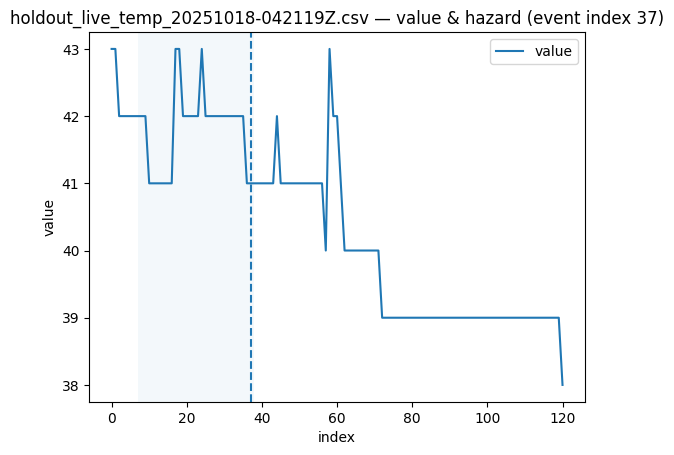

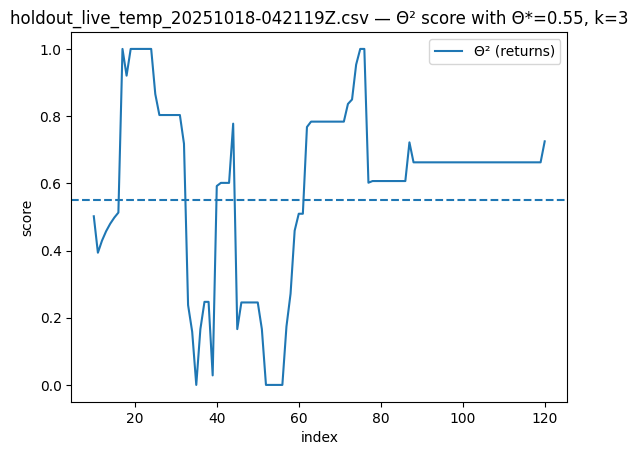

In [39]:
# Holdout visualization: value & score with hazard/detection
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

RUNS = Path("./cnt_ewb_theta2/runs")
holdout_csv = RUNS/"ewb_holdout_results.csv"
row = pd.read_csv(holdout_csv).sort_values("mtime_utc").iloc[-1]
seg_path = Path(row["path"])
df = pd.read_csv(seg_path)

# Choose timestamp; fall back to index if absent
if "timestamp" in df.columns:
    t = pd.to_datetime(df["timestamp"], errors="coerce")
    if t.isna().all(): t = pd.RangeIndex(len(df))
else:
    t = pd.RangeIndex(len(df))
x = pd.to_numeric(df["value"], errors="coerce").replace([np.inf,-np.inf], np.nan).dropna().to_numpy(float)
t = np.array(t)[:len(x)]

# Recreate event, hazard, Θ² score (same settings as runner)
def robust_med(series, W, center=True, minp=None):
    s=pd.Series(series); 
    if W>=len(s): W=max(5, len(s)//4)
    if minp is None: minp=max(3, W//3)
    return s.rolling(W, center=center, min_periods=minp).median()

def infer_event_idx_cooling(x):
    n=len(x); W=min(121, max(31, n//200))
    sm = robust_med(x, W, center=True).bfill().ffill().to_numpy()
    dx = np.diff(sm, prepend=sm[0])
    i  = int(np.nanargmin(dx))
    return max(5, min(n-5, i))

def hazard_labels_adaptive(n, t_event_idx, target=0.25, bounds=(0.15,0.35)):
    lo,hi=bounds; tgt=int(np.clip(round(n*target), max(10,n//12), n//2))
    pre=min(t_event_idx, tgt); a=max(0, t_event_idx-pre)
    y=np.zeros(n, dtype=int); y[a:t_event_idx+1]=1
    frac=y.mean()
    if frac<lo and a>0:
        need=int(np.ceil(lo*n))-(t_event_idx-a+1); a=max(0,a-need); y[:]=0; y[a:t_event_idx+1]=1
    elif frac>hi:
        cut=int(np.floor(hi*n)); a=max(0, t_event_idx - cut + 1); y[:]=0; y[a:t_event_idx+1]=1
    return y

def theta2_returns(x, W):
    xr = np.diff(np.log1p(np.maximum(np.asarray(x,float),0.0)))
    s = pd.Series
    var = s(xr).rolling(max(5,W//2), min_periods=max(3,W//3)).var(ddof=0).to_numpy()
    def ac1_fn(v):
        v=np.asarray(v,float); 
        if v.size<3: return np.nan
        a=v[:-1]-v[:-1].mean(); b=v[1:]-v[1:].mean()
        den=np.sqrt((a*a).sum())*np.sqrt((b*b).sum())
        return (a*b).sum()/den if den>1e-12 else 0.0
    ac1 = s(xr).rolling(max(5,W//2), min_periods=max(3,W//3)).apply(ac1_fn, raw=False).to_numpy()
    def spec_red(v):
        v=np.asarray(v,float); 
        if v.size<8: return np.nan
        v=v-np.nanmean(v); sp=np.fft.rfft(v); p=(sp*sp.conjugate()).real
        if p.size<4: return np.nan
        cut=max(1,int(0.1*len(p))); low=np.nansum(p[1:cut]); high=np.nansum(p[cut:])+1e-12
        return float(low/high)
    spr = s(xr).rolling(max(8,W//2), min_periods=max(4,W//4)).apply(spec_red, raw=False).to_numpy()
    def zrob(u):
        mu=np.nanmedian(u); mad=np.nanmedian(np.abs(u-mu)) or 1.0
        return (u-mu)/(1.4826*mad)
    zsum = zrob(var)+zrob(ac1)+zrob(spr)
    f=np.isfinite(zsum)
    if f.sum()<2: s01=zsum
    else:
        lo,hi=np.nanpercentile(zsum[f],[5,95]); s01=np.clip((zsum-lo)/(hi-lo+1e-12),0,1)
    return np.concatenate([[np.nan], s01])

n=len(x)
W = min(256, max(32, n//10))
event_idx = infer_event_idx_cooling(x)
haz = hazard_labels_adaptive(n, event_idx)
score = theta2_returns(x, W)
THRESH = 0.55; K = 3

# Persistence crossing
yhat = (score >= THRESH).astype(int)
run=0; yhatp=np.zeros_like(yhat)
for i,v in enumerate(yhat):
    run = run+1 if v==1 else 0
    if run>=K: yhatp[i]=1

# Figure 1: raw value with hazard & event
plt.figure()
plt.plot(np.arange(n), x, label="value")
for i in np.where(haz==1)[0]:
    plt.axvspan(i, i+1, alpha=0.05)
plt.axvline(event_idx, linestyle="--")
plt.title(f"{seg_path.name} — value & hazard (event index {event_idx})")
plt.xlabel("index"); plt.ylabel("value")
plt.legend()

# Figure 2: Θ² returns score with Θ*
plt.figure()
plt.plot(np.arange(len(score)), score, label="Θ² (returns)")
plt.axhline(THRESH, linestyle="--")
plt.title(f"{seg_path.name} — Θ² score with Θ*={THRESH}, k={K}")
plt.xlabel("index"); plt.ylabel("score")
plt.legend()


In [40]:
# Capture a dual-channel holdout: GPU temp + GPU power (requires NVIDIA)
# Mid-capture, nudge a fan curve or power limit to create a cooling action.
import time, subprocess, shutil, pandas as pd
from datetime import datetime, timezone
from pathlib import Path

DUR=120; STEP=1.0
out = Path("./cnt_ewb_data/real_live/cooling_segments") / f"holdout_dual_gpu_{datetime.now(timezone.utc).strftime('%Y%m%d-%H%M%S')}Z.csv"
out.parent.mkdir(parents=True, exist_ok=True)

def q(query):
    try:
        txt = subprocess.check_output(["nvidia-smi","--query-gpu="+query,"--format=csv,noheader,nounits"], text=True, timeout=3)
        return float(txt.strip().splitlines()[0].strip())
    except Exception:
        return float("nan")

rows=[]; t0=time.time()
while True:
    now=time.time()
    rows.append({
        "timestamp": datetime.now(timezone.utc).isoformat().replace("+00:00","Z"),
        "gpu_temp_c": q("temperature.gpu"),
        "gpu_power_w": q("power.draw"),
        "t_sec": now - t0
    })
    if now - t0 >= DUR: break
    time.sleep(max(0.0, STEP - (time.time() - now)))

pd.DataFrame(rows).to_csv(out, index=False, encoding="utf-8")
print("[holdout-dual] saved", out)


[holdout-dual] saved cnt_ewb_data\real_live\cooling_segments\holdout_dual_gpu_20251018-043731Z.csv


In [41]:
# === CNT EWB: Dual-channel holdout capture ×3 (GPU temp, power, fan) ===
# Tip: mid-run (the console will ping), nudge a tiny fan or power-limit change.
import time, subprocess, sys, shutil
from pathlib import Path
from datetime import datetime, timezone
import pandas as pd
import numpy as np

ROUNDS        = 3         # number of fresh holdouts to capture
DURATION_SEC  = 180       # 120–240s recommended
SAMPLE_EVERY  = 1.0       # seconds between samples
OUTDIR = Path("./cnt_ewb_data/real_live/cooling_segments")
OUTDIR.mkdir(parents=True, exist_ok=True)

def has_smi(): return shutil.which("nvidia-smi") is not None

def read_triplet():
    """
    One nvidia-smi call for three fields:
    temperature.gpu (°C), power.draw (W), fan.speed (%)
    """
    try:
        out = subprocess.check_output(
            ["nvidia-smi",
             "--query-gpu=temperature.gpu,power.draw,fan.speed",
             "--format=csv,noheader,nounits"],
            text=True, stderr=subprocess.DEVNULL, timeout=3
        ).strip()
        # Take first GPU line if multiple
        line = out.splitlines()[0]
        parts = [p.strip() for p in line.split(",")]
        def f(x):
            try:
                return float(x)
            except Exception:
                return np.nan
        temp = f(parts[0]) if len(parts)>0 else np.nan
        power= f(parts[1]) if len(parts)>1 else np.nan
        fan  = f(parts[2]) if len(parts)>2 else np.nan
        return temp, power, fan
    except Exception:
        return np.nan, np.nan, np.nan

if not has_smi():
    raise RuntimeError("nvidia-smi not found. Install NVIDIA drivers / CUDA toolkit, or run on a machine with an NVIDIA GPU.")

for r in range(1, ROUNDS+1):
    t0 = time.time()
    rows = []
    fname = f"holdout_dual_gpu_{datetime.now(timezone.utc).strftime('%Y%m%d-%H%M%S')}Z.csv"
    out = OUTDIR / fname
    print(f"[capture {r}/{ROUNDS}] writing -> {out}")
    pinged=False

    while True:
        now = time.time()
        temp, power, fan = read_triplet()
        rows.append({
            "timestamp": datetime.now(timezone.utc).isoformat().replace("+00:00","Z"),
            "gpu_temp_c": temp,
            "gpu_power_w": power,
            "gpu_fan_pct": fan,
            "t_sec": now - t0
        })
        elapsed = now - t0
        # gentle mid-run cue
        if not pinged and elapsed >= 0.5*DURATION_SEC:
            print("— small tweak now (fan curve or power limit) —")
            pinged = True
        if elapsed >= DURATION_SEC:
            break
        time.sleep(max(0.0, SAMPLE_EVERY - (time.time() - now)))

    pd.DataFrame(rows).to_csv(out, index=False, encoding="utf-8")
    print(f"[done] {len(rows)} rows.")
    # tiny pause between runs
    time.sleep(3)

print("Complete. Fresh prospective holdouts saved in:", OUTDIR)


[capture 1/3] writing -> cnt_ewb_data\real_live\cooling_segments\holdout_dual_gpu_20251018-044559Z.csv
— small tweak now (fan curve or power limit) —
[done] 181 rows.
[capture 2/3] writing -> cnt_ewb_data\real_live\cooling_segments\holdout_dual_gpu_20251018-044903Z.csv
— small tweak now (fan curve or power limit) —
[done] 181 rows.
[capture 3/3] writing -> cnt_ewb_data\real_live\cooling_segments\holdout_dual_gpu_20251018-045206Z.csv
— small tweak now (fan curve or power limit) —
[done] 181 rows.
Complete. Fresh prospective holdouts saved in: cnt_ewb_data\real_live\cooling_segments


In [42]:
# === CNT Θ* — Multi-channel Holdout Runner v0.3 ===
import json, re, glob, hashlib
from pathlib import Path
from datetime import datetime, timezone
import numpy as np, pandas as pd

ROOT = Path("./cnt_ewb_theta2"); RUNS = ROOT/"runs"; RUNS.mkdir(parents=True, exist_ok=True)
COOL = Path("./cnt_ewb_data/real_live/cooling_segments")

def load_prereg():
    y = ROOT/"ewb_prereg.yaml"
    if y.exists():
        return json.loads(y.read_text(encoding="utf-8", errors="ignore"))
    y2 = ROOT/"ewb_prereg.yml"
    if y2.exists():
        txt = y2.read_text(encoding="utf-8", errors="ignore")
        def grab(key, cast=str, default=None):
            m = re.search(rf"^\s*{re.escape(key)}:\s*(.+)$", txt, re.M)
            return cast(m.group(1).strip()) if m else default
        return {
            "registered_at_utc": grab("registered_at_utc", str, datetime.now(timezone.utc).isoformat().replace("+00:00","Z")),
            "frozen_parameters": {
                "Theta_star": float(grab("Theta_star", float, 0.55)),
                "persistence_k": int(grab("persistence_k", int, 3)),
                "hazard_target_pos_frac": float(grab("hazard_target_pos_frac", float, 0.25)),
                "hazard_bounds": [0.15, 0.35],
                "gauges": {"affine":{"a":2.5,"b":7.0},"decimate":{"factor":2}},
                "score": {"name":"theta2_returns"}
            }
        }
    raise RuntimeError("Missing ewb_prereg.yaml/.yml")

P       = load_prereg()
REG_TS  = pd.to_datetime(P["registered_at_utc"], utc=True)
THR     = P["frozen_parameters"]["Theta_star"]
K       = P["frozen_parameters"]["persistence_k"]
TGT     = P["frozen_parameters"]["hazard_target_pos_frac"]
B_LO,B_HI = P["frozen_parameters"]["hazard_bounds"]
AFF     = P["frozen_parameters"]["gauges"]["affine"]
DEC     = P["frozen_parameters"]["gauges"]["decimate"]

def infer_step(ts):
    a = np.array([t.timestamp() for t in ts], float)
    d = np.diff(a); d = d[d>0]
    return float(np.median(d)) if d.size else None

def theta2_returns(x, W):
    x = np.asarray(x, float)
    xr = np.diff(np.log1p(np.maximum(x, -0.999999)))
    S = pd.Series
    var = S(xr).rolling(max(5,W//2), min_periods=max(3,W//3)).var(ddof=0).to_numpy()
    def ac1(v):
        v=np.asarray(v,float)
        if v.size<3: return np.nan
        a=v[:-1]-v[:-1].mean(); b=v[1:]-v[1:].mean()
        den=np.sqrt((a*a).sum())*np.sqrt((b*b).sum())
        return (a*b).sum()/den if den>1e-12 else 0.0
    ac  = S(xr).rolling(max(5,W//2), min_periods=max(3,W//3)).apply(ac1, raw=False).to_numpy()
    def red(v):
        v=np.asarray(v,float)
        if v.size<8: return np.nan
        v=v-np.nanmean(v); sp=np.fft.rfft(v); p=(sp*sp.conjugate()).real
        if p.size<4: return np.nan
        cut=max(1,int(0.1*len(p))); low=np.nansum(p[1:cut]); high=np.nansum(p[cut:])+1e-12
        return float(low/high)
    sr  = S(xr).rolling(max(8,W//2), min_periods=max(4,W//4)).apply(red, raw=False).to_numpy()
    def z(u):
        mu=np.nanmedian(u); mad=np.nanmedian(np.abs(u-mu)) or 1.0
        return (u-mu)/(1.4826*mad)
    zsum = z(var)+z(ac)+z(sr)
    f=np.isfinite(zsum)
    if f.sum()<2: s01=zsum
    else:
        lo,hi=np.nanpercentile(zsum[f],[5,95]); s01=np.clip((zsum-lo)/(hi-lo+1e-12),0,1)
    return np.concatenate([[np.nan], s01])

def infer_event_idx_cooling(x):
    n=len(x); W=min(121, max(31, n//200))
    sm = pd.Series(x).rolling(W, center=True, min_periods=max(3,W//3)).median().bfill().ffill().to_numpy()
    dx = np.diff(sm, prepend=sm[0]); i=int(np.nanargmin(dx))
    return max(5, min(n-5, i))

def hazard_labels_adaptive(n, t_ev, target=TGT, bounds=(B_LO,B_HI)):
    lo,hi=bounds
    tgt=int(np.clip(round(n*target), max(10,n//12), n//2))
    pre=min(t_ev, tgt); a=max(0, t_ev-pre)
    y=np.zeros(n, dtype=int); y[a:t_ev+1]=1
    frac=y.mean()
    if frac<lo and a>0:
        need=int(np.ceil(lo*n))-(t_ev-a+1); a=max(0,a-need); y[:]=0; y[a:t_ev+1]=1
    elif frac>hi:
        cut=int(np.floor(hi*n)); a=max(0, t_ev - cut + 1); y[:]=0; y[a:t_ev+1]=1
    return y

def choose_W(n, step=None):
    if n<=64: return max(8, n//6)
    if (step or 0)>=20*3600: return min(64, max(16, n//8))
    return min(256, max(32, n//10))

def persistent(yhat,k=K):
    out=np.zeros_like(yhat); run=0
    for i,v in enumerate(yhat):
        run=run+1 if v==1 else 0
        if run>=k: out[i]=1
    return out

def roc_auc_np(y_true, y_score):
    y_true=np.asarray(y_true,int); y_score=np.asarray(y_score,float)
    n_pos=(y_true==1).sum(); n_neg=(y_true==0).sum()
    if len(y_true)==0 or n_pos==0 or n_neg==0: return np.nan
    order=np.argsort(y_score)
    ranks=np.empty_like(order,dtype=float); ranks[order]=np.arange(1,len(y_score)+1)
    sum_ranks_pos=ranks[y_true==1].sum()
    return float((sum_ranks_pos - n_pos*(n_pos+1)/2)/(n_pos*n_neg))

def precision_at_threshold(y_true, y_score, thr):
    yhat=(y_score>=thr).astype(int)
    tp=np.sum((yhat==1)&(y_true==1)); fp=np.sum((yhat==1)&(y_true==0))
    return float(tp/(tp+fp)) if (tp+fp)>0 else 0.0, yhat

def leads_vs_event(y_masked, yhat_persist_masked):
    pos=np.where(y_masked==1)[0]
    if pos.size==0: return np.nan, np.nan
    t_event=int(pos[-1])
    hits=np.where((yhat_persist_masked==1)&(y_masked==1))[0]
    any_det=np.where(yhat_persist_masked==1)[0]
    lead_hit = float(t_event - hits[0]) if hits.size>0 else np.nan
    lead_any = float(t_event - any_det[0]) if any_det.size>0 else np.nan
    return lead_hit, lead_any

def decimate_boxcar(x, factor):
    s = pd.Series(x).rolling(factor, min_periods=max(2,factor//2)).mean().to_numpy()
    return s[factor-1::factor]

# Load/extend scoreboard
holdout_csv = RUNS/"ewb_holdout_results.csv"
df_holdout = pd.read_csv(holdout_csv) if holdout_csv.exists() else pd.DataFrame()

# Scan files strictly after prereg timestamp
new_rows=[]
for p in sorted(COOL.glob("*.csv")):
    mtime = datetime.fromtimestamp(p.stat().st_mtime, tz=timezone.utc)
    if mtime <= REG_TS: 
        continue
    # Avoid re-evaluating identically named (segment+channel) rows
    already = set()
    if len(df_holdout):
        already = set(zip(df_holdout.get("segment",[]), df_holdout.get("channel",[])))

    df = pd.read_csv(p)
    # Candidate channels = every numeric column except ['t_sec']
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cand = [c for c in num_cols if c not in ["t_sec"]]
    # Keep 'value' first if present (back-compat)
    if "value" in cand:
        cand = ["value"] + [c for c in cand if c!="value"]

    # Timestamp (optional)
    if "timestamp" in df.columns:
        ts = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)
        if ts.isna().all(): ts=None
        else: ts = list(ts)
    else:
        ts=None

    for ch in cand:
        seg_id = p.name
        if (seg_id, ch) in already:
            continue

        x = pd.to_numeric(df[ch], errors="coerce").replace([np.inf,-np.inf],np.nan).dropna().to_numpy(float)
        if len(x)<40:
            continue

        step = infer_step(ts) if ts is not None else None
        W    = choose_W(len(x), step)
        t_ev = infer_event_idx_cooling(x)
        yF   = hazard_labels_adaptive(len(x), t_ev)
        sF   = theta2_returns(x, W)
        m    = np.isfinite(sF)
        s,y  = sF[m], yF[m]
        if len(s)<10 or y.mean() in (0.0,1.0):
            status="degenerate_mask"
            auc=prec=lead_hit=lead_any=np.nan
            inv_attempted=inv_passed=inv_rate=np.nan
        else:
            status="ok"
            auc = roc_auc_np(y, s)
            prec, yhat = precision_at_threshold(y, s, THR)
            yhatp = persistent(yhat, k=K)
            lead_hit, lead_any = leads_vs_event(y, yhatp)

            # Gauges
            inv_attempted=0; inv_passed=0

            # affine
            xa  = AFF["a"]*x + AFF["b"]
            saF = theta2_returns(xa, W); ma=np.isfinite(saF); sa, ya = saF[ma], yF[ma]
            if len(sa)>=10 and ya.mean() not in (0.0,1.0):
                inv_attempted += 1
                auc_a = roc_auc_np(ya, sa)
                prec_a, yhat_a = precision_at_threshold(ya, sa, THR)
                yhatp_a = persistent(yhat_a, k=K)
                lead_hit_a, _ = leads_vs_event(ya, yhatp_a)
                if (np.sign(lead_hit or 0)==np.sign(lead_hit_a or 0)) and (prec_a + 1e-12 >= prec):
                    inv_passed += 1
            else:
                auc_a=prec_a=lead_hit_a=np.nan

            # decimate anti-aliased
            f = max(2, int(DEC.get("factor",2)))
            xd  = decimate_boxcar(x, f)
            yD  = yF[f-1::f]
            Wd  = max(8, W//f)
            sdF = theta2_returns(xd, Wd); md=np.isfinite(sdF); sd, yD = sdF[md], yD[md]
            if len(sd)>=10 and yD.mean() not in (0.0,1.0):
                inv_attempted += 1
                auc_d = roc_auc_np(yD, sd)
                prec_d, yhat_d = precision_at_threshold(yD, sd, THR)
                yhatp_d = persistent(yhat_d, k=K)
                lead_hit_d, _ = leads_vs_event(yD, yhatp_d)
                if (np.sign(lead_hit or 0)==np.sign(lead_hit_d or 0)):
                    inv_passed += 1
            else:
                auc_d=prec_d=lead_hit_d=np.nan

            inv_rate = (inv_passed/inv_attempted) if inv_attempted>0 else np.nan

        new_rows.append({
            "segment": seg_id,
            "channel": ch,
            "path": str(p.as_posix()),
            "sha256": hashlib.sha256(open(p,"rb").read()).hexdigest(),
            "N": len(s) if isinstance(s, np.ndarray) else np.nan,
            "W": W,
            "status": status,
            "AUC": auc,
            "Precision": prec if status=="ok" else np.nan,
            "Lead@Hit": lead_hit if status=="ok" else np.nan,
            "Lead@Any": lead_any if status=="ok" else np.nan,
            "AUC_affine": locals().get("auc_a", np.nan),
            "Precision_affine": locals().get("prec_a", np.nan),
            "Lead@Hit_affine": locals().get("lead_hit_a", np.nan),
            "AUC_decim": locals().get("auc_d", np.nan),
            "Precision_decim": locals().get("prec_d", np.nan),
            "Lead@Hit_decim": locals().get("lead_hit_d", np.nan),
            "invariance_attempted": inv_attempted if status=="ok" else np.nan,
            "invariance_passed":    inv_passed if status=="ok" else np.nan,
            "invariance_rate":      (inv_passed/inv_attempted) if (status=="ok" and inv_attempted>0) else np.nan,
            "mtime_utc": datetime.fromtimestamp(p.stat().st_mtime, tz=timezone.utc).isoformat().replace("+00:00","Z")
        })

# Append & save
if new_rows:
    df_new = pd.DataFrame(new_rows)
    df_holdout = pd.concat([df_holdout, df_new], ignore_index=True)
    # schema guard
    for col in ["invariance_attempted","invariance_passed","invariance_rate"]:
        if col not in df_holdout.columns:
            df_holdout[col] = np.nan
    df_holdout.to_csv(holdout_csv, index=False, encoding="utf-8")

# Progress report (per-channel)
if len(df_holdout)==0:
    print("No prospective multi-channel segments found after prereg:", REG_TS)
else:
    # Filter to post-prereg only
    H = df_holdout[pd.to_datetime(df_holdout["mtime_utc"], errors="coerce", utc=True) > REG_TS].copy()
    if len(H)==0:
        print("No post-prereg rows yet.")
    else:
        def ok_lead(s): return (s["Lead@Hit"]>0).fillna(False).mean()*100
        def med_auc(s): return float(s["AUC"].median())
        def inv_ok(s):
            r = s["invariance_rate"].dropna()
            return float(r.mean()*100) if len(r) else float("nan")

        print("== CNT Θ* — Holdout Progress (multi-channel) ==")
        print(f"Total rows: {len(H)}  (after prereg: {REG_TS})")
        print(f"Overall   → Lead@Hit>0: {ok_lead(H):.1f}% | Median AUC: {med_auc(H):.3f} | Invariance OK: {inv_ok(H):.1f}%")
        for ch, sub in H.groupby("channel"):
            print(f"{ch:>12} → Lead@Hit>0: {ok_lead(sub):5.1f}% | Median AUC: {med_auc(sub):.3f} | Invariance OK: {inv_ok(sub):5.1f}%  | n={len(sub)}")

        print("\nRecent additions:")
        cols = ["segment","channel","status","AUC","Precision","Lead@Hit","Lead@Hit_affine","Lead@Hit_decim","invariance_attempted","invariance_passed","invariance_rate","mtime_utc"]
        print(H.sort_values("mtime_utc").tail(8)[cols].to_string(index=False))


== CNT Θ* — Holdout Progress (multi-channel) ==
Total rows: 15  (after prereg: 2025-10-18 04:09:49.361036+00:00)
Overall   → Lead@Hit>0: 20.0% | Median AUC: 0.573 | Invariance OK: 50.0%
 gpu_fan_pct → Lead@Hit>0:   0.0% | Median AUC: nan | Invariance OK:   nan%  | n=3
 gpu_power_w → Lead@Hit>0:  20.0% | Median AUC: 0.459 | Invariance OK:  25.0%  | n=5
  gpu_temp_c → Lead@Hit>0:   0.0% | Median AUC: nan | Invariance OK:   nan%  | n=5
       value → Lead@Hit>0: 100.0% | Median AUC: 0.608 | Invariance OK: 100.0%  | n=1

Recent additions:
                              segment     channel          status      AUC  Precision  Lead@Hit  Lead@Hit_affine  Lead@Hit_decim  invariance_attempted  invariance_passed  invariance_rate                   mtime_utc
holdout_dual_gpu_20251018-044559Z.csv gpu_power_w              ok 0.538261    0.00000       NaN              NaN            20.0                   2.0                0.0              0.0 2025-10-18T04:49:00.069814Z
holdout_dual_gpu_20251018-044

C:\Users\caleb\CNT_Lab\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\caleb\CNT_Lab\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [43]:
# === CNT Θ* — Publish Pack v0.2 (multi-channel) ===
import glob, hashlib, shutil
from pathlib import Path
from datetime import datetime, timezone
import pandas as pd, numpy as np

ROOT = Path("./cnt_ewb_theta2")
RUNS = ROOT/"runs"
PUB  = ROOT/"publish"/"ewb_publish_v0_2"
PUB.mkdir(parents=True, exist_ok=True)

def latest(pattern):
    files = [Path(p) for p in glob.glob(pattern)]
    return max(files, key=lambda p: p.stat().st_mtime) if files else None

# Core artifacts
core = [ROOT/"ewb_prereg.yaml", ROOT/"ewb_prereg.yml", ROOT/"ewb_results.md"]
core = [p for p in core if p.exists()]
for p in core: shutil.copy2(p, PUB/p.name)

# Include scoreboard
score = RUNS/"ewb_holdout_results.csv"
if score.exists(): shutil.copy2(score, PUB/score.name)

# Build updated multi-channel summary MD/HTML
H = pd.read_csv(score) if score.exists() else pd.DataFrame()
if len(H):
    H_post = H[pd.to_datetime(H["mtime_utc"], errors="coerce", utc=True) > pd.to_datetime((ROOT/"ewb_prereg.yaml").read_text(encoding="utf-8", errors="ignore").split('"registered_at_utc": "')[1].split('"')[0] if (ROOT/"ewb_prereg.yaml").exists() else "1970-01-01Z", utc=True)]
else:
    H_post = H

def ok_lead(s): return (s["Lead@Hit"]>0).fillna(False).mean()*100
def med_auc(s): return float(s["AUC"].median()) if len(s) else float("nan")
def inv_ok(s):
    r=s["invariance_rate"].dropna()
    return float(r.mean()*100) if len(r) else float("nan")

lines = []
lines.append("# CNT Θ* Early-Warning — Multi-channel Summary (v0.2)")
lines.append("")
ts = datetime.now(timezone.utc).isoformat().replace("+00:00","Z")
lines.append(f"**Generated (UTC):** {ts}")
lines.append("")
if len(H_post):
    lines.append(f"**Overall (post-prereg):** Lead@Hit>0 = {ok_lead(H_post):.1f}% | Median AUC = {med_auc(H_post):.3f} | Invariance OK = {inv_ok(H_post):.1f}%  (n={len(H_post)})")
    lines.append("")
    lines.append("## Per-channel")
    for ch, sub in H_post.groupby("channel"):
        lines.append(f"- **{ch}** → Lead@Hit>0 = {ok_lead(sub):.1f}%, Median AUC = {med_auc(sub):.3f}, Invariance OK = {inv_ok(sub):.1f}% (n={len(sub)})")
    lines.append("")
    lines.append("## Recent rows")
    cols = ["segment","channel","status","AUC","Precision","Lead@Hit","Lead@Hit_affine","Lead@Hit_decim","invariance_rate","mtime_utc"]
    lines.append(H_post.sort_values("mtime_utc").tail(15)[[c for c in cols if c in H_post.columns]].to_string(index=False))
else:
    lines.append("_No post-prereg rows yet._")

md = "\n".join(lines)
(PUB/"ewb_results_multi_v0_2.md").write_text(md, encoding="utf-8")

html = f"""<!doctype html><meta charset="utf-8">
<title>CNT Θ* — Multi-channel Summary v0.2</title>
<style>body{{font-family: ui-monospace, Consolas, Menlo, monospace; white-space: pre-wrap; line-height:1.35}}</style>
<pre>{md}</pre>"""
(PUB/"ewb_results_multi_v0_2.html").write_text(html, encoding="utf-8")

# Checksums
def sha256(p: Path):
    h=hashlib.sha256()
    with open(p,"rb") as f:
        for b in iter(lambda: f.read(1<<20), b""): h.update(b)
    return h.hexdigest()

checks=[]
for p in sorted(PUB.rglob("*")):
    if p.is_file():
        checks.append(f"{sha256(p)}  {p.relative_to(PUB).as_posix()}")
(PUB/"checksums.sha256").write_text("\n".join(checks)+"\n", encoding="utf-8")

# Zip
zip_path = ROOT/"ewb_publish_v0_2.zip"
if zip_path.exists(): zip_path.unlink()
shutil.make_archive(str(zip_path.with_suffix("")), "zip", PUB)

print("[publish v0.2] Folder:", PUB)
print("[publish v0.2] Zip   :", zip_path)


[publish v0.2] Folder: cnt_ewb_theta2\publish\ewb_publish_v0_2
[publish v0.2] Zip   : cnt_ewb_theta2\ewb_publish_v0_2.zip


C:\Users\caleb\CNT_Lab\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\caleb\CNT_Lab\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [44]:
# === CNT Θ* — Publish Pack v0.2.1 (robust stats, no warnings) ===
import glob, hashlib, shutil
from pathlib import Path
from datetime import datetime, timezone
import numpy as np, pandas as pd
import json, re

ROOT = Path("./cnt_ewb_theta2")
RUNS = ROOT / "runs"
PUB  = ROOT / "publish" / "ewb_publish_v0_2"
PUB.mkdir(parents=True, exist_ok=True)

def load_reg_ts():
    y = ROOT/"ewb_prereg.yaml"
    if y.exists():
        try:
            J = json.loads(y.read_text(encoding="utf-8", errors="ignore"))
            return pd.to_datetime(J["registered_at_utc"], utc=True)
        except Exception:
            pass
    y2 = ROOT/"ewb_prereg.yml"
    if y2.exists():
        txt = y2.read_text(encoding="utf-8", errors="ignore")
        m = re.search(r"registered_at_utc:\s*([^\n]+)", txt)
        if m: return pd.to_datetime(m.group(1).strip(), utc=True)
    return pd.to_datetime("1970-01-01Z")

REG_TS = load_reg_ts()

# Copy core artifacts
for p in [ROOT/"ewb_prereg.yaml", ROOT/"ewb_prereg.yml", ROOT/"ewb_results.md"]:
    if p.exists(): shutil.copy2(p, PUB/p.name)

score = RUNS/"ewb_holdout_results.csv"
H = pd.read_csv(score) if score.exists() else pd.DataFrame()
if not len(H):
    md = "# CNT Θ* Early-Warning — Multi-channel Summary (v0.2.1)\n\n_No results yet._\n"
else:
    H["mtime_dt"] = pd.to_datetime(H["mtime_utc"], errors="coerce", utc=True)
    H_post = H[H["mtime_dt"] > REG_TS].copy()

    def fmt_pct(x):
        return "n/a" if x is None or (isinstance(x, float) and np.isnan(x)) else f"{x:.1f}%"
    def fmt_med(x):
        return "n/a" if x is None or (isinstance(x, float) and np.isnan(x)) else f"{x:.3f}"

    def lead_pct_ok(df):
        df = df[df["status"]=="ok"]
        n = len(df)
        if n==0: return None
        return 100.0 * ((df["Lead@Hit"]>0).fillna(False).sum()/n)

    def med_auc_ok(df):
        df = df[df["status"]=="ok"]
        vals = df["AUC"].dropna()
        return float(vals.median()) if len(vals) else None

    def inv_ok_pct(df):
        df = df[df["status"]=="ok"]
        vals = df["invariance_rate"].dropna()
        return 100.0*float(vals.mean()) if len(vals) else None

    lines = []
    lines.append("# CNT Θ* Early-Warning — Multi-channel Summary (v0.2.1)")
    lines.append("")
    lines.append(f"**Generated (UTC):** {datetime.now(timezone.utc).isoformat().replace('+00:00','Z')}")
    lines.append(f"**Preregistered at (UTC):** {REG_TS.isoformat()}")
    lines.append("")

    if len(H_post):
        overall_lead = lead_pct_ok(H_post)
        overall_auc  = med_auc_ok(H_post)
        overall_inv  = inv_ok_pct(H_post)
        lines.append(f"**Overall (post-prereg):** Lead@Hit>0 = {fmt_pct(overall_lead)} | Median AUC = {fmt_med(overall_auc)} | Invariance OK = {fmt_pct(overall_inv)}  (n={len(H_post)})")
        lines.append("\n## Per-channel")
        for ch, sub in H_post.groupby("channel"):
            lines.append(f"- **{ch}** → Lead@Hit>0 = {fmt_pct(lead_pct_ok(sub))}, Median AUC = {fmt_med(med_auc_ok(sub))}, Invariance OK = {fmt_pct(inv_ok_pct(sub))} (n={len(sub)})")
        lines.append("\n## Recent rows")
        cols = ["segment","channel","status","AUC","Precision","Lead@Hit","Lead@Hit_affine","Lead@Hit_decim","invariance_rate","mtime_utc"]
        have = [c for c in cols if c in H_post.columns]
        lines.append(H_post.sort_values("mtime_dt").tail(15)[have].to_string(index=False))
    else:
        lines.append("_No post-prereg rows yet._")

    md = "\n".join(lines)

# Write MD + HTML
(PUB/"ewb_results_multi_v0_2.md").write_text(md, encoding="utf-8")
html = f"""<!doctype html><meta charset="utf-8">
<title>CNT Θ* — Multi-channel Summary v0.2.1</title>
<style>body{{font-family: ui-monospace, Consolas, Menlo, monospace; white-space: pre-wrap; line-height:1.35}}</style>
<pre>{md}</pre>"""
(PUB/"ewb_results_multi_v0_2.html").write_text(html, encoding="utf-8")

# Refresh checksums + zip
def sha256(p: Path):
    h=hashlib.sha256()
    with open(p,"rb") as f:
        for b in iter(lambda: f.read(1<<20), b""): h.update(b)
    return h.hexdigest()

checks=[]
for p in sorted(PUB.rglob("*")):
    if p.is_file():
        checks.append(f"{sha256(p)}  {p.relative_to(PUB).as_posix()}")
(PUB/"checksums.sha256").write_text("\n".join(checks)+"\n", encoding="utf-8")

zip_path = ROOT/"ewb_publish_v0_2.zip"
if zip_path.exists(): zip_path.unlink()
shutil.make_archive(str(zip_path.with_suffix("")), "zip", PUB)

print("[publish v0.2.1] OK:", zip_path)


[publish v0.2.1] OK: cnt_ewb_theta2\ewb_publish_v0_2.zip
